## Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation
from tqdm import tqdm
import os

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device=th.device('cuda' if th.cuda.is_available() else 'cpu'), max_size=500):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = th.sigmoid(self.l4(a))
        return 1.8 * a + 0.2 # scale to [0.2, 2.0]

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

In [4]:
# Define DDPG Agent
class DDPGAgent(object):
    def __init__(self, env, device=th.device('cuda' if th.cuda.is_available() else 'cpu'), discount=0.9, tau=0.01):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(self.state_dim, self.action_dim).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(self.state_dim, self.action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=1e-4)
        self.critic_target = deepcopy(self.critic)
        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, self.device)

    def save_agent(self, path='agent_state'):
        models = [self.actor, self.actor_target, self.actor_optimizer, self.critic, self.critic_target, self.critic_optimizer]
        fnames = ['actor', 'actor_target', 'actor_optimizer', 'critic', 'critic_target', 'critic_optimizer']
        if not os.path.exists(path):
            os.makedirs(path)
        for m, f in zip(models, fnames):
            th.save(m.state_dict(), os.path.join(path, f+'.pt'))
        print(f'Agent saved to folder {path}')

    def load_agent(self, path='agent_state'):
        models = [self.actor, self.actor_target, self.actor_optimizer, self.critic, self.critic_target, self.critic_optimizer]
        fnames = ['actor', 'actor_target', 'actor_optimizer', 'critic', 'critic_target', 'critic_optimizer']
        for m, f in zip(models, fnames):
            m = th.load(os.path.join(path, f+'.pt'))
        print(f'Agent loaded from folder {path}')
    
    def soft_update(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, state): # Actor selects action based on current state
        return self.actor(th.tensor(state, dtype=th.float32).to(self.device)).detach().cpu().numpy()

    def train(self, batch_size=32, target_update_period=10, max_iter=10000, max_patience=200):
        CHO_idx = int(2*self.state_dim/3 - 1)
        critic_training_loss = []
        min_critic_loss = float('inf')
        patience = max_patience
        for it in tqdm(range(max_iter)):
            # Sample one episode and add it to the replay buffer
            state, info = self.env.reset()
            reset_time = info['time']
            done = False
            last_meal = state[CHO_idx] # XXX
            while not done and (info['time'] - reset_time).days < 4: # 4 days
                if last_meal > state[CHO_idx]: # First step after meal
                    print('Bolus Injection!')
                    start_state = state
                    start_time = info['time']
                    noise = np.random.normal(0, 0.3, (3,))
                    bolus_action = self.select_action(start_state) + noise
                    last_meal = state[CHO_idx] #### XXX
                    state, reward, done, _, info = self.env.step(bolus_action)
                    reward_sum = reward
                    while not done and state[CHO_idx] == 0 and (info['time'] - start_time).seconds < 5*3600:
                        action = [0, 0, 0]
                        last_meal = state[CHO_idx] #### XXX
                        state, reward, done, _, info = self.env.step(action)
                        reward_sum += reward
                    reward_sum /= (info['time'] - start_time).seconds / 60
                    next_state = state
                    self.replay_buffer.store(start_state, bolus_action, reward_sum, next_state, done)
                    print(f'Episode (reward: {reward_sum}) stored to memory ({self.replay_buffer.size})')
 
                else:
                    action = [0, 0, 0]
                    last_meal = state[CHO_idx] #### XXX
                    state, _, done, _, info = self.env.step(action)

                
            
            if self.replay_buffer.size >= batch_size:
                print('Training...')
                # Sample replay buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
                # Compute the target Q value
                target_q = self.critic_target(next_states, self.actor_target(next_states))
                target_q = rewards + (self.discount * target_q).detach()
                # target_q = rewards + ((not dones) * self.discount * target_q).detach() # XXX: ?????????????
                # Get current Q estimate
                current_q = self.critic(states, actions)
                # Compute critic loss
                critic_loss = F.mse_loss(current_q, target_q)
                # Optimize the critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                # Compute actor loss
                actor_loss = -self.critic(states, self.actor(states)).mean()
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                # Save training loss   
                if critic_loss < min_critic_loss:
                    self.save_agent()
                    min_critic_loss = critic_loss
                    patience = max_patience
                critic_training_loss.append([critic_loss.item(), actor_loss.item()])
                
                # Update target networks
                if it % target_update_period == 0:
                    self.soft_update()

                if it % 5 == 0:
                    print(f'Iteration: {it+1}, Critic loss: {critic_loss.item():.3f} (min: {min_critic_loss:.3f}), Patience left: {patience}')

                # Convergence check
                patience -= 1
                if patience == 0:
                    print('Critic converged...')
                    break

        return critic_training_loss

    def finetune():
        pass

In [5]:
# Define reward function based on paper
def custom_reward(BG_history):
    BG = BG_history[-1]
    # BG: blood glucose level
    # Hypoglycemia: BG < 70 mg/dL
    if 30 <= BG and BG < 70:
        return -1.5
    # Normoglycemia: 70 mg/dL < BG < 180 mg/dL
    elif 70 <= BG and BG <= 180:
        return 0.5
    # Hyperglycemia: BG > 180 mg/dL
    elif 180 < BG and BG <= 300:
        return -0.8
    elif 300 < BG and BG <= 350:
        return -1
    # Other cases
    else:
        return -2

### Linking the DDPG agent to the OpenAI Gym environment

In [6]:
from simglucose.simulation.scenario_gen import RandomScenario

history_length = 6

gym.envs.register(
    id='simglucose-bolus',
    entry_point='simglucose.envs:T1DSimEnvBolus',
    kwargs={'patient_name': ['average_adolescent'],
        'history_length': history_length, 'reward_fun': custom_reward,
        'enable_meal': True})

In [7]:
env = gym.make('simglucose-bolus')
print(env.observation_space)
print(env.action_space)

Dict('CGM': Box(0.0, 10000.0, (6,), float32), 'CHO': Box(0.0, 10000.0, (6,), float32), 'insulin': Box(0.0, 10000.0, (6,), float32))
Box(0.2, 2.0, (3,), float32)


In [8]:
env = FlattenObservation(env)

In [9]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

agent = DDPGAgent(env=env, device=device)
critic_loss = agent.train()

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\yanis\anaconda3\envs\simgl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Bolus Injection!
69.8785214751097
[ 5.82321012 -0.1314945  -0.        ]
Episode (reward: -0.08000000000000002) stored to memory (1)
Bolus Injection!
95.07989109854216
[ 7.92332426 -3.18094991 -0.        ]
Episode (reward: -0.013888888888888938) stored to memory (2)
Bolus Injection!
101.12770898776
[ 8.42730908 -3.29606463 -0.        ]
Episode (reward: -0.0406666666666667) stored to memory (3)
Bolus Injection!
61.75355703497943
[ 5.14612975 -1.28579905 -0.        ]
Episode (reward: 0.027333333333333307) stored to memory (4)
Bolus Injection!
118.32645956822037
[ 9.8605383  -3.33424597 -0.        ]
Episode (reward: -0.07200000000000002) stored to memory (5)
Bolus Injection!
95.3019311918143
[ 7.9418276  -4.12755649 -0.        ]
Episode (reward: -0.09366666666666658) stored to memory (6)
Bolus Injection!
63.60654908867113
[ 5.30054576 -0.55105191 -0.        ]
Episode (reward: -0.19833333333333333) stored to memory (7)
Bolus Injection!
100.50197375062184
[ 8.37516448 -2.28776336 -0.        

  0%|          | 1/10000 [00:38<107:12:10, 38.60s/it]

Episode (reward: -0.08333333333333334) stored to memory (10)
Bolus Injection!
111.65343666786609
[ 9.30445306  0.5814045  -0.        ]


  0%|          | 2/10000 [00:42<50:33:30, 18.20s/it] 

Episode (reward: -0.04782608695652176) stored to memory (11)
Bolus Injection!
101.24721060676072
[ 8.43726755 -0.12221162  0.        ]


  0%|          | 3/10000 [00:47<34:24:09, 12.39s/it]

Episode (reward: -0.06702508960573479) stored to memory (12)
Bolus Injection!
83.93903816982996
[6.99491985 0.73619547 0.        ]


  0%|          | 4/10000 [00:53<26:27:49,  9.53s/it]

Episode (reward: -0.08837209302325584) stored to memory (13)
Bolus Injection!
77.4196776540636
[ 6.4516398  -0.34953157 -0.        ]
Episode (reward: -0.07033333333333336) stored to memory (14)
Bolus Injection!
120.21797716115262
[10.01816476 -3.04901352 -0.        ]


  0%|          | 5/10000 [01:01<25:11:17,  9.07s/it]

Episode (reward: -0.05066666666666668) stored to memory (15)
Bolus Injection!
66.752136848888
[ 5.56267807 -0.91935262  0.        ]
Episode (reward: -0.06833333333333336) stored to memory (16)
Bolus Injection!
93.64592064473933
[ 7.80382672 -3.21263289 -0.        ]
Episode (reward: 0.0019999999999999575) stored to memory (17)
Bolus Injection!
76.71308817393582
[ 6.39275735 -2.59322382 -0.        ]
Episode (reward: -0.05933333333333335) stored to memory (18)
Bolus Injection!
71.45403524759655
[ 5.95450294 -2.00241376 -0.        ]
Episode (reward: 0.0003333333333333203) stored to memory (19)
Bolus Injection!
118.5427856480575
[ 9.87856547 -2.39838085 -0.        ]


  0%|          | 6/10000 [01:15<29:43:13, 10.71s/it]

Episode (reward: -0.03700000000000002) stored to memory (20)
Bolus Injection!
108.76294517318453
[ 9.06357876 -0.23091215 -0.        ]


  0%|          | 7/10000 [01:17<22:02:17,  7.94s/it]

Episode (reward: -0.05949820788530469) stored to memory (21)
Bolus Injection!
90.20831088888116
[ 7.51735924 -0.36714982 -0.        ]


  0%|          | 8/10000 [01:19<16:49:31,  6.06s/it]

Episode (reward: -0.07435897435897439) stored to memory (22)
Bolus Injection!
99.47375104419963
[ 8.28947925 -0.16076787 -0.        ]


  0%|          | 9/10000 [01:21<13:26:26,  4.84s/it]

Episode (reward: -0.11318681318681321) stored to memory (23)
Bolus Injection!
89.85139170550651
[ 7.48761598 -0.17784176 -0.        ]


  0%|          | 10/10000 [01:24<11:43:35,  4.23s/it]

Episode (reward: -0.08623188405797104) stored to memory (24)
Bolus Injection!
93.39716126286507
[ 7.78309677 -0.43568259 -0.        ]


  0%|          | 11/10000 [01:27<10:34:48,  3.81s/it]

Episode (reward: -0.04311594202898553) stored to memory (25)
Bolus Injection!
80.34333923655734
[ 6.69527827  0.25655438 -0.        ]


  0%|          | 12/10000 [01:29<9:28:45,  3.42s/it] 

Episode (reward: -0.09250936329588018) stored to memory (26)
Bolus Injection!
86.55566789817925
[ 7.21297232  0.17168657 -0.        ]


  0%|          | 13/10000 [01:32<8:45:13,  3.16s/it]

Episode (reward: -0.10711610486891389) stored to memory (27)
Bolus Injection!
90.68564878616445
[ 7.5571374  0.8550924 -0.       ]


  0%|          | 14/10000 [01:36<9:03:37,  3.27s/it]

Episode (reward: -0.08840579710144932) stored to memory (28)
Bolus Injection!
58.789310322224765
[ 4.89910919 -0.02078768  0.        ]
Episode (reward: -0.14666666666666667) stored to memory (29)
Bolus Injection!
114.20721418331749
[ 9.51726785 -3.23418748 -0.        ]


  0%|          | 15/10000 [01:41<11:08:39,  4.02s/it]

Episode (reward: -0.01649484536082475) stored to memory (30)
Bolus Injection!
69.19810550446773
[ 5.76650879 -0.37636382 -0.        ]
Episode (reward: -0.12) stored to memory (31)
Bolus Injection!
110.64543240826416
[ 9.2204527  -3.53355264 -0.        ]
Episode (reward: -0.0676666666666667) stored to memory (32)
Bolus Injection!
106.01210224768855
[ 8.83434185 -1.45505414 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (33)
Bolus Injection!
63.74022798726949
[ 5.31168567 -0.7595923  -0.        ]
Episode (reward: -0.09100000000000001) stored to memory (34)
Bolus Injection!
104.79777296191602
[ 8.73314775 -1.7086545  -0.        ]
Episode (reward: -0.035000000000000024) stored to memory (35)
Bolus Injection!
90.83244368477563
[ 7.56937031 -3.10313308 -0.        ]
Episode (reward: -0.06866666666666667) stored to memory (36)
Bolus Injection!
70.53964477833856
[ 5.87830373 -1.54244732 -0.        ]
Episode (reward: 0.002333333333333319) stored to memory (37)
Bolus Injecti

  0%|          | 16/10000 [02:13<34:23:45, 12.40s/it]

Episode (reward: -0.24766666666666623) stored to memory (42)
Training...
Agent saved to folder agent_state
Iteration: 16, Critic loss: 1.412 (min: 1.412), Patience left: 200
Bolus Injection!
73.42371650620784
[ 6.11864304 -0.97401626  0.        ]
Episode (reward: -0.062000000000000006) stored to memory (43)
Bolus Injection!
119.8374703687562
[ 9.98645586 -4.30418791 -0.        ]
Episode (reward: -0.054666666666666745) stored to memory (44)
Bolus Injection!
72.29277636024841
[ 6.02439803 -2.04209871 -0.        ]
Episode (reward: 0.04966666666666664) stored to memory (45)
Bolus Injection!
76.46779005719057
[ 6.37231584  0.83102973 -0.        ]


  0%|          | 17/10000 [02:25<33:53:16, 12.22s/it]

Episode (reward: -0.20980392156862746) stored to memory (46)
Training...
Agent saved to folder agent_state
Bolus Injection!
132.44335475303149
[11.03694623  0.69037113 -0.        ]


  0%|          | 18/10000 [02:27<25:46:35,  9.30s/it]

Episode (reward: -0.06630824372759861) stored to memory (47)
Training...
Agent saved to folder agent_state
Bolus Injection!
76.62338307522036
[ 6.38528192  0.69469253 -0.        ]


  0%|          | 19/10000 [02:30<20:12:07,  7.29s/it]

Episode (reward: -0.09960784313725493) stored to memory (48)
Training...
Agent saved to folder agent_state
Bolus Injection!
106.64980021453178
[8.88748335 0.62154718 0.        ]


  0%|          | 20/10000 [02:33<16:48:16,  6.06s/it]

Episode (reward: -0.07481481481481483) stored to memory (49)
Training...
Bolus Injection!
90.46668366774637
[ 7.53889031 -0.91718655  0.        ]


  0%|          | 21/10000 [02:37<14:43:45,  5.31s/it]

Episode (reward: -0.10798611111111114) stored to memory (50)
Training...
Agent saved to folder agent_state
Iteration: 21, Critic loss: 0.326 (min: 0.326), Patience left: 200
Bolus Injection!
96.2723634333692
[ 8.02269695 -0.53908233 -0.        ]


  0%|          | 22/10000 [02:39<11:57:21,  4.31s/it]

Episode (reward: -0.054838709677419384) stored to memory (51)
Training...
Bolus Injection!
114.99540496464053
[9.58295041e+00 1.21247151e-03 0.00000000e+00]


  0%|          | 23/10000 [02:42<10:59:52,  3.97s/it]

Episode (reward: -0.05017921146953407) stored to memory (52)
Training...
Bolus Injection!
98.56204963661395
[ 8.21350414 -0.09380029 -0.        ]


  0%|          | 24/10000 [02:44<9:41:19,  3.50s/it] 

Episode (reward: -0.07578947368421056) stored to memory (53)
Training...
Bolus Injection!
90.69939036584697
[ 7.55828253 -0.67839998  0.        ]


  0%|          | 25/10000 [02:48<9:35:13,  3.46s/it]

Episode (reward: -0.0666666666666667) stored to memory (54)
Training...
Bolus Injection!
110.48460300320463
[ 9.20705025  0.03199527 -0.        ]


  0%|          | 26/10000 [02:51<9:09:24,  3.31s/it]

Episode (reward: -0.0742753623188406) stored to memory (55)
Training...
Iteration: 26, Critic loss: 0.479 (min: 0.326), Patience left: 195
Bolus Injection!
90.0706666584898
[ 7.50588889  1.44014755 -0.        ]


  0%|          | 27/10000 [02:53<8:15:18,  2.98s/it]

Episode (reward: -0.09578544061302685) stored to memory (56)
Training...
Bolus Injection!
80.31981504913492
[ 6.69331792 -0.54627854 -0.        ]
Episode (reward: -0.12166666666666669) stored to memory (57)
Bolus Injection!
101.49598275073062
[ 8.45799856 -2.93662339 -0.        ]
Episode (reward: -0.03733333333333335) stored to memory (58)
Bolus Injection!
84.98330217599968
[ 7.08194185 -3.66103754 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (59)
Bolus Injection!
59.11400704443031
[ 4.92616725 -1.12395217 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (60)
Bolus Injection!
111.69133289497934
[ 9.30761107 -1.80968803 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (61)
Bolus Injection!
88.01214196110192
[ 7.33434516 -3.94257302 -0.        ]
Episode (reward: 0.016999999999999956) stored to memory (62)
Bolus Injection!
66.293615062786
[ 5.52446792 -0.71849308 -0.        ]
Episode (reward: -0.13533333333333336) stored to me

  0%|          | 28/10000 [03:24<31:52:14, 11.51s/it]

Training...
Bolus Injection!
124.44177458120437
[10.37014788 -0.8785455   0.        ]


  0%|          | 29/10000 [03:28<25:35:23,  9.24s/it]

Episode (reward: -0.09000000000000004) stored to memory (69)
Training...
Bolus Injection!
104.03240827127163
[ 8.66936736  1.0753163  -0.        ]


  0%|          | 30/10000 [03:30<19:27:05,  7.02s/it]

Episode (reward: -0.06479400749063674) stored to memory (70)
Training...
Agent saved to folder agent_state
Bolus Injection!
70.03768944155203
[ 5.83647412 -0.19017181  0.        ]
Episode (reward: -0.10600000000000002) stored to memory (71)
Bolus Injection!
96.61746648743471
[ 8.05145554 -2.70559637 -0.        ]
Episode (reward: -0.02033333333333334) stored to memory (72)
Bolus Injection!
95.8757166743225
[ 7.98964306 -4.00305623 -0.        ]
Episode (reward: -0.03433333333333337) stored to memory (73)
Bolus Injection!
76.74273665514771
[ 6.39522805 -0.57909838 -0.        ]
Episode (reward: -0.11966666666666669) stored to memory (74)
Bolus Injection!
124.71637055669339
[10.39303088 -3.86188532 -0.        ]


  0%|          | 31/10000 [03:44<25:00:53,  9.03s/it]

Episode (reward: -0.03300000000000002) stored to memory (75)
Training...
Iteration: 31, Critic loss: 0.332 (min: 0.172), Patience left: 199
Bolus Injection!
101.58497011417182
[ 8.46541418  0.4127496  -0.        ]


  0%|          | 32/10000 [03:47<19:50:34,  7.17s/it]

Episode (reward: -0.07278911564625853) stored to memory (76)
Training...
Bolus Injection!
105.41887477617678
[ 8.78490623  0.10917467 -0.        ]


  0%|          | 33/10000 [03:49<15:43:28,  5.68s/it]

Episode (reward: -0.07173913043478264) stored to memory (77)
Training...
Bolus Injection!
64.96440677871635
[ 5.41370056 -0.57261764 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory (78)
Bolus Injection!
110.67177943758227
[ 9.22264829 -2.59787575 -0.        ]
Episode (reward: -0.07733333333333334) stored to memory (79)
Bolus Injection!
82.69230360580424
[ 6.8910253  -4.42940386 -0.        ]
Episode (reward: -0.219333333333333) stored to memory (80)
Bolus Injection!
76.18934982106994
[ 6.34911249 -0.14945194 -0.        ]


  0%|          | 34/10000 [04:01<20:44:40,  7.49s/it]

Episode (reward: -0.16947368421052636) stored to memory (81)
Training...
Bolus Injection!
82.24568793708349
[6.85380733 0.25941081 0.        ]


  0%|          | 35/10000 [04:04<17:19:05,  6.26s/it]

Episode (reward: -0.08400000000000002) stored to memory (82)
Training...
Agent saved to folder agent_state
Bolus Injection!
94.05838445943172
[ 7.8381987   2.21548325 -0.        ]


  0%|          | 36/10000 [04:06<13:42:25,  4.95s/it]

Episode (reward: -0.09921568627450983) stored to memory (83)
Training...
Agent saved to folder agent_state
Iteration: 36, Critic loss: 0.094 (min: 0.094), Patience left: 200
Bolus Injection!
111.49224414886189
[ 9.29102035 -0.41837593  0.        ]


  0%|          | 37/10000 [04:10<12:54:19,  4.66s/it]

Episode (reward: -0.0666666666666667) stored to memory (84)
Training...
Bolus Injection!
88.07107290224079
[ 7.33925608  0.64992653 -0.        ]


  0%|          | 38/10000 [04:14<12:07:40,  4.38s/it]

Episode (reward: -0.11287878787878791) stored to memory (85)
Training...
Bolus Injection!
78.62479525596099
[ 6.55206627  0.41541447 -0.        ]


  0%|          | 39/10000 [04:16<10:28:04,  3.78s/it]

Episode (reward: -0.16185185185185186) stored to memory (86)
Training...
Bolus Injection!
67.67303563187805
[ 5.63941964 -0.36494833 -0.        ]
Episode (reward: -0.03933333333333336) stored to memory (87)
Bolus Injection!
108.28899858925948
[ 9.02408322 -3.45521707 -0.        ]
Episode (reward: -0.02600000000000002) stored to memory (88)
Bolus Injection!
92.54804207362541
[ 7.71233684 -4.14952222 -0.        ]
Episode (reward: -0.046666666666666676) stored to memory (89)
Bolus Injection!
74.4624481380221
[ 6.20520401 -0.90302495 -0.        ]
Episode (reward: -0.1376666666666667) stored to memory (90)
Bolus Injection!
110.706595057736
[ 9.22554959 -4.23292885 -0.        ]
Episode (reward: -0.08499999999999992) stored to memory (91)
Bolus Injection!
90.36689303225441
[ 7.53057442 -2.80583473 -0.        ]
Episode (reward: -0.04566666666666674) stored to memory (92)
Bolus Injection!
68.26348794974407
[ 5.688624   -1.54654398 -0.        ]
Episode (reward: -0.06600000000000003) stored to me

  0%|          | 40/10000 [04:42<28:33:12, 10.32s/it]

Episode (reward: -0.07066666666666667) stored to memory (97)
Training...
Bolus Injection!
64.27060123634757
[ 5.35588344  0.10384291 -0.        ]
Episode (reward: -0.1446666666666667) stored to memory (98)
Bolus Injection!
111.16034274616408
[ 9.2633619  -5.08878222 -0.        ]
Episode (reward: -0.02500000000000006) stored to memory (99)
Bolus Injection!
102.76498572860123
[ 8.56374881 -3.07886407 -0.        ]
Episode (reward: -0.05266666666666668) stored to memory (100)
Bolus Injection!
59.94281766243223
[ 4.99523481 -3.53608188 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (101)
Bolus Injection!
110.31524050527052
[ 9.19293671 -1.35818769 -0.        ]


  0%|          | 41/10000 [04:52<28:25:24, 10.27s/it]

Episode (reward: -0.05473684210526319) stored to memory (102)
Training...
Iteration: 41, Critic loss: 0.269 (min: 0.094), Patience left: 195
Bolus Injection!
86.93449882591923
[ 7.24454157 -0.85153896 -0.        ]


  0%|          | 42/10000 [04:54<21:54:03,  7.92s/it]

Episode (reward: -0.03966666666666668) stored to memory (103)
Training...
Bolus Injection!
77.38787192607687
[ 6.44898933  0.35934187 -0.        ]
Episode (reward: -0.11500000000000002) stored to memory (104)
Bolus Injection!
69.61012693950376
[ 5.80084391 -1.13364761 -0.        ]
Episode (reward: -0.07333333333333333) stored to memory (105)
Bolus Injection!
99.33689056746249
[ 8.27807421 -3.13721199 -0.        ]
Episode (reward: -0.03900000000000002) stored to memory (106)
Bolus Injection!
84.05280796282983
[ 7.00440066 -3.86081716 -0.        ]
Episode (reward: -0.10866666666666658) stored to memory (107)
Bolus Injection!
80.72600686944998
[ 6.72716724 -2.68787348 -0.        ]
Episode (reward: -0.011666666666666702) stored to memory (108)
Bolus Injection!
112.5455385871242
[ 9.37879488 -2.1241861  -0.        ]


  0%|          | 43/10000 [05:13<30:52:59, 11.17s/it]

Episode (reward: -0.050340136054421794) stored to memory (109)
Training...
Bolus Injection!
77.73158528156159
[ 6.47763211 -0.05125825  0.        ]


  0%|          | 44/10000 [05:16<24:30:03,  8.86s/it]

Episode (reward: -0.13085106382978726) stored to memory (110)
Training...
Bolus Injection!
110.62328601900708
[ 9.21860717 -0.07029974 -0.        ]
Episode (reward: -0.13666666666666671) stored to memory (111)
Bolus Injection!
101.72531053894063
[ 8.47710921 -4.72794572 -0.        ]
Episode (reward: -0.044333333333333357) stored to memory (112)
Bolus Injection!
76.70952595233997
[ 6.3924605  -0.41404087 -0.        ]


  0%|          | 45/10000 [05:25<23:57:37,  8.66s/it]

Episode (reward: -0.10782312925170069) stored to memory (113)
Training...
Agent saved to folder agent_state
Bolus Injection!
106.71120409092379
[ 8.89260034  0.78590586 -0.        ]


  0%|          | 46/10000 [05:28<19:30:01,  7.05s/it]

Episode (reward: -0.13629629629629633) stored to memory (114)
Training...
Iteration: 46, Critic loss: 0.376 (min: 0.073), Patience left: 199
Bolus Injection!
90.8558903316834
[ 7.57132419 -0.60775566  0.        ]


  0%|          | 47/10000 [05:32<17:09:42,  6.21s/it]

Episode (reward: -0.06451612903225809) stored to memory (115)
Training...
Bolus Injection!
88.71293560981994
[ 7.39274463 -0.31752673 -0.        ]


  0%|          | 48/10000 [05:35<14:20:01,  5.19s/it]

Episode (reward: -0.06485507246376813) stored to memory (116)
Training...
Bolus Injection!
95.19425381493987
[ 7.93285448  0.25708804 -0.        ]


  0%|          | 49/10000 [05:38<12:23:45,  4.48s/it]

Episode (reward: -0.08100000000000004) stored to memory (117)
Training...
Bolus Injection!
96.1890636674199
[ 8.01575531  0.24404267 -0.        ]


  0%|          | 50/10000 [05:41<11:16:04,  4.08s/it]

Episode (reward: -0.08064516129032262) stored to memory (118)
Training...
Bolus Injection!
127.89425170645318
[10.65785431 -0.09428463  0.        ]


  1%|          | 51/10000 [05:46<12:24:52,  4.49s/it]

Episode (reward: -0.10140350877192986) stored to memory (119)
Training...
Iteration: 51, Critic loss: 0.132 (min: 0.073), Patience left: 194
Bolus Injection!
116.54617167989728
[9.71218097 0.55037024 0.        ]


  1%|          | 52/10000 [05:52<13:34:29,  4.91s/it]

Episode (reward: -0.08152173913043481) stored to memory (120)
Training...
Bolus Injection!
69.01484245143035
[ 5.75123687 -0.48554479  0.        ]
Episode (reward: -0.017333333333333353) stored to memory (121)
Bolus Injection!
105.14943936226908
[ 8.76245328 -2.89937345 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (122)
Bolus Injection!
97.67589202848767
[ 8.13965767 -4.70191204 -0.        ]
Episode (reward: 0.03966666666666666) stored to memory (123)
Bolus Injection!
57.85940862190249
[ 4.82161739 -1.38447039 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (124)
Bolus Injection!
123.13875020727664
[10.26156252 -3.31567986 -0.        ]


  1%|          | 53/10000 [06:07<21:41:33,  7.85s/it]

Episode (reward: -0.06363636363636366) stored to memory (125)
Training...
Bolus Injection!
64.0140222405096
[5.33450185 1.03640509 0.        ]


  1%|          | 54/10000 [06:10<17:19:58,  6.27s/it]

Episode (reward: -0.1038314176245211) stored to memory (126)
Training...
Bolus Injection!
93.42569443420305
[ 7.78547454  0.63798081 -0.        ]


  1%|          | 55/10000 [06:12<14:13:25,  5.15s/it]

Episode (reward: -0.0921348314606742) stored to memory (127)
Training...
Bolus Injection!
103.57122187207929
[ 8.63093516  0.43191203 -0.        ]


  1%|          | 56/10000 [06:14<11:23:26,  4.12s/it]

Episode (reward: -0.09730639730639734) stored to memory (128)
Training...
Iteration: 56, Critic loss: 0.258 (min: 0.073), Patience left: 189
Bolus Injection!
67.86150422499887
[ 5.65512535 -0.82468437  0.        ]
Episode (reward: -0.015000000000000024) stored to memory (129)
Bolus Injection!
104.67432536782107
[ 8.72286045 -3.48272899 -0.        ]
Episode (reward: -0.05933333333333335) stored to memory (130)
Bolus Injection!
83.41214190150995
[ 6.95101183 -2.95703606 -0.        ]
Episode (reward: -0.09733333333333334) stored to memory (131)
Bolus Injection!
56.60461370661902
[ 4.71705114 -2.7028946  -0.        ]
Episode (reward: 0.10166666666666667) stored to memory (132)
Bolus Injection!
101.73731590242912
[ 8.47810966 -1.78276409 -0.        ]


  1%|          | 57/10000 [06:27<18:33:35,  6.72s/it]

Episode (reward: -0.057333333333333354) stored to memory (133)
Training...
Bolus Injection!
100.4198593217501
[ 8.36832161  0.89239522 -0.        ]


  1%|          | 58/10000 [06:30<15:41:16,  5.68s/it]

Episode (reward: -0.08185185185185188) stored to memory (134)
Training...
Bolus Injection!
117.16982541297718
[ 9.76415212  0.39107305 -0.        ]


  1%|          | 59/10000 [06:32<13:03:20,  4.73s/it]

Episode (reward: -0.02572463768115945) stored to memory (135)
Training...
Bolus Injection!
78.62050708296604
[ 6.55170892 -0.14672316  0.        ]


  1%|          | 60/10000 [06:36<12:08:15,  4.40s/it]

Episode (reward: -0.12437275985663084) stored to memory (136)
Training...
Bolus Injection!
53.41145214527177
[ 4.45095435  0.89438396 -0.        ]
Episode (reward: -0.23800000000000002) stored to memory (137)
Bolus Injection!
103.82961318429635
[ 8.65246777 -3.26630483 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (138)
Bolus Injection!
97.13869422674024
[ 8.09489119 -4.42512547 -0.        ]
Episode (reward: -0.06800000000000003) stored to memory (139)
Bolus Injection!
74.73589774054136
[ 6.22799148 -1.84151675 -0.        ]
Episode (reward: 0.02266666666666665) stored to memory (140)
Bolus Injection!
112.94251042785164
[ 9.41187587 -2.7817534  -0.        ]


  1%|          | 61/10000 [06:50<20:26:24,  7.40s/it]

Episode (reward: -0.00714285714285716) stored to memory (141)
Training...
Iteration: 61, Critic loss: 0.286 (min: 0.073), Patience left: 184
Bolus Injection!
95.16528692444082
[ 7.93044058 -0.44032902  0.        ]
Episode (reward: -0.0346666666666667) stored to memory (142)
Bolus Injection!
68.08157827059128
[ 5.67346486 -1.64640955 -0.        ]
Episode (reward: -0.06600000000000003) stored to memory (143)
Bolus Injection!
111.24469023668308
[ 9.27039085 -3.65212552 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (144)
Bolus Injection!
90.05853205386303
[ 7.50487767 -2.4355241  -0.        ]
Episode (reward: -0.014333333333333325) stored to memory (145)
Bolus Injection!
63.53469381368613
[ 5.29455782 -0.71744144 -0.        ]
Episode (reward: -0.08233333333333334) stored to memory (146)
Bolus Injection!
111.1194422442169
[ 9.25995352 -2.55638534 -0.        ]


  1%|          | 62/10000 [07:08<28:41:23, 10.39s/it]

Episode (reward: -0.025263157894736845) stored to memory (147)
Training...
Bolus Injection!
97.46415153669317
[ 8.12201263 -0.14399848 -0.        ]


  1%|          | 63/10000 [07:10<22:21:27,  8.10s/it]

Episode (reward: -0.047517730496453935) stored to memory (148)
Training...
Bolus Injection!
66.38910407605854
[5.53242534 0.22176821 0.        ]
Episode (reward: -0.15766666666666668) stored to memory (149)
Bolus Injection!
96.78937180148543
[ 8.06578098 -3.78533829 -0.        ]
Episode (reward: -0.07233333333333336) stored to memory (150)
Bolus Injection!
92.1905144227151
[ 7.68254287 -4.1073148  -0.        ]
Episode (reward: 0.06633333333333333) stored to memory (151)
Bolus Injection!
77.17317623768685
[ 6.43109802 -0.91991657 -0.        ]
Episode (reward: -0.07100000000000001) stored to memory (152)
Bolus Injection!
98.53153584897154
[ 8.21096132 -3.19583568 -0.        ]
Episode (reward: 0.02233333333333332) stored to memory (153)
Bolus Injection!
84.87627031868217
[ 7.07302253 -4.46189881 -0.        ]
Episode (reward: -0.007000000000000052) stored to memory (154)
Bolus Injection!
66.00637940609283
[ 5.50053162 -1.999951   -0.        ]
Episode (reward: -0.001333333333333364) stored 

  1%|          | 64/10000 [07:41<40:44:23, 14.76s/it]

Episode (reward: -0.004000000000000016) stored to memory (159)
Training...
Bolus Injection!
75.18621105588187
[6.26551759 0.12236721 0.        ]


  1%|          | 65/10000 [07:45<31:45:43, 11.51s/it]

Episode (reward: -0.16630434782608697) stored to memory (160)
Training...
Bolus Injection!
104.05488122933008
[ 8.6712401   0.14151888 -0.        ]


  1%|          | 66/10000 [07:47<24:10:20,  8.76s/it]

Episode (reward: -0.006593406593406609) stored to memory (161)
Training...
Iteration: 66, Critic loss: 0.099 (min: 0.073), Patience left: 179
Bolus Injection!
60.93070712463526
[5.07755893 0.10744466 0.        ]
Episode (reward: -0.13566666666666669) stored to memory (162)
Bolus Injection!
106.76091800445235
[ 8.89674317 -2.00050469 -0.        ]
Episode (reward: -0.0020000000000000104) stored to memory (163)
Bolus Injection!
80.55364225567189
[ 6.71280352 -4.58097453 -0.        ]
Episode (reward: -0.13499999999999987) stored to memory (164)
Bolus Injection!
75.99705106660466
[ 6.33308759 -1.17692345 -0.        ]
Episode (reward: 0.006333333333333281) stored to memory (165)
Bolus Injection!
133.547612342378
[11.1289677  -2.43438019 -0.        ]


  1%|          | 67/10000 [08:02<28:58:12, 10.50s/it]

Episode (reward: -0.030303030303030314) stored to memory (166)
Training...
Bolus Injection!
76.35974833959277
[6.36331236 0.02043371 0.        ]


  1%|          | 68/10000 [08:05<23:26:31,  8.50s/it]

Episode (reward: -0.1017543859649123) stored to memory (167)
Training...
Bolus Injection!
109.7532023947912
[9.1461002  0.72835061 0.        ]


  1%|          | 69/10000 [08:10<20:08:00,  7.30s/it]

Episode (reward: -0.010869565217391342) stored to memory (168)
Training...
Bolus Injection!
70.91982208542612
[ 5.90998517  0.71988245 -0.        ]


  1%|          | 70/10000 [08:12<15:50:53,  5.75s/it]

Episode (reward: -0.052713178294573663) stored to memory (169)
Training...
Bolus Injection!
80.0109832012397
[ 6.66758193  0.55450257 -0.        ]


  1%|          | 71/10000 [08:14<12:44:47,  4.62s/it]

Episode (reward: -0.07868217054263568) stored to memory (170)
Training...
Iteration: 71, Critic loss: 0.115 (min: 0.073), Patience left: 174
Bolus Injection!
90.28467295950787
[ 7.52372275  0.3917794  -0.        ]


  1%|          | 72/10000 [08:16<10:25:06,  3.78s/it]

Episode (reward: -0.07272727272727275) stored to memory (171)
Training...
Bolus Injection!
80.70771058396723
[ 6.72564255  2.05418481 -0.        ]


  1%|          | 73/10000 [08:17<8:31:55,  3.09s/it] 

Episode (reward: -0.2232931726907631) stored to memory (172)
Training...
Bolus Injection!
89.6156540514539
[ 7.46797117 -0.11804312 -0.        ]


  1%|          | 74/10000 [08:20<8:18:00,  3.01s/it]

Episode (reward: -0.020224719101123615) stored to memory (173)
Training...
Bolus Injection!
108.34792014058553
[ 9.02899335  0.36550601 -0.        ]


  1%|          | 75/10000 [08:22<7:38:46,  2.77s/it]

Episode (reward: -0.02572463768115945) stored to memory (174)
Training...
Bolus Injection!
108.42674230904387
[ 9.03556186 -0.04558195 -0.        ]


  1%|          | 76/10000 [08:26<8:04:44,  2.93s/it]

Episode (reward: -0.057142857142857176) stored to memory (175)
Training...
Iteration: 76, Critic loss: 0.142 (min: 0.073), Patience left: 169
Bolus Injection!
67.85888206910948
[ 5.65490684 -0.13419698  0.        ]
Episode (reward: -0.10233333333333335) stored to memory (176)
Bolus Injection!
91.88924248151994
[ 7.65743687 -3.74907603 -0.        ]
Episode (reward: -0.031000000000000007) stored to memory (177)
Bolus Injection!
81.78537766228081
[ 6.81544814 -3.35822726 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (178)
Bolus Injection!
76.21321594946657
[ 6.35110133 -2.16940361 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (179)
Bolus Injection!
93.1067113129522
[ 7.75889261 -3.1458521  -0.        ]
Episode (reward: -0.1226666666666667) stored to memory (180)
Bolus Injection!
109.40103289304913
[ 9.11675274 -3.92227083 -0.        ]
Episode (reward: -0.047333333333333366) stored to memory (181)
Bolus Injection!
59.97011933872659
[ 4.99750994 

  1%|          | 77/10000 [08:54<29:00:58, 10.53s/it]

Episode (reward: -0.07500000000000001) stored to memory (186)
Training...
Bolus Injection!
97.15717399920717
[ 8.09643117 -0.0217005   0.        ]


  1%|          | 78/10000 [08:58<23:20:19,  8.47s/it]

Episode (reward: -0.06956521739130438) stored to memory (187)
Training...
Bolus Injection!
65.54044453508334
[ 5.46170371 -0.47020071  0.        ]
Episode (reward: -0.1286666666666667) stored to memory (188)
Bolus Injection!
103.11137773799778
[ 8.59261481 -3.50558324 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (189)
Bolus Injection!
83.87987928470028
[ 6.98998994 -3.29635635 -0.        ]
Episode (reward: 0.02966666666666665) stored to memory (190)
Bolus Injection!
64.34243763922083
[ 5.3618698 -0.3890631 -0.       ]
Episode (reward: -0.018000000000000006) stored to memory (191)
Bolus Injection!
100.63842580869891
[ 8.38653548 -3.93204807 -0.        ]
Episode (reward: -0.023666666666666693) stored to memory (192)
Bolus Injection!
87.59171207458698
[ 7.29930934 -3.21148462 -0.        ]
Episode (reward: -0.01033333333333335) stored to memory (193)
Bolus Injection!
77.22863768385949
[ 6.43571981 -0.12715149 -0.        ]


  1%|          | 79/10000 [09:20<34:51:40, 12.65s/it]

Episode (reward: -0.12500000000000003) stored to memory (194)
Training...
Bolus Injection!
101.56576041970291
[ 8.46381337 -0.29285637  0.        ]


  1%|          | 80/10000 [09:23<27:10:14,  9.86s/it]

Episode (reward: -0.03115942028985509) stored to memory (195)
Training...
Bolus Injection!
111.01441157840196
[ 9.25120096 -0.66183408 -0.        ]
Episode (reward: -0.04533333333333337) stored to memory (196)
Bolus Injection!
103.20334580495194
[ 8.60027882 -3.86414687 -0.        ]
Episode (reward: -0.0016666666666666904) stored to memory (197)
Bolus Injection!
71.38070725487317
[ 5.94839227 -1.45537912 -0.        ]
Episode (reward: -0.035000000000000024) stored to memory (198)
Bolus Injection!
106.70246795948971
[ 8.89187233 -2.81430206 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (199)
Bolus Injection!
91.70245532082042
[ 7.64187128 -4.43770257 -0.        ]
Episode (reward: -0.009333333333333395) stored to memory (200)
Bolus Injection!
54.769665340329524
[ 4.56413878  2.18363006 -0.        ]


  1%|          | 81/10000 [09:39<32:18:40, 11.73s/it]

Episode (reward: -0.2207317073170732) stored to memory (201)
Training...
Iteration: 81, Critic loss: 0.180 (min: 0.073), Patience left: 164
Bolus Injection!
84.71975442650282
[ 7.05997954 -0.19104164 -0.        ]


  1%|          | 82/10000 [09:41<23:55:16,  8.68s/it]

Episode (reward: -0.0720430107526882) stored to memory (202)
Training...
Bolus Injection!
93.67041868288214
[ 7.80586822  0.53750402 -0.        ]


  1%|          | 83/10000 [09:43<18:45:52,  6.81s/it]

Episode (reward: 0.005681818181818155) stored to memory (203)
Training...
Bolus Injection!
61.59786425924425
[ 5.13315535  0.5949063  -0.        ]
Episode (reward: -0.1376666666666667) stored to memory (204)
Bolus Injection!
116.33696259350344
[ 9.69474688 -2.94998713 -0.        ]


  1%|          | 84/10000 [09:50<18:28:21,  6.71s/it]

Episode (reward: -0.09200000000000004) stored to memory (205)
Training...
Bolus Injection!
73.86315230670922
[ 6.15526269 -0.42827044  0.        ]
Episode (reward: -0.07933333333333335) stored to memory (206)
Bolus Injection!
109.42753305497115
[ 9.11896109 -3.40777811 -0.        ]


  1%|          | 85/10000 [09:58<19:30:02,  7.08s/it]

Episode (reward: -0.013000000000000013) stored to memory (207)
Training...
Bolus Injection!
70.72458900893452
[5.89371575 0.56369757 0.        ]


  1%|          | 86/10000 [10:03<18:04:10,  6.56s/it]

Episode (reward: -0.10749063670411987) stored to memory (208)
Training...
Iteration: 86, Critic loss: 0.114 (min: 0.073), Patience left: 159
Bolus Injection!
80.6461585241193
[ 6.72051321 -0.17039211 -0.        ]


  1%|          | 87/10000 [10:06<15:11:58,  5.52s/it]

Episode (reward: -0.11557971014492756) stored to memory (209)
Training...
Agent saved to folder agent_state
Bolus Injection!
71.25394068462836
[ 5.93782839  0.65892896 -0.        ]


  1%|          | 88/10000 [10:10<13:29:28,  4.90s/it]

Episode (reward: -0.06231884057971017) stored to memory (210)
Training...
Bolus Injection!
76.26790342508652
[ 6.35565862 -0.9066474   0.        ]
Episode (reward: -0.10633333333333335) stored to memory (211)
Bolus Injection!
116.21911029847772
[ 9.68492586 -4.45742845 -0.        ]
Episode (reward: -0.051000000000000024) stored to memory (212)
Bolus Injection!
98.55471928353214
[ 8.21289327 -3.55545221 -0.        ]
Episode (reward: -0.05366666666666671) stored to memory (213)
Bolus Injection!
73.01935399641721
[ 6.08494617 -1.55493301 -0.        ]
Episode (reward: -0.08833333333333336) stored to memory (214)
Bolus Injection!
104.86139450665667
[ 8.73844954 -1.52069434 -0.        ]


  1%|          | 89/10000 [10:22<19:22:52,  7.04s/it]

Episode (reward: -0.07872340425531917) stored to memory (215)
Training...
Bolus Injection!
87.75335699444136
[ 7.31277975  0.13738216 -0.        ]


  1%|          | 90/10000 [10:25<15:59:04,  5.81s/it]

Episode (reward: -0.07265917602996257) stored to memory (216)
Training...
Bolus Injection!
57.430374301296496
[ 4.78586453 -0.30324828 -0.        ]
Episode (reward: 0.03099999999999999) stored to memory (217)
Bolus Injection!
98.04625485712174
[ 8.17052124 -1.18127104 -0.        ]


  1%|          | 91/10000 [10:29<14:34:42,  5.30s/it]

Episode (reward: -0.09255319148936174) stored to memory (218)
Training...
Iteration: 91, Critic loss: 0.172 (min: 0.069), Patience left: 196
Bolus Injection!
68.50227216455905
[5.70852268 0.61863062 0.        ]
Episode (reward: 0.0323333333333333) stored to memory (219)
Bolus Injection!
109.06200124212634
[ 9.0885001  -1.32624372 -0.        ]


  1%|          | 92/10000 [10:35<15:11:50,  5.52s/it]

Episode (reward: -0.07614035087719301) stored to memory (220)
Training...
Bolus Injection!
110.26845504743338
[ 9.18903792 -0.33638608  0.        ]


  1%|          | 93/10000 [10:38<13:18:39,  4.84s/it]

Episode (reward: -0.08817204301075272) stored to memory (221)
Training...
Bolus Injection!
61.48340650302024
[ 5.12361721  1.95605219 -0.        ]


  1%|          | 94/10000 [10:40<10:53:30,  3.96s/it]

Episode (reward: -0.12098765432098768) stored to memory (222)
Training...
Bolus Injection!
79.38360918732168
[ 6.61530077 -0.66889326  0.        ]
Episode (reward: -0.1076666666666667) stored to memory (223)
Bolus Injection!
111.54693672038364
[ 9.29557806 -4.96606624 -0.        ]
Episode (reward: -0.05533333333333336) stored to memory (224)
Bolus Injection!
89.98886182190785
[ 7.49907182 -4.45541441 -0.        ]
Episode (reward: 0.0253333333333333) stored to memory (225)
Bolus Injection!
64.7940124161094
[ 5.39950103 -1.39680632 -0.        ]
Episode (reward: 0.08433333333333333) stored to memory (226)
Bolus Injection!
109.09286814985666
[ 9.09107235 -2.41101001 -0.        ]
Episode (reward: -0.052333333333333364) stored to memory (227)
Bolus Injection!
77.38906960555538
[ 6.44908913 -4.67610326 -0.        ]
Episode (reward: 0.014333333333333288) stored to memory (228)
Bolus Injection!
72.3687604161782
[ 6.03073003 -1.07653289 -0.        ]
Episode (reward: -0.042000000000000016) stored

  1%|          | 95/10000 [11:12<33:44:59, 12.27s/it]

Episode (reward: -0.05033333333333335) stored to memory (233)
Training...
Bolus Injection!
66.32454230537348
[ 5.52704519  0.48990377 -0.        ]
Episode (reward: -0.12200000000000003) stored to memory (234)
Bolus Injection!
89.27307460561079
[ 7.43942288 -3.46105367 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (235)
Bolus Injection!
89.77914555026874
[ 7.48159546 -4.18886503 -0.        ]
Episode (reward: 0.005999999999999955) stored to memory (236)
Bolus Injection!
67.86339849238108
[ 5.65528321 -1.18823976 -0.        ]
Episode (reward: 0.04099999999999997) stored to memory (237)
Bolus Injection!
108.26018650970944
[ 9.02168221 -2.77529745 -0.        ]
Episode (reward: -0.09900000000000002) stored to memory (238)
Bolus Injection!
84.59153576356871
[ 7.04929465 -5.03385951 -0.        ]
Episode (reward: -0.06366666666666665) stored to memory (239)
Bolus Injection!
72.75051943105237
[ 6.06254329 -0.99039125 -0.        ]
Episode (reward: -0.05766666666666668) stor

  1%|          | 96/10000 [11:45<51:08:35, 18.59s/it]

Episode (reward: -0.07266666666666668) stored to memory (244)
Training...
Iteration: 96, Critic loss: 0.153 (min: 0.069), Patience left: 191
Bolus Injection!
109.04933646185343
[ 9.08744471  0.19871084 -0.        ]


  1%|          | 97/10000 [11:48<38:31:03, 14.00s/it]

Episode (reward: -0.025641025641025668) stored to memory (245)
Training...
Bolus Injection!
100.04604446188226
[ 8.33717037 -0.72785287  0.        ]


  1%|          | 98/10000 [11:52<29:48:05, 10.83s/it]

Episode (reward: -0.13510638297872343) stored to memory (246)
Training...
Bolus Injection!
106.38782003758706
[ 8.86565167  0.27339596 -0.        ]


  1%|          | 99/10000 [11:54<22:57:20,  8.35s/it]

Episode (reward: -0.052536231884057996) stored to memory (247)
Training...
Bolus Injection!
91.5722422496575
[ 7.63102019 -0.19185969  0.        ]


  1%|          | 100/10000 [11:59<19:31:11,  7.10s/it]

Episode (reward: -0.05508771929824564) stored to memory (248)
Training...
Bolus Injection!
86.60150415917673
[ 7.21679201  0.78696324 -0.        ]


  1%|          | 101/10000 [12:01<16:00:49,  5.82s/it]

Episode (reward: -0.05992509363295883) stored to memory (249)
Training...
Iteration: 101, Critic loss: 0.214 (min: 0.069), Patience left: 186
Bolus Injection!
73.94338792191111
[ 6.16194899 -0.87546506  0.        ]
Episode (reward: -0.01933333333333336) stored to memory (250)
Bolus Injection!
106.13490101978692
[ 8.84457508 -3.4995715  -0.        ]
Episode (reward: -0.06833333333333334) stored to memory (251)
Bolus Injection!
82.78228895490875
[ 6.89852408 -3.90548037 -0.        ]
Episode (reward: 0.06233333333333332) stored to memory (252)
Bolus Injection!
66.1217449689471
[ 5.51014541 -0.29171511 -0.        ]
Episode (reward: 0.024666666666666656) stored to memory (253)
Bolus Injection!
97.21748180906087
[ 8.10145682 -2.57333511 -0.        ]
Episode (reward: -0.03500000000000001) stored to memory (254)
Bolus Injection!
90.14784285250312
[ 7.51232024 -4.5104567  -0.        ]
Episode (reward: 0.06866666666666665) stored to memory (255)
Bolus Injection!
78.27888056181598
[ 6.52324005 -1

  1%|          | 102/10000 [12:37<40:43:46, 14.81s/it]

Episode (reward: -0.06366666666666668) stored to memory (260)
Training...
Bolus Injection!
84.17210557262499
[ 7.01434213 -0.35531354 -0.        ]


  1%|          | 103/10000 [12:40<30:37:27, 11.14s/it]

Episode (reward: -0.05053763440860217) stored to memory (261)
Training...
Bolus Injection!
78.96666646115244
[6.58055554 0.4986481  0.        ]


  1%|          | 104/10000 [12:43<24:30:04,  8.91s/it]

Episode (reward: -0.07011494252873567) stored to memory (262)
Training...
Bolus Injection!
102.62782043123403
[ 8.55231837  0.51826701 -0.        ]


  1%|          | 105/10000 [12:45<18:48:25,  6.84s/it]

Episode (reward: -0.06923076923076926) stored to memory (263)
Training...
Bolus Injection!
78.31606505398372
[ 6.52633875 -0.5624254   0.        ]


  1%|          | 106/10000 [12:49<15:49:03,  5.76s/it]

Episode (reward: -0.06200000000000001) stored to memory (264)
Training...
Iteration: 106, Critic loss: 0.122 (min: 0.069), Patience left: 181
Bolus Injection!
59.83384788252211
[4.98615399 0.42624145 0.        ]
Episode (reward: -0.17566666666666667) stored to memory (265)
Bolus Injection!
112.69127970449367
[ 9.39093998 -3.94496319 -0.        ]
Episode (reward: 0.0013333333333332932) stored to memory (266)
Bolus Injection!
91.80476881824532
[ 7.6503974  -3.66531428 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (267)
Bolus Injection!
78.83703405406852
[ 6.56975284  0.01685426 -0.        ]
Episode (reward: -0.13033333333333336) stored to memory (268)
Bolus Injection!
113.24250954496927
[ 9.4368758  -4.59039217 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (269)
Bolus Injection!
94.9181011018801
[ 7.90984176 -3.49725255 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (270)
Bolus Injection!
74.76207859817627
[ 6.23017322 -1

  1%|          | 107/10000 [13:22<38:49:58, 14.13s/it]

Episode (reward: 0.010666666666666628) stored to memory (276)
Training...
Bolus Injection!
108.05129055207277
[ 9.00427421 -0.35460026 -0.        ]


  1%|          | 108/10000 [13:24<28:47:25, 10.48s/it]

Episode (reward: -0.05507246376811596) stored to memory (277)
Training...
Bolus Injection!
71.43854279572149
[ 5.9532119  -0.70223507  0.        ]
Episode (reward: -0.12366666666666669) stored to memory (278)
Bolus Injection!
117.06489526440475
[ 9.75540794 -3.6837508  -0.        ]
Episode (reward: -0.09333333333333327) stored to memory (279)
Bolus Injection!
83.55269541756087
[ 6.96272462 -1.989319   -0.        ]
Episode (reward: -0.039666666666666676) stored to memory (280)
Bolus Injection!
64.8308718619983
[ 5.40257266 -0.32551789 -0.        ]
Episode (reward: 0.04899999999999999) stored to memory (281)
Bolus Injection!
105.04922123527788
[ 8.75410177 -3.21241319 -0.        ]
Episode (reward: 0.010333333333333302) stored to memory (282)
Bolus Injection!
76.4151093593889
[ 6.36792578 -3.80735959 -0.        ]
Episode (reward: 0.07466666666666666) stored to memory (283)
Bolus Injection!
72.66261994314003
[ 6.05521833 -0.30962556 -0.        ]
Episode (reward: -0.10600000000000002) store

  1%|          | 109/10000 [13:52<42:37:24, 15.51s/it]

Episode (reward: -0.04377104377104378) stored to memory (288)
Training...
Bolus Injection!
77.57850254944358
[ 6.46487521 -0.66474147  0.        ]
Episode (reward: -0.14800000000000002) stored to memory (289)
Bolus Injection!
115.7429932764171
[ 9.64524944 -2.51571929 -0.        ]


  1%|          | 110/10000 [13:58<35:12:57, 12.82s/it]

Episode (reward: -0.037000000000000026) stored to memory (290)
Training...
Bolus Injection!
114.01528065279788
[ 9.50127339  0.17546094 -0.        ]


  1%|          | 111/10000 [14:01<26:54:51,  9.80s/it]

Episode (reward: -0.06920289855072467) stored to memory (291)
Training...
Iteration: 111, Critic loss: 0.214 (min: 0.069), Patience left: 176
Bolus Injection!
68.45017841229202
[ 5.70418153 -0.60952825 -0.        ]
Episode (reward: -0.09500000000000003) stored to memory (292)
Bolus Injection!
119.32125208550096
[ 9.94343767 -3.8322147  -0.        ]
Episode (reward: -0.0003333333333333854) stored to memory (293)
Bolus Injection!
86.412685088821
[ 7.20105709 -3.18317476 -0.        ]
Episode (reward: -0.05500000000000002) stored to memory (294)
Bolus Injection!
77.17941502526915
[ 6.43161792 -1.72240065 -0.        ]
Episode (reward: 0.004333333333333324) stored to memory (295)
Bolus Injection!
122.53282199261511
[10.2110685  -2.31206314 -0.        ]


  1%|          | 112/10000 [14:14<29:47:20, 10.85s/it]

Episode (reward: -0.08401360544217691) stored to memory (296)
Training...
Bolus Injection!
110.8039598378102
[ 9.23366332  0.30263224 -0.        ]


  1%|          | 113/10000 [14:16<22:35:56,  8.23s/it]

Episode (reward: -0.013186813186813218) stored to memory (297)
Training...
Bolus Injection!
60.72219863328378
[ 5.06018322 -0.14994976 -0.        ]
Episode (reward: -0.09100000000000001) stored to memory (298)
Bolus Injection!
134.88170407714676
[11.24014201 -3.76739202 -0.        ]


  1%|          | 114/10000 [14:21<19:43:25,  7.18s/it]

Episode (reward: -0.04566666666666669) stored to memory (299)
Training...
Bolus Injection!
77.68732961993511
[ 6.47394413 -0.3623203  -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (300)
Bolus Injection!
68.6789606351542
[ 5.72324672 -1.69185966 -0.        ]
Episode (reward: -0.057333333333333354) stored to memory (301)
Bolus Injection!
105.58591195870429
[ 8.798826   -2.63984055 -0.        ]
Episode (reward: -0.03233333333333335) stored to memory (302)
Bolus Injection!
95.69222499757345
[ 7.97435208 -4.00811655 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (303)
Bolus Injection!
60.58033158911719
[ 5.04836097 -1.59724776 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (304)
Bolus Injection!
139.31467876072892
[11.60955656 -2.56165214 -0.        ]


  1%|          | 115/10000 [14:39<28:42:14, 10.45s/it]

Episode (reward: -0.0676666666666667) stored to memory (305)
Training...
Bolus Injection!
123.459355299592
[10.28827961 -1.10297972 -0.        ]


  1%|          | 116/10000 [14:40<20:50:02,  7.59s/it]

Episode (reward: -0.12222222222222222) stored to memory (306)
Training...
Iteration: 116, Critic loss: 0.158 (min: 0.069), Patience left: 171
Bolus Injection!
71.28033137728464
[ 5.94002761 -0.44435463  0.        ]
Episode (reward: -0.12200000000000003) stored to memory (307)
Bolus Injection!
92.43554001555842
[ 7.70296167 -4.20342914 -0.        ]
Episode (reward: -0.007000000000000052) stored to memory (308)
Bolus Injection!
88.14111085997978
[ 7.34509257 -3.40702537 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (309)
Bolus Injection!
62.701802006115855
[ 5.22515017 -1.08514598 -0.        ]
Episode (reward: 0.026999999999999982) stored to memory (310)
Bolus Injection!
121.01042481477518
[10.08420207 -3.5295087  -0.        ]
Episode (reward: -0.04566666666666669) stored to memory (311)
Bolus Injection!
82.23397418515634
[ 6.85283118 -4.9237375  -0.        ]
Episode (reward: 0.12066666666666667) stored to memory (312)
Bolus Injection!
64.14937333513369
[ 5.34578111

  1%|          | 117/10000 [15:12<41:09:34, 14.99s/it]

Episode (reward: 0.032333333333333304) stored to memory (318)
Training...
Bolus Injection!
110.98822629941242
[ 9.24901886  0.64611894 -0.        ]


  1%|          | 118/10000 [15:15<30:44:49, 11.20s/it]

Episode (reward: -0.07912087912087916) stored to memory (319)
Training...
Bolus Injection!
115.43289096280724
[ 9.61940758  0.64728767 -0.        ]


  1%|          | 119/10000 [15:17<23:05:50,  8.42s/it]

Episode (reward: -0.10250896057347673) stored to memory (320)
Training...
Bolus Injection!
77.37868369452141
[ 6.44822364  0.12080784 -0.        ]


  1%|          | 120/10000 [15:20<18:54:15,  6.89s/it]

Episode (reward: -0.13888888888888892) stored to memory (321)
Training...
Bolus Injection!
68.09155174989854
[ 5.67429598 -0.12881846  0.        ]
Episode (reward: -0.11100000000000002) stored to memory (322)
Bolus Injection!
115.71247152087236
[ 9.64270596 -3.82238636 -0.        ]
Episode (reward: -0.035000000000000024) stored to memory (323)
Bolus Injection!
70.8985317048093
[ 5.90821098 -4.53832842 -0.        ]
Episode (reward: -0.09800000000000002) stored to memory (324)
Bolus Injection!
73.17141337250004
[ 6.09761778 -0.74987732 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (325)
Bolus Injection!
101.58341044246212
[ 8.4652842  -4.89081853 -0.        ]
Episode (reward: -0.016000000000000063) stored to memory (326)
Bolus Injection!
78.00669879276015
[ 6.50055823 -3.7115163  -0.        ]
Episode (reward: -0.12366666666666654) stored to memory (327)
Bolus Injection!
63.950448579452754
[ 5.32920405  0.80258775 -0.        ]


  1%|          | 121/10000 [15:40<30:10:33, 11.00s/it]

Episode (reward: -0.06629213483146067) stored to memory (328)
Training...
Iteration: 121, Critic loss: 0.330 (min: 0.069), Patience left: 166
Bolus Injection!
74.60188642379175
[ 6.21682387 -0.43606208 -0.        ]
Episode (reward: -0.13533333333333336) stored to memory (329)
Bolus Injection!
112.57850579406872
[ 9.38154215 -4.70644245 -0.        ]
Episode (reward: -0.03533333333333335) stored to memory (330)
Bolus Injection!
92.01996927519089
[ 7.66833077 -1.64702304 -0.        ]
Episode (reward: -0.09333333333333334) stored to memory (331)
Bolus Injection!
74.70839301705746
[ 6.22569942 -1.67596019 -0.        ]
Episode (reward: -0.039333333333333345) stored to memory (332)
Bolus Injection!
118.99180797299586
[ 9.915984   -4.04803893 -0.        ]
Episode (reward: -0.025333333333333374) stored to memory (333)
Bolus Injection!
85.42499302651723
[ 7.11874942 -2.73046127 -0.        ]
Episode (reward: -0.11900000000000001) stored to memory (334)
Bolus Injection!
54.585051897315594
[ 4.5487

  1%|          | 122/10000 [16:09<44:20:58, 16.16s/it]

Training...
Bolus Injection!
70.9835799389764
[ 5.91529833 -0.95585601 -0.        ]
Episode (reward: -0.14400000000000002) stored to memory (341)
Bolus Injection!
106.49357477640328
[ 8.87446456 -3.77710302 -0.        ]
Episode (reward: -0.0746666666666667) stored to memory (342)
Bolus Injection!
97.31331288365197
[ 8.10944274 -4.32628913 -0.        ]
Episode (reward: 0.05366666666666665) stored to memory (343)
Bolus Injection!
70.40227139114502
[ 5.86685595 -1.51811563 -0.        ]
Episode (reward: -0.021333333333333364) stored to memory (344)
Bolus Injection!
114.10444745304964
[ 9.50870395 -1.50683375 -0.        ]


  1%|          | 123/10000 [16:23<42:59:30, 15.67s/it]

Episode (reward: -0.06200716845878139) stored to memory (345)
Training...
Bolus Injection!
70.84586248724732
[5.90382187 0.24472056 0.        ]
Episode (reward: -0.19300000000000003) stored to memory (346)
Bolus Injection!
131.76584893710702
[10.98048741 -3.44299809 -0.        ]
Episode (reward: -0.07100000000000005) stored to memory (347)
Bolus Injection!
94.9354173236832
[ 7.91128478 -2.82670974 -0.        ]
Episode (reward: -0.039333333333333345) stored to memory (348)
Bolus Injection!
65.57013247483142
[ 5.46417771 -1.34205798 -0.        ]
Episode (reward: 0.04499999999999998) stored to memory (349)
Bolus Injection!
110.49081163088779
[ 9.20756764 -2.80284891 -0.        ]
Episode (reward: -0.043333333333333356) stored to memory (350)
Bolus Injection!
73.85562782819783
[ 6.15463565 -3.06370072 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (351)
Bolus Injection!
75.71900678726372
[ 6.30991723 -0.80975335 -0.        ]
Episode (reward: -0.026000000000000027) store

  1%|          | 124/10000 [16:54<55:51:22, 20.36s/it]

Episode (reward: -0.07542087542087544) stored to memory (357)
Training...
Bolus Injection!
109.95769609479497
[ 9.16314134  0.94218895 -0.        ]


  1%|▏         | 125/10000 [16:57<41:03:34, 14.97s/it]

Episode (reward: -0.10688405797101452) stored to memory (358)
Training...
Bolus Injection!
69.78152660453071
[ 5.81512722 -0.15781432 -0.        ]
Episode (reward: -0.04900000000000001) stored to memory (359)
Bolus Injection!
117.67450362483413
[ 9.80620864 -4.54608465 -0.        ]
Episode (reward: -0.040666666666666726) stored to memory (360)
Bolus Injection!
86.85474429550746
[ 7.23789536 -4.59905825 -0.        ]
Episode (reward: -0.10466666666666655) stored to memory (361)
Bolus Injection!
70.36297068440567
[ 5.86358089 -0.12977467 -0.        ]
Episode (reward: 0.06633333333333333) stored to memory (362)
Bolus Injection!
106.97505350118183
[ 8.91458779 -2.24362844 -0.        ]
Episode (reward: -0.052666666666666695) stored to memory (363)
Bolus Injection!
91.85855324262988
[ 7.65487944 -4.11971139 -0.        ]
Episode (reward: 0.03133333333333332) stored to memory (364)
Bolus Injection!
63.88003348175134
[ 5.32333612 -1.34315888 -0.        ]
Episode (reward: -0.017999999999999995) s

  1%|▏         | 126/10000 [17:26<52:49:19, 19.26s/it]

Training...
Iteration: 126, Critic loss: 0.215 (min: 0.069), Patience left: 161
Bolus Injection!
106.80418820658831
[ 8.90034902 -0.53728217  0.        ]


  1%|▏         | 127/10000 [17:30<39:56:59, 14.57s/it]

Episode (reward: -0.08781362007168463) stored to memory (371)
Training...
Bolus Injection!
66.79292033360713
[ 5.56607669  0.93333787 -0.        ]
Episode (reward: -0.11933333333333337) stored to memory (372)
Bolus Injection!
102.45199705328841
[ 8.53766642 -3.62643076 -0.        ]
Episode (reward: -0.12799999999999986) stored to memory (373)
Bolus Injection!
72.14964270028742
[ 6.01247023 -1.04858397 -0.        ]
Episode (reward: -0.03566666666666667) stored to memory (374)
Bolus Injection!
67.19251242452798
[ 5.59937604 -1.38020094 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (375)
Bolus Injection!
105.12435773199553
[ 8.76036314 -1.81472965 -0.        ]


  1%|▏         | 128/10000 [17:42<38:01:50, 13.87s/it]

Episode (reward: -0.03192982456140352) stored to memory (376)
Training...
Bolus Injection!
73.06777169130523
[ 6.08898097  1.20784063 -0.        ]


  1%|▏         | 129/10000 [17:44<28:41:11, 10.46s/it]

Episode (reward: -0.07882352941176472) stored to memory (377)
Training...
Bolus Injection!
99.59454260435979
[ 8.29954522 -0.24326893 -0.        ]


  1%|▏         | 130/10000 [17:46<21:37:24,  7.89s/it]

Episode (reward: -0.11557971014492756) stored to memory (378)
Training...
Bolus Injection!
101.5487815837717
[ 8.46239847  1.11103762 -0.        ]


  1%|▏         | 131/10000 [17:49<17:00:04,  6.20s/it]

Episode (reward: -0.11250000000000004) stored to memory (379)
Training...
Iteration: 131, Critic loss: 0.167 (min: 0.069), Patience left: 156
Bolus Injection!
88.99748795172161
[ 7.41645733  0.86029654 -0.        ]


  1%|▏         | 132/10000 [17:51<13:55:39,  5.08s/it]

Episode (reward: -0.14296296296296299) stored to memory (380)
Training...
Bolus Injection!
70.22091726593858
[ 5.85174311 -0.17678127  0.        ]
Episode (reward: -0.06000000000000001) stored to memory (381)
Bolus Injection!
114.15981291367159
[ 9.51331774 -3.29819084 -0.        ]
Episode (reward: -0.013333333333333381) stored to memory (382)
Bolus Injection!
93.71761009280006
[ 7.80980084 -2.8531108  -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (383)
Bolus Injection!
73.87618694790238
[ 6.15634891 -1.76350211 -0.        ]
Episode (reward: -0.08000000000000002) stored to memory (384)
Bolus Injection!
133.6978398099099
[11.14148665 -2.22983947 -0.        ]


  1%|▏         | 133/10000 [18:06<22:05:03,  8.06s/it]

Episode (reward: -0.0047619047619047936) stored to memory (385)
Training...
Bolus Injection!
83.80730296137119
[ 6.98394191 -0.85257433 -0.        ]
Episode (reward: -0.10400000000000002) stored to memory (386)
Bolus Injection!
58.08350373968628
[ 4.84029198 -1.89700471 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (387)
Bolus Injection!
107.37518338547278
[ 8.94793195 -2.34432424 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (388)
Bolus Injection!
98.03111109024115
[ 8.16925926 -4.93268563 -0.        ]
Episode (reward: -0.012333333333333332) stored to memory (389)
Bolus Injection!
76.75890412773272
[ 6.39657534 -1.69335235 -0.        ]
Episode (reward: -0.07566666666666667) stored to memory (390)
Bolus Injection!
92.40198541762986
[ 7.70016545 -3.27491396 -0.        ]
Episode (reward: -0.04000000000000001) stored to memory (391)
Bolus Injection!
91.75191769585636
[ 7.64599314 -3.27841295 -0.        ]
Episode (reward: 0.06266666666666666) st

  1%|▏         | 134/10000 [18:39<42:30:24, 15.51s/it]

Episode (reward: -0.021666666666666678) stored to memory (397)
Training...
Bolus Injection!
113.17163144295144
[ 9.43096929 -0.25048263  0.        ]


  1%|▏         | 135/10000 [18:42<32:30:38, 11.86s/it]

Episode (reward: -0.09782608695652177) stored to memory (398)
Training...
Bolus Injection!
95.2640641149594
[ 7.93867201  0.89585255 -0.        ]


  1%|▏         | 136/10000 [18:45<24:40:59,  9.01s/it]

Episode (reward: -0.09250936329588018) stored to memory (399)
Training...
Iteration: 136, Critic loss: 0.414 (min: 0.069), Patience left: 151
Bolus Injection!
116.99977387614439
[ 9.74998116 -0.61913105 -0.        ]


  1%|▏         | 137/10000 [18:47<19:10:02,  7.00s/it]

Episode (reward: -0.09007092198581564) stored to memory (400)
Training...
Bolus Injection!
77.62699718696791
[ 6.46891643  0.29999455 -0.        ]
Episode (reward: -0.16833333333333336) stored to memory (401)
Bolus Injection!
123.54936802695869
[10.29578067 -3.85002329 -0.        ]


  1%|▏         | 138/10000 [18:53<17:57:33,  6.56s/it]

Episode (reward: -0.08133333333333337) stored to memory (402)
Training...
Bolus Injection!
56.45844313177223
[ 4.70487026  0.30701805 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory (403)
Bolus Injection!
104.19013539001902
[ 8.68251128 -3.14265537 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (404)
Bolus Injection!
85.31837785226593
[ 7.10986482 -3.92557843 -0.        ]
Episode (reward: 0.04466666666666665) stored to memory (405)
Bolus Injection!
62.00719060332962
[ 5.16726588 -1.04972043 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (406)
Bolus Injection!
114.44821546281817
[ 9.53735129 -3.17924167 -0.        ]
Episode (reward: -0.13533333333333342) stored to memory (407)
Bolus Injection!
84.77958652788077
[ 7.06496554 -4.8722808  -0.        ]
Episode (reward: 0.051333333333333314) stored to memory (408)
Bolus Injection!
60.01655207328122
[ 5.00137934 -1.1028613  -0.        ]
Episode (reward: 0.05399999999999997) store

  1%|▏         | 139/10000 [19:26<40:16:51, 14.71s/it]

Episode (reward: 0.03433333333333331) stored to memory (414)
Training...
Bolus Injection!
92.89931756039832
[ 7.7416098  -0.46011979  0.        ]


  1%|▏         | 140/10000 [19:30<31:13:28, 11.40s/it]

Episode (reward: -0.03553113553113556) stored to memory (415)
Training...
Bolus Injection!
115.4815924175437
[ 9.62346603 -0.41288707 -0.        ]


  1%|▏         | 141/10000 [19:33<24:00:52,  8.77s/it]

Episode (reward: -0.04767025089605738) stored to memory (416)
Training...
Iteration: 141, Critic loss: 0.133 (min: 0.069), Patience left: 146
Bolus Injection!
67.45170181105746
[ 5.62097515 -0.4222777   0.        ]
Episode (reward: -0.03433333333333337) stored to memory (417)
Bolus Injection!
115.86770606823808
[ 9.65564217 -3.4571477  -0.        ]
Episode (reward: -0.11933333333333321) stored to memory (418)
Bolus Injection!
102.70251976326746
[ 8.55854331 -2.50538615 -0.        ]
Episode (reward: -0.06300000000000004) stored to memory (419)
Bolus Injection!
67.80240902835446
[ 5.65020075 -1.98092912 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (420)
Bolus Injection!
111.46164207849236
[ 9.28847017 -3.08491057 -0.        ]
Episode (reward: -0.059000000000000025) stored to memory (421)
Bolus Injection!
80.31188230108245
[ 6.69265686 -4.83352961 -0.        ]
Episode (reward: 0.088) stored to memory (422)
Bolus Injection!
80.13684613422524
[ 6.67807051 -0.94425411

  1%|▏         | 142/10000 [20:02<41:00:41, 14.98s/it]

Episode (reward: -0.02166666666666669) stored to memory (427)
Training...
Bolus Injection!
84.48416148159053
[7.04034679 0.662435   0.        ]


  1%|▏         | 143/10000 [20:07<32:31:13, 11.88s/it]

Episode (reward: -0.15177304964539012) stored to memory (428)
Training...
Bolus Injection!
84.69427387449996
[ 7.05785616 -0.05639     0.        ]
Episode (reward: -0.11933333333333337) stored to memory (429)
Bolus Injection!
117.41215063964675
[ 9.78434589 -5.08878222 -0.        ]
Episode (reward: -0.05733333333333337) stored to memory (430)
Bolus Injection!
92.44089742192048
[ 7.70340812 -3.86637714 -0.        ]
Episode (reward: 0.019999999999999976) stored to memory (431)
Bolus Injection!
65.99371021946627
[ 5.49947585 -1.70792072 -0.        ]
Episode (reward: -0.10833333333333334) stored to memory (432)
Bolus Injection!
129.3678477578079
[10.78065398 -3.86893577 -0.        ]


  1%|▏         | 144/10000 [20:21<34:49:59, 12.72s/it]

Episode (reward: -0.06300000000000004) stored to memory (433)
Training...
Bolus Injection!
105.08311318097515
[ 8.7569261   0.33252963 -0.        ]


  1%|▏         | 145/10000 [20:24<26:46:48,  9.78s/it]

Episode (reward: -0.07444444444444448) stored to memory (434)
Training...
Bolus Injection!
89.03340548498959
[ 7.41945046 -0.56560823 -0.        ]


  1%|▏         | 146/10000 [20:26<20:28:41,  7.48s/it]

Episode (reward: -0.0720430107526882) stored to memory (435)
Training...
Iteration: 146, Critic loss: 0.121 (min: 0.069), Patience left: 141
Bolus Injection!
76.43451068619297
[6.36954256 0.18862997 0.        ]


  1%|▏         | 147/10000 [20:30<17:25:16,  6.37s/it]

Episode (reward: -0.055185185185185205) stored to memory (436)
Training...
Bolus Injection!
76.9275952634552
[ 6.41063294  0.34608934 -0.        ]


  1%|▏         | 148/10000 [20:33<14:13:33,  5.20s/it]

Episode (reward: -0.050000000000000024) stored to memory (437)
Training...
Bolus Injection!
80.42304367579682
[ 6.70192031 -0.32458991  0.        ]


  1%|▏         | 149/10000 [20:37<13:48:48,  5.05s/it]

Episode (reward: -0.12070175438596494) stored to memory (438)
Training...
Bolus Injection!
110.23299893305003
[ 9.18608324  0.44309655 -0.        ]


  2%|▏         | 150/10000 [20:40<12:13:54,  4.47s/it]

Episode (reward: -0.055000000000000035) stored to memory (439)
Training...
Bolus Injection!
120.01220200581525
[10.00101683 -0.50862975  0.        ]


  2%|▏         | 151/10000 [20:44<11:15:36,  4.12s/it]

Episode (reward: 0.03859649122807015) stored to memory (440)
Training...
Iteration: 151, Critic loss: 0.154 (min: 0.069), Patience left: 136
Bolus Injection!
84.2046056903055
[ 7.01705047  0.70067148 -0.        ]


  2%|▏         | 152/10000 [20:46<9:53:32,  3.62s/it] 

Episode (reward: -0.07816091954022991) stored to memory (441)
Training...
Bolus Injection!
121.41955204870743
[10.118296   -0.09539739  0.        ]


  2%|▏         | 153/10000 [20:49<9:27:19,  3.46s/it]

Episode (reward: -0.08100358422939072) stored to memory (442)
Training...
Bolus Injection!
78.63521792573249
[ 6.55293483 -0.10181609 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (443)
Bolus Injection!
113.27302091228569
[ 9.43941841 -4.48258381 -0.        ]
Episode (reward: -0.06800000000000003) stored to memory (444)
Bolus Injection!
89.41034443393755
[ 7.45086204 -3.72679755 -0.        ]
Episode (reward: 0.04733333333333331) stored to memory (445)
Bolus Injection!
77.46543512580125
[ 6.45545293 -1.68163217 -0.        ]
Episode (reward: -0.09566666666666668) stored to memory (446)
Bolus Injection!
113.28729576315466
[ 9.44060798 -3.56665926 -0.        ]
Episode (reward: -0.05233333333333336) stored to memory (447)
Bolus Injection!
97.26692506692507
[ 8.10557709 -3.74169715 -0.        ]
Episode (reward: 0.051333333333333314) stored to memory (448)
Bolus Injection!
68.95362467028728
[ 5.74613539 -0.39442193 -0.        ]
Episode (reward: -0.069) stored to memory 

  2%|▏         | 154/10000 [21:26<36:26:53, 13.33s/it]

Training...
Bolus Injection!
105.37795989984798
[ 8.78149666 -0.45258495 -0.        ]


  2%|▏         | 155/10000 [21:29<28:18:13, 10.35s/it]

Episode (reward: -0.16063829787234046) stored to memory (455)
Training...
Bolus Injection!
84.56750059052385
[ 7.04729172 -0.6177872   0.        ]


  2%|▏         | 156/10000 [21:33<22:59:40,  8.41s/it]

Episode (reward: -0.10833333333333335) stored to memory (456)
Training...
Iteration: 156, Critic loss: 0.154 (min: 0.069), Patience left: 131
Bolus Injection!
86.76274103863067
[ 7.23022842  1.44071729 -0.        ]


  2%|▏         | 157/10000 [21:35<17:55:20,  6.56s/it]

Episode (reward: -0.05775193798449615) stored to memory (457)
Training...
Bolus Injection!
92.01361955323105
[ 7.66780163  0.3766012  -0.        ]


  2%|▏         | 158/10000 [21:37<14:19:11,  5.24s/it]

Episode (reward: -0.09772727272727276) stored to memory (458)
Training...
Bolus Injection!
76.65677883709375
[ 6.3880649   1.52646118 -0.        ]


  2%|▏         | 159/10000 [21:40<12:03:53,  4.41s/it]

Episode (reward: -0.08714859437751006) stored to memory (459)
Training...
Bolus Injection!
98.70707019646079
[ 8.22558918  0.67647466 -0.        ]


  2%|▏         | 160/10000 [21:42<10:03:26,  3.68s/it]

Episode (reward: -0.1058608058608059) stored to memory (460)
Training...
Bolus Injection!
74.58374351864661
[ 6.21531196 -0.44936643  0.        ]
Episode (reward: -0.11533333333333336) stored to memory (461)
Bolus Injection!
112.17135177954586
[ 9.34761265 -2.85668033 -0.        ]
Episode (reward: -0.03500000000000001) stored to memory (462)
Bolus Injection!
86.4628819457391
[ 7.20524016 -4.81833817 -0.        ]
Episode (reward: 0.00799999999999996) stored to memory (463)
Bolus Injection!
83.2354759818442
[ 6.93628967 -0.85705264 -0.        ]
Episode (reward: -0.04833333333333336) stored to memory (464)
Bolus Injection!
121.43507573326723
[10.11958964 -2.40360564 -0.        ]
Episode (reward: -0.03500000000000001) stored to memory (465)
Bolus Injection!
84.45956097393172
[ 7.03829675 -5.08878222 -0.        ]
Episode (reward: 0.051666666666666666) stored to memory (466)
Bolus Injection!
84.62207056167034
[ 7.05183921 -0.74781205 -0.        ]


  2%|▏         | 161/10000 [22:02<23:28:26,  8.59s/it]

Episode (reward: -0.12517006802721092) stored to memory (467)
Training...
Iteration: 161, Critic loss: 0.352 (min: 0.069), Patience left: 126
Bolus Injection!
78.58253386340002
[ 6.54854449 -0.24622053  0.        ]
Episode (reward: -0.09933333333333336) stored to memory (468)
Bolus Injection!
131.5018483962222
[10.95848737 -3.35350967 -0.        ]


  2%|▏         | 162/10000 [22:08<21:12:57,  7.76s/it]

Episode (reward: -0.04566666666666669) stored to memory (469)
Training...
Bolus Injection!
96.13389958412603
[ 8.0111583  -0.30656514  0.        ]


  2%|▏         | 163/10000 [22:11<17:21:28,  6.35s/it]

Episode (reward: -0.07962962962962966) stored to memory (470)
Training...
Bolus Injection!
61.20109945045022
[ 5.10009162 -0.01884004  0.        ]
Episode (reward: -0.133) stored to memory (471)
Bolus Injection!
107.01998380422772
[ 8.91833198 -2.77654337 -0.        ]
Episode (reward: -0.06833333333333334) stored to memory (472)
Bolus Injection!
90.92912387982349
[ 7.57742699 -4.89870271 -0.        ]
Episode (reward: 0.009999999999999953) stored to memory (473)
Bolus Injection!
65.34334910191824
[ 5.44527909 -1.36321613 -0.        ]
Episode (reward: 0.05566666666666665) stored to memory (474)
Bolus Injection!
115.74697008591951
[ 9.64558084 -2.65663106 -0.        ]
Episode (reward: -0.05433333333333337) stored to memory (475)
Bolus Injection!
87.17712837601269
[ 7.2647607  -4.94965601 -0.        ]
Episode (reward: 0.003666666666666624) stored to memory (476)
Bolus Injection!
72.54290742974578
[ 6.04524229 -0.98201364 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory 

  2%|▏         | 164/10000 [22:44<39:11:15, 14.34s/it]

Episode (reward: 0.07566666666666666) stored to memory (482)
Training...
Bolus Injection!
76.3762453935636
[ 6.36468712 -0.07119946 -0.        ]


  2%|▏         | 165/10000 [22:46<29:31:57, 10.81s/it]

Episode (reward: -0.12500000000000003) stored to memory (483)
Training...
Bolus Injection!
85.11490260141436
[ 7.09290855 -0.13153824  0.        ]
Episode (reward: -0.08400000000000002) stored to memory (484)
Bolus Injection!
96.92191934466757
[ 8.07682661 -3.9233785  -0.        ]
Episode (reward: 0.04299999999999998) stored to memory (485)
Bolus Injection!
67.01423308806845
[ 5.58451942 -0.17304063 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (486)
Bolus Injection!
93.9058959745534
[ 7.82549133 -2.7461156  -0.        ]
Episode (reward: -0.06800000000000002) stored to memory (487)
Bolus Injection!
79.95399844922181
[ 6.6628332  -3.08506433 -0.        ]
Episode (reward: -0.024666666666666663) stored to memory (488)
Bolus Injection!
86.54355937682874
[ 7.21196328 -1.39905115 -0.        ]
Episode (reward: -0.09066666666666669) stored to memory (489)
Bolus Injection!
125.18122131495326
[10.43176844 -2.94706604 -0.        ]


  2%|▏         | 166/10000 [23:04<35:05:33, 12.85s/it]

Episode (reward: -0.04833333333333335) stored to memory (490)
Training...
Iteration: 166, Critic loss: 0.184 (min: 0.069), Patience left: 121
Bolus Injection!
85.50924364194498
[ 7.1257703  -0.76291812 -0.        ]


  2%|▏         | 167/10000 [23:06<26:38:30,  9.75s/it]

Episode (reward: -0.07744107744107746) stored to memory (491)
Training...
Bolus Injection!
123.40621215933564
[10.28385101  1.20346244 -0.        ]


  2%|▏         | 168/10000 [23:08<20:11:00,  7.39s/it]

Episode (reward: -0.06631205673758869) stored to memory (492)
Training...
Bolus Injection!
64.15145098930076
[ 5.34595425 -0.08299075  0.        ]
Episode (reward: -0.08866666666666669) stored to memory (493)
Bolus Injection!
110.0606559447307
[ 9.17172133 -3.46343967 -0.        ]
Episode (reward: -0.09266666666666667) stored to memory (494)
Bolus Injection!
102.35470045639033
[ 8.52955837 -5.05536112 -0.        ]
Episode (reward: -0.01466666666666671) stored to memory (495)
Bolus Injection!
73.29994844585737
[ 6.10832904 -0.98654464 -0.        ]
Episode (reward: -0.09033333333333336) stored to memory (496)
Bolus Injection!
117.41698644504649
[ 9.78474887 -3.04968179 -0.        ]
Episode (reward: -0.0456666666666667) stored to memory (497)
Bolus Injection!
92.02508070252746
[ 7.66875673 -4.81198438 -0.        ]
Episode (reward: -0.05033333333333336) stored to memory (498)
Bolus Injection!
69.661743673526
[ 5.80514531 -2.02761676 -0.        ]
Episode (reward: 0.03566666666666665) stored

  2%|▏         | 169/10000 [23:40<40:03:41, 14.67s/it]

Episode (reward: -0.013000000000000013) stored to memory (500)
Training...
Bolus Injection!
120.77364295592913
[10.06447025 -1.54829601  0.        ]


  2%|▏         | 170/10000 [23:43<30:53:22, 11.31s/it]

Episode (reward: -0.05945017182130587) stored to memory (500)
Training...
Bolus Injection!
58.498705461102595
[4.87489212 0.34159811 0.        ]
Episode (reward: -0.13533333333333336) stored to memory (500)
Bolus Injection!
124.39700013812785
[10.36641668 -3.06407753 -0.        ]
Episode (reward: -0.04133333333333336) stored to memory (500)
Bolus Injection!
94.5632357929996
[ 7.88026965 -2.91886709 -0.        ]
Episode (reward: -0.04000000000000001) stored to memory (500)
Bolus Injection!
75.17141692396211
[ 6.26428474 -1.58662281 -0.        ]
Episode (reward: -0.08100000000000004) stored to memory (500)
Bolus Injection!
138.6950670283243
[11.55792225 -3.97870072 -0.        ]
Episode (reward: -0.01933333333333336) stored to memory (500)
Bolus Injection!
86.20615353360617
[ 7.18384613 -3.52608859 -0.        ]
Episode (reward: 0.022000000000000006) stored to memory (500)
Bolus Injection!
69.08635640085768
[ 5.75719637 -0.40585535 -0.        ]
Episode (reward: -0.12) stored to memory (500

  2%|▏         | 171/10000 [24:20<51:30:10, 18.86s/it]

Episode (reward: -0.02866666666666673) stored to memory (500)
Training...
Iteration: 171, Critic loss: 0.107 (min: 0.069), Patience left: 116
Bolus Injection!
102.99432287459707
[ 8.58286024  0.19083306 -0.        ]


  2%|▏         | 172/10000 [24:22<38:05:42, 13.95s/it]

Episode (reward: -0.07862318840579714) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
104.1578570382533
[ 8.67982142 -0.17244546  0.        ]


  2%|▏         | 173/10000 [24:27<30:15:20, 11.08s/it]

Episode (reward: -0.07700000000000003) stored to memory (500)
Training...
Bolus Injection!
70.65575530775598
[ 5.88797961  0.53225003 -0.        ]


  2%|▏         | 174/10000 [24:29<23:11:12,  8.50s/it]

Episode (reward: -0.09810606060606063) stored to memory (500)
Training...
Bolus Injection!
67.26611676397172
[ 5.60550973  0.35310556 -0.        ]


  2%|▏         | 175/10000 [24:31<17:42:11,  6.49s/it]

Episode (reward: -0.0813620071684588) stored to memory (500)
Training...
Bolus Injection!
78.95881475570994
[ 6.57990123  0.04395537 -0.        ]
Episode (reward: -0.11233333333333337) stored to memory (500)
Bolus Injection!
117.21244207564209
[ 9.76770351 -4.29661459 -0.        ]
Episode (reward: -0.010000000000000035) stored to memory (500)
Bolus Injection!
83.00055045870013
[ 6.91671254 -3.77614988 -0.        ]
Episode (reward: 0.021333333333333294) stored to memory (500)
Bolus Injection!
73.66256736520558
[ 6.13854728 -0.25147705 -0.        ]
Episode (reward: -0.1376666666666667) stored to memory (500)
Bolus Injection!
101.91404682935384
[ 8.49283724 -3.69111569 -0.        ]
Episode (reward: -0.046333333333333344) stored to memory (500)
Bolus Injection!
82.04228903904169
[ 6.83685742 -4.93488142 -0.        ]
Episode (reward: -0.09833333333333326) stored to memory (500)
Bolus Injection!
81.28487836541768
[ 6.77373986 -0.26848131 -0.        ]


  2%|▏         | 176/10000 [24:49<26:57:58,  9.88s/it]

Episode (reward: -0.1286666666666667) stored to memory (500)
Training...
Iteration: 176, Critic loss: 0.156 (min: 0.054), Patience left: 196
Bolus Injection!
71.78760211297917
[ 5.98230018  0.31811911 -0.        ]
Episode (reward: -0.05200000000000004) stored to memory (500)
Bolus Injection!
90.77570924340375
[ 7.56464244 -2.02540115 -0.        ]
Episode (reward: -0.013000000000000013) stored to memory (500)
Bolus Injection!
79.25657853778745
[ 6.60471488 -4.75628223 -0.        ]
Episode (reward: 0.10533333333333333) stored to memory (500)
Bolus Injection!
68.62356132869222
[ 5.71863011 -0.79110646 -0.        ]
Episode (reward: -0.06200000000000001) stored to memory (500)
Bolus Injection!
114.79436113926603
[ 9.56619676 -3.7053681  -0.        ]
Episode (reward: -0.04766666666666669) stored to memory (500)
Bolus Injection!
82.80109941302396
[ 6.90009162 -3.92318748 -0.        ]
Episode (reward: 0.0016666666666666193) stored to memory (500)
Bolus Injection!
73.0767683012089
[ 6.08973069 

  2%|▏         | 177/10000 [25:19<43:39:04, 16.00s/it]

Episode (reward: -0.04133333333333336) stored to memory (500)
Training...
Bolus Injection!
97.8170747473394
[ 8.1514229   0.09865137 -0.        ]


  2%|▏         | 178/10000 [25:21<32:17:30, 11.84s/it]

Episode (reward: -0.06481481481481484) stored to memory (500)
Training...
Bolus Injection!
78.88295678022907
[ 6.57357973e+00 -3.92951133e-03  0.00000000e+00]


  2%|▏         | 179/10000 [25:24<25:03:08,  9.18s/it]

Episode (reward: -0.06996336996336998) stored to memory (500)
Training...
Bolus Injection!
66.31202762746051
[5.5260023 0.7661395 0.       ]


  2%|▏         | 180/10000 [25:28<20:38:26,  7.57s/it]

Episode (reward: -0.1613636363636364) stored to memory (500)
Training...
Bolus Injection!
103.37744668609227
[ 8.61478722  0.46246933 -0.        ]


  2%|▏         | 181/10000 [25:30<16:10:35,  5.93s/it]

Episode (reward: -0.09962962962962965) stored to memory (500)
Training...
Iteration: 181, Critic loss: 0.128 (min: 0.054), Patience left: 191
Bolus Injection!
101.96781219943547
[8.49731768 0.32978128 0.        ]


  2%|▏         | 182/10000 [25:33<13:48:22,  5.06s/it]

Episode (reward: -0.10769230769230774) stored to memory (500)
Training...
Bolus Injection!
77.52397324812628
[ 6.4603311  -0.27158336 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
125.49217002759167
[10.45768084 -3.69916225 -0.        ]
Episode (reward: -0.014666666666666685) stored to memory (500)
Bolus Injection!
106.03861388915746
[ 8.83655116 -3.57924922 -0.        ]
Episode (reward: -0.06333333333333337) stored to memory (500)
Bolus Injection!
66.06759496897197
[ 5.50563291 -1.08256958 -0.        ]
Episode (reward: -0.05566666666666668) stored to memory (500)
Bolus Injection!
114.51931182450048
[ 9.54327599 -2.44522058 -0.        ]


  2%|▏         | 183/10000 [25:47<21:00:24,  7.70s/it]

Episode (reward: -0.05733333333333334) stored to memory (500)
Training...
Bolus Injection!
102.5563735714876
[ 8.54636446 -1.88733761 -0.        ]
Episode (reward: -0.015666666666666725) stored to memory (500)
Bolus Injection!
100.19967884131147
[ 8.34997324 -2.2805387  -0.        ]
Episode (reward: -0.10100000000000002) stored to memory (500)
Bolus Injection!
57.884522759249194
[ 4.82371023 -1.13060046 -0.        ]
Episode (reward: -0.022000000000000016) stored to memory (500)
Bolus Injection!
123.0402351956292
[10.25335293 -2.92299503 -0.        ]
Episode (reward: -0.017000000000000015) stored to memory (500)
Bolus Injection!
83.63909497520919
[ 6.96992458 -4.0730752  -0.        ]
Episode (reward: 0.01033333333333329) stored to memory (500)
Bolus Injection!
82.15842284217837
[ 6.84653524 -0.83871026 -0.        ]
Episode (reward: -0.13533333333333336) stored to memory (500)
Bolus Injection!
97.96482356236076
[ 8.1637353  -3.76986991 -0.        ]
Episode (reward: -0.04233333333333339) 

  2%|▏         | 184/10000 [26:27<47:28:13, 17.41s/it]

Episode (reward: -0.076) stored to memory (500)
Training...
Bolus Injection!
92.7916560082814
[ 7.732638    0.86470505 -0.        ]


  2%|▏         | 185/10000 [26:29<35:04:58, 12.87s/it]

Episode (reward: -0.06015325670498087) stored to memory (500)
Training...
Bolus Injection!
77.5784245072741
[ 6.46486871 -0.29850572 -0.        ]
Episode (reward: -0.17266666666666672) stored to memory (500)
Bolus Injection!
71.03160559694759
[ 5.91930047 -1.59079655 -0.        ]
Episode (reward: 0.02733333333333332) stored to memory (500)
Bolus Injection!
103.08945850998629
[ 8.59078821 -1.89532826 -0.        ]


  2%|▏         | 186/10000 [26:40<33:35:19, 12.32s/it]

Episode (reward: -0.065993265993266) stored to memory (500)
Training...
Iteration: 186, Critic loss: 0.061 (min: 0.054), Patience left: 186
Bolus Injection!
74.2082389857045
[ 6.18401992  1.41452495 -0.        ]


  2%|▏         | 187/10000 [26:42<25:07:02,  9.21s/it]

Episode (reward: -0.07630522088353417) stored to memory (500)
Training...
Bolus Injection!
118.47844535761489
[ 9.87320378  0.60087808 -0.        ]


  2%|▏         | 188/10000 [26:45<19:36:49,  7.20s/it]

Episode (reward: -0.10253623188405801) stored to memory (500)
Training...
Bolus Injection!
88.17177733675803
[ 7.34764811 -0.57516746 -0.        ]
Episode (reward: -0.11933333333333337) stored to memory (500)
Bolus Injection!
78.42224643537341
[ 6.5351872  -1.43823546 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
111.78788774090893
[ 9.31565731 -3.58758103 -0.        ]


  2%|▏         | 189/10000 [26:55<21:41:41,  7.96s/it]

Episode (reward: -0.04800000000000002) stored to memory (500)
Training...
Bolus Injection!
95.767145183665
[ 7.98059543  0.80308289 -0.        ]
Episode (reward: -0.13400000000000006) stored to memory (500)
Bolus Injection!
100.52580591343408
[ 8.37715049 -3.33057411 -0.        ]
Episode (reward: -0.2146666666666663) stored to memory (500)
Bolus Injection!
70.30411282785587
[ 5.85867607 -0.79787668 -0.        ]
Episode (reward: -0.12400000000000001) stored to memory (500)
Bolus Injection!
122.00991482427216
[10.1674929  -4.81776065 -0.        ]
Episode (reward: -0.05266666666666673) stored to memory (500)
Bolus Injection!
87.1616942305657
[ 7.26347452 -2.03504669 -0.        ]
Episode (reward: -0.08400000000000002) stored to memory (500)
Bolus Injection!
62.81240547027843
[ 5.23436712 -0.31409584 -0.        ]
Episode (reward: -0.08400000000000002) stored to memory (500)
Bolus Injection!
120.37570713122068
[10.03130893 -2.81330933 -0.        ]


  2%|▏         | 190/10000 [27:14<31:24:59, 11.53s/it]

Episode (reward: -0.057000000000000016) stored to memory (500)
Training...
Bolus Injection!
94.43743160941378
[ 7.86978597 -0.8791321   0.        ]


  2%|▏         | 191/10000 [27:18<25:13:06,  9.26s/it]

Episode (reward: -0.10600000000000002) stored to memory (500)
Training...
Iteration: 191, Critic loss: 0.102 (min: 0.054), Patience left: 181
Bolus Injection!
120.63565390218918
[10.05297116  0.03151649 -0.        ]


  2%|▏         | 192/10000 [27:21<19:41:20,  7.23s/it]

Episode (reward: -0.07044673539518904) stored to memory (500)
Training...
Bolus Injection!
94.21134538542192
[ 7.85094545  0.13397483 -0.        ]


  2%|▏         | 193/10000 [27:24<16:08:31,  5.93s/it]

Episode (reward: -0.09775280898876407) stored to memory (500)
Training...
Bolus Injection!
104.05598770972242
[ 8.67133231  1.03211427 -0.        ]


  2%|▏         | 194/10000 [27:27<13:53:33,  5.10s/it]

Episode (reward: -0.08444444444444447) stored to memory (500)
Training...
Bolus Injection!
64.76249235355137
[ 5.39687436 -0.11880682 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
115.32824507662812
[ 9.61068709 -2.63860715 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
90.2587473935279
[ 7.52156228 -5.08878222 -0.        ]
Episode (reward: 0.03166666666666663) stored to memory (500)
Bolus Injection!
83.89554476577507
[ 6.9912954  -0.61375237 -0.        ]


  2%|▏         | 195/10000 [27:38<18:56:22,  6.95s/it]

Episode (reward: -0.10068027210884356) stored to memory (500)
Training...
Bolus Injection!
74.89180190396044
[ 6.24098349 -0.46308423  0.        ]
Episode (reward: -0.15300000000000002) stored to memory (500)
Bolus Injection!
109.25232819687159
[ 9.10436068 -4.13473169 -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
75.33957707229747
[ 6.27829809 -3.72493198 -0.        ]
Episode (reward: 0.014999999999999965) stored to memory (500)
Bolus Injection!
78.47519794193721
[ 6.53959983  0.12692447 -0.        ]
Episode (reward: -0.11966666666666669) stored to memory (500)
Bolus Injection!
106.59692143561374
[ 8.88307679 -4.75873542 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
97.20055982345093
[ 8.10004665 -3.49896696 -0.        ]
Episode (reward: -0.13233333333333316) stored to memory (500)
Bolus Injection!
67.95948084334806
[ 5.66329007 -0.57867655 -0.        ]
Episode (reward: -0.1416666666666667) sto

  2%|▏         | 196/10000 [28:18<45:43:01, 16.79s/it]

Episode (reward: -0.07033333333333334) stored to memory (500)
Training...
Iteration: 196, Critic loss: 0.162 (min: 0.054), Patience left: 176
Bolus Injection!
58.88247592980207
[ 4.90687299 -0.62490934  0.        ]
Episode (reward: -0.028666666666666684) stored to memory (500)
Bolus Injection!
92.25837474184632
[ 7.6881979  -2.12563172 -0.        ]
Episode (reward: -0.04866666666666668) stored to memory (500)
Bolus Injection!
84.56335412876342
[ 7.04694618 -4.3515062  -0.        ]
Episode (reward: 0.033999999999999975) stored to memory (500)
Bolus Injection!
72.47655333224753
[ 6.03971278 -1.37004777 -0.        ]
Episode (reward: -0.0746666666666667) stored to memory (500)
Bolus Injection!
108.7714599449329
[ 9.06428833 -3.52104476 -0.        ]
Episode (reward: -0.027666666666666704) stored to memory (500)
Bolus Injection!
99.15802103465677
[ 8.26316842 -3.66810774 -0.        ]
Episode (reward: 0.046) stored to memory (500)
Bolus Injection!
63.69792584274556
[ 5.30816049 -0.74443324 -0

  2%|▏         | 197/10000 [28:40<50:06:25, 18.40s/it]

Episode (reward: -0.05033333333333335) stored to memory (500)
Training...
Bolus Injection!
96.79484977094643
[ 8.06623748 -0.30473919 -0.        ]


  2%|▏         | 198/10000 [28:43<37:42:36, 13.85s/it]

Episode (reward: -0.06875000000000003) stored to memory (500)
Training...
Bolus Injection!
102.05080901211889
[ 8.50423408  0.66041873 -0.        ]


  2%|▏         | 199/10000 [28:46<28:24:17, 10.43s/it]

Episode (reward: -0.10886524822695039) stored to memory (500)
Training...
Bolus Injection!
115.07860153198406
[ 9.58988346  0.12009785 -0.        ]


  2%|▏         | 200/10000 [28:48<21:37:22,  7.94s/it]

Episode (reward: -0.07298245614035091) stored to memory (500)
Training...
Bolus Injection!
83.63568021412635
[ 6.96964002  0.31449423 -0.        ]


  2%|▏         | 201/10000 [28:51<17:11:39,  6.32s/it]

Episode (reward: -0.0831417624521073) stored to memory (500)
Training...
Iteration: 201, Critic loss: 0.218 (min: 0.054), Patience left: 171
Bolus Injection!
118.01822844857551
[9.83485237 0.50739572 0.        ]


  2%|▏         | 202/10000 [28:54<14:57:07,  5.49s/it]

Episode (reward: -0.07500000000000004) stored to memory (500)
Training...
Bolus Injection!
98.00973127922504
[ 8.16747761 -0.06322625 -0.        ]


  2%|▏         | 203/10000 [28:57<12:27:26,  4.58s/it]

Episode (reward: -0.060073260073260096) stored to memory (500)
Training...
Bolus Injection!
66.49590034487754
[ 5.54132503 -0.1760152   0.        ]
Episode (reward: -0.08666666666666668) stored to memory (500)
Bolus Injection!
108.92686826708169
[ 9.07723902 -3.85750968 -0.        ]
Episode (reward: -0.05866666666666671) stored to memory (500)
Bolus Injection!
84.05319257819004
[ 7.00443271 -1.89048611 -0.        ]
Episode (reward: -0.05066666666666668) stored to memory (500)
Bolus Injection!
78.88927083826665
[ 6.5741059  -1.18743778 -0.        ]
Episode (reward: -0.09033333333333336) stored to memory (500)
Bolus Injection!
91.26410482477722
[ 7.60534207 -4.70904466 -0.        ]
Episode (reward: -0.14166666666666644) stored to memory (500)
Bolus Injection!
98.17858429563802
[ 8.18154869 -1.24846362 -0.        ]


  2%|▏         | 204/10000 [29:19<27:22:21, 10.06s/it]

Episode (reward: -0.12789115646258503) stored to memory (500)
Training...
Bolus Injection!
113.53788606885419
[ 9.46149051 -0.17963046  0.        ]


  2%|▏         | 205/10000 [29:24<22:35:37,  8.30s/it]

Episode (reward: -0.06200716845878139) stored to memory (500)
Training...
Bolus Injection!
95.37681062787847
[ 7.94806755 -0.25911596 -0.        ]


  2%|▏         | 206/10000 [29:27<18:33:05,  6.82s/it]

Episode (reward: -0.06483516483516485) stored to memory (500)
Training...
Iteration: 206, Critic loss: 0.105 (min: 0.054), Patience left: 166
Bolus Injection!
72.54394641925899
[ 6.04532887 -0.04009084  0.        ]


  2%|▏         | 207/10000 [29:31<16:40:30,  6.13s/it]

Episode (reward: -0.277319587628866) stored to memory (500)
Training...
Bolus Injection!
66.29386581352763
[ 5.52448882 -0.58337862 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
116.42934001451137
[ 9.702445   -2.38233268 -0.        ]


  2%|▏         | 208/10000 [29:39<17:32:44,  6.45s/it]

Episode (reward: -0.039666666666666676) stored to memory (500)
Training...
Bolus Injection!
70.56152583843141
[ 5.88012715  1.92967215 -0.        ]


  2%|▏         | 209/10000 [29:42<14:36:03,  5.37s/it]

Episode (reward: -0.16213991769547328) stored to memory (500)
Training...
Bolus Injection!
98.18425923809606
[ 8.1820216  -0.05118455  0.        ]


  2%|▏         | 210/10000 [29:45<13:06:29,  4.82s/it]

Episode (reward: -0.09629629629629634) stored to memory (500)
Training...
Bolus Injection!
86.61123230525257
[ 7.21760269 -0.10362031  0.        ]


  2%|▏         | 211/10000 [29:49<12:10:56,  4.48s/it]

Episode (reward: -0.04542124542124544) stored to memory (500)
Training...
Iteration: 211, Critic loss: 0.140 (min: 0.054), Patience left: 161
Bolus Injection!
47.130421659519634
[ 3.92753514 -0.09631862 -0.        ]
Episode (reward: 0.017000000000000005) stored to memory (500)
Bolus Injection!
78.41084419543887
[ 6.53423702 -3.31340229 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
59.45580200180581
[ 4.95465017 -0.9767202  -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (500)
Bolus Injection!
99.5227496524007
[ 8.29356247 -1.8517297  -0.        ]
Episode (reward: -0.07700000000000003) stored to memory (500)
Bolus Injection!
84.9049334527646
[ 7.07541112 -5.08878222 -0.        ]
Episode (reward: 0.02066666666666663) stored to memory (500)
Bolus Injection!
68.7684481388547
[ 5.73070401 -1.16616747 -0.        ]
Episode (reward: -0.042000000000000016) stored to memory (500)
Bolus Injection!
116.74942372680354
[ 9.72911864 -3

  2%|▏         | 212/10000 [30:22<35:57:25, 13.22s/it]

Episode (reward: -0.05833333333333338) stored to memory (500)
Training...
Bolus Injection!
100.33271221515878
[ 8.36105935  0.15618388 -0.        ]


  2%|▏         | 213/10000 [30:24<26:48:18,  9.86s/it]

Episode (reward: -0.08602150537634412) stored to memory (500)
Training...
Bolus Injection!
64.395467315681
[ 5.36628894  0.42339236 -0.        ]
Episode (reward: -0.11766666666666668) stored to memory (500)
Bolus Injection!
106.07432813653632
[ 8.83952734 -4.52364591 -0.        ]
Episode (reward: -0.06766666666666664) stored to memory (500)
Bolus Injection!
92.75431643312888
[ 7.72952637 -1.50600333 -0.        ]
Episode (reward: -0.09933333333333336) stored to memory (500)
Bolus Injection!
77.50789875221105
[ 6.45899156 -1.95917598 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
120.17485902590917
[10.01457159 -1.60129878 -0.        ]


  2%|▏         | 214/10000 [30:38<29:33:26, 10.87s/it]

Episode (reward: -0.06933333333333339) stored to memory (500)
Training...
Bolus Injection!
113.27495042181779
[ 9.4395792   1.30404513 -0.        ]


  2%|▏         | 215/10000 [30:40<22:15:13,  8.19s/it]

Episode (reward: -0.06703296703296706) stored to memory (500)
Training...
Bolus Injection!
98.91870250973099
[ 8.24322521  0.16533846 -0.        ]


  2%|▏         | 216/10000 [30:43<18:16:14,  6.72s/it]

Episode (reward: -0.07435897435897439) stored to memory (500)
Training...
Iteration: 216, Critic loss: 0.161 (min: 0.054), Patience left: 156
Bolus Injection!
61.70857361458467
[5.14238113 0.26923023 0.        ]
Episode (reward: -0.16666666666666666) stored to memory (500)
Bolus Injection!
111.61507889790894
[ 9.30125657 -3.50296956 -0.        ]
Episode (reward: 0.014999999999999965) stored to memory (500)
Bolus Injection!
102.4926000201306
[ 8.54105    -1.95929173 -0.        ]
Episode (reward: -0.11200000000000003) stored to memory (500)
Bolus Injection!
84.89374973227314
[ 7.07447914 -2.5924981  -0.        ]
Episode (reward: -0.0003333333333333381) stored to memory (500)
Bolus Injection!
110.91767383519655
[ 9.24313949 -3.90927648 -0.        ]
Episode (reward: -0.08366666666666672) stored to memory (500)
Bolus Injection!
90.17467240688703
[ 7.51455603 -2.44370461 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
80.67237155575324
[ 6.72269763

  2%|▏         | 217/10000 [31:15<39:05:43, 14.39s/it]

Episode (reward: 0.01699999999999997) stored to memory (500)
Training...
Bolus Injection!
112.11563128547024
[ 9.34296927 -0.65868807 -0.        ]


  2%|▏         | 218/10000 [31:19<30:12:20, 11.12s/it]

Episode (reward: -0.03584229390681006) stored to memory (500)
Training...
Bolus Injection!
104.90462272513949
[8.74205189 1.38312836 0.        ]


  2%|▏         | 219/10000 [31:24<25:09:26,  9.26s/it]

Episode (reward: -0.11098901098901101) stored to memory (500)
Training...
Bolus Injection!
95.16350865936954
[ 7.93029239 -0.19669753  0.        ]


  2%|▏         | 220/10000 [31:27<20:24:17,  7.51s/it]

Episode (reward: -0.08644688644688647) stored to memory (500)
Training...
Bolus Injection!
66.61717682925044
[ 5.5514314   0.72012645 -0.        ]


  2%|▏         | 221/10000 [31:29<16:02:50,  5.91s/it]

Episode (reward: -0.1066666666666667) stored to memory (500)
Training...
Iteration: 221, Critic loss: 0.170 (min: 0.054), Patience left: 151
Bolus Injection!
77.33698347040992
[ 6.44474862 -0.36365172 -0.        ]


  2%|▏         | 222/10000 [31:32<13:43:29,  5.05s/it]

Episode (reward: -0.16094276094276097) stored to memory (500)
Training...
Bolus Injection!
75.6920499567253
[ 6.30767083  0.79106065 -0.        ]
Episode (reward: -0.07533333333333335) stored to memory (500)
Bolus Injection!
112.80100099514279
[ 9.40008342 -4.36937961 -0.        ]
Episode (reward: -0.005333333333333374) stored to memory (500)
Bolus Injection!
92.17065513534322
[ 7.68088793 -3.23614004 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
71.01782973882915
[ 5.91815248 -0.86026613 -0.        ]
Episode (reward: -0.03533333333333335) stored to memory (500)
Bolus Injection!
115.42896807661919
[ 9.61908067 -3.10252626 -0.        ]
Episode (reward: -0.08333333333333336) stored to memory (500)
Bolus Injection!
79.7855163949571
[ 6.64879303 -5.08878222 -0.        ]
Episode (reward: -0.16099999999999975) stored to memory (500)
Bolus Injection!
74.47069310338775
[ 6.20589109 -0.49000527 -0.        ]
Episode (reward: -0.08400000000000002) sto

  2%|▏         | 223/10000 [31:58<31:01:41, 11.42s/it]

Episode (reward: -0.11417624521072799) stored to memory (500)
Training...
Bolus Injection!
75.7691020293909
[ 6.31409184 -0.96620374 -0.        ]
Episode (reward: -0.1416666666666667) stored to memory (500)
Bolus Injection!
77.1949734785762
[ 6.43291446 -1.82348826 -0.        ]
Episode (reward: -0.06600000000000002) stored to memory (500)
Bolus Injection!
92.07914034979751
[ 7.6732617  -4.44631033 -0.        ]
Episode (reward: -0.07866666666666665) stored to memory (500)
Bolus Injection!
89.04307532013478
[ 7.42025628 -1.38992866 -0.        ]


  2%|▏         | 224/10000 [32:11<32:05:50, 11.82s/it]

Episode (reward: -0.06200000000000001) stored to memory (500)
Training...
Bolus Injection!
63.113714516098575
[ 5.25947621  0.12300048 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
124.37414668370258
[10.36451222 -3.51379252 -0.        ]
Episode (reward: 0.010333333333333302) stored to memory (500)
Bolus Injection!
83.91079949744812
[ 6.99256662 -4.54020156 -0.        ]
Episode (reward: -0.007000000000000052) stored to memory (500)
Bolus Injection!
70.60895407404671
[ 5.88407951 -0.9827756  -0.        ]
Episode (reward: -0.05766666666666668) stored to memory (500)
Bolus Injection!
91.15309428149445
[ 7.59609119 -2.29145791 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
86.4234509355419
[ 7.20195424 -3.84546406 -0.        ]
Episode (reward: 0.05166666666666665) stored to memory (500)
Bolus Injection!
68.6347483850375
[ 5.71956237 -1.34700063 -0.        ]
Episode (reward: 0.004999999999999977) stor

  2%|▏         | 225/10000 [32:33<40:22:24, 14.87s/it]

Episode (reward: -0.05266666666666668) stored to memory (500)
Training...
Bolus Injection!
69.00266808370259
[ 5.75022234  1.37745495 -0.        ]


  2%|▏         | 226/10000 [32:35<29:53:47, 11.01s/it]

Episode (reward: -0.12051282051282053) stored to memory (500)
Training...
Iteration: 226, Critic loss: 0.130 (min: 0.054), Patience left: 146
Bolus Injection!
63.77797687220142
[ 5.31483141 -0.21457872  0.        ]
Episode (reward: -0.131) stored to memory (500)
Bolus Injection!
100.950371762862
[ 8.41253098 -2.80885966 -0.        ]
Episode (reward: -0.010333333333333361) stored to memory (500)
Bolus Injection!
80.49994831396972
[ 6.70832903 -4.81967245 -0.        ]
Episode (reward: -0.07433333333333335) stored to memory (500)
Bolus Injection!
78.07271732930823
[ 6.50605978 -0.35421577 -0.        ]


  2%|▏         | 227/10000 [32:46<29:42:18, 10.94s/it]

Episode (reward: -0.10138888888888892) stored to memory (500)
Training...
Bolus Injection!
107.30109895375651
[ 8.94175825  1.00981141 -0.        ]


  2%|▏         | 228/10000 [32:48<22:50:33,  8.42s/it]

Episode (reward: -0.09148148148148152) stored to memory (500)
Training...
Bolus Injection!
74.3277861078389
[ 6.19398218 -0.83181377 -0.        ]
Episode (reward: -0.028666666666666684) stored to memory (500)
Bolus Injection!
104.50934914950372
[ 8.70911243 -3.76224004 -0.        ]
Episode (reward: -0.07399999999999997) stored to memory (500)
Bolus Injection!
70.42443604171913
[ 5.868703   -2.96744903 -0.        ]
Episode (reward: 0.11466666666666667) stored to memory (500)
Bolus Injection!
68.65626042982598
[ 5.72135504 -1.45586236 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
105.7657523219541
[ 8.81381269 -3.33174467 -0.        ]
Episode (reward: -0.02300000000000003) stored to memory (500)
Bolus Injection!
90.56020662972337
[ 7.54668389 -3.70427893 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
70.95685543852885
[ 5.91307129 -1.46897185 -0.        ]
Episode (reward: 0.01933333333333329) store

  2%|▏         | 229/10000 [33:18<40:10:01, 14.80s/it]

Episode (reward: 0.023666666666666634) stored to memory (500)
Training...
Bolus Injection!
106.70289027256706
[ 8.89190752  0.727154   -0.        ]


  2%|▏         | 230/10000 [33:21<30:28:10, 11.23s/it]

Episode (reward: -0.08049645390070925) stored to memory (500)
Training...
Bolus Injection!
58.69518747231962
[ 4.89126562  0.20164675 -0.        ]
Episode (reward: -0.022000000000000016) stored to memory (500)
Bolus Injection!
105.16609497313101
[ 8.76384125 -3.52447284 -0.        ]
Episode (reward: -0.055000000000000014) stored to memory (500)
Bolus Injection!
81.95884774127211
[ 6.82990398 -5.08878222 -0.        ]
Episode (reward: -0.015333333333333362) stored to memory (500)
Bolus Injection!
71.7248807186551
[ 5.97707339 -0.2508633  -0.        ]
Episode (reward: -0.12) stored to memory (500)
Bolus Injection!
117.95932470168053
[ 9.82994373 -4.55402234 -0.        ]
Episode (reward: -0.09033333333333338) stored to memory (500)
Bolus Injection!
101.17843270821157
[ 8.43153606 -5.08878222 -0.        ]
Episode (reward: -0.022666666666666727) stored to memory (500)
Bolus Injection!
76.09855746632012
[ 6.34154646 -0.74289936 -0.        ]
Episode (reward: -0.15733333333333335) stored to mem

  2%|▏         | 231/10000 [33:47<42:18:23, 15.59s/it]

Episode (reward: -0.0936666666666667) stored to memory (500)
Training...
Iteration: 231, Critic loss: 0.149 (min: 0.054), Patience left: 141
Bolus Injection!
62.81780861380316
[ 5.23481738  1.05630389 -0.        ]


  2%|▏         | 232/10000 [33:48<30:53:27, 11.38s/it]

Episode (reward: -0.18014981273408243) stored to memory (500)
Training...
Bolus Injection!
66.45569357092415
[ 5.53797446 -0.23851896 -0.        ]
Episode (reward: -0.09433333333333337) stored to memory (500)
Bolus Injection!
85.82281012676643
[ 7.15190084 -2.1143347  -0.        ]
Episode (reward: -0.07333333333333333) stored to memory (500)
Bolus Injection!
109.05777233176066
[ 9.08814769 -4.06999104 -0.        ]
Episode (reward: -0.028333333333333356) stored to memory (500)
Bolus Injection!
77.66570811291102
[ 6.47214234 -1.27865111 -0.        ]
Episode (reward: 0.020666666666666642) stored to memory (500)
Bolus Injection!
100.02176741060532
[ 8.33514728 -3.56201894 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
101.44300970239476
[ 8.45358414 -4.33815949 -0.        ]
Episode (reward: -0.04733333333333339) stored to memory (500)
Bolus Injection!
70.83403171918475
[ 5.90283598 -0.68838212 -0.        ]
Episode (reward: -0.08033333333333338) s

  2%|▏         | 233/10000 [34:18<45:31:02, 16.78s/it]

Bolus Injection!
80.16910037668939
[ 6.68075836  1.08971708 -0.        ]


  2%|▏         | 234/10000 [34:20<33:36:51, 12.39s/it]

Episode (reward: -0.26666666666666666) stored to memory (500)
Training...
Bolus Injection!
63.27796634416523
[ 5.27316386 -0.35226775 -0.        ]
Episode (reward: -0.14633333333333334) stored to memory (500)
Bolus Injection!
110.4500453674312
[ 9.20417045 -3.09243089 -0.        ]
Episode (reward: -0.0206666666666667) stored to memory (500)
Bolus Injection!
80.24071559991211
[ 6.6867263  -2.38455529 -0.        ]
Episode (reward: -0.01733333333333335) stored to memory (500)
Bolus Injection!
64.96380593994117
[ 5.41365049 -1.5359357  -0.        ]
Episode (reward: -0.00900000000000001) stored to memory (500)
Bolus Injection!
115.02379274118505
[ 9.58531606 -3.65344458 -0.        ]
Episode (reward: 0.009333333333333318) stored to memory (500)
Bolus Injection!
96.15934920414648
[ 8.0132791  -1.97831723 -0.        ]
Episode (reward: -0.10600000000000002) stored to memory (500)
Bolus Injection!
73.57584952977818
[ 6.13132079 -1.37398285 -0.        ]
Episode (reward: -0.04433333333333334) stor

  2%|▏         | 235/10000 [34:41<40:20:35, 14.87s/it]

Episode (reward: -0.09964912280701757) stored to memory (500)
Training...
Bolus Injection!
98.79363262636647
[ 8.23280272 -0.28285027 -0.        ]


  2%|▏         | 236/10000 [34:43<30:03:01, 11.08s/it]

Episode (reward: 0.010989010989010964) stored to memory (500)
Training...
Iteration: 236, Critic loss: 0.156 (min: 0.054), Patience left: 136
Bolus Injection!
107.81605513568903
[ 8.98467126 -0.37521991 -0.        ]


  2%|▏         | 237/10000 [34:47<24:20:27,  8.98s/it]

Episode (reward: -0.09553264604811) stored to memory (500)
Training...
Bolus Injection!
73.1890929339918
[ 6.09909108  0.65257132 -0.        ]


  2%|▏         | 238/10000 [34:50<19:18:16,  7.12s/it]

Episode (reward: -0.04015151515151517) stored to memory (500)
Training...
Bolus Injection!
88.55615097070219
[ 7.37967925  0.04456359 -0.        ]


  2%|▏         | 239/10000 [34:52<15:30:04,  5.72s/it]

Episode (reward: -0.09666666666666669) stored to memory (500)
Training...
Bolus Injection!
63.87226256580042
[5.32268855 0.0151274  0.        ]
Episode (reward: -0.059333333333333356) stored to memory (500)
Bolus Injection!
134.68260351077438
[11.22355029 -4.44366503 -0.        ]
Episode (reward: -0.06666666666666671) stored to memory (500)
Bolus Injection!
85.28064995571954
[ 7.10672083 -3.31210331 -0.        ]
Episode (reward: 0.026999999999999982) stored to memory (500)
Bolus Injection!
79.11811919018047
[ 6.5931766  -1.11934845 -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
120.29836702225663
[10.02486392 -4.37694257 -0.        ]
Episode (reward: -0.0256666666666667) stored to memory (500)
Bolus Injection!
90.69533253961575
[ 7.55794438 -4.75324599 -0.        ]
Episode (reward: -0.08733333333333332) stored to memory (500)
Bolus Injection!
73.82849327571309
[ 6.15237444 -1.0453151  -0.        ]
Episode (reward: -0.03933333333333336) store

  2%|▏         | 240/10000 [35:14<28:27:02, 10.49s/it]

Episode (reward: -0.08166666666666669) stored to memory (500)
Training...
Bolus Injection!
79.77724717091651
[ 6.64810393  0.70098952 -0.        ]
Episode (reward: -0.15433333333333338) stored to memory (500)
Bolus Injection!
119.77722233023246
[ 9.98143519 -3.73739146 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
105.57312763739284
[ 8.79776064 -3.80779343 -0.        ]
Episode (reward: -0.0456666666666667) stored to memory (500)
Bolus Injection!
60.70949489952787
[ 5.05912457 -1.62846937 -0.        ]
Episode (reward: 0.057) stored to memory (500)
Bolus Injection!
103.35943668073652
[ 8.61328639 -2.69835411 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
110.09548475794922
[ 9.17462373 -3.28575014 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
69.51095944119963
[ 5.79257995 -0.9453347  -0.        ]
Episode (reward: -0.013333333333333345) stored to memo

  2%|▏         | 241/10000 [35:40<40:56:39, 15.10s/it]

Episode (reward: -0.05068027210884356) stored to memory (500)
Training...
Iteration: 241, Critic loss: 0.089 (min: 0.054), Patience left: 131
Bolus Injection!
98.93665937819421
[ 8.24472161 -0.28052276  0.        ]


  2%|▏         | 242/10000 [35:42<30:56:30, 11.42s/it]

Episode (reward: -0.03804347826086959) stored to memory (500)
Training...
Bolus Injection!
92.34455119190758
[7.69537927 0.64470845 0.        ]
Episode (reward: -0.02966666666666671) stored to memory (500)
Bolus Injection!
81.03089564336784
[ 6.75257464 -3.68897023 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (500)
Bolus Injection!
62.86172192657556
[ 5.23847683 -1.82639387 -0.        ]
Episode (reward: 0.08433333333333333) stored to memory (500)
Bolus Injection!
96.78614301663953
[ 8.06551192 -2.02666652 -0.        ]
Episode (reward: 0.029999999999999975) stored to memory (500)
Bolus Injection!
93.24882752716987
[ 7.77073563 -3.54041983 -0.        ]
Episode (reward: 0.014999999999999965) stored to memory (500)
Bolus Injection!
65.0474419489329
[ 5.42062016 -1.45098066 -0.        ]
Episode (reward: 0.014999999999999965) stored to memory (500)
Bolus Injection!
104.95768771650268
[ 8.74647398 -1.83238905 -0.        ]


  2%|▏         | 243/10000 [36:01<36:25:58, 13.44s/it]

Episode (reward: -0.07933333333333335) stored to memory (500)
Training...
Bolus Injection!
63.923067592885886
[5.3269223  0.28818526 0.        ]
Episode (reward: -0.131) stored to memory (500)
Bolus Injection!
96.1372880958788
[ 8.01144067 -3.84512788 -0.        ]
Episode (reward: -0.18233333333333307) stored to memory (500)
Bolus Injection!
86.37669065022811
[ 7.19805755 -0.31753099 -0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
67.51231112668476
[ 5.62602593 -1.67619512 -0.        ]
Episode (reward: 0.03133333333333333) stored to memory (500)
Bolus Injection!
109.17635561321974
[ 9.09802963 -1.93737597 -0.        ]


  2%|▏         | 244/10000 [36:13<35:38:11, 13.15s/it]

Episode (reward: -0.0598639455782313) stored to memory (500)
Training...
Bolus Injection!
105.88424400350209
[ 8.823687   -0.84877941 -0.        ]


  2%|▏         | 245/10000 [36:16<27:25:36, 10.12s/it]

Episode (reward: -0.026736111111111144) stored to memory (500)
Training...
Bolus Injection!
83.32117887521511
[ 6.94343157 -0.36389321  0.        ]
Episode (reward: -0.11466666666666668) stored to memory (500)
Bolus Injection!
110.23995482803117
[ 9.1866629  -4.30117739 -0.        ]
Episode (reward: -0.1326666666666665) stored to memory (500)
Bolus Injection!
86.61975981660719
[ 7.21831332 -1.42096073 -0.        ]
Episode (reward: 0.012333333333333307) stored to memory (500)
Bolus Injection!
82.70604612657127
[ 6.89217051 -2.41103498 -0.        ]
Episode (reward: -0.09266666666666667) stored to memory (500)
Bolus Injection!
105.15629087013609
[ 8.76302424 -2.96592123 -0.        ]
Episode (reward: -0.06833333333333334) stored to memory (500)
Bolus Injection!
92.02997611197232
[ 7.66916468 -3.99159975 -0.        ]
Episode (reward: 0.027666666666666635) stored to memory (500)
Bolus Injection!
73.35013391015686
[ 6.11251116 -0.57442311 -0.        ]
Episode (reward: -0.11533333333333336) st

  2%|▏         | 246/10000 [37:05<58:56:38, 21.75s/it]

Episode (reward: -0.10333333333333337) stored to memory (500)
Training...
Iteration: 246, Critic loss: 0.198 (min: 0.054), Patience left: 126
Bolus Injection!
68.05851753122398
[ 5.67154313e+00  3.30508349e-03 -0.00000000e+00]
Episode (reward: -0.09500000000000003) stored to memory (500)
Bolus Injection!
100.43338060338664
[ 8.36944838 -3.94238425 -0.        ]
Episode (reward: -0.015666666666666725) stored to memory (500)
Bolus Injection!
75.90023362788375
[ 6.32501947 -2.67785401 -0.        ]
Episode (reward: 0.017999999999999995) stored to memory (500)
Bolus Injection!
67.51481492939497
[ 5.62623458 -1.14292364 -0.        ]
Episode (reward: -0.001333333333333364) stored to memory (500)
Bolus Injection!
114.24404737202421
[ 9.52033728 -3.75156266 -0.        ]
Episode (reward: -0.05100000000000005) stored to memory (500)
Bolus Injection!
104.7206390351744
[ 8.72671992 -2.13308572 -0.        ]


  2%|▏         | 247/10000 [37:27<59:07:04, 21.82s/it]

Episode (reward: -0.06133333333333335) stored to memory (500)
Training...
Bolus Injection!
120.01764709747232
[10.00147059 -0.3778847   0.        ]


  2%|▏         | 248/10000 [37:30<43:54:39, 16.21s/it]

Episode (reward: -0.07100000000000004) stored to memory (500)
Training...
Bolus Injection!
112.0174435789639
[ 9.33478696  1.30121483 -0.        ]


  2%|▏         | 249/10000 [37:32<32:08:16, 11.87s/it]

Episode (reward: -0.07179487179487183) stored to memory (500)
Training...
Bolus Injection!
70.42955127968183
[ 5.86912927 -0.44939199 -0.        ]
Episode (reward: -0.1) stored to memory (500)
Bolus Injection!
91.22299469540806
[ 7.60191622 -3.55503403 -0.        ]
Episode (reward: 0.025333333333333315) stored to memory (500)
Bolus Injection!
80.38049659089836
[ 6.69837472 -4.65418352 -0.        ]


  2%|▎         | 250/10000 [37:38<27:32:57, 10.17s/it]

Episode (reward: -0.21896551724137933) stored to memory (500)
Training...
Bolus Injection!
67.88674928375673
[5.65722911 0.48415285 0.        ]


  3%|▎         | 251/10000 [37:41<21:57:22,  8.11s/it]

Episode (reward: -0.12065217391304349) stored to memory (500)
Training...
Iteration: 251, Critic loss: 0.192 (min: 0.054), Patience left: 121
Bolus Injection!
87.50427827260422
[ 7.29202319 -0.19945356 -0.        ]


  3%|▎         | 252/10000 [37:44<17:33:28,  6.48s/it]

Episode (reward: -0.18555555555555558) stored to memory (500)
Training...
Bolus Injection!
82.40741349414404
[ 6.86728446  0.3149549  -0.        ]


  3%|▎         | 253/10000 [37:46<13:50:02,  5.11s/it]

Episode (reward: -0.11609195402298854) stored to memory (500)
Training...
Bolus Injection!
64.52721765527883
[ 5.37726814 -0.1418808   0.        ]
Episode (reward: -0.12833333333333335) stored to memory (500)
Bolus Injection!
109.88835542708642
[ 9.15736295 -2.7062718  -0.        ]


  3%|▎         | 254/10000 [37:51<14:04:15,  5.20s/it]

Episode (reward: -0.12100000000000001) stored to memory (500)
Training...
Bolus Injection!
79.90879905913546
[ 6.65906659  0.71604826 -0.        ]


  3%|▎         | 255/10000 [37:53<11:18:10,  4.18s/it]

Episode (reward: -0.09890109890109892) stored to memory (500)
Training...
Bolus Injection!
70.09716640899389
[ 5.84143053 -0.43500537 -0.        ]
Episode (reward: -0.04333333333333337) stored to memory (500)
Bolus Injection!
110.62737421792357
[ 9.21894785 -3.70013265 -0.        ]
Episode (reward: -0.1369999999999998) stored to memory (500)
Bolus Injection!
80.86023027278347
[ 6.73835252 -2.67125585 -0.        ]
Episode (reward: -0.04266666666666666) stored to memory (500)
Bolus Injection!
73.74969632501052
[ 6.14580803 -1.00461522 -0.        ]
Episode (reward: -0.16033333333333338) stored to memory (500)
Bolus Injection!
96.7841766100783
[ 8.06534805 -3.64305448 -0.        ]
Episode (reward: -0.06800000000000002) stored to memory (500)
Bolus Injection!
105.68891142741207
[ 8.80740929 -4.40442316 -0.        ]
Episode (reward: -0.02300000000000004) stored to memory (500)
Bolus Injection!
72.23960599497391
[ 6.01996717 -1.09846524 -0.        ]
Episode (reward: -0.07966666666666669) stor

  3%|▎         | 256/10000 [38:18<28:24:13, 10.49s/it]

Episode (reward: -0.07285223367697598) stored to memory (500)
Training...
Iteration: 256, Critic loss: 0.072 (min: 0.054), Patience left: 116
Bolus Injection!
110.65284037942762
[ 9.22107003  1.65658385 -0.        ]


  3%|▎         | 257/10000 [38:21<22:00:11,  8.13s/it]

Episode (reward: -0.05507246376811596) stored to memory (500)
Training...
Bolus Injection!
50.95353121643473
[ 4.2461276  -0.27029212  0.        ]
Episode (reward: -0.06266666666666666) stored to memory (500)
Bolus Injection!
98.1967637901358
[ 8.18306365 -2.69095984 -0.        ]
Episode (reward: -0.028000000000000018) stored to memory (500)
Bolus Injection!
68.97874462935596
[ 5.74822872 -5.08878222 -0.        ]
Episode (reward: -0.13966666666666652) stored to memory (500)
Bolus Injection!
71.59145929152419
[ 5.96595494 -0.56680143 -0.        ]
Episode (reward: -0.1126666666666667) stored to memory (500)
Bolus Injection!
100.78805646481331
[ 8.39900471 -4.17495744 -0.        ]
Episode (reward: -0.11099999999999988) stored to memory (500)
Bolus Injection!
86.08236982327509
[ 7.17353082 -1.34931955 -0.        ]
Episode (reward: -0.11500000000000002) stored to memory (500)
Bolus Injection!
78.35009482440692
[ 6.52917457 -1.95455141 -0.        ]
Episode (reward: -0.08133333333333335) stor

  3%|▎         | 258/10000 [38:56<43:30:21, 16.08s/it]

Episode (reward: -0.0156666666666667) stored to memory (500)
Training...
Bolus Injection!
97.6139458599973
[ 8.13449549  0.07744356 -0.        ]


  3%|▎         | 259/10000 [38:59<33:00:58, 12.20s/it]

Episode (reward: -0.1056666666666667) stored to memory (500)
Training...
Bolus Injection!
75.43659497761334
[ 6.28638291  0.63227361 -0.        ]
Episode (reward: -0.15033333333333337) stored to memory (500)
Bolus Injection!
109.73647875849468
[ 9.14470656 -2.2246275  -0.        ]
Episode (reward: -0.09633333333333337) stored to memory (500)
Bolus Injection!
101.95949652785912
[ 8.49662471 -3.40589152 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
76.25729616690565
[ 6.35477468 -1.1263122  -0.        ]
Episode (reward: -0.052333333333333364) stored to memory (500)
Bolus Injection!
119.43483175211485
[ 9.95290265 -4.05842015 -0.        ]
Episode (reward: -0.014666666666666698) stored to memory (500)
Bolus Injection!
73.0245682070809
[ 6.08538068 -2.21819586 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
66.73957523970607
[ 5.56163127 -0.35427396 -0.        ]
Episode (reward: -0.04933333333333333) sto

  3%|▎         | 260/10000 [39:37<54:14:58, 20.05s/it]

Training...
Bolus Injection!
98.37685389341203
[ 8.19807116 -0.23698254 -0.        ]
Episode (reward: -0.0856666666666667) stored to memory (500)
Bolus Injection!
68.91117695993134
[ 5.74259808 -2.31440477 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (500)
Bolus Injection!
104.03259339881498
[ 8.66938278 -1.69583823 -0.        ]


  3%|▎         | 261/10000 [39:46<45:13:30, 16.72s/it]

Episode (reward: -0.054982817869415834) stored to memory (500)
Training...
Iteration: 261, Critic loss: 0.078 (min: 0.054), Patience left: 111
Bolus Injection!
72.67852923169445
[ 6.0565441   0.03792522 -0.        ]


  3%|▎         | 262/10000 [39:48<33:33:19, 12.40s/it]

Episode (reward: -0.12771929824561407) stored to memory (500)
Training...
Bolus Injection!
104.05942179358905
[ 8.67161848 -1.15503417 -0.        ]
Episode (reward: -0.039000000000000035) stored to memory (500)
Bolus Injection!
64.11817359399258
[ 5.34318113 -0.9663839  -0.        ]
Episode (reward: 0.07133333333333333) stored to memory (500)
Bolus Injection!
99.59093694948655
[ 8.29924475 -4.44905672 -0.        ]
Episode (reward: -0.01700000000000003) stored to memory (500)
Bolus Injection!
87.78771619628834
[ 7.31564302 -0.60965505 -0.        ]


  3%|▎         | 263/10000 [39:59<32:00:15, 11.83s/it]

Episode (reward: -0.06738351254480288) stored to memory (500)
Training...
Bolus Injection!
80.76123260834636
[ 6.73010272 -0.42073679  0.        ]


  3%|▎         | 264/10000 [40:02<24:49:51,  9.18s/it]

Episode (reward: -0.10600000000000002) stored to memory (500)
Training...
Bolus Injection!
76.58741814088039
[6.38228485 1.80924498 0.        ]


  3%|▎         | 265/10000 [40:10<23:33:21,  8.71s/it]

Episode (reward: -0.22931726907630526) stored to memory (500)
Training...
Bolus Injection!
81.8148528572327
[ 6.8179044   0.15404254 -0.        ]


  3%|▎         | 266/10000 [40:15<20:35:58,  7.62s/it]

Episode (reward: -0.12509363295880152) stored to memory (500)
Training...
Iteration: 266, Critic loss: 0.171 (min: 0.054), Patience left: 106
Bolus Injection!
85.05273329244444
[ 7.08772777  0.99574684 -0.        ]


  3%|▎         | 267/10000 [40:17<16:20:04,  6.04s/it]

Episode (reward: -0.08100775193798451) stored to memory (500)
Training...
Bolus Injection!
85.510703687881
[ 7.12589197 -0.57388924  0.        ]


  3%|▎         | 268/10000 [40:21<14:18:29,  5.29s/it]

Episode (reward: -0.09444444444444447) stored to memory (500)
Training...
Bolus Injection!
121.6161479501024
[10.134679    0.82031328 -0.        ]


  3%|▎         | 269/10000 [40:23<11:52:37,  4.39s/it]

Episode (reward: -0.11017543859649127) stored to memory (500)
Training...
Bolus Injection!
63.49123606920463
[ 5.29093634 -0.33485486  0.        ]
Episode (reward: -0.011000000000000015) stored to memory (500)
Bolus Injection!
115.85748832711664
[ 9.65479069 -3.56185063 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
94.41650677045843
[ 7.86804223 -4.69812968 -0.        ]
Episode (reward: 0.005333333333333291) stored to memory (500)
Bolus Injection!
68.20599168164543
[ 5.68383264 -0.66409675 -0.        ]
Episode (reward: -0.04633333333333335) stored to memory (500)
Bolus Injection!
112.54931627680304
[ 9.37910969 -3.02247534 -0.        ]
Episode (reward: -0.03700000000000002) stored to memory (500)
Bolus Injection!
91.66844491917826
[ 7.63903708 -4.28505902 -0.        ]
Episode (reward: 0.05799999999999998) stored to memory (500)
Bolus Injection!
62.47032900586045
[ 5.20586075 -1.24999244 -0.        ]
Episode (reward: 0.013999999999999974) s

  3%|▎         | 270/10000 [40:40<22:25:36,  8.30s/it]

Episode (reward: -0.07604166666666669) stored to memory (500)
Training...
Bolus Injection!
83.97479961608164
[ 6.99789997 -0.03072429 -0.        ]


  3%|▎         | 271/10000 [40:42<17:32:15,  6.49s/it]

Episode (reward: -0.09775280898876407) stored to memory (500)
Training...
Iteration: 271, Critic loss: 0.066 (min: 0.054), Patience left: 101
Bolus Injection!
107.654976584437
[ 8.97124805  1.16461694 -0.        ]


  3%|▎         | 272/10000 [40:44<13:38:52,  5.05s/it]

Episode (reward: -0.03000000000000003) stored to memory (500)
Training...
Bolus Injection!
71.35065015826953
[5.94588751 0.52035152 0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
117.93047878362768
[ 9.8275399  -3.74508791 -0.        ]
Episode (reward: -0.043000000000000045) stored to memory (500)
Bolus Injection!
93.37275978867382
[ 7.78106332 -5.08878222 -0.        ]
Episode (reward: -0.07899999999999995) stored to memory (500)
Bolus Injection!
66.32963366443347
[ 5.52746947 -1.53678501 -0.        ]
Episode (reward: 0.006333333333333293) stored to memory (500)
Bolus Injection!
109.89392213843546
[ 9.15782684 -1.57923096 -0.        ]


  3%|▎         | 273/10000 [40:55<18:30:52,  6.85s/it]

Episode (reward: -0.047766323024055014) stored to memory (500)
Training...
Bolus Injection!
90.37862725890213
[ 7.53155227  0.18861113 -0.        ]


  3%|▎         | 274/10000 [40:57<14:37:58,  5.42s/it]

Episode (reward: 0.01925925925925923) stored to memory (500)
Training...
Bolus Injection!
70.1723345177767
[ 5.84769454  0.47093512 -0.        ]


  3%|▎         | 275/10000 [40:59<11:38:11,  4.31s/it]

Episode (reward: -0.09026217228464421) stored to memory (500)
Training...
Bolus Injection!
76.59178060213294
[ 6.38264838  0.53325417 -0.        ]


  3%|▎         | 276/10000 [41:01<9:21:12,  3.46s/it] 

Episode (reward: -0.12820512820512822) stored to memory (500)
Training...
Iteration: 276, Critic loss: 0.098 (min: 0.054), Patience left: 96
Bolus Injection!
77.83772901772956
[ 6.48647742 -0.56571958  0.        ]
Episode (reward: -0.11900000000000004) stored to memory (500)
Bolus Injection!
115.04881122193127
[ 9.58740094 -3.47009074 -0.        ]


  3%|▎         | 277/10000 [41:06<10:58:15,  4.06s/it]

Episode (reward: -0.01733333333333335) stored to memory (500)
Training...
Bolus Injection!
74.01800695503438
[ 6.16816725  0.86542089 -0.        ]


  3%|▎         | 278/10000 [41:08<8:57:28,  3.32s/it] 

Episode (reward: -0.09222222222222225) stored to memory (500)
Training...
Bolus Injection!
69.44737322202678
[ 5.7872811  -0.71257115  0.        ]
Episode (reward: -0.023666666666666693) stored to memory (500)
Bolus Injection!
103.37166104378366
[ 8.61430509 -3.98842722 -0.        ]
Episode (reward: -0.05200000000000004) stored to memory (500)
Bolus Injection!
101.89920066533918
[ 8.49160006 -3.91408618 -0.        ]
Episode (reward: -0.0836666666666667) stored to memory (500)
Bolus Injection!
63.094857873492856
[ 5.25790482 -2.05245844 -0.        ]
Episode (reward: 0.07533333333333334) stored to memory (500)
Bolus Injection!
105.03391636598244
[ 8.75282636 -1.81720625 -0.        ]


  3%|▎         | 279/10000 [41:18<14:39:03,  5.43s/it]

Episode (reward: -0.062000000000000006) stored to memory (500)
Training...
Bolus Injection!
111.67160973791138
[9.30596748 0.15106672 0.        ]


  3%|▎         | 280/10000 [41:21<12:36:57,  4.67s/it]

Episode (reward: -0.05949820788530469) stored to memory (500)
Training...
Bolus Injection!
103.61328328647377
[ 8.63444027 -0.38025592  0.        ]


  3%|▎         | 281/10000 [41:23<10:44:44,  3.98s/it]

Episode (reward: -0.09347826086956525) stored to memory (500)
Training...
Iteration: 281, Critic loss: 0.084 (min: 0.054), Patience left: 91
Bolus Injection!
74.32623567153941
[6.19385297 0.22503092 0.        ]


  3%|▎         | 282/10000 [41:26<9:30:09,  3.52s/it] 

Episode (reward: -0.11254480286738354) stored to memory (500)
Training...
Bolus Injection!
108.71693665341328
[ 9.05974472  0.59366394 -0.        ]


  3%|▎         | 283/10000 [41:27<7:54:49,  2.93s/it]

Episode (reward: -0.07179487179487183) stored to memory (500)
Training...
Bolus Injection!
111.8908617036735
[ 9.32423848  0.53310661 -0.        ]


  3%|▎         | 284/10000 [41:29<6:52:51,  2.55s/it]

Episode (reward: -0.0691756272401434) stored to memory (500)
Training...
Bolus Injection!
75.88791653827376
[ 6.32399304 -0.35435248 -0.        ]
Episode (reward: -0.08333333333333337) stored to memory (500)
Bolus Injection!
125.35029699744618
[10.44585808 -5.05717931 -0.        ]
Episode (reward: -0.05500000000000005) stored to memory (500)
Bolus Injection!
101.03320220126213
[ 8.41943352 -4.07282119 -0.        ]
Episode (reward: -0.0056666666666667) stored to memory (500)
Bolus Injection!
59.83805547442924
[ 4.98650462 -1.10250898 -0.        ]
Episode (reward: -0.056666666666666705) stored to memory (500)
Bolus Injection!
114.1950870969927
[ 9.51625726 -2.7842881  -0.        ]
Episode (reward: -0.0746666666666667) stored to memory (500)
Bolus Injection!
87.81238464554403
[ 7.31769872 -5.08878222 -0.        ]
Episode (reward: -0.018333333333333392) stored to memory (500)
Bolus Injection!
72.49926411400381
[ 6.04160534 -0.71247454 -0.        ]
Episode (reward: -0.09733333333333336) sto

  3%|▎         | 285/10000 [42:04<33:07:16, 12.27s/it]

Episode (reward: -0.026000000000000013) stored to memory (500)
Training...
Bolus Injection!
70.52766420123572
[5.87730535 0.45051811 0.        ]
Episode (reward: -0.16833333333333336) stored to memory (500)
Bolus Injection!
119.40936877728117
[ 9.95078073 -4.36376312 -0.        ]
Episode (reward: -0.0979999999999999) stored to memory (500)
Bolus Injection!
95.67240864764963
[ 7.97270072 -2.99389716 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
65.2795289494068
[ 5.43996075 -1.45631132 -0.        ]
Episode (reward: 0.039999999999999994) stored to memory (500)
Bolus Injection!
115.75279316806262
[ 9.6460661 -2.9378861 -0.       ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
98.04768780426264
[ 8.17064065 -4.01019065 -0.        ]
Episode (reward: 0.014666666666666626) stored to memory (500)
Bolus Injection!
74.77525894776004
[ 6.23127158 -0.64663764 -0.        ]
Episode (reward: -0.15333333333333332) stored to

  3%|▎         | 286/10000 [42:28<43:01:48, 15.95s/it]

Episode (reward: 0.007666666666666645) stored to memory (500)
Training...
Iteration: 286, Critic loss: 0.083 (min: 0.054), Patience left: 86
Bolus Injection!
100.09558506498638
[ 8.34129876  0.07514947 -0.        ]


  3%|▎         | 287/10000 [42:30<31:41:55, 11.75s/it]

Episode (reward: -0.05945017182130587) stored to memory (500)
Training...
Bolus Injection!
69.5478115016022
[ 5.79565096  0.50348369 -0.        ]


  3%|▎         | 288/10000 [42:32<23:26:56,  8.69s/it]

Episode (reward: -0.09740740740740743) stored to memory (500)
Training...
Bolus Injection!
75.89628100487323
[6.32469008 0.02777048 0.        ]
Episode (reward: -0.16533333333333336) stored to memory (500)
Bolus Injection!
67.50408656105232
[ 5.62534055 -1.36154978 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
109.76656558119689
[ 9.1472138  -2.27263657 -0.        ]


  3%|▎         | 289/10000 [42:39<22:30:19,  8.34s/it]

Episode (reward: -0.05033333333333336) stored to memory (500)
Training...
Bolus Injection!
97.26321806152765
[ 8.10526817  0.44163263 -0.        ]


  3%|▎         | 290/10000 [42:42<17:29:31,  6.49s/it]

Episode (reward: -0.095970695970696) stored to memory (500)
Training...
Bolus Injection!
118.78061319450947
[9.89838443 0.70285223 0.        ]


  3%|▎         | 291/10000 [42:44<14:08:50,  5.25s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Iteration: 291, Critic loss: 0.075 (min: 0.054), Patience left: 81
Bolus Injection!
92.72935810200438
[ 7.72744651 -0.47258756 -0.        ]


  3%|▎         | 292/10000 [42:46<11:14:04,  4.17s/it]

Episode (reward: -0.09890109890109892) stored to memory (500)
Training...
Bolus Injection!
95.79174912124748
[ 7.98264576  0.33894685 -0.        ]


  3%|▎         | 293/10000 [42:47<9:19:41,  3.46s/it] 

Episode (reward: -0.012962962962962989) stored to memory (500)
Training...
Bolus Injection!
68.11996748166219
[ 5.67666396 -0.12063394  0.        ]
Episode (reward: -0.18466666666666673) stored to memory (500)
Bolus Injection!
111.08685840776027
[ 9.2572382  -5.08878222 -0.        ]
Episode (reward: -0.024666666666666708) stored to memory (500)
Bolus Injection!
87.28567877419695
[ 7.27380656 -3.16458176 -0.        ]
Episode (reward: -0.013000000000000013) stored to memory (500)
Bolus Injection!
67.55184615275643
[ 5.62932051 -1.05592334 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
104.04012447550124
[ 8.67001037 -4.32027534 -0.        ]
Episode (reward: 0.005666666666666617) stored to memory (500)
Bolus Injection!
85.61227625972853
[ 7.13435635 -2.48631225 -0.        ]
Episode (reward: -0.01933333333333336) stored to memory (500)
Bolus Injection!
76.02809078207817
[ 6.33567423 -2.03652821 -0.        ]
Episode (reward: 0.06699999999999998) 

  3%|▎         | 294/10000 [43:15<29:10:27, 10.82s/it]

Episode (reward: -0.043000000000000045) stored to memory (500)
Training...
Bolus Injection!
77.9858081577101
[ 6.49881735  0.32130781 -0.        ]


  3%|▎         | 295/10000 [43:17<22:09:54,  8.22s/it]

Episode (reward: -0.1059027777777778) stored to memory (500)
Training...
Bolus Injection!
103.50029176106729
[ 8.62502431  0.54543484 -0.        ]


  3%|▎         | 296/10000 [43:20<17:11:54,  6.38s/it]

Episode (reward: -0.03000000000000003) stored to memory (500)
Training...
Iteration: 296, Critic loss: 0.109 (min: 0.054), Patience left: 76
Bolus Injection!
80.86379618822977
[ 6.73864968  0.64013121 -0.        ]


  3%|▎         | 297/10000 [43:21<13:18:03,  4.93s/it]

Episode (reward: -0.06782945736434111) stored to memory (500)
Training...
Bolus Injection!
74.2260515367388
[6.18550429 0.35350871 0.        ]
Episode (reward: -0.15700000000000003) stored to memory (500)
Bolus Injection!
112.92332341753819
[ 9.41027695 -4.11286916 -0.        ]
Episode (reward: 0.029999999999999964) stored to memory (500)
Bolus Injection!
87.89789101574428
[ 7.32482425 -3.89971152 -0.        ]
Episode (reward: 0.02566666666666663) stored to memory (500)
Bolus Injection!
67.11074122941824
[ 5.59256177  0.7690596  -0.        ]


  3%|▎         | 298/10000 [43:31<17:18:53,  6.42s/it]

Episode (reward: -0.04545454545454547) stored to memory (500)
Training...
Bolus Injection!
70.22563463702835
[5.85213622 0.4007656  0.        ]
Episode (reward: -0.11733333333333335) stored to memory (500)
Bolus Injection!
113.5168666147991
[ 9.45973888 -2.22403142 -0.        ]
Episode (reward: -0.05866666666666671) stored to memory (500)
Bolus Injection!
81.38077568501186
[ 6.78173131 -4.80118653 -0.        ]
Episode (reward: -0.10033333333333325) stored to memory (500)
Bolus Injection!
70.30740492155037
[ 5.85895041  0.71300002 -0.        ]


  3%|▎         | 299/10000 [43:41<19:55:51,  7.40s/it]

Episode (reward: -0.019858156028368813) stored to memory (500)
Training...
Bolus Injection!
52.96737609074923
[4.41394801 0.08713241 0.        ]
Episode (reward: 0.07133333333333332) stored to memory (500)
Bolus Injection!
93.40248901636093
[ 7.78354075 -2.24528739 -0.        ]
Episode (reward: -0.0726666666666667) stored to memory (500)
Bolus Injection!
109.67111548155933
[ 9.13925962 -3.75627058 -0.        ]
Episode (reward: -0.009000000000000057) stored to memory (500)
Bolus Injection!
66.7711584732541
[ 5.56426321 -0.97278208 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
109.42116545475245
[ 9.11843045 -3.9622063  -0.        ]
Episode (reward: -0.01766666666666673) stored to memory (500)
Bolus Injection!
98.72189719434117
[ 8.22682477 -3.9015976  -0.        ]
Episode (reward: -0.04800000000000008) stored to memory (500)
Bolus Injection!
73.66030074677646
[ 6.1383584  -0.31684018 -0.        ]
Episode (reward: -0.08233333333333334) stored

  3%|▎         | 300/10000 [44:05<33:24:14, 12.40s/it]

Training...
Bolus Injection!
108.11982681158551
[ 9.00998557 -0.39601259  0.        ]


  3%|▎         | 301/10000 [44:07<25:22:32,  9.42s/it]

Episode (reward: -0.06881720430107531) stored to memory (500)
Training...
Iteration: 301, Critic loss: 0.095 (min: 0.054), Patience left: 71
Bolus Injection!
77.37789080698782
[6.44815757 0.69211419 0.        ]


  3%|▎         | 302/10000 [44:11<20:40:35,  7.68s/it]

Episode (reward: -0.04980392156862748) stored to memory (500)
Training...
Bolus Injection!
115.82714927938423
[ 9.65226244  0.59435915 -0.        ]


  3%|▎         | 303/10000 [44:13<15:52:22,  5.89s/it]

Episode (reward: -0.054710144927536265) stored to memory (500)
Training...
Bolus Injection!
79.86546105905693
[ 6.65545509  0.15690528 -0.        ]


  3%|▎         | 304/10000 [44:14<12:31:17,  4.65s/it]

Episode (reward: -0.10703703703703706) stored to memory (500)
Training...
Bolus Injection!
66.59826560275995
[5.54985547 0.00984528 0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
106.55704005306708
[ 8.87975334 -4.3952104  -0.        ]
Episode (reward: -0.07433333333333328) stored to memory (500)
Bolus Injection!
84.98457197716787
[ 7.08204766 -2.6087452  -0.        ]
Episode (reward: -0.04000000000000001) stored to memory (500)
Bolus Injection!
67.94217414457411
[ 5.66184785 -1.38170781 -0.        ]
Episode (reward: 0.08) stored to memory (500)
Bolus Injection!
103.55821938647699
[ 8.62985162 -2.11097266 -0.        ]
Episode (reward: -0.05933333333333335) stored to memory (500)
Bolus Injection!
81.75434227892598
[ 6.81286186 -5.08218315 -0.        ]
Episode (reward: -0.11566666666666653) stored to memory (500)
Bolus Injection!
69.99301063553033
[ 5.83275089 -0.24096311 -0.        ]
Episode (reward: -0.01533333333333335) stored to memory (500

  3%|▎         | 305/10000 [44:32<23:25:21,  8.70s/it]

Episode (reward: -0.05806451612903227) stored to memory (500)
Training...
Bolus Injection!
106.90824564229669
[ 8.90902047  0.03820838 -0.        ]
Episode (reward: -0.08566308243727602) stored to memory (500)
Training...


  3%|▎         | 306/10000 [44:34<17:43:58,  6.59s/it]

Iteration: 306, Critic loss: 0.101 (min: 0.054), Patience left: 66
Bolus Injection!
77.69493796107558
[ 6.47457816  0.2184514  -0.        ]


  3%|▎         | 307/10000 [44:36<13:36:41,  5.06s/it]

Episode (reward: -0.10068728522336773) stored to memory (500)
Training...
Bolus Injection!
80.81758069668237
[ 6.73479839 -0.49239444 -0.        ]
Episode (reward: -0.11900000000000004) stored to memory (500)
Bolus Injection!
109.77332394023641
[ 9.147777   -2.23335785 -0.        ]
Episode (reward: 0.038333333333333316) stored to memory (500)
Bolus Injection!
93.2325267496288
[ 7.76937723 -4.19850869 -0.        ]
Episode (reward: 0.03333333333333332) stored to memory (500)
Bolus Injection!
63.313945200416825
[ 5.2761621  -0.98941704 -0.        ]
Episode (reward: 0.020333333333333314) stored to memory (500)
Bolus Injection!
98.81369739953004
[ 8.23447478 -2.98009501 -0.        ]
Episode (reward: -0.115) stored to memory (500)
Bolus Injection!
80.58189050431928
[ 6.71515754 -4.16366382 -0.        ]
Episode (reward: 0.03433333333333331) stored to memory (500)
Bolus Injection!
68.60822374368797
[ 5.71735198 -0.62007829 -0.        ]
Episode (reward: -0.06833333333333336) stored to memory (5

  3%|▎         | 308/10000 [45:01<29:43:06, 11.04s/it]

Episode (reward: 0.029999999999999964) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
84.46638899501787
[ 7.03886575  0.32448295 -0.        ]


  3%|▎         | 309/10000 [45:02<22:13:08,  8.25s/it]

Episode (reward: -0.10530303030303033) stored to memory (500)
Training...
Bolus Injection!
83.50603357914599
[ 6.95883613 -0.0973764   0.        ]
Episode (reward: -0.06166666666666669) stored to memory (500)
Bolus Injection!
108.94679559959678
[ 9.07889963 -3.73142581 -0.        ]
Episode (reward: 0.009666666666666638) stored to memory (500)
Bolus Injection!
92.28704910049194
[ 7.69058743 -3.62021057 -0.        ]
Episode (reward: -0.04766666666666669) stored to memory (500)
Bolus Injection!
69.4673531506681
[ 5.7889461  -1.88323686 -0.        ]
Episode (reward: 0.0029999999999999714) stored to memory (500)
Bolus Injection!
123.93034926905517
[10.32752911 -3.33164691 -0.        ]
Episode (reward: -0.061000000000000026) stored to memory (500)
Bolus Injection!
77.98561416082627
[ 6.49880118 -5.08878222 -0.        ]
Episode (reward: -0.08966666666666662) stored to memory (500)
Bolus Injection!
69.16569115995165
[ 5.7638076   0.31991969 -0.        ]


  3%|▎         | 310/10000 [45:18<28:20:38, 10.53s/it]

Episode (reward: -0.13260869565217395) stored to memory (500)
Training...
Bolus Injection!
107.14784119894702
[ 8.92898677 -0.53640597 -0.        ]


  3%|▎         | 311/10000 [45:20<21:19:55,  7.93s/it]

Episode (reward: -0.1403508771929825) stored to memory (500)
Training...
Iteration: 311, Critic loss: 0.102 (min: 0.049), Patience left: 197
Bolus Injection!
70.37740430757279
[ 5.86478369 -0.21101335  0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
111.86160447676241
[ 9.32180037 -2.37595182 -0.        ]


  3%|▎         | 312/10000 [45:25<18:33:45,  6.90s/it]

Episode (reward: -0.07933333333333335) stored to memory (500)
Training...
Bolus Injection!
65.25587315414242
[ 5.43798943 -1.113412    0.        ]
Episode (reward: -0.015666666666666676) stored to memory (500)
Bolus Injection!
116.53511486002245
[ 9.71125957 -2.48209619 -0.        ]
Episode (reward: -0.0806666666666667) stored to memory (500)
Bolus Injection!
85.53934476079135
[ 7.12827873 -3.04283973 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
71.93047919778492
[ 5.9942066  -2.17018829 -0.        ]
Episode (reward: -0.015333333333333345) stored to memory (500)
Bolus Injection!
110.13081634184643
[ 9.17756803 -3.22766126 -0.        ]
Episode (reward: -0.08433333333333339) stored to memory (500)
Bolus Injection!
90.3002656091179
[ 7.52502213 -4.04540158 -0.        ]
Episode (reward: -0.09999999999999991) stored to memory (500)
Bolus Injection!
74.14981131063155
[ 6.17915094 -0.01810985 -0.        ]
Episode (reward: -0.07966666666666669) st

  3%|▎         | 313/10000 [45:43<28:10:13, 10.47s/it]

Episode (reward: -0.07733333333333335) stored to memory (500)
Training...
Bolus Injection!
65.60430291140302
[ 5.46702524 -1.08426065  0.        ]
Episode (reward: 0.04966666666666664) stored to memory (500)
Bolus Injection!
119.42396682310148
[ 9.95199724 -2.3224299  -0.        ]
Episode (reward: -0.03833333333333338) stored to memory (500)
Bolus Injection!
81.60350283210475
[ 6.8002919  -3.66298579 -0.        ]
Episode (reward: 0.04066666666666665) stored to memory (500)
Bolus Injection!
73.19552290339186
[ 6.09962691 -0.49307827 -0.        ]
Episode (reward: -0.08600000000000002) stored to memory (500)
Bolus Injection!
104.27225616006993
[ 8.68935468 -4.49973532 -0.        ]
Episode (reward: -0.07666666666666672) stored to memory (500)
Bolus Injection!
94.9113365465292
[ 7.90927805 -3.84603398 -0.        ]
Episode (reward: 0.02566666666666663) stored to memory (500)
Bolus Injection!
63.61464768542304
[ 5.30122064 -0.75869942 -0.        ]
Episode (reward: 0.06666666666666667) stored 

  3%|▎         | 314/10000 [46:07<38:54:34, 14.46s/it]

Episode (reward: -0.04533333333333337) stored to memory (500)
Training...
Bolus Injection!
112.95731643295427
[ 9.4131097  -0.28636145  0.        ]


  3%|▎         | 315/10000 [46:10<29:14:31, 10.87s/it]

Episode (reward: -0.02137681159420292) stored to memory (500)
Training...
Bolus Injection!
99.09636752889108
[ 8.25803063  0.95930865 -0.        ]


  3%|▎         | 316/10000 [46:11<21:58:43,  8.17s/it]

Episode (reward: -0.04469696969696973) stored to memory (500)
Training...
Iteration: 316, Critic loss: 0.064 (min: 0.049), Patience left: 192
Bolus Injection!
98.93101392572032
[ 8.24425116  0.22901094 -0.        ]


  3%|▎         | 317/10000 [46:13<16:58:06,  6.31s/it]

Episode (reward: -0.07048611111111115) stored to memory (500)
Training...
Bolus Injection!
71.73260681624416
[5.97771723 0.62292095 0.        ]


  3%|▎         | 318/10000 [46:16<14:14:06,  5.29s/it]

Episode (reward: -0.09384057971014495) stored to memory (500)
Training...
Bolus Injection!
106.76071815485875
[ 8.89672651 -0.02057411 -0.        ]


  3%|▎         | 319/10000 [46:18<11:14:26,  4.18s/it]

Episode (reward: -0.026086956521739153) stored to memory (500)
Training...
Bolus Injection!
73.37815405781802
[ 6.11484617 -0.23211469  0.        ]
Episode (reward: -0.131) stored to memory (500)
Bolus Injection!
128.72174922508356
[10.72681244 -5.05187773 -0.        ]
Episode (reward: -0.16099999999999975) stored to memory (500)
Bolus Injection!
108.12903475586126
[ 9.0107529  -2.31720294 -0.        ]


  3%|▎         | 320/10000 [46:24<12:55:25,  4.81s/it]

Episode (reward: -0.09033333333333336) stored to memory (500)
Training...
Bolus Injection!
91.98750894255784
[ 7.66562575  0.14993379 -0.        ]


  3%|▎         | 321/10000 [46:26<10:44:37,  4.00s/it]

Episode (reward: -0.15017921146953406) stored to memory (500)
Training...
Iteration: 321, Critic loss: 0.096 (min: 0.049), Patience left: 187
Bolus Injection!
91.95334351641748
[ 7.66277863  0.08294534 -0.        ]


  3%|▎         | 322/10000 [46:29<9:18:34,  3.46s/it] 

Episode (reward: -0.04787234042553194) stored to memory (500)
Training...
Bolus Injection!
79.81528683530205
[6.6512739  0.02859971 0.        ]


  3%|▎         | 323/10000 [46:31<8:44:02,  3.25s/it]

Episode (reward: -0.1087542087542088) stored to memory (500)
Training...
Bolus Injection!
124.90974235534566
[10.4091452  0.2475819 -0.       ]


  3%|▎         | 324/10000 [46:33<7:45:56,  2.89s/it]

Episode (reward: -0.1050179211469534) stored to memory (500)
Training...
Bolus Injection!
98.53597324373311
[ 8.2113311   0.05984175 -0.        ]
Episode (reward: -0.1076666666666667) stored to memory (500)
Bolus Injection!
91.44751254686773
[ 7.62062605 -3.73342109 -0.        ]
Episode (reward: 0.03866666666666665) stored to memory (500)
Bolus Injection!
67.50203518928795
[ 5.6251696  -0.72998367 -0.        ]
Episode (reward: 0.004999999999999988) stored to memory (500)
Bolus Injection!
123.48276144020326
[10.29023012 -1.98997404 -0.        ]


  3%|▎         | 325/10000 [46:42<12:21:09,  4.60s/it]

Episode (reward: -0.0302405498281787) stored to memory (500)
Training...
Bolus Injection!
67.73470065632382
[ 5.64455839 -0.30466537 -0.        ]
Episode (reward: -0.10866666666666669) stored to memory (500)
Bolus Injection!
140.2694541692753
[11.68912118 -3.3431345  -0.        ]
Episode (reward: -0.11466666666666654) stored to memory (500)
Bolus Injection!
96.4628097812364
[ 8.03856748 -3.4727499  -0.        ]
Episode (reward: -0.05066666666666668) stored to memory (500)
Bolus Injection!
69.44909256152911
[ 5.78742438 -1.89323493 -0.        ]
Episode (reward: -0.016333333333333363) stored to memory (500)
Bolus Injection!
116.36672220603592
[ 9.69722685 -3.08382615 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
91.03131075686308
[ 7.58594256 -5.08878222 -0.        ]
Episode (reward: -0.0010000000000000497) stored to memory (500)
Bolus Injection!
82.81995804345499
[ 6.90166317 -1.1353409  -0.        ]
Episode (reward: -0.048666666666666684) 

  3%|▎         | 326/10000 [47:06<28:15:02, 10.51s/it]

Episode (reward: 0.06866666666666665) stored to memory (500)
Training...
Iteration: 326, Critic loss: 0.087 (min: 0.049), Patience left: 182
Bolus Injection!
72.56526617941432
[ 6.04710551 -0.71648952  0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
110.84171287511464
[ 9.23680941 -3.00654532 -0.        ]
Episode (reward: -0.061666666666666675) stored to memory (500)
Bolus Injection!
105.18488096192658
[ 8.76540675 -4.62849287 -0.        ]
Episode (reward: -0.02866666666666673) stored to memory (500)
Bolus Injection!
71.3701621959973
[ 5.94751352 -0.44990546 -0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
104.69599117842367
[ 8.72466593 -4.15679755 -0.        ]
Episode (reward: -0.23233333333333298) stored to memory (500)
Bolus Injection!
80.90278354266255
[ 6.74189863 -1.10829183 -0.        ]
Episode (reward: -0.004000000000000021) stored to memory (500)
Bolus Injection!
67.20666061586445
[ 5.600555

  3%|▎         | 327/10000 [47:23<33:11:15, 12.35s/it]

Episode (reward: -0.05700000000000003) stored to memory (500)
Training...
Bolus Injection!
62.764266439548855
[ 5.23035554 -0.29913332  0.        ]
Episode (reward: -0.07366666666666667) stored to memory (500)
Bolus Injection!
107.98016581005031
[ 8.99834715 -3.65127327 -0.        ]
Episode (reward: 0.029999999999999975) stored to memory (500)
Bolus Injection!
96.65782250728556
[ 8.05481854 -3.65028357 -0.        ]
Episode (reward: -0.010666666666666682) stored to memory (500)
Bolus Injection!
80.23333892537661
[ 6.68611158 -1.97400098 -0.        ]
Episode (reward: -0.08400000000000002) stored to memory (500)
Bolus Injection!
103.11374330318108
[ 8.59281194 -3.97835348 -0.        ]
Episode (reward: -0.02266666666666667) stored to memory (500)
Bolus Injection!
101.9316055489193
[ 8.49430046 -3.30419035 -0.        ]
Episode (reward: -0.021666666666666685) stored to memory (500)
Bolus Injection!
66.45514862985938
[ 5.53792905 -1.70955101 -0.        ]
Episode (reward: -0.03366666666666667)

  3%|▎         | 328/10000 [47:59<52:28:08, 19.53s/it]

Episode (reward: 0.14666666666666667) stored to memory (500)
Training...
Bolus Injection!
71.48898882287132
[ 5.95741574 -0.04497206  0.        ]
Episode (reward: -0.09500000000000003) stored to memory (500)
Bolus Injection!
104.68635928785866
[ 8.72386327 -3.24413617 -0.        ]
Episode (reward: 0.021333333333333305) stored to memory (500)
Bolus Injection!
89.2964123877631
[ 7.4413677  -3.53010531 -0.        ]
Episode (reward: -0.01966666666666672) stored to memory (500)
Bolus Injection!
56.32200836726043
[ 4.6935007  -1.38723459 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
119.83124605362337
[ 9.98593717 -1.86892877 -0.        ]


  3%|▎         | 329/10000 [48:10<45:45:59, 17.04s/it]

Episode (reward: -0.04583333333333336) stored to memory (500)
Training...
Bolus Injection!
132.08589312252752
[11.00715776 -0.78642918 -0.        ]
Episode (reward: -0.15555555555555553) stored to memory (500)
Training...


  3%|▎         | 330/10000 [48:11<32:50:09, 12.22s/it]

Bolus Injection!
89.31399660319119
[ 7.44283305  0.71618773 -0.        ]


  3%|▎         | 331/10000 [48:13<24:07:00,  8.98s/it]

Episode (reward: -0.06283524904214562) stored to memory (500)
Training...
Iteration: 331, Critic loss: 0.163 (min: 0.049), Patience left: 177
Bolus Injection!
75.29313276328968
[ 6.27442773  0.19336717 -0.        ]
Episode (reward: -0.05900000000000003) stored to memory (500)
Bolus Injection!
108.35690229408999
[ 9.02974186 -3.14222284 -0.        ]
Episode (reward: -0.05733333333333334) stored to memory (500)
Bolus Injection!
84.96399707773436
[ 7.08033309 -3.70217023 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
71.6518579791792
[ 5.97098816 -1.2860036  -0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
121.40029382589248
[10.11669115 -3.22301892 -0.        ]
Episode (reward: -0.05866666666666669) stored to memory (500)
Bolus Injection!
85.55899697166902
[ 7.12991641 -4.85324914 -0.        ]
Episode (reward: -0.17833333333333307) stored to memory (500)
Bolus Injection!
68.16818829959038
[ 5.6806823

  3%|▎         | 332/10000 [48:42<40:47:52, 15.19s/it]

Bolus Injection!
90.57343088131823
[7.54778591 0.93474834 0.        ]


  3%|▎         | 333/10000 [48:45<30:52:22, 11.50s/it]

Episode (reward: -0.08582375478927205) stored to memory (500)
Training...
Bolus Injection!
138.75313285000135
[11.56276107  0.21635707 -0.        ]
Episode (reward: -0.1333333333333333) stored to memory (500)
Training...


  3%|▎         | 334/10000 [48:46<22:18:46,  8.31s/it]

Bolus Injection!
80.67892800167478
[ 6.72324400e+00 -2.29707282e-03 -0.00000000e+00]


  3%|▎         | 335/10000 [48:48<17:19:54,  6.46s/it]

Episode (reward: -0.0915750915750916) stored to memory (500)
Training...
Bolus Injection!
109.93405762430008
[ 9.16117147 -0.01265555 -0.        ]


  3%|▎         | 336/10000 [48:50<13:42:59,  5.11s/it]

Episode (reward: -0.08644688644688647) stored to memory (500)
Training...
Iteration: 336, Critic loss: 0.055 (min: 0.049), Patience left: 172
Bolus Injection!
93.39999817641382
[ 7.78333318  1.36400317 -0.        ]


  3%|▎         | 337/10000 [48:52<10:47:00,  4.02s/it]

Episode (reward: -0.06015325670498087) stored to memory (500)
Training...
Bolus Injection!
106.97394227754943
[ 8.91449519  0.69019171 -0.        ]


  3%|▎         | 338/10000 [48:53<8:50:26,  3.29s/it] 

Episode (reward: -0.10629629629629633) stored to memory (500)
Training...
Bolus Injection!
54.19378990041313
[ 4.51614916  0.88764689 -0.        ]
Episode (reward: -0.18233333333333335) stored to memory (500)
Bolus Injection!
95.70382584588756
[ 7.97531882 -3.81693709 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
84.70495259527345
[ 7.05874605 -2.59196597 -0.        ]
Episode (reward: 0.06866666666666667) stored to memory (500)
Bolus Injection!
78.87009194385746
[ 6.57250766 -1.31273128 -0.        ]
Episode (reward: -0.16166666666666668) stored to memory (500)
Bolus Injection!
103.00780599365442
[ 8.58398383 -2.25138239 -0.        ]
Episode (reward: -0.08333333333333337) stored to memory (500)
Bolus Injection!
96.34201671788183
[ 8.02850139 -5.05393459 -0.        ]
Episode (reward: 0.040333333333333304) stored to memory (500)
Bolus Injection!
71.83623839618068
[ 5.9863532  -0.92481918 -0.        ]
Episode (reward: -0.07566666666666667) store

  3%|▎         | 339/10000 [49:19<26:25:44,  9.85s/it]

Training...
Bolus Injection!
65.22263671255908
[ 5.43521973 -0.23607066  0.        ]
Episode (reward: -0.08433333333333334) stored to memory (500)
Bolus Injection!
101.22783664766428
[ 8.43565305 -4.88617691 -0.        ]
Episode (reward: 0.02533333333333329) stored to memory (500)
Bolus Injection!
83.80851370815802
[ 6.98404281 -3.35469418 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
70.23958410260964
[ 5.85329868 -1.58041861 -0.        ]
Episode (reward: -0.054333333333333324) stored to memory (500)
Bolus Injection!
122.84717187399178
[10.23726432 -2.27103036 -0.        ]


  3%|▎         | 340/10000 [49:33<29:56:44, 11.16s/it]

Episode (reward: -0.10133333333333336) stored to memory (500)
Training...
Bolus Injection!
88.39577286116975
[ 7.36631441  2.77188582 -0.        ]


  3%|▎         | 341/10000 [49:35<22:30:13,  8.39s/it]

Episode (reward: -0.17254901960784316) stored to memory (500)
Training...
Iteration: 341, Critic loss: 0.117 (min: 0.049), Patience left: 167
Bolus Injection!
110.79646295912715
[ 9.23303858 -0.56539717 -0.        ]


  3%|▎         | 342/10000 [49:38<18:15:31,  6.81s/it]

Episode (reward: -0.04516129032258068) stored to memory (500)
Training...
Bolus Injection!
63.51064442294232
[ 5.2925537   0.37290283 -0.        ]
Episode (reward: -0.11300000000000002) stored to memory (500)
Bolus Injection!
107.23230939820613
[ 8.93602578 -3.68647597 -0.        ]
Episode (reward: -0.005000000000000036) stored to memory (500)
Bolus Injection!
91.10580392591768
[ 7.59215033 -4.52204459 -0.        ]
Episode (reward: 0.03833333333333331) stored to memory (500)
Bolus Injection!
69.05414832261854
[ 5.75451236 -0.39376805 -0.        ]
Episode (reward: -0.042000000000000016) stored to memory (500)
Bolus Injection!
98.1278778691335
[ 8.17732316 -2.97475935 -0.        ]
Episode (reward: -0.07266666666666668) stored to memory (500)
Bolus Injection!
98.71681703437585
[ 8.22640142 -3.09413814 -0.        ]
Episode (reward: -0.062000000000000006) stored to memory (500)
Bolus Injection!
71.52184558389065
[ 5.9601538  -2.41653668 -0.        ]
Episode (reward: -0.041333333333333354) s

  3%|▎         | 343/10000 [50:01<31:35:21, 11.78s/it]

Episode (reward: -0.027491408934707917) stored to memory (500)
Training...
Bolus Injection!
84.8069636628403
[7.06724697 0.37779221 0.        ]
Episode (reward: -0.09033333333333336) stored to memory (500)
Bolus Injection!
90.31887201086928
[ 7.52657267 -3.61524625 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
80.50942890090423
[ 6.70911908 -1.69020828 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
111.28792503038916
[ 9.27399375 -4.02189559 -0.        ]
Episode (reward: -0.02300000000000004) stored to memory (500)
Bolus Injection!
87.05562903915144
[ 7.25463575 -3.13320809 -0.        ]
Episode (reward: 0.006333333333333293) stored to memory (500)
Bolus Injection!
75.59964830426382
[ 6.29997069 -3.48667865 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
81.634222498653
[ 6.80285187 -1.71295315 -0.        ]
Episode (reward: -0.05966666666666669) stored t

  3%|▎         | 344/10000 [50:22<38:34:05, 14.38s/it]

Episode (reward: -0.026000000000000013) stored to memory (500)
Training...
Bolus Injection!
107.15421815042237
[ 8.92951818  1.08336792 -0.        ]


  3%|▎         | 345/10000 [50:23<28:05:22, 10.47s/it]

Episode (reward: -0.095970695970696) stored to memory (500)
Training...
Bolus Injection!
110.13656161709653
[ 9.1780468  0.4534821 -0.       ]


  3%|▎         | 346/10000 [50:24<20:35:18,  7.68s/it]

Episode (reward: -0.037634408602150574) stored to memory (500)
Training...
Iteration: 346, Critic loss: 0.275 (min: 0.049), Patience left: 162
Bolus Injection!
75.87931494131
[6.32327625 0.51915954 0.        ]


  3%|▎         | 347/10000 [50:26<15:59:10,  5.96s/it]

Episode (reward: -0.07948717948717951) stored to memory (500)
Training...
Bolus Injection!
71.89440199098611
[ 5.99120017 -0.84076392  0.        ]
Episode (reward: -0.08800000000000004) stored to memory (500)
Bolus Injection!
104.13467690094978
[ 8.67788974 -3.49442955 -0.        ]
Episode (reward: -0.05266666666666668) stored to memory (500)
Bolus Injection!
92.00265597284886
[ 7.666888   -3.85201187 -0.        ]
Episode (reward: -0.09700000000000007) stored to memory (500)
Bolus Injection!
66.15547168458272
[ 5.51295597 -0.88029712 -0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
128.53916843429468
[10.71159737 -4.06365495 -0.        ]
Episode (reward: -0.06666666666666672) stored to memory (500)
Bolus Injection!
84.60347318151493
[ 7.05028943 -4.03012317 -0.        ]
Episode (reward: 0.029999999999999975) stored to memory (500)
Bolus Injection!
78.15819913764904
[ 6.51318326 -0.07138919 -0.        ]


  3%|▎         | 348/10000 [50:39<21:41:08,  8.09s/it]

Episode (reward: -0.10108695652173916) stored to memory (500)
Training...
Bolus Injection!
100.50344603134593
[ 8.37528717 -0.17687847 -0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
77.02977943159092
[ 6.41914829 -2.15317501 -0.        ]
Episode (reward: 0.04466666666666666) stored to memory (500)
Bolus Injection!
118.65299317499921
[ 9.88774943 -2.16672326 -0.        ]


  3%|▎         | 349/10000 [50:44<19:10:05,  7.15s/it]

Episode (reward: -0.06833333333333334) stored to memory (500)
Training...
Bolus Injection!
62.51326818348619
[5.20943902 1.11447036 0.        ]


  4%|▎         | 350/10000 [50:46<15:01:24,  5.60s/it]

Episode (reward: -0.221969696969697) stored to memory (500)
Training...
Bolus Injection!
69.5926385314047
[ 5.79938654  0.04691498 -0.        ]
Episode (reward: -0.12600000000000003) stored to memory (500)
Bolus Injection!
102.88057461742147
[ 8.57338122 -3.94733165 -0.        ]
Episode (reward: -0.11066666666666655) stored to memory (500)
Bolus Injection!
100.75097745840455
[ 8.39591479 -0.53810524 -0.        ]
Episode (reward: -0.11200000000000003) stored to memory (500)
Bolus Injection!
70.56833672495553
[ 5.88069473 -1.32458191 -0.        ]
Episode (reward: -0.011000000000000015) stored to memory (500)
Bolus Injection!
77.22359587872751
[ 6.43529966 -3.10460153 -0.        ]
Episode (reward: -0.1713333333333331) stored to memory (500)
Bolus Injection!
88.60028845479184
[ 7.38335737 -1.62807347 -0.        ]
Episode (reward: -0.06166666666666669) stored to memory (500)
Bolus Injection!
64.80636179001385
[ 5.40053015 -1.4533399  -0.        ]
Episode (reward: 0.053999999999999986) store

  4%|▎         | 351/10000 [51:06<26:20:29,  9.83s/it]

Episode (reward: 0.06266666666666666) stored to memory (500)
Training...
Iteration: 351, Critic loss: 0.060 (min: 0.049), Patience left: 157
Bolus Injection!
125.41851122656826
[10.4515426  -0.66319855  0.        ]


  4%|▎         | 352/10000 [51:08<20:02:16,  7.48s/it]

Episode (reward: -0.07333333333333336) stored to memory (500)
Training...
Bolus Injection!
102.42096315845569
[ 8.53508026  1.25428841 -0.        ]


  4%|▎         | 353/10000 [51:09<15:08:48,  5.65s/it]

Episode (reward: -0.012121212121212145) stored to memory (500)
Training...
Bolus Injection!
104.81028221652923
[ 8.73419018 -0.24301943 -0.        ]


  4%|▎         | 354/10000 [51:11<12:01:57,  4.49s/it]

Episode (reward: -0.04249084249084252) stored to memory (500)
Training...
Bolus Injection!
83.33535073802818
[6.94461256 0.06580529 0.        ]
Episode (reward: -0.11200000000000003) stored to memory (500)
Bolus Injection!
69.65002668642896
[ 5.80416889 -1.35685045 -0.        ]
Episode (reward: -0.05533333333333335) stored to memory (500)
Bolus Injection!
101.7525907784032
[ 8.47938256 -3.92571491 -0.        ]
Episode (reward: -0.12599999999999986) stored to memory (500)
Bolus Injection!
75.76190067063713
[ 6.31349172 -2.1342512  -0.        ]
Episode (reward: 0.093) stored to memory (500)
Bolus Injection!
71.56929523326461
[ 5.96410794 -0.79182528 -0.        ]
Episode (reward: 0.04033333333333331) stored to memory (500)
Bolus Injection!
96.3014198244484
[ 8.02511832 -4.39735395 -0.        ]
Episode (reward: -0.11966666666666652) stored to memory (500)
Bolus Injection!
101.74683667163629
[ 8.47890306 -1.08799819 -0.        ]


  4%|▎         | 355/10000 [51:23<18:12:20,  6.80s/it]

Episode (reward: -0.07411347517730499) stored to memory (500)
Training...
Bolus Injection!
77.44272337262609
[ 6.45356028  0.2019472  -0.        ]


  4%|▎         | 356/10000 [51:25<13:57:45,  5.21s/it]

Episode (reward: -0.06259259259259262) stored to memory (500)
Training...
Iteration: 356, Critic loss: 0.088 (min: 0.049), Patience left: 152
Bolus Injection!
96.9401150312062
[ 8.07834292  0.12525873 -0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
68.10605225079232
[ 5.67550435 -1.51374029 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
107.03931127870881
[ 8.91994261 -1.00783611 -0.        ]


  4%|▎         | 357/10000 [51:30<14:01:44,  5.24s/it]

Episode (reward: -0.07800687285223369) stored to memory (500)
Training...
Bolus Injection!
106.62860687909048
[ 8.88571724  0.71298979 -0.        ]


  4%|▎         | 358/10000 [51:32<11:25:27,  4.27s/it]

Episode (reward: -0.0766666666666667) stored to memory (500)
Training...
Bolus Injection!
84.84287417618064
[ 7.07023951 -1.01340363  0.        ]
Episode (reward: -0.12166666666666669) stored to memory (500)
Bolus Injection!
61.94592065292646
[ 5.16216005 -1.4088477  -0.        ]
Episode (reward: -0.004333333333333348) stored to memory (500)
Bolus Injection!
112.5093101736615
[ 9.37577585 -1.95021651 -0.        ]
Episode (reward: -0.02333333333333337) stored to memory (500)
Bolus Injection!
92.08351441849224
[ 7.6736262 -3.1411455 -0.       ]
Episode (reward: -0.01033333333333335) stored to memory (500)
Bolus Injection!
75.27969944124132
[ 6.27330829 -1.12839068 -0.        ]
Episode (reward: -0.09033333333333336) stored to memory (500)
Bolus Injection!
106.8798278412327
[ 8.90665232 -4.37895609 -0.        ]
Episode (reward: -0.10666666666666655) stored to memory (500)
Bolus Injection!
75.63188990200157
[ 6.30265749 -1.42253394 -0.        ]
Episode (reward: -0.07333333333333333) stored 

  4%|▎         | 359/10000 [51:48<20:58:24,  7.83s/it]

Episode (reward: -0.06449275362318843) stored to memory (500)
Training...
Bolus Injection!
81.01296018450088
[ 6.75108002 -0.16778677 -0.        ]


  4%|▎         | 360/10000 [51:50<16:31:27,  6.17s/it]

Episode (reward: -0.08681318681318684) stored to memory (500)
Training...
Bolus Injection!
96.36563609917603
[8.03046967 0.52562125 0.        ]
Episode (reward: -0.09633333333333338) stored to memory (500)
Bolus Injection!
61.884437582178236
[ 5.15703647 -1.56790301 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
118.03355869208714
[ 9.83612989 -0.67721457 -0.        ]


  4%|▎         | 361/10000 [51:57<17:03:16,  6.37s/it]

Episode (reward: -0.06385964912280705) stored to memory (500)
Training...
Iteration: 361, Critic loss: 0.079 (min: 0.049), Patience left: 147
Bolus Injection!
88.2676718456452
[ 7.35563932  1.03338117 -0.        ]


  4%|▎         | 362/10000 [51:58<12:55:21,  4.83s/it]

Episode (reward: -0.1608527131782946) stored to memory (500)
Training...
Bolus Injection!
86.74526822898582
[ 7.22877235  0.29422129 -0.        ]


  4%|▎         | 363/10000 [52:00<10:13:51,  3.82s/it]

Episode (reward: -0.08407407407407409) stored to memory (500)
Training...
Bolus Injection!
66.30382824929666
[5.52531902 0.67954353 0.        ]


  4%|▎         | 364/10000 [52:02<9:10:54,  3.43s/it] 

Episode (reward: -0.11122807017543862) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
98.88248790029655
[ 8.24020733  0.54197914 -0.        ]


  4%|▎         | 365/10000 [52:04<7:45:09,  2.90s/it]

Episode (reward: -0.10289855072463772) stored to memory (500)
Training...
Bolus Injection!
74.0790146209382
[ 6.17325122 -0.11164354 -0.        ]


  4%|▎         | 366/10000 [52:06<6:57:06,  2.60s/it]

Episode (reward: -0.1336700336700337) stored to memory (500)
Training...
Iteration: 366, Critic loss: 0.064 (min: 0.040), Patience left: 198
Bolus Injection!
88.93516568665217
[ 7.41126381  0.40176498 -0.        ]


  4%|▎         | 367/10000 [52:08<6:07:01,  2.29s/it]

Episode (reward: -0.13409961685823757) stored to memory (500)
Training...
Bolus Injection!
99.62410883726186
[ 8.30200907  0.86808984 -0.        ]


  4%|▎         | 368/10000 [52:10<5:54:05,  2.21s/it]

Episode (reward: -0.10148148148148152) stored to memory (500)
Training...
Bolus Injection!
72.10330644532586
[ 6.00860887 -0.28728483  0.        ]
Episode (reward: -0.13466666666666668) stored to memory (500)
Bolus Injection!
88.23955617054236
[ 7.35329635 -2.92729044 -0.        ]
Episode (reward: -0.019000000000000034) stored to memory (500)
Bolus Injection!
67.17669381240556
[ 5.59805782 -2.76067901 -0.        ]
Episode (reward: 0.11900000000000001) stored to memory (500)
Bolus Injection!
57.47023262033377
[ 4.78918605 -0.72286146 -0.        ]
Episode (reward: 0.026999999999999982) stored to memory (500)
Bolus Injection!
119.47446913888525
[ 9.95620576 -1.96600591 -0.        ]


  4%|▎         | 369/10000 [52:22<13:55:22,  5.20s/it]

Episode (reward: -0.07200000000000004) stored to memory (500)
Training...
Bolus Injection!
63.22670514198035
[5.2688921  0.43823341 0.        ]
Episode (reward: -0.04900000000000001) stored to memory (500)
Bolus Injection!
122.15907834373319
[10.1799232  -2.94926746 -0.        ]


  4%|▎         | 370/10000 [52:28<15:02:33,  5.62s/it]

Episode (reward: -0.043333333333333356) stored to memory (500)
Training...
Bolus Injection!
76.43334265169636
[ 6.36944522 -0.02499377 -0.        ]
Episode (reward: -0.11966666666666669) stored to memory (500)
Bolus Injection!
135.31844016758131
[11.27653668 -3.40734365 -0.        ]
Episode (reward: -0.08899999999999994) stored to memory (500)
Bolus Injection!
91.64258919839281
[ 7.63688243 -2.83811259 -0.        ]
Episode (reward: -0.030000000000000023) stored to memory (500)
Bolus Injection!
75.96552474599328
[ 6.3304604  -1.49423711 -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
118.54813327742612
[ 9.87901111 -3.55675047 -0.        ]
Episode (reward: -0.11733333333333322) stored to memory (500)
Bolus Injection!
86.48595501174226
[ 7.20716292 -3.24995468 -0.        ]
Episode (reward: -0.01733333333333335) stored to memory (500)
Bolus Injection!
63.24797566183224
[ 5.27066464 -1.78796815 -0.        ]
Episode (reward: 0.08433333333333333) s

  4%|▎         | 371/10000 [52:55<32:14:19, 12.05s/it]

Episode (reward: -0.04800000000000002) stored to memory (500)
Training...
Iteration: 371, Critic loss: 0.096 (min: 0.040), Patience left: 193
Bolus Injection!
120.01464072207784
[10.00122006 -0.64371189 -0.        ]


  4%|▎         | 372/10000 [52:58<24:23:57,  9.12s/it]

Episode (reward: -0.08049645390070925) stored to memory (500)
Training...
Bolus Injection!
88.63373480382337
[7.38614457 0.0569425  0.        ]


  4%|▎         | 373/10000 [53:00<19:08:22,  7.16s/it]

Episode (reward: -0.07003745318352063) stored to memory (500)
Training...
Bolus Injection!
94.57543369406463
[7.88128614 0.23090444 0.        ]


  4%|▎         | 374/10000 [53:03<15:29:10,  5.79s/it]

Episode (reward: -0.08988764044943823) stored to memory (500)
Training...
Bolus Injection!
93.60588510742538
[ 7.80049043 -0.4262122   0.        ]


  4%|▍         | 375/10000 [53:06<13:19:10,  4.98s/it]

Episode (reward: -0.09700000000000003) stored to memory (500)
Training...
Bolus Injection!
83.35780515198852
[ 6.94648376 -0.14363603 -0.        ]


  4%|▍         | 376/10000 [53:08<11:17:23,  4.22s/it]

Episode (reward: -0.047619047619047644) stored to memory (500)
Training...
Iteration: 376, Critic loss: 0.124 (min: 0.040), Patience left: 188
Bolus Injection!
75.33038338244313
[ 6.27753195 -0.09209247 -0.        ]


  4%|▍         | 377/10000 [53:10<9:17:51,  3.48s/it] 

Episode (reward: -0.11614035087719302) stored to memory (500)
Training...
Bolus Injection!
98.80861054480764
[ 8.23405088  0.53064924 -0.        ]


  4%|▍         | 378/10000 [53:13<8:28:14,  3.17s/it]

Episode (reward: -0.07490636704119853) stored to memory (500)
Training...
Bolus Injection!
72.252188928861
[ 6.02101574 -0.11290462 -0.        ]
Episode (reward: -0.06866666666666668) stored to memory (500)
Bolus Injection!
121.21755015875638
[10.10146251 -4.04320499 -0.        ]


  4%|▍         | 379/10000 [53:17<9:18:48,  3.48s/it]

Episode (reward: -0.105) stored to memory (500)
Training...
Bolus Injection!
67.81298854795071
[ 5.65108238 -1.23367372 -0.        ]
Episode (reward: -0.05533333333333335) stored to memory (500)
Bolus Injection!
104.56716007595035
[ 8.71393001 -2.73129812 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
92.50778050940866
[ 7.70898171 -4.77115941 -0.        ]
Episode (reward: 0.0036666666666666124) stored to memory (500)
Bolus Injection!
73.72319241868267
[ 6.14359937 -1.06047694 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
135.92289666565625
[11.32690806 -4.70943547 -0.        ]
Episode (reward: -0.056000000000000064) stored to memory (500)
Bolus Injection!
81.8615535056949
[ 6.82179613 -3.96018065 -0.        ]
Episode (reward: 0.003999999999999951) stored to memory (500)
Bolus Injection!
63.42522069642712
[ 5.28543506 -0.69268501 -0.        ]
Episode (reward: -0.1396666666666667) stored to memor

  4%|▍         | 380/10000 [53:36<22:10:42,  8.30s/it]

Episode (reward: -0.12600000000000003) stored to memory (500)
Training...
Bolus Injection!
76.10210263839834
[6.34184189 0.11551883 0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
101.2980605991022
[ 8.44150505 -4.46236008 -0.        ]
Episode (reward: -0.1543333333333331) stored to memory (500)
Bolus Injection!
97.51557396132884
[ 8.12629783 -2.30823827 -0.        ]
Episode (reward: -0.09700000000000002) stored to memory (500)
Bolus Injection!
61.92435406457682
[ 5.16036284 -1.40590004 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
95.39697987191559
[ 7.94974832 -1.82398177 -0.        ]
Episode (reward: -0.01033333333333335) stored to memory (500)
Bolus Injection!
77.00098169928667
[ 6.41674847 -2.10928205 -0.        ]
Episode (reward: 0.06366666666666668) stored to memory (500)
Bolus Injection!
64.32622687574516
[ 5.36051891 -1.591306   -0.        ]
Episode (reward: 0.06266666666666665) stored to m

  4%|▍         | 381/10000 [54:00<34:15:29, 12.82s/it]

Episode (reward: -0.04791666666666669) stored to memory (500)
Training...
Iteration: 381, Critic loss: 0.099 (min: 0.040), Patience left: 183
Bolus Injection!
67.05340202155351
[ 5.5877835   0.25789879 -0.        ]


  4%|▍         | 382/10000 [54:03<26:16:05,  9.83s/it]

Episode (reward: -0.11333333333333333) stored to memory (500)
Training...
Bolus Injection!
108.20699420652534
[ 9.01724952 -0.15224179 -0.        ]


  4%|▍         | 383/10000 [54:05<20:29:59,  7.67s/it]

Episode (reward: -0.04800000000000003) stored to memory (500)
Training...
Bolus Injection!
67.56220628251623
[ 5.63018386  0.66901496 -0.        ]


  4%|▍         | 384/10000 [54:07<15:57:42,  5.98s/it]

Episode (reward: -0.12840909090909092) stored to memory (500)
Training...
Bolus Injection!
90.25725541377389
[ 7.52143795  1.0609404  -0.        ]


  4%|▍         | 385/10000 [54:10<13:02:16,  4.88s/it]

Episode (reward: -0.0766666666666667) stored to memory (500)
Training...
Bolus Injection!
74.8235460215936
[6.2352955  0.28041719 0.        ]


  4%|▍         | 386/10000 [54:13<11:45:47,  4.40s/it]

Episode (reward: -0.14503546099290782) stored to memory (500)
Training...
Iteration: 386, Critic loss: 0.139 (min: 0.040), Patience left: 178
Bolus Injection!
74.72386438161068
[ 6.2269887  -0.18565488  0.        ]
Episode (reward: -0.11500000000000002) stored to memory (500)
Bolus Injection!
110.36546662885937
[ 9.19712222 -2.3159398  -0.        ]
Episode (reward: -0.054000000000000034) stored to memory (500)
Bolus Injection!
94.96319971592274
[ 7.91359998 -4.64186363 -0.        ]
Episode (reward: 0.007333333333333307) stored to memory (500)
Bolus Injection!
62.65638361743334
[ 5.2213653  -0.82490785 -0.        ]
Episode (reward: 0.009333333333333312) stored to memory (500)
Bolus Injection!
110.31460544294143
[ 9.19288379 -3.61529388 -0.        ]
Episode (reward: -0.050000000000000024) stored to memory (500)
Bolus Injection!
81.2927335397232
[ 6.77439446 -4.62403884 -0.        ]
Episode (reward: -0.0656666666666667) stored to memory (500)
Bolus Injection!
69.7327503465068
[ 5.81106253

  4%|▍         | 387/10000 [54:46<34:36:16, 12.96s/it]

Episode (reward: 0.044999999999999984) stored to memory (500)
Training...
Bolus Injection!
57.89665668205444
[ 4.82472139  0.21676337 -0.        ]
Episode (reward: -0.15533333333333335) stored to memory (500)
Bolus Injection!
88.68912466910011
[ 7.39076039 -3.08371138 -0.        ]
Episode (reward: 0.025333333333333315) stored to memory (500)
Bolus Injection!
78.87768978303048
[ 6.57314082 -3.50216579 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
67.94475898230561
[ 5.66206325  0.09785523 -0.        ]
Episode (reward: -0.12666666666666668) stored to memory (500)
Bolus Injection!
108.7151520577696
[ 9.059596   -3.77852267 -0.        ]
Episode (reward: -0.021000000000000026) stored to memory (500)
Bolus Injection!
90.35956969024313
[ 7.52996414 -3.9640844  -0.        ]
Episode (reward: 0.003999999999999951) stored to memory (500)
Bolus Injection!
73.6326191771419
[ 6.1360516   0.61145848 -0.        ]


  4%|▍         | 388/10000 [55:06<40:00:17, 14.98s/it]

Episode (reward: 0.05670498084291187) stored to memory (500)
Training...
Bolus Injection!
93.30040491922212
[ 7.77503374 -0.39922538 -0.        ]
Episode (reward: -0.047666666666666704) stored to memory (500)
Bolus Injection!
76.65279156641063
[ 6.38773263 -1.56576724 -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
113.22578045481481
[ 9.4354817  -3.17752174 -0.        ]
Episode (reward: -0.07600000000000001) stored to memory (500)
Bolus Injection!
96.93017551022075
[ 8.07751463 -3.17251902 -0.        ]
Episode (reward: -0.012333333333333354) stored to memory (500)
Bolus Injection!
72.38433417063821
[ 6.03202785 -1.25432585 -0.        ]
Episode (reward: 0.009333333333333318) stored to memory (500)
Bolus Injection!
90.64029332117562
[ 7.55335778 -3.86374676 -0.        ]
Episode (reward: -0.08133333333333337) stored to memory (500)
Bolus Injection!
100.60404172722019
[ 8.38367014 -3.69068369 -0.        ]
Episode (reward: -0.14099999999999982) s

  4%|▍         | 389/10000 [55:29<46:56:32, 17.58s/it]

Episode (reward: -0.08600000000000002) stored to memory (500)
Training...
Bolus Injection!
102.98757751380442
[ 8.58229813 -0.19945411 -0.        ]


  4%|▍         | 390/10000 [55:31<34:42:07, 13.00s/it]

Episode (reward: -0.08623188405797104) stored to memory (500)
Training...
Bolus Injection!
104.97250587706571
[ 8.74770882 -0.02493181 -0.        ]


  4%|▍         | 391/10000 [55:33<25:35:17,  9.59s/it]

Episode (reward: -0.04746376811594206) stored to memory (500)
Training...
Iteration: 391, Critic loss: 0.088 (min: 0.040), Patience left: 173
Bolus Injection!
110.6481040413853
[ 9.22067534  0.30156843 -0.        ]


  4%|▍         | 392/10000 [55:35<19:27:01,  7.29s/it]

Episode (reward: -0.05494505494505497) stored to memory (500)
Training...
Bolus Injection!
111.80695904899122
[ 9.31724659 -2.30140589 -0.        ]


  4%|▍         | 393/10000 [55:37<15:04:38,  5.65s/it]

Episode (reward: -0.061333333333333365) stored to memory (500)
Training...
Bolus Injection!
111.73398810606602
[ 9.31116568 -0.18621232 -0.        ]


  4%|▍         | 394/10000 [55:39<12:29:42,  4.68s/it]

Episode (reward: -0.07375886524822697) stored to memory (500)
Training...
Bolus Injection!
120.22270900450519
[10.01855908 -0.22254583 -0.        ]


  4%|▍         | 395/10000 [55:41<10:11:43,  3.82s/it]

Episode (reward: -0.10425531914893621) stored to memory (500)
Training...
Bolus Injection!
106.9312375920117
[ 8.91093647  0.05211672 -0.        ]


  4%|▍         | 396/10000 [55:43<8:17:58,  3.11s/it] 

Episode (reward: -0.06923076923076926) stored to memory (500)
Training...
Iteration: 396, Critic loss: 0.090 (min: 0.040), Patience left: 168
Bolus Injection!
63.42430572212025
[ 5.28535881  0.67218108 -0.        ]
Episode (reward: -0.01533333333333335) stored to memory (500)
Bolus Injection!
98.5784530717112
[ 8.21487109 -3.71422958 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
84.59932583490871
[ 7.04994382 -3.14104942 -0.        ]
Episode (reward: -0.022333333333333344) stored to memory (500)
Bolus Injection!
74.18453474309449
[ 6.18204456 -1.55623027 -0.        ]
Episode (reward: -0.059333333333333356) stored to memory (500)
Bolus Injection!
111.78014177719507
[ 9.31501181 -3.48537789 -0.        ]
Episode (reward: -0.00833333333333335) stored to memory (500)
Bolus Injection!
77.21642112317971
[ 6.43470176 -3.60903968 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
66.26776508084491
[ 5.52231376

  4%|▍         | 397/10000 [56:07<25:46:41,  9.66s/it]

Training...
Bolus Injection!
72.93968401239925
[ 6.078307   -1.07571133 -0.        ]
Episode (reward: -0.12133333333333335) stored to memory (500)
Bolus Injection!
81.74464805527172
[ 6.812054   -3.27157663 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
87.6882704575738
[ 7.30735587 -2.37349828 -0.        ]
Episode (reward: -0.03533333333333335) stored to memory (500)
Bolus Injection!
70.49615315010554
[ 5.87467943 -0.42622576 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
122.09736373799788
[10.17478031 -4.89603971 -0.        ]
Episode (reward: -0.05633333333333339) stored to memory (500)
Bolus Injection!
79.1897142120177
[ 6.59914285 -3.54539838 -0.        ]
Episode (reward: -0.04566666666666674) stored to memory (500)
Bolus Injection!
75.34685180061055
[ 6.27890432 -0.82598095 -0.        ]
Episode (reward: 0.006333333333333281) stored to memory (500)
Bolus Injection!
98.14904088725802
[ 8.1790867

  4%|▍         | 398/10000 [56:23<30:33:45, 11.46s/it]

Episode (reward: -0.04385964912280702) stored to memory (500)
Training...
Bolus Injection!
91.73443341348566
[ 7.64453612 -0.94192939  0.        ]


  4%|▍         | 399/10000 [56:26<23:21:12,  8.76s/it]

Episode (reward: -0.1436666666666667) stored to memory (500)
Training...
Bolus Injection!
54.91727337281776
[ 4.57643945  0.87821967 -0.        ]
Episode (reward: -0.09100000000000001) stored to memory (500)
Bolus Injection!
97.0555510973987
[ 8.08796259 -4.2618875  -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
99.21593134451781
[ 8.26799428 -2.06789658 -0.        ]
Episode (reward: -0.07066666666666668) stored to memory (500)
Bolus Injection!
72.75663797916584
[ 6.06305316 -1.71623632 -0.        ]
Episode (reward: 0.04299999999999998) stored to memory (500)
Bolus Injection!
130.61338992016957
[10.88444916 -2.67149885 -0.        ]


  4%|▍         | 400/10000 [56:36<24:36:23,  9.23s/it]

Episode (reward: -0.04800000000000002) stored to memory (500)
Training...
Bolus Injection!
116.61534947609329
[ 9.71794579  0.44196974 -0.        ]


  4%|▍         | 401/10000 [56:38<19:03:20,  7.15s/it]

Episode (reward: -0.09498207885304663) stored to memory (500)
Training...
Iteration: 401, Critic loss: 0.084 (min: 0.040), Patience left: 163
Bolus Injection!
91.75658103858669
[ 7.64638175 -0.60101117 -0.        ]


  4%|▍         | 402/10000 [56:40<14:38:15,  5.49s/it]

Episode (reward: -0.09716312056737592) stored to memory (500)
Training...
Bolus Injection!
67.66155669462664
[ 5.63846306 -0.12514467 -0.        ]
Episode (reward: -0.022000000000000016) stored to memory (500)
Bolus Injection!
113.19196966169966
[ 9.43266414 -2.93769852 -0.        ]


  4%|▍         | 403/10000 [56:44<13:29:52,  5.06s/it]

Episode (reward: -0.07000000000000002) stored to memory (500)
Training...
Bolus Injection!
82.76592837536354
[ 6.8971607 -0.1548571 -0.       ]


  4%|▍         | 404/10000 [56:45<10:38:57,  4.00s/it]

Episode (reward: -0.05970695970695974) stored to memory (500)
Training...
Bolus Injection!
116.87826102665679
[ 9.73985509  0.55933439 -0.        ]
Episode (reward: -0.18333333333333332) stored to memory (500)
Training...


  4%|▍         | 405/10000 [56:46<7:55:12,  2.97s/it] 

Bolus Injection!
75.8453265197128
[ 6.32044388  0.62418035 -0.        ]


  4%|▍         | 406/10000 [56:48<6:54:33,  2.59s/it]

Episode (reward: -0.11060606060606062) stored to memory (500)
Training...
Iteration: 406, Critic loss: 0.201 (min: 0.040), Patience left: 158
Bolus Injection!
97.63820986628433
[ 8.13651749  0.58247579 -0.        ]


  4%|▍         | 407/10000 [56:50<6:45:25,  2.54s/it]

Episode (reward: -0.09094202898550728) stored to memory (500)
Training...
Bolus Injection!
93.73735055392228
[ 7.81144588 -0.67868616 -0.        ]


  4%|▍         | 408/10000 [56:52<6:08:28,  2.30s/it]

Episode (reward: -0.03333333333333336) stored to memory (500)
Training...
Bolus Injection!
74.9749545683336
[6.24791288 0.01413743 0.        ]
Episode (reward: -0.11700000000000003) stored to memory (500)
Bolus Injection!
112.732955522711
[ 9.39441296 -4.03001747 -0.        ]
Episode (reward: -0.018000000000000068) stored to memory (500)
Bolus Injection!
92.0120625500376
[ 7.66767188 -3.10347836 -0.        ]
Episode (reward: 0.0006666666666666524) stored to memory (500)
Bolus Injection!
64.72095127650867
[ 5.39341261 -0.73347731 -0.        ]
Episode (reward: 0.05533333333333334) stored to memory (500)
Bolus Injection!
103.02071512424115
[ 8.58505959 -3.82495151 -0.        ]
Episode (reward: -0.046666666666666676) stored to memory (500)
Bolus Injection!
68.59134466118071
[ 5.71594539 -3.46983616 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
61.22428680812984
[ 5.1020239  -1.13258096 -0.        ]
Episode (reward: 0.02666666666666667) stored t

  4%|▍         | 409/10000 [57:17<24:30:57,  9.20s/it]

Episode (reward: 0.002000000000000005) stored to memory (500)
Training...
Bolus Injection!
107.97503854689683
[ 8.99791988 -0.15936814 -0.        ]


  4%|▍         | 410/10000 [57:19<18:27:08,  6.93s/it]

Episode (reward: -0.0597826086956522) stored to memory (500)
Training...
Bolus Injection!
84.05494405359569
[ 7.00457867e+00 -6.27806096e-03 -0.00000000e+00]


  4%|▍         | 411/10000 [57:21<14:44:26,  5.53s/it]

Episode (reward: -0.09703703703703706) stored to memory (500)
Training...
Iteration: 411, Critic loss: 0.118 (min: 0.040), Patience left: 153
Bolus Injection!
109.59057371204602
[ 9.13254781 -0.16323507 -0.        ]


  4%|▍         | 412/10000 [57:23<11:56:01,  4.48s/it]

Episode (reward: -0.049652777777777816) stored to memory (500)
Training...
Bolus Injection!
68.72634736064585
[5.72719561 0.48688376 0.        ]


  4%|▍         | 413/10000 [57:26<10:55:13,  4.10s/it]

Episode (reward: -0.06259259259259262) stored to memory (500)
Training...
Bolus Injection!
116.24949386159994
[9.68745782 0.81740282 0.        ]


  4%|▍         | 414/10000 [57:29<9:31:55,  3.58s/it] 

Episode (reward: -0.07692307692307696) stored to memory (500)
Training...
Bolus Injection!
86.05022025225132
[ 7.17085169 -1.31817798 -0.        ]
Episode (reward: -0.09533333333333335) stored to memory (500)
Bolus Injection!
70.8965148214025
[ 5.9080429  -0.78623709 -0.        ]
Episode (reward: -0.02633333333333335) stored to memory (500)
Bolus Injection!
120.91203059761742
[10.07600255 -2.7032521  -0.        ]


  4%|▍         | 415/10000 [57:36<12:42:57,  4.78s/it]

Episode (reward: -0.032659932659932674) stored to memory (500)
Training...
Bolus Injection!
76.31779433671977
[ 6.35981619 -0.88932507 -0.        ]
Episode (reward: -0.12166666666666669) stored to memory (500)
Bolus Injection!
105.16007774548183
[ 8.76333981 -4.25831918 -0.        ]
Episode (reward: -0.0073333333333333904) stored to memory (500)
Bolus Injection!
100.38688327010496
[ 8.36557361 -3.34406761 -0.        ]
Episode (reward: -0.01733333333333335) stored to memory (500)
Bolus Injection!
68.70297104932297
[ 5.72524759 -1.3324037  -0.        ]
Episode (reward: -0.15066666666666667) stored to memory (500)
Bolus Injection!
104.96003543428347
[ 8.74666962 -2.77665581 -0.        ]
Episode (reward: -0.03733333333333335) stored to memory (500)
Bolus Injection!
92.4579764865301
[ 7.70483137 -4.00873271 -0.        ]
Episode (reward: -0.0456666666666667) stored to memory (500)
Bolus Injection!
70.32366078188221
[ 5.86030507 -1.05058892 -0.        ]
Episode (reward: 0.004467353951890012) 

  4%|▍         | 416/10000 [57:58<26:23:22,  9.91s/it]

Episode (reward: -0.08506944444444448) stored to memory (500)
Training...
Iteration: 416, Critic loss: 0.146 (min: 0.040), Patience left: 148
Bolus Injection!
64.63147920127304
[5.3859566  0.12386014 0.        ]
Episode (reward: -0.11300000000000002) stored to memory (500)
Bolus Injection!
104.94311058449215
[ 8.74525922 -4.59840518 -0.        ]
Episode (reward: 0.016666666666666618) stored to memory (500)
Bolus Injection!
99.44505659437439
[ 8.28708805 -2.16441797 -0.        ]
Episode (reward: -0.08800000000000004) stored to memory (500)
Bolus Injection!
65.76951065509292
[ 5.48079255 -1.45157183 -0.        ]
Episode (reward: -0.017999999999999995) stored to memory (500)
Bolus Injection!
109.06735480502563
[ 9.08894623 -4.36720931 -0.        ]
Episode (reward: -0.043666666666666694) stored to memory (500)
Bolus Injection!
100.48953670858222
[ 8.37412806 -3.42444866 -0.        ]
Episode (reward: 0.0019999999999999575) stored to memory (500)
Bolus Injection!
63.67233877404034
[ 5.306028

  4%|▍         | 417/10000 [58:20<36:18:26, 13.64s/it]

Episode (reward: -0.13499999999999981) stored to memory (500)
Training...
Bolus Injection!
51.60496249621678
[ 4.30041354 -0.3271108  -0.        ]
Episode (reward: -0.017333333333333353) stored to memory (500)
Bolus Injection!
74.61976717160219
[ 6.21831393 -1.87329665 -0.        ]
Episode (reward: -0.002666666666666657) stored to memory (500)
Bolus Injection!
95.7529234016391
[ 7.97941028 -1.6052513  -0.        ]


  4%|▍         | 418/10000 [58:26<29:27:27, 11.07s/it]

Episode (reward: -0.03966666666666668) stored to memory (500)
Training...
Bolus Injection!
111.47227723651409
[ 9.28935644  0.53888193 -0.        ]


  4%|▍         | 419/10000 [58:27<21:48:18,  8.19s/it]

Episode (reward: -0.08625429553264609) stored to memory (500)
Training...
Bolus Injection!
58.94947599782107
[ 4.91245633 -0.67277655 -0.        ]
Episode (reward: -0.09266666666666669) stored to memory (500)
Bolus Injection!
108.48417612273421
[ 9.04034801 -2.23532226 -0.        ]


  4%|▍         | 420/10000 [58:31<18:15:29,  6.86s/it]

Episode (reward: -0.0726666666666667) stored to memory (500)
Training...
Bolus Injection!
105.57294713684382
[ 8.79774559 -0.20736775 -0.        ]


  4%|▍         | 421/10000 [58:32<14:01:14,  5.27s/it]

Episode (reward: -0.0763440860215054) stored to memory (500)
Training...
Iteration: 421, Critic loss: 0.354 (min: 0.040), Patience left: 143
Bolus Injection!
103.33027319893529
[ 8.6108561  -0.24105834 -0.        ]


  4%|▍         | 422/10000 [58:34<11:09:26,  4.19s/it]

Episode (reward: -0.07340425531914897) stored to memory (500)
Training...
Bolus Injection!
72.77079136827861
[ 6.06423261 -0.71626029 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
109.21604300983239
[ 9.10133692 -2.47236658 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
104.95129572296872
[ 8.74594131 -4.25365129 -0.        ]
Episode (reward: -0.13899999999999982) stored to memory (500)
Bolus Injection!
63.78111580429922
[ 5.31509298 -1.04300954 -0.        ]
Episode (reward: 0.006333333333333281) stored to memory (500)
Bolus Injection!
88.2620306787982
[ 7.35516922 -2.36723838 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
93.62168770646593
[ 7.80180731 -2.64274009 -0.        ]
Episode (reward: -0.06500000000000003) stored to memory (500)
Bolus Injection!
61.345764471512815
[ 5.11214704 -2.18162986 -0.        ]
Episode (reward: 0.07133333333333333) st

  4%|▍         | 423/10000 [58:58<27:09:20, 10.21s/it]

Episode (reward: -0.10666666666666658) stored to memory (500)
Training...
Bolus Injection!
104.51533676677857
[ 8.7096114   0.22217813 -0.        ]


  4%|▍         | 424/10000 [59:00<20:09:28,  7.58s/it]

Episode (reward: -0.047619047619047644) stored to memory (500)
Training...
Bolus Injection!
97.59748384653251
[ 8.13312365  1.07098385 -0.        ]


  4%|▍         | 425/10000 [59:01<15:10:54,  5.71s/it]

Episode (reward: -0.21022727272727276) stored to memory (500)
Training...
Bolus Injection!
81.80068701652432
[ 6.81672392  0.65972179 -0.        ]


  4%|▍         | 426/10000 [59:02<11:40:39,  4.39s/it]

Episode (reward: -0.08084291187739466) stored to memory (500)
Training...
Iteration: 426, Critic loss: 0.216 (min: 0.040), Patience left: 138
Bolus Injection!
66.67623764043744
[5.55635314 0.50039304 0.        ]


  4%|▍         | 427/10000 [59:05<10:20:46,  3.89s/it]

Episode (reward: -0.15340501792114697) stored to memory (500)
Training...
Bolus Injection!
84.21363529798799
[ 7.01780294 -0.38879904  0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
99.81126203783614
[ 8.31760517 -3.93022105 -0.        ]


  4%|▍         | 428/10000 [59:09<10:41:47,  4.02s/it]

Episode (reward: -0.15888888888888894) stored to memory (500)
Training...
Bolus Injection!
85.12627552799451
[ 7.09385629  0.56798885 -0.        ]


  4%|▍         | 429/10000 [59:12<9:19:37,  3.51s/it] 

Episode (reward: -0.17203065134099618) stored to memory (500)
Training...
Bolus Injection!
116.11775083592926
[ 9.67647924  0.41014148 -0.        ]


  4%|▍         | 430/10000 [59:13<7:44:39,  2.91s/it]

Episode (reward: -0.11159420289855075) stored to memory (500)
Training...
Bolus Injection!
109.82462864739902
[ 9.15205239 -0.40195783 -0.        ]


  4%|▍         | 431/10000 [59:15<6:47:28,  2.55s/it]

Episode (reward: -0.07836879432624116) stored to memory (500)
Training...
Iteration: 431, Critic loss: 0.090 (min: 0.040), Patience left: 133
Bolus Injection!
89.1402872995068
[ 7.42835727  0.41443417 -0.        ]


  4%|▍         | 432/10000 [59:16<5:49:40,  2.19s/it]

Episode (reward: -0.10303030303030306) stored to memory (500)
Training...
Bolus Injection!
100.29652934292744
[ 8.35804411  0.26215918 -0.        ]


  4%|▍         | 433/10000 [59:18<5:28:34,  2.06s/it]

Episode (reward: -0.07644927536231887) stored to memory (500)
Training...
Bolus Injection!
73.90006390153985
[ 6.15833866  0.05079166 -0.        ]


  4%|▍         | 434/10000 [59:20<5:04:04,  1.91s/it]

Episode (reward: -0.07463768115942031) stored to memory (500)
Training...
Bolus Injection!
111.71115458408661
[ 9.30926288 -0.28538664  0.        ]


  4%|▍         | 435/10000 [59:22<5:13:21,  1.97s/it]

Episode (reward: -0.05448028673835129) stored to memory (500)
Training...
Bolus Injection!
60.91000087704741
[ 5.07583341 -0.65096651  0.        ]
Episode (reward: 0.0453333333333333) stored to memory (500)
Bolus Injection!
113.68953697189608
[ 9.47412808 -2.94611705 -0.        ]
Episode (reward: -0.07200000000000002) stored to memory (500)
Bolus Injection!
90.82509863023105
[ 7.56875822 -5.08878222 -0.        ]
Episode (reward: -0.07666666666666666) stored to memory (500)
Bolus Injection!
71.49893345810206
[ 5.95824445 -0.75438242 -0.        ]
Episode (reward: -0.12400000000000001) stored to memory (500)
Bolus Injection!
114.28442803649426
[ 9.52370234 -3.36796545 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
89.06652073691176
[ 7.42221006 -3.89296383 -0.        ]
Episode (reward: -0.11299999999999988) stored to memory (500)
Bolus Injection!
69.5322800138778
[ 5.79435667  0.36314462 -0.        ]


  4%|▍         | 436/10000 [59:37<15:58:01,  6.01s/it]

Episode (reward: -0.17985347985347988) stored to memory (500)
Training...
Iteration: 436, Critic loss: 0.132 (min: 0.040), Patience left: 128
Bolus Injection!
75.84008099688083
[ 6.32000675  0.76474169 -0.        ]
Episode (reward: -0.05900000000000003) stored to memory (500)
Bolus Injection!
109.25563234384823
[ 9.10463603 -4.95883032 -0.        ]
Episode (reward: 0.03399999999999996) stored to memory (500)
Bolus Injection!
101.38447272290847
[ 8.44870606 -3.06441284 -0.        ]
Episode (reward: -0.007333333333333366) stored to memory (500)
Bolus Injection!
80.28929055737008
[ 6.69077421 -1.32871653 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory (500)
Bolus Injection!
95.42834172048174
[ 7.95236181 -4.79438928 -0.        ]
Episode (reward: 0.033666666666666636) stored to memory (500)
Bolus Injection!
96.94540824868594
[ 8.07878402 -1.51158236 -0.        ]
Episode (reward: 0.03666666666666663) stored to memory (500)
Bolus Injection!
52.510237828234835
[ 4.3758531

  4%|▍         | 437/10000 [59:56<26:21:51,  9.92s/it]

Episode (reward: -0.06632302405498283) stored to memory (500)
Training...
Bolus Injection!
72.6297345559153
[6.05247788 0.60859986 0.        ]


  4%|▍         | 438/10000 [59:59<20:22:43,  7.67s/it]

Episode (reward: -0.18901515151515152) stored to memory (500)
Training...
Bolus Injection!
98.49916032816509
[ 8.20826336  0.28018041 -0.        ]


  4%|▍         | 439/10000 [1:00:00<15:40:32,  5.90s/it]

Episode (reward: -0.05900000000000003) stored to memory (500)
Training...
Bolus Injection!
88.74361127119758
[ 7.39530094  0.5407621  -0.        ]


  4%|▍         | 440/10000 [1:00:02<12:04:30,  4.55s/it]

Episode (reward: -0.09545454545454547) stored to memory (500)
Training...
Bolus Injection!
115.41195631517186
[ 9.61766303 -0.56201128 -0.        ]


  4%|▍         | 441/10000 [1:00:03<9:42:00,  3.65s/it] 

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Iteration: 441, Critic loss: 0.087 (min: 0.040), Patience left: 123
Bolus Injection!
92.34214235114788
[ 7.69517853 -0.67910023  0.        ]


  4%|▍         | 442/10000 [1:00:06<9:00:14,  3.39s/it]

Episode (reward: -0.12600000000000003) stored to memory (500)
Training...
Bolus Injection!
115.88227145997973
[ 9.65685595  1.28927954 -0.        ]


  4%|▍         | 443/10000 [1:00:09<8:24:51,  3.17s/it]

Episode (reward: -0.058064516129032295) stored to memory (500)
Training...
Bolus Injection!
75.23104695172935
[ 6.26925391 -0.35581665  0.        ]
Episode (reward: -0.09000000000000004) stored to memory (500)
Bolus Injection!
106.36331391881282
[ 8.86360949 -1.66672746 -0.        ]


  4%|▍         | 444/10000 [1:00:15<11:09:51,  4.21s/it]

Episode (reward: -0.07560137457044676) stored to memory (500)
Training...
Bolus Injection!
72.19904145996144
[ 6.01658679 -0.38230841 -0.        ]
Episode (reward: -0.16600000000000004) stored to memory (500)
Bolus Injection!
109.224088704906
[ 9.10200739 -4.2569032  -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
89.86014842689463
[ 7.4883457  -2.58412628 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
77.50580897206436
[ 6.45881741 -0.11918157 -0.        ]
Episode (reward: -0.10833333333333335) stored to memory (500)


  4%|▍         | 445/10000 [1:00:23<14:02:59,  5.29s/it]

Bolus Injection!
110.54611279256925
[ 9.21217607 -4.09525316 -0.        ]
Episode (reward: -0.105) stored to memory (500)
Training...
Bolus Injection!
118.462070367319
[ 9.8718392  -0.05848044 -0.        ]


  4%|▍         | 446/10000 [1:00:25<11:07:22,  4.19s/it]

Episode (reward: -0.042907801418439744) stored to memory (500)
Training...
Iteration: 446, Critic loss: 0.242 (min: 0.040), Patience left: 118
Bolus Injection!
100.40169084481246
[ 8.36680757 -0.13238726  0.        ]


  4%|▍         | 447/10000 [1:00:27<9:43:17,  3.66s/it] 

Episode (reward: -0.0884353741496599) stored to memory (500)
Training...
Bolus Injection!
111.99645625120455
[9.33303802 0.50231861 0.        ]


  4%|▍         | 448/10000 [1:00:29<8:32:04,  3.22s/it]

Episode (reward: -0.0981684981684982) stored to memory (500)
Training...
Bolus Injection!
67.99554040247735
[ 5.66629503  1.28116274 -0.        ]


  4%|▍         | 449/10000 [1:00:31<7:25:45,  2.80s/it]

Episode (reward: -0.09799196787148597) stored to memory (500)
Training...
Bolus Injection!
102.48510412294738
[ 8.54042534  1.79690437 -0.        ]


  4%|▍         | 450/10000 [1:00:33<6:21:45,  2.40s/it]

Episode (reward: -0.17310606060606065) stored to memory (500)
Training...
Bolus Injection!
86.76800294366248
[ 7.23066691  0.53865821 -0.        ]


  5%|▍         | 451/10000 [1:00:34<5:33:32,  2.10s/it]

Episode (reward: -0.07586206896551725) stored to memory (500)
Training...
Iteration: 451, Critic loss: 0.268 (min: 0.040), Patience left: 113
Bolus Injection!
77.11293053870772
[ 6.42607754 -0.1919572   0.        ]
Episode (reward: -0.14800000000000002) stored to memory (500)
Bolus Injection!
105.26700692814535
[ 8.77225058 -4.17506611 -0.        ]
Episode (reward: 0.020999999999999956) stored to memory (500)
Bolus Injection!
88.98518344883573
[ 7.41543195 -2.90801047 -0.        ]
Episode (reward: 0.009333333333333318) stored to memory (500)
Bolus Injection!
70.94299054447261
[ 5.91191588 -1.24162748 -0.        ]
Episode (reward: 0.006333333333333281) stored to memory (500)
Bolus Injection!
89.11716287757426
[ 7.42643024 -1.83008882 -0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
80.99438578600169
[ 6.74953215 -5.06843844 -0.        ]
Episode (reward: -0.17199999999999974) stored to memory (500)
Bolus Injection!
76.73037015386561
[ 6.39419751

  5%|▍         | 452/10000 [1:00:58<22:54:23,  8.64s/it]

Episode (reward: 0.005999999999999955) stored to memory (500)
Training...
Bolus Injection!
110.80164517026387
[ 9.23347043 -0.01772746 -0.        ]


  5%|▍         | 453/10000 [1:01:01<18:00:48,  6.79s/it]

Episode (reward: -0.05949820788530469) stored to memory (500)
Training...
Bolus Injection!
71.75427472414849
[ 5.97952289  0.90604029 -0.        ]


  5%|▍         | 454/10000 [1:01:02<14:04:20,  5.31s/it]

Episode (reward: -0.27971014492753626) stored to memory (500)
Training...
Bolus Injection!
65.59780972805335
[ 5.46648414 -0.2510659  -0.        ]
Episode (reward: 0.035999999999999976) stored to memory (500)
Bolus Injection!
114.44542245381065
[ 9.53711854 -3.26459194 -0.        ]
Episode (reward: -0.03666666666666669) stored to memory (500)
Bolus Injection!
99.65290577134367
[ 8.30440881 -3.44022191 -0.        ]
Episode (reward: -0.0036666666666666952) stored to memory (500)
Bolus Injection!
63.583623919189534
[ 5.29863533 -1.82130751 -0.        ]
Episode (reward: 0.08) stored to memory (500)
Bolus Injection!
106.0145923751498
[ 8.83454936 -2.64415517 -0.        ]
Episode (reward: -0.08133333333333335) stored to memory (500)
Bolus Injection!
82.5331055570434
[ 6.8777588  -3.39207486 -0.        ]
Episode (reward: -0.01033333333333335) stored to memory (500)
Bolus Injection!
79.62442572246599
[ 6.63536881 -2.40661943 -0.        ]
Episode (reward: -0.048333333333333346) stored to memory

  5%|▍         | 455/10000 [1:01:27<29:15:11, 11.03s/it]

Training...
Bolus Injection!
62.56499577626912
[5.21374965 0.78234344 0.        ]


  5%|▍         | 456/10000 [1:01:29<22:33:47,  8.51s/it]

Episode (reward: -0.1457875457875458) stored to memory (500)
Training...
Iteration: 456, Critic loss: 0.175 (min: 0.040), Patience left: 108
Bolus Injection!
106.3373590063465
[ 8.86144658 -0.593565   -0.        ]


  5%|▍         | 457/10000 [1:01:31<16:54:50,  6.38s/it]

Episode (reward: -0.09094202898550728) stored to memory (500)
Training...
Bolus Injection!
67.33990927196639
[ 5.61165911  0.08260725 -0.        ]
Episode (reward: -0.16833333333333336) stored to memory (500)
Bolus Injection!
70.0028318008548
[ 5.83356932 -1.75412425 -0.        ]
Episode (reward: -0.052666666666666695) stored to memory (500)
Bolus Injection!
90.00243122557333
[ 7.5002026  -4.08780232 -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
84.4570351560699
[ 7.03808626 -0.862971   -0.        ]


  5%|▍         | 458/10000 [1:01:38<17:38:14,  6.65s/it]

Episode (reward: -0.11733333333333335) stored to memory (500)
Training...
Bolus Injection!
71.4848100481171
[ 5.9570675  -0.41656348  0.        ]
Episode (reward: -0.10866666666666669) stored to memory (500)
Bolus Injection!
105.80993596633263
[ 8.81749466 -3.82752174 -0.        ]
Episode (reward: 0.012666666666666633) stored to memory (500)
Bolus Injection!
95.2600495955129
[ 7.93833747 -2.26606001 -0.        ]
Episode (reward: -0.0836666666666667) stored to memory (500)
Bolus Injection!
70.09061302696928
[ 5.84088442 -2.09769004 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
129.3069035230025
[10.77557529 -1.36939077 -0.        ]


  5%|▍         | 459/10000 [1:01:49<20:41:39,  7.81s/it]

Episode (reward: -0.054982817869415834) stored to memory (500)
Training...
Bolus Injection!
71.54742164371424
[ 5.96228514 -0.27925208  0.        ]
Episode (reward: -0.13533333333333336) stored to memory (500)
Bolus Injection!
101.23778855594524
[ 8.43648238 -3.06537888 -0.        ]
Episode (reward: 0.0033333333333333097) stored to memory (500)
Bolus Injection!
92.651133567844
[ 7.7209278  -3.12347792 -0.        ]
Episode (reward: -0.11499999999999988) stored to memory (500)
Bolus Injection!
70.63969888272123
[ 5.88664157 -1.59345996 -0.        ]
Episode (reward: -0.0023333333333333903) stored to memory (500)
Bolus Injection!
123.89080165960891
[10.32423347 -0.99060261 -0.        ]
Episode (reward: -0.10533333333333326) stored to memory (500)
Bolus Injection!
94.96580393419963
[ 7.91381699 -3.68797769 -0.        ]
Episode (reward: -0.032666666666666726) stored to memory (500)
Bolus Injection!
81.18976365267727
[ 6.76581364 -1.07582412 -0.        ]
Episode (reward: -0.11700000000000003)

  5%|▍         | 460/10000 [1:02:06<28:40:56, 10.82s/it]

Episode (reward: -0.06666666666666668) stored to memory (500)
Training...
Bolus Injection!
117.09281009176046
[ 9.75773417  0.16981518 -0.        ]


  5%|▍         | 461/10000 [1:02:08<21:25:21,  8.08s/it]

Episode (reward: -0.10289855072463772) stored to memory (500)
Training...
Iteration: 461, Critic loss: 0.082 (min: 0.040), Patience left: 103
Bolus Injection!
122.36710172571533
[10.19725848  0.27469364 -0.        ]


  5%|▍         | 462/10000 [1:02:10<16:44:44,  6.32s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Bolus Injection!
89.64634234413614
[ 7.47052853  1.98602144 -0.        ]


  5%|▍         | 463/10000 [1:02:12<13:10:17,  4.97s/it]

Episode (reward: -0.08798449612403104) stored to memory (500)
Training...
Bolus Injection!
115.41574757729518
[ 9.61797896 -0.17453665 -0.        ]


  5%|▍         | 464/10000 [1:02:14<10:31:35,  3.97s/it]

Episode (reward: -0.08758865248226953) stored to memory (500)
Training...
Bolus Injection!
95.52563178867854
[7.96046932 1.19151849 0.        ]


  5%|▍         | 465/10000 [1:02:16<9:13:45,  3.48s/it] 

Episode (reward: -0.12007575757575761) stored to memory (500)
Training...
Bolus Injection!
109.39158681979883
[ 9.11596557 -0.084984   -0.        ]


  5%|▍         | 466/10000 [1:02:18<8:00:49,  3.03s/it]

Episode (reward: -0.12391304347826093) stored to memory (500)
Training...
Iteration: 466, Critic loss: 0.079 (min: 0.040), Patience left: 98
Bolus Injection!
71.49535236278277
[ 5.95794603  0.77272667 -0.        ]


  5%|▍         | 467/10000 [1:02:20<6:54:18,  2.61s/it]

Episode (reward: -0.13607843137254902) stored to memory (500)
Training...
Bolus Injection!
78.50423414680122
[ 6.54201951 -0.15104908  0.        ]


  5%|▍         | 468/10000 [1:02:22<6:36:50,  2.50s/it]

Episode (reward: -0.1536231884057971) stored to memory (500)
Training...
Bolus Injection!
66.99470427322103
[5.58289202 0.92619179 0.        ]


  5%|▍         | 469/10000 [1:02:24<6:22:53,  2.41s/it]

Episode (reward: -0.13368794326241135) stored to memory (500)
Training...
Bolus Injection!
89.56935995037242
[ 7.46411333 -0.96533485  0.        ]
Episode (reward: -0.05510204081632655) stored to memory (500)
Bolus Injection!
94.53452636355463
[ 7.8778772  -5.07092152 -0.        ]
Episode (reward: -0.0030000000000000543) stored to memory (500)
Bolus Injection!
71.02880017784582
[ 5.91906668 -0.48217594 -0.        ]
Episode (reward: -0.12466666666666669) stored to memory (500)
Bolus Injection!
99.97759168629338
[ 8.33146597 -3.37944084 -0.        ]
Episode (reward: -0.01266666666666668) stored to memory (500)
Bolus Injection!
78.57550069223862
[ 6.54795839 -3.51568556 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
73.31823355217604
[ 6.1098528  -1.57824783 -0.        ]
Episode (reward: -0.010333333333333361) stored to memory (500)
Bolus Injection!
109.16501035640971
[ 9.0970842  -3.09704026 -0.        ]
Episode (reward: -0.0696666666666667) s

  5%|▍         | 470/10000 [1:02:42<18:23:08,  6.95s/it]

Episode (reward: -0.04800000000000002) stored to memory (500)
Training...
Bolus Injection!
73.13491540532266
[ 6.09457628 -0.60764595  0.        ]
Episode (reward: -0.057999999999999996) stored to memory (500)
Bolus Injection!
72.54011184149833
[ 6.04500932 -0.98237167 -0.        ]
Episode (reward: -0.1) stored to memory (500)
Bolus Injection!
111.33352646715423
[ 9.27779387 -3.46442836 -0.        ]
Episode (reward: -0.0896666666666667) stored to memory (500)
Bolus Injection!
112.03730625196103
[ 9.33644219 -4.77368705 -0.        ]
Episode (reward: -0.09733333333333323) stored to memory (500)
Bolus Injection!
75.0458356717705
[ 6.25381964 -1.35994381 -0.        ]
Episode (reward: -0.028000000000000032) stored to memory (500)
Bolus Injection!
106.93571810984558
[ 8.91130984 -2.12069177 -0.        ]


  5%|▍         | 471/10000 [1:02:53<21:57:51,  8.30s/it]

Episode (reward: -0.0891156462585034) stored to memory (500)
Training...
Iteration: 471, Critic loss: 0.056 (min: 0.040), Patience left: 93
Bolus Injection!
81.27724828102942
[ 6.77310402 -0.07501951 -0.        ]


  5%|▍         | 472/10000 [1:02:55<16:29:13,  6.23s/it]

Episode (reward: -0.0622710622710623) stored to memory (500)
Training...
Bolus Injection!
98.88254979329263
[ 8.24021248  0.00895237 -0.        ]


  5%|▍         | 473/10000 [1:02:56<12:37:19,  4.77s/it]

Episode (reward: -0.10879120879120882) stored to memory (500)
Training...
Bolus Injection!
64.83336069754664
[ 5.40278006 -0.02926607 -0.        ]
Episode (reward: -0.03533333333333335) stored to memory (500)
Bolus Injection!
106.49788730423678
[ 8.87482394 -3.69221824 -0.        ]
Episode (reward: 0.0003333333333333144) stored to memory (500)
Bolus Injection!
111.34645901301522
[ 9.27887158 -2.02109071 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
63.854488586391156
[ 5.32120738 -1.72445274 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (500)
Bolus Injection!
117.66568007535997
[ 9.80547334 -2.66395844 -0.        ]


  5%|▍         | 474/10000 [1:03:04<15:08:40,  5.72s/it]

Episode (reward: -0.04733333333333338) stored to memory (500)
Training...
Bolus Injection!
100.70764162200781
[ 8.39230347  0.68398439 -0.        ]


  5%|▍         | 475/10000 [1:03:06<11:53:25,  4.49s/it]

Episode (reward: -0.11460674157303374) stored to memory (500)
Training...
Bolus Injection!
52.96647778257032
[ 4.41387315  0.38633335 -0.        ]
Episode (reward: -0.06666666666666668) stored to memory (500)
Bolus Injection!
117.59209210680531
[ 9.79934101 -2.21734065 -0.        ]


  5%|▍         | 476/10000 [1:03:08<10:37:31,  4.02s/it]

Episode (reward: -0.07744107744107745) stored to memory (500)
Training...
Iteration: 476, Critic loss: 0.051 (min: 0.040), Patience left: 88
Bolus Injection!
66.53771888239284
[ 5.54480991  0.08966256 -0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
101.88516521365852
[ 8.49043043 -4.20518804 -0.        ]
Episode (reward: -0.034000000000000044) stored to memory (500)
Bolus Injection!
77.55315282193861
[ 6.46276274 -2.94175697 -0.        ]
Episode (reward: -0.032666666666666726) stored to memory (500)
Bolus Injection!
72.01530180161353
[ 6.00127515 -1.30292947 -0.        ]
Episode (reward: 0.004666666666666662) stored to memory (500)
Bolus Injection!
89.43229256305224
[ 7.45269105 -4.46878009 -0.        ]
Episode (reward: 0.012333333333333295) stored to memory (500)
Bolus Injection!
79.98950070024772
[ 6.66579173 -3.18045524 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
67.87137618628321
[ 5.65594802 

  5%|▍         | 477/10000 [1:03:22<18:03:34,  6.83s/it]

Episode (reward: -0.05300000000000002) stored to memory (500)
Training...
Bolus Injection!
86.7356676092708
[ 7.2279723   0.77232105 -0.        ]


  5%|▍         | 478/10000 [1:03:23<13:44:36,  5.20s/it]

Episode (reward: -0.07279693486590041) stored to memory (500)
Training...
Bolus Injection!
89.33268062441326
[ 7.44439005  0.47697048 -0.        ]


  5%|▍         | 479/10000 [1:03:25<11:03:24,  4.18s/it]

Episode (reward: -0.04505494505494508) stored to memory (500)
Training...
Bolus Injection!
99.83185135377872
[ 8.31932095  1.174499   -0.        ]


  5%|▍         | 480/10000 [1:03:26<8:43:15,  3.30s/it] 

Episode (reward: -0.06780303030303032) stored to memory (500)
Training...
Bolus Injection!
122.37871253751652
[10.19822604  2.19983278 -0.        ]


  5%|▍         | 481/10000 [1:03:28<7:35:35,  2.87s/it]

Episode (reward: -0.010869565217391342) stored to memory (500)
Training...
Agent saved to folder agent_state
Iteration: 481, Critic loss: 0.033 (min: 0.033), Patience left: 200
Bolus Injection!
82.04444531634236
[ 6.83703711  1.69334637 -0.        ]
Episode (reward: -0.14500000000000005) stored to memory (500)
Bolus Injection!
76.32480384883573
[ 6.36040032 -0.4926496  -0.        ]
Episode (reward: -0.09333333333333335) stored to memory (500)
Bolus Injection!
106.79058986093894
[ 8.89921582 -4.62391247 -0.        ]
Episode (reward: -0.0006666666666667235) stored to memory (500)
Bolus Injection!
91.30414581562674
[ 7.60867882 -3.93491747 -0.        ]
Episode (reward: -0.001000000000000038) stored to memory (500)
Bolus Injection!
69.23849029330707
[ 5.76987419 -1.17297915 -0.        ]
Episode (reward: -0.03066666666666669) stored to memory (500)
Bolus Injection!
93.01225485635806
[ 7.75102124 -4.35246575 -0.        ]
Episode (reward: 0.029666666666666626) stored to memory (500)
Bolus Inj

  5%|▍         | 482/10000 [1:03:49<21:40:50,  8.20s/it]

Bolus Injection!
63.91385205708555
[ 5.32615434  0.44105723 -0.        ]
Episode (reward: -0.03300000000000002) stored to memory (500)
Bolus Injection!
106.15675940614294
[ 8.84639662 -3.61900902 -0.        ]
Episode (reward: -0.05833333333333338) stored to memory (500)
Bolus Injection!
83.41014821491227
[ 6.95084568 -3.61371081 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
66.36668642313515
[ 5.5305572  -0.98896517 -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
92.78655713943107
[ 7.73221309 -3.35543851 -0.        ]
Episode (reward: -0.062000000000000006) stored to memory (500)
Bolus Injection!
90.4010504322367
[ 7.53342087 -4.29586134 -0.        ]
Episode (reward: 0.003666666666666624) stored to memory (500)
Bolus Injection!
72.1511167870171
[ 6.01259307 -0.87359318 -0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
96.32882110572612
[ 8.02740176 -4.1562

  5%|▍         | 483/10000 [1:04:12<33:29:57, 12.67s/it]

Training...
Bolus Injection!
70.1928730648799
[5.84940609 0.67637865 0.        ]


  5%|▍         | 484/10000 [1:04:14<25:30:40,  9.65s/it]

Episode (reward: -0.1612403100775194) stored to memory (500)
Training...
Bolus Injection!
67.98775473925492
[ 5.66564623 -0.07628791  0.        ]
Episode (reward: -0.13333333333333333) stored to memory (500)
Bolus Injection!
86.20318849258129
[ 7.18359904 -3.75294999 -0.        ]
Episode (reward: -0.11066666666666655) stored to memory (500)
Bolus Injection!
80.59425090954991
[ 6.71618758 -0.63102812 -0.        ]
Episode (reward: -0.006666666666666726) stored to memory (500)
Bolus Injection!
64.83163576246848
[ 5.40263631 -0.34541768 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
105.00088284495887
[ 8.75007357 -4.14817442 -0.        ]
Episode (reward: -0.08066666666666661) stored to memory (500)
Bolus Injection!
92.20650211276615
[ 7.68387518 -2.0200421  -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
73.56114746363181
[ 6.13009562 -1.35835549 -0.        ]
Episode (reward: -0.08833333333333336) store

  5%|▍         | 485/10000 [1:04:36<34:36:55, 13.10s/it]

Episode (reward: -0.07278911564625853) stored to memory (500)
Training...
Bolus Injection!
109.04832034354473
[ 9.08736003  0.1973991  -0.        ]


  5%|▍         | 486/10000 [1:04:37<25:18:49,  9.58s/it]

Episode (reward: -0.07644927536231887) stored to memory (500)
Training...
Iteration: 486, Critic loss: 0.177 (min: 0.033), Patience left: 195
Bolus Injection!
84.37492005626441
[ 7.03124334  0.18696264 -0.        ]


  5%|▍         | 487/10000 [1:04:38<18:51:40,  7.14s/it]

Episode (reward: -0.13636363636363635) stored to memory (500)
Training...
Bolus Injection!
107.98653554004412
[ 8.99887796 -0.57139788  0.        ]


  5%|▍         | 488/10000 [1:04:41<15:14:26,  5.77s/it]

Episode (reward: -0.08821548821548825) stored to memory (500)
Training...
Bolus Injection!
79.78986824355046
[6.64915569 1.08373631 0.        ]


  5%|▍         | 489/10000 [1:04:43<12:17:47,  4.65s/it]

Episode (reward: -0.15851851851851856) stored to memory (500)
Training...
Bolus Injection!
76.30216941012301
[6.35851412 0.05046513 0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
84.15393442057926
[ 7.01282787 -1.84463271 -0.        ]
Episode (reward: -0.0726666666666667) stored to memory (500)
Bolus Injection!
111.80903587260951
[ 9.31741966 -3.49954453 -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
86.34651939291464
[ 7.19554328 -4.192747   -0.        ]
Episode (reward: -0.22133333333333297) stored to memory (500)
Bolus Injection!
64.85611304756121
[ 5.40467609 -0.10135256 -0.        ]
Episode (reward: -0.14633333333333334) stored to memory (500)
Bolus Injection!
104.22832551230705
[ 8.68569379 -2.52247642 -0.        ]
Episode (reward: -0.04866666666666668) stored to memory (500)
Bolus Injection!
89.41890955630045
[ 7.4515758  -3.82162521 -0.        ]
Episode (reward: -0.06999999999999995) stored

  5%|▍         | 490/10000 [1:05:05<25:42:02,  9.73s/it]

Training...
Bolus Injection!
78.29789439819055
[ 6.52482453  0.28931289 -0.        ]


  5%|▍         | 491/10000 [1:05:06<19:00:25,  7.20s/it]

Episode (reward: -0.12958801498127345) stored to memory (500)
Training...
Iteration: 491, Critic loss: 0.203 (min: 0.033), Patience left: 190
Bolus Injection!
86.37752657118617
[ 7.19812721  0.0187382  -0.        ]


  5%|▍         | 492/10000 [1:05:08<14:34:02,  5.52s/it]

Episode (reward: -0.1416666666666667) stored to memory (500)
Training...
Bolus Injection!
100.0645607871955
[8.3387134  0.23389729 0.        ]


  5%|▍         | 493/10000 [1:05:10<12:05:07,  4.58s/it]

Episode (reward: -0.07692307692307696) stored to memory (500)
Training...
Bolus Injection!
77.27038919083128
[ 6.4391991   0.59161587 -0.        ]


  5%|▍         | 494/10000 [1:05:11<9:25:34,  3.57s/it] 

Episode (reward: -0.08469387755102042) stored to memory (500)
Training...
Bolus Injection!
109.73252554248803
[ 9.14437713 -0.0396851  -0.        ]


  5%|▍         | 495/10000 [1:05:13<8:04:19,  3.06s/it]

Episode (reward: -0.07508417508417511) stored to memory (500)
Training...
Bolus Injection!
116.1395252384919
[ 9.67829377 -0.22744213  0.        ]


  5%|▍         | 496/10000 [1:05:15<7:31:00,  2.85s/it]

Episode (reward: -0.06200716845878139) stored to memory (500)
Training...
Iteration: 496, Critic loss: 0.064 (min: 0.033), Patience left: 185
Bolus Injection!
63.82660558637112
[ 5.3188838  -0.40066978  0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
106.37305223531462
[ 8.86442102 -3.83978001 -0.        ]
Episode (reward: -0.03066666666666669) stored to memory (500)
Bolus Injection!
97.46825384831669
[ 8.12235449 -3.23225512 -0.        ]
Episode (reward: -0.025000000000000046) stored to memory (500)
Bolus Injection!
64.57658559752265
[ 5.38138213 -1.49319382 -0.        ]
Episode (reward: -0.05733333333333334) stored to memory (500)
Bolus Injection!
131.62555687140397
[10.96879641 -2.36513362 -0.        ]


  5%|▍         | 497/10000 [1:05:25<12:45:50,  4.84s/it]

Episode (reward: -0.07633333333333338) stored to memory (500)
Training...
Bolus Injection!
62.74632903742208
[ 5.22886075 -0.17355516 -0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
113.55709963981352
[ 9.46309164 -3.50466499 -0.        ]
Episode (reward: -0.03700000000000006) stored to memory (500)
Bolus Injection!
106.95230854649023
[ 8.91269238 -1.92211716 -0.        ]


  5%|▍         | 498/10000 [1:05:30<12:54:45,  4.89s/it]

Episode (reward: -0.06166666666666669) stored to memory (500)
Training...
Bolus Injection!
70.62929663144058
[ 5.88577472  1.16571277 -0.        ]


  5%|▍         | 499/10000 [1:05:31<10:15:48,  3.89s/it]

Episode (reward: -0.08901960784313728) stored to memory (500)
Training...
Bolus Injection!
121.60485036013526
[10.13373753 -0.45093683  0.        ]
Episode (reward: -0.11190476190476191) stored to memory (500)
Training...


  5%|▌         | 500/10000 [1:05:33<8:24:36,  3.19s/it] 

Bolus Injection!
112.34952085390714
[ 9.36246007 -0.01380727  0.        ]


  5%|▌         | 501/10000 [1:05:36<7:57:34,  3.02s/it]

Episode (reward: -0.02831541218637996) stored to memory (500)
Training...
Iteration: 501, Critic loss: 0.076 (min: 0.033), Patience left: 180
Bolus Injection!
61.572776905331786
[5.13106474 0.38064345 0.        ]
Episode (reward: -0.22833333333333333) stored to memory (500)
Bolus Injection!
103.26782002265796
[ 8.60565167 -4.01532066 -0.        ]
Episode (reward: 0.03633333333333331) stored to memory (500)
Bolus Injection!
89.91521383445446
[ 7.49293449 -2.88698915 -0.        ]
Episode (reward: 0.04733333333333332) stored to memory (500)
Bolus Injection!
56.60321372280377
[ 4.71693448 -1.65965936 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (500)
Bolus Injection!
109.31564804696421
[ 9.10963734 -1.68364807 -0.        ]
Episode (reward: -0.05700000000000003) stored to memory (500)
Bolus Injection!
88.42425803082556
[ 7.36868817 -2.84499212 -0.        ]
Episode (reward: -0.07100000000000001) stored to memory (500)
Bolus Injection!
58.89761785640475
[ 4.90813482 -1.

  5%|▌         | 502/10000 [1:05:51<17:36:11,  6.67s/it]

Episode (reward: -0.08469387755102042) stored to memory (500)
Training...
Bolus Injection!
109.39772806857945
[ 9.11647734 -0.68622026  0.        ]


  5%|▌         | 503/10000 [1:05:53<14:11:57,  5.38s/it]

Episode (reward: -0.06487455197132619) stored to memory (500)
Training...
Bolus Injection!
95.75429712072332
[ 7.97952476  2.72699693 -0.        ]


  5%|▌         | 504/10000 [1:05:55<11:15:03,  4.27s/it]

Episode (reward: -0.16060606060606064) stored to memory (500)
Training...
Bolus Injection!
66.27224418607369
[ 5.52268702  0.89210943 -0.        ]


  5%|▌         | 505/10000 [1:05:56<8:54:36,  3.38s/it] 

Episode (reward: -0.05038759689922482) stored to memory (500)
Training...
Bolus Injection!
92.57202281773806
[ 7.71433523  0.40253317 -0.        ]


  5%|▌         | 506/10000 [1:05:58<7:39:06,  2.90s/it]

Episode (reward: -0.06250000000000003) stored to memory (500)
Training...
Iteration: 506, Critic loss: 0.151 (min: 0.033), Patience left: 175
Bolus Injection!
136.1021979654144
[11.34184983 -0.7885078  -0.        ]


  5%|▌         | 507/10000 [1:05:59<6:11:25,  2.35s/it]

Episode (reward: -0.1) stored to memory (500)
Training...
Bolus Injection!
76.14709649866678
[ 6.34559137e+00 -6.29886849e-03 -0.00000000e+00]
Episode (reward: -0.1056666666666667) stored to memory (500)
Bolus Injection!
125.17444322137774
[10.4312036  -3.35009668 -0.        ]


  5%|▌         | 508/10000 [1:06:03<7:14:55,  2.75s/it]

Episode (reward: -0.07233333333333336) stored to memory (500)
Training...
Bolus Injection!
78.62892591387237
[ 6.55241049 -0.19542528 -0.        ]


  5%|▌         | 509/10000 [1:06:04<6:32:26,  2.48s/it]

Episode (reward: -0.03865248226950357) stored to memory (500)
Training...
Bolus Injection!
86.27444296967892
[ 7.18953691  0.86282893 -0.        ]


  5%|▌         | 510/10000 [1:06:06<5:48:15,  2.20s/it]

Episode (reward: -0.12482993197278915) stored to memory (500)
Training...
Bolus Injection!
64.03067647988269
[5.33588971 0.56226711 0.        ]
Episode (reward: -0.03733333333333336) stored to memory (500)
Bolus Injection!
128.53892516693898
[10.7115771  -4.22347457 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
86.14263889067499
[ 7.17855324 -4.19078703 -0.        ]
Episode (reward: -0.08499999999999992) stored to memory (500)
Bolus Injection!
68.61014710281798
[ 5.71751226 -0.10088203 -0.        ]
Episode (reward: -0.08233333333333334) stored to memory (500)
Bolus Injection!
134.82397616705907
[11.23533135 -4.20578306 -0.        ]


  5%|▌         | 511/10000 [1:06:16<11:53:04,  4.51s/it]

Episode (reward: -0.052333333333333364) stored to memory (500)
Training...
Iteration: 511, Critic loss: 0.083 (min: 0.033), Patience left: 170
Bolus Injection!
72.81222385880457
[6.06768532 0.04800915 0.        ]
Episode (reward: -0.1256666666666667) stored to memory (500)
Bolus Injection!
106.53758522441049
[ 8.8781321  -3.57347344 -0.        ]


  5%|▌         | 512/10000 [1:06:20<11:16:48,  4.28s/it]

Episode (reward: -0.09733333333333334) stored to memory (500)
Training...
Bolus Injection!
72.04468258311367
[ 6.00372355 -1.25569691  0.        ]
Episode (reward: 0.009666666666666638) stored to memory (500)
Bolus Injection!
110.79513351449522
[ 9.23292779 -2.50108866 -0.        ]
Episode (reward: -0.014000000000000045) stored to memory (500)
Bolus Injection!
108.20060259264918
[ 9.01671688 -3.21721867 -0.        ]


  5%|▌         | 513/10000 [1:06:26<12:49:33,  4.87s/it]

Episode (reward: -0.08433333333333334) stored to memory (500)
Training...
Bolus Injection!
119.73237088497609
[ 9.97769757 -0.01427774 -0.        ]


  5%|▌         | 514/10000 [1:06:27<10:04:14,  3.82s/it]

Episode (reward: -0.04623655913978498) stored to memory (500)
Training...
Bolus Injection!
68.64126932118539
[ 5.72010578  0.03791149 -0.        ]
Episode (reward: -0.08900000000000001) stored to memory (500)
Bolus Injection!
105.4299053538624
[ 8.78582545 -3.56600479 -0.        ]
Episode (reward: -0.061000000000000026) stored to memory (500)
Bolus Injection!
91.88593309457144
[ 7.65716109 -3.35143695 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
79.72213391447752
[ 6.64351116 -0.55557968 -0.        ]


  5%|▌         | 515/10000 [1:06:34<12:37:28,  4.79s/it]

Episode (reward: -0.13877551020408166) stored to memory (500)
Training...
Bolus Injection!
114.55786707479194
[9.54648892 0.47585461 0.        ]


  5%|▌         | 516/10000 [1:06:37<10:41:03,  4.06s/it]

Episode (reward: -0.06413043478260873) stored to memory (500)
Training...
Iteration: 516, Critic loss: 0.261 (min: 0.033), Patience left: 165
Bolus Injection!
122.90768991069217
[10.24230749 -1.06013615 -0.        ]


  5%|▌         | 517/10000 [1:06:39<9:18:36,  3.53s/it] 

Episode (reward: -0.08213058419243989) stored to memory (500)
Training...
Bolus Injection!
67.4821305650678
[5.62351088 1.2316834  0.        ]
Episode (reward: -0.1326666666666667) stored to memory (500)
Bolus Injection!
99.6523568432419
[ 8.30436307 -4.89828931 -0.        ]
Episode (reward: 0.007999999999999948) stored to memory (500)
Bolus Injection!
83.6319728178296
[ 6.96933107 -2.56514247 -0.        ]
Episode (reward: 0.024999999999999988) stored to memory (500)
Bolus Injection!
64.9963252108293
[ 5.41636043 -1.36592514 -0.        ]
Episode (reward: -0.024666666666666663) stored to memory (500)
Bolus Injection!
120.47285800736037
[10.03940483 -1.7705003  -0.        ]


  5%|▌         | 518/10000 [1:06:52<16:39:23,  6.32s/it]

Episode (reward: -0.05714285714285717) stored to memory (500)
Training...
Bolus Injection!
68.50548885657986
[ 5.70879074 -0.7962248  -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
97.15903429325064
[ 8.09658619 -1.57136864 -0.        ]
Episode (reward: -0.061666666666666675) stored to memory (500)
Bolus Injection!
86.51592227767435
[ 7.20966019 -4.00119098 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
78.99527149509595
[ 6.58293929 -0.17968388 -0.        ]
Episode (reward: -0.12833333333333335) stored to memory (500)
Bolus Injection!
115.06558368892556
[ 9.58879864 -3.91794398 -0.        ]
Episode (reward: -0.052333333333333364) stored to memory (500)
Bolus Injection!
85.46076526445563
[ 7.12173044 -4.4828642  -0.        ]
Episode (reward: 0.02533333333333329) stored to memory (500)
Bolus Injection!
74.41158341114789
[ 6.20096528 -1.39153884 -0.        ]
Episode (reward: -0.10866666666666668) st

  5%|▌         | 519/10000 [1:07:14<29:00:12, 11.01s/it]

Episode (reward: -0.13733333333333314) stored to memory (500)
Training...
Bolus Injection!
70.20922636129313
[ 5.85076886 -1.14384753  0.        ]
Episode (reward: -0.05033333333333335) stored to memory (500)
Bolus Injection!
107.4012399740329
[ 8.95010333 -2.70070717 -0.        ]
Episode (reward: -0.03733333333333335) stored to memory (500)
Bolus Injection!
92.5493562748113
[ 7.71244636 -4.97980772 -0.        ]
Episode (reward: -0.02233333333333339) stored to memory (500)
Bolus Injection!
80.07594957124788
[ 6.6729958  -1.32314163 -0.        ]
Episode (reward: -0.013000000000000018) stored to memory (500)
Bolus Injection!
134.2202286499181
[11.18501905 -3.40720636 -0.        ]


  5%|▌         | 520/10000 [1:07:23<27:56:22, 10.61s/it]

Episode (reward: -0.10133333333333336) stored to memory (500)
Training...
Bolus Injection!
117.17437637419994
[ 9.76453136  1.6120076  -0.        ]


  5%|▌         | 521/10000 [1:07:25<20:34:33,  7.81s/it]

Episode (reward: -0.09649122807017547) stored to memory (500)
Training...
Iteration: 521, Critic loss: 0.063 (min: 0.033), Patience left: 160
Bolus Injection!
104.03798239408943
[ 8.66983187 -0.05743728 -0.        ]


  5%|▌         | 522/10000 [1:07:27<15:51:06,  6.02s/it]

Episode (reward: -0.0351648351648352) stored to memory (500)
Training...
Bolus Injection!
80.59820025639789
[ 6.71651669  0.34175044 -0.        ]


  5%|▌         | 523/10000 [1:07:29<12:39:35,  4.81s/it]

Episode (reward: -0.17083333333333336) stored to memory (500)
Training...
Bolus Injection!
72.90992268299506
[ 6.07582689 -0.20386593  0.        ]
Episode (reward: -0.11666666666666671) stored to memory (500)
Bolus Injection!
94.28979521492042
[ 7.85748293 -2.17141691 -0.        ]
Episode (reward: -0.08800000000000004) stored to memory (500)
Bolus Injection!
112.86886730985418
[ 9.40573894 -4.81700612 -0.        ]
Episode (reward: -0.023000000000000055) stored to memory (500)
Bolus Injection!
82.66252332439277
[ 6.88854361 -2.13146674 -0.        ]
Episode (reward: -0.10533333333333338) stored to memory (500)
Bolus Injection!
117.98446274926383
[ 9.83203856 -3.0665485  -0.        ]
Episode (reward: -0.045333333333333364) stored to memory (500)
Bolus Injection!
110.13300396520646
[ 9.17775033 -3.71980706 -0.        ]
Episode (reward: -0.0013333333333333524) stored to memory (500)
Bolus Injection!
70.42574669099679
[ 5.86881222 -2.14214299 -0.        ]
Episode (reward: 0.02933333333333332

  5%|▌         | 524/10000 [1:07:49<25:01:02,  9.50s/it]

Episode (reward: -0.024000000000000014) stored to memory (500)
Training...
Bolus Injection!
85.68803674295455
[ 7.14066973 -0.90675953  0.        ]
Episode (reward: -0.12366666666666669) stored to memory (500)
Bolus Injection!
67.05721914061061
[ 5.5881016  -1.41977496 -0.        ]
Episode (reward: 0.009333333333333318) stored to memory (500)
Bolus Injection!
131.85455234568613
[10.98787936 -3.4866205  -0.        ]
Episode (reward: -0.021666666666666702) stored to memory (500)
Training...


  5%|▌         | 525/10000 [1:07:55<21:57:42,  8.34s/it]

Bolus Injection!
102.59950527366881
[ 8.54995877  1.41084809 -0.        ]
Episode (reward: -0.06254681647940077) stored to memory (500)
Training...


  5%|▌         | 526/10000 [1:07:56<16:40:49,  6.34s/it]

Iteration: 526, Critic loss: 0.134 (min: 0.033), Patience left: 155
Bolus Injection!
119.21500217032207
[9.93458351 1.55021287 0.        ]
Episode (reward: -0.03824561403508775) stored to memory (500)
Training...


  5%|▌         | 527/10000 [1:07:58<13:16:59,  5.05s/it]

Bolus Injection!
73.66441709634505
[ 6.13870142 -0.26200671 -0.        ]
Episode (reward: -0.17533333333333337) stored to memory (500)
Bolus Injection!
101.13533256545739
[ 8.42794438 -3.19584226 -0.        ]
Episode (reward: -0.04566666666666674) stored to memory (500)
Bolus Injection!
92.54310219196311
[ 7.71192518 -3.42547469 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
77.41621563163095
[ 6.4513513  -0.56375151 -0.        ]
Episode (reward: -0.13233333333333336) stored to memory (500)
Bolus Injection!
124.07370000400489
[10.339475   -3.56201183 -0.        ]
Episode (reward: -0.08899999999999994) stored to memory (500)
Bolus Injection!
91.0782802000248
[ 7.58985668 -2.43391397 -0.        ]
Episode (reward: 0.04099999999999997) stored to memory (500)
Bolus Injection!
63.43866528362577
[ 5.28655544 -2.14014924 -0.        ]
Episode (reward: 0.106) stored to memory (500)
Bolus Injection!
101.68954758358134
[ 8.47412897 -2.40217392 -0.      

  5%|▌         | 528/10000 [1:08:18<24:29:22,  9.31s/it]

Episode (reward: -0.09733333333333334) stored to memory (500)
Training...
Bolus Injection!
82.61836206953943
[ 6.88486351  0.14407988 -0.        ]
Episode (reward: -0.10400000000000002) stored to memory (500)
Bolus Injection!
52.98109735117781
[ 4.41509145 -1.35420691 -0.        ]
Episode (reward: 0.014999999999999953) stored to memory (500)
Bolus Injection!
103.36105784411959
[ 8.61342149 -1.02633858 -0.        ]


  5%|▌         | 529/10000 [1:08:23<21:11:39,  8.06s/it]

Episode (reward: -0.09438596491228074) stored to memory (500)
Training...
Bolus Injection!
118.22329142556566
[ 9.85194095  1.24461695 -0.        ]


  5%|▌         | 530/10000 [1:08:24<16:04:32,  6.11s/it]

Episode (reward: -0.09032258064516133) stored to memory (500)
Training...
Bolus Injection!
62.499621868823255
[ 5.20830182e+00 -1.27397551e-03 -0.00000000e+00]
Episode (reward: -0.07100000000000001) stored to memory (500)
Bolus Injection!
109.82858330339934
[ 9.15238194 -4.78386941 -0.        ]
Episode (reward: -0.01466666666666671) stored to memory (500)
Bolus Injection!
88.66043394589352
[ 7.3883695  -2.71141171 -0.        ]
Episode (reward: -0.05733333333333334) stored to memory (500)
Bolus Injection!
78.54248956744316
[ 6.54520746 -1.01235093 -0.        ]
Episode (reward: 0.04099999999999997) stored to memory (500)
Bolus Injection!
101.77625181060932
[ 8.48135432 -2.4389082  -0.        ]
Episode (reward: 0.010666666666666618) stored to memory (500)
Bolus Injection!
88.76675296968668
[ 7.39722941 -2.59822208 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
58.88050180373874
[ 4.90670848 -1.18136772 -0.        ]
Episode (reward: 0.0626666666

  5%|▌         | 531/10000 [1:08:42<24:53:50,  9.47s/it]

Episode (reward: -0.054838709677419384) stored to memory (500)
Training...
Iteration: 531, Critic loss: 0.180 (min: 0.033), Patience left: 150
Bolus Injection!
57.23696122986341
[ 4.76974677 -0.29475498 -0.        ]
Episode (reward: -0.1) stored to memory (500)
Bolus Injection!
122.69594247397276
[10.22466187 -3.46086824 -0.        ]
Episode (reward: -0.011666666666666702) stored to memory (500)
Bolus Injection!
89.7778724679287
[ 7.48148937 -4.2063764  -0.        ]
Episode (reward: 0.016666666666666632) stored to memory (500)
Bolus Injection!
74.09630410691578
[ 6.17469201 -0.95504489 -0.        ]
Episode (reward: -0.12866666666666668) stored to memory (500)
Bolus Injection!
100.16492771813719
[ 8.34707731 -4.15473839 -0.        ]
Episode (reward: 0.01033333333333329) stored to memory (500)
Bolus Injection!
93.85939663358448
[ 7.82161639 -2.90871771 -0.        ]
Episode (reward: -0.021666666666666678) stored to memory (500)
Bolus Injection!
66.85223606770681
[ 5.57101967 -1.03508016 -

  5%|▌         | 532/10000 [1:09:01<32:40:24, 12.42s/it]

Episode (reward: 0.016666666666666632) stored to memory (500)
Training...
Bolus Injection!
62.972416705316235
[5.24770139 0.83481575 0.        ]


  5%|▌         | 533/10000 [1:09:03<24:46:15,  9.42s/it]

Episode (reward: -0.16254681647940078) stored to memory (500)
Training...
Bolus Injection!
68.70281646269154
[5.72523471 0.22400876 0.        ]
Episode (reward: -0.2049122807017544) stored to memory (500)
Training...


  5%|▌         | 534/10000 [1:09:05<18:55:13,  7.20s/it]

Bolus Injection!
91.75302839086092
[ 7.6460857  -0.12393712  0.        ]


  5%|▌         | 535/10000 [1:09:08<15:06:36,  5.75s/it]

Episode (reward: -0.12366666666666669) stored to memory (500)
Training...
Bolus Injection!
88.62593531572304
[ 7.38549461 -0.19940811  0.        ]


  5%|▌         | 536/10000 [1:09:10<12:26:52,  4.74s/it]

Episode (reward: -0.13033333333333336) stored to memory (500)
Training...
Iteration: 536, Critic loss: 0.057 (min: 0.033), Patience left: 145
Bolus Injection!
94.11099105895696
[ 7.84258259 -0.1630757  -0.        ]


  5%|▌         | 537/10000 [1:09:11<9:48:02,  3.73s/it] 

Episode (reward: -0.09468085106382983) stored to memory (500)
Training...
Bolus Injection!
92.26751133583264
[ 7.68895928 -0.44345816  0.        ]


  5%|▌         | 538/10000 [1:09:13<8:24:48,  3.20s/it]

Episode (reward: -0.12736842105263163) stored to memory (500)
Training...
Bolus Injection!
79.23757482731432
[ 6.60313124  0.11541498 -0.        ]


  5%|▌         | 539/10000 [1:09:15<7:17:53,  2.78s/it]

Episode (reward: -0.11273408239700376) stored to memory (500)
Training...
Bolus Injection!
104.85149929091124
[ 8.73762494 -0.45661858 -0.        ]


  5%|▌         | 540/10000 [1:09:17<6:29:34,  2.47s/it]

Episode (reward: -0.10072463768115945) stored to memory (500)
Training...
Bolus Injection!
107.17277770122777
[8.93106481 1.24044692 0.        ]
Episode (reward: -0.12300000000000004) stored to memory (500)
Bolus Injection!
89.1949354414815
[ 7.43291129 -3.48867586 -0.        ]
Episode (reward: 0.004666666666666656) stored to memory (500)
Bolus Injection!
68.3178454993598
[ 5.69315379 -1.70452698 -0.        ]
Episode (reward: 0.006333333333333293) stored to memory (500)
Bolus Injection!
121.54035941670278
[10.12836328 -1.69360534 -0.        ]
Episode (reward: -0.020486111111111132) stored to memory (500)
Training...


  5%|▌         | 541/10000 [1:09:24<10:00:03,  3.81s/it]

Iteration: 541, Critic loss: 0.081 (min: 0.033), Patience left: 140
Bolus Injection!
80.37013996468912
[ 6.69751166  0.57428876 -0.        ]
Episode (reward: -0.1480286738351255) stored to memory (500)
Training...


  5%|▌         | 542/10000 [1:09:25<8:13:35,  3.13s/it] 

Bolus Injection!
100.36989605643907
[8.364158   0.09438824 0.        ]
Episode (reward: -0.050000000000000024) stored to memory (500)
Training...


  5%|▌         | 543/10000 [1:09:27<7:16:11,  2.77s/it]

Bolus Injection!
110.75845864476746
[ 9.22987155 -0.21247936 -0.        ]


  5%|▌         | 544/10000 [1:09:29<6:19:54,  2.41s/it]

Episode (reward: -0.021146953405017953) stored to memory (500)
Training...
Bolus Injection!
66.06276660002979
[ 5.50523055  0.35969447 -0.        ]


  5%|▌         | 545/10000 [1:09:31<5:46:56,  2.20s/it]

Episode (reward: -0.11305841924398627) stored to memory (500)
Training...
Bolus Injection!
69.8702379843618
[ 5.82251983  0.39554464 -0.        ]


  5%|▌         | 546/10000 [1:09:32<5:20:11,  2.03s/it]

Episode (reward: -0.09818840579710147) stored to memory (500)
Training...
Iteration: 546, Critic loss: 0.143 (min: 0.033), Patience left: 135
Bolus Injection!
63.35813492958779
[ 5.27984458 -0.53193449  0.        ]
Episode (reward: -0.08833333333333336) stored to memory (500)
Bolus Injection!
113.65000313412952
[ 9.47083359 -4.26334588 -0.        ]
Episode (reward: 0.04933333333333331) stored to memory (500)
Bolus Injection!
106.22162678303327
[ 8.85180223 -3.72489037 -0.        ]
Episode (reward: 0.021333333333333305) stored to memory (500)
Bolus Injection!
83.02890292341391
[ 6.91907524 -1.05386117 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
98.68714218999871
[ 8.22392852 -3.66156843 -0.        ]
Episode (reward: -0.07700000000000001) stored to memory (500)
Bolus Injection!
108.89614968594691
[ 9.07467914 -4.57908524 -0.        ]
Episode (reward: -0.005333333333333385) stored to memory (500)
Bolus Injection!
62.823507466274066
[ 5.23529

  5%|▌         | 547/10000 [1:09:51<18:45:49,  7.15s/it]

Episode (reward: -0.0526666666666667) stored to memory (500)
Training...
Bolus Injection!
100.29196131776622
[ 8.35766344  0.11314294 -0.        ]


  5%|▌         | 548/10000 [1:09:53<14:08:16,  5.38s/it]

Episode (reward: -0.08546099290780144) stored to memory (500)
Training...
Bolus Injection!
115.25593489376692
[ 9.60466124  0.30913512 -0.        ]
Episode (reward: -0.026086956521739153) stored to memory (500)
Training...


  5%|▌         | 549/10000 [1:09:54<11:00:13,  4.19s/it]

Bolus Injection!
70.14634293027646
[5.84552858 0.18938923 0.        ]
Episode (reward: -0.11614035087719302) stored to memory (500)
Training...


  6%|▌         | 550/10000 [1:09:56<9:24:27,  3.58s/it] 

Bolus Injection!
69.29060937068485
[ 5.77421745 -0.15233001  0.        ]
Episode (reward: -0.09766666666666668) stored to memory (500)
Bolus Injection!
113.64642321382796
[ 9.47053527 -4.71830722 -0.        ]
Episode (reward: -0.02966666666666671) stored to memory (500)
Bolus Injection!
97.35090311036642
[ 8.11257526 -3.98784075 -0.        ]
Episode (reward: 0.0016666666666666193) stored to memory (500)
Bolus Injection!
61.17866192933997
[ 5.09822183 -1.64158477 -0.        ]
Episode (reward: 0.06899999999999999) stored to memory (500)
Bolus Injection!
111.5387449188947
[ 9.29489541 -1.99804211 -0.        ]


  6%|▌         | 551/10000 [1:10:05<13:13:03,  5.04s/it]

Episode (reward: -0.05733333333333334) stored to memory (500)
Training...
Iteration: 551, Critic loss: 0.113 (min: 0.033), Patience left: 130
Bolus Injection!
111.66762443171547
[ 9.30563537 -1.16652279 -0.        ]


  6%|▌         | 552/10000 [1:10:07<10:55:35,  4.16s/it]

Episode (reward: -0.06800000000000003) stored to memory (500)
Training...
Bolus Injection!
61.133759942970414
[ 5.09448    -0.19722539  0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
110.06523991154859
[ 9.17210333 -3.00647465 -0.        ]
Episode (reward: 0.042) stored to memory (500)
Bolus Injection!
79.10477565869301
[ 6.59206464 -5.05089329 -0.        ]
Episode (reward: -0.11333333333333322) stored to memory (500)
Bolus Injection!
68.35848809720298
[ 5.69654067 -0.24968795 -0.        ]
Episode (reward: -0.05300000000000002) stored to memory (500)
Bolus Injection!
109.33078949713136
[ 9.11089912 -5.08878222 -0.        ]
Episode (reward: -0.024666666666666708) stored to memory (500)
Bolus Injection!
88.679776039884
[ 7.38998134 -1.54485153 -0.        ]
Episode (reward: -0.002333333333333378) stored to memory (500)
Bolus Injection!
69.2196246795296
[ 5.76830206 -0.4863363  -0.        ]
Episode (reward: -0.08433333333333334) stored to memory 

  6%|▌         | 553/10000 [1:10:23<20:18:39,  7.74s/it]

Episode (reward: -0.033000000000000015) stored to memory (500)
Training...
Bolus Injection!
115.56157745761928
[ 9.63013145 -0.09167387 -0.        ]


  6%|▌         | 554/10000 [1:10:24<15:29:18,  5.90s/it]

Episode (reward: -0.03804347826086959) stored to memory (500)
Training...
Bolus Injection!
104.40336260822207
[ 8.70028022  0.07173959 -0.        ]


  6%|▌         | 555/10000 [1:10:26<12:04:41,  4.60s/it]

Episode (reward: -0.01847826086956525) stored to memory (500)
Training...
Bolus Injection!
61.28408979153319
[5.10700748 0.05931899 0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
104.1035017100584
[ 8.67529181 -3.85052899 -0.        ]
Episode (reward: 0.029999999999999964) stored to memory (500)
Bolus Injection!
102.45800516012676
[ 8.5381671  -4.05765019 -0.        ]
Episode (reward: -0.06366666666666669) stored to memory (500)
Bolus Injection!
69.92740513420969
[ 5.82728376 -1.29999013 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
99.7054908828068
[ 8.30879091 -1.90770646 -0.        ]
Episode (reward: -0.022333333333333344) stored to memory (500)
Bolus Injection!
86.18756297984814
[ 7.18229691 -2.81467187 -0.        ]
Episode (reward: 0.04299999999999998) stored to memory (500)
Bolus Injection!
67.74036888628528
[ 5.64503074  0.48373117 -0.        ]


  6%|▌         | 556/10000 [1:10:39<18:18:02,  6.98s/it]

Episode (reward: -0.05860805860805861) stored to memory (500)
Training...
Iteration: 556, Critic loss: 0.106 (min: 0.033), Patience left: 125
Bolus Injection!
107.73100409258332
[ 8.97758367  0.61763264 -0.        ]


  6%|▌         | 557/10000 [1:10:40<13:53:07,  5.29s/it]

Episode (reward: -0.09120879120879125) stored to memory (500)
Training...
Bolus Injection!
99.20984799843288
[8.26748733 0.15074877 0.        ]


  6%|▌         | 558/10000 [1:10:42<11:32:59,  4.40s/it]

Episode (reward: -0.0763440860215054) stored to memory (500)
Training...
Bolus Injection!
74.80050045717194
[ 6.23337504 -0.31646183  0.        ]
Episode (reward: -0.04333333333333337) stored to memory (500)
Bolus Injection!
108.79360978175876
[ 9.06613415 -3.75455572 -0.        ]
Episode (reward: -0.05466666666666666) stored to memory (500)
Bolus Injection!
94.56062519677586
[ 7.8800521  -3.29931843 -0.        ]
Episode (reward: 0.007333333333333319) stored to memory (500)
Bolus Injection!
78.06607416489149
[ 6.50550618 -0.57511712 -0.        ]
Episode (reward: -0.052666666666666695) stored to memory (500)
Bolus Injection!
104.70435388826652
[ 8.72536282 -3.66144256 -0.        ]
Episode (reward: 0.0009999999999999788) stored to memory (500)
Bolus Injection!
83.92118018418782
[ 6.99343168 -4.04437437 -0.        ]
Episode (reward: 0.060333333333333315) stored to memory (500)
Bolus Injection!
63.8189737072079
[ 5.31824781 -0.91104428 -0.        ]
Episode (reward: -0.08833333333333336) st

  6%|▌         | 559/10000 [1:11:04<25:27:47,  9.71s/it]

Episode (reward: 0.04099999999999998) stored to memory (500)
Training...
Bolus Injection!
71.3634397509314
[ 5.94695331  1.56643112 -0.        ]


  6%|▌         | 560/10000 [1:11:06<18:49:22,  7.18s/it]

Episode (reward: -0.234136546184739) stored to memory (500)
Training...
Bolus Injection!
72.79677332678644
[ 6.06639778  0.39809104 -0.        ]


  6%|▌         | 561/10000 [1:11:07<14:23:26,  5.49s/it]

Episode (reward: -0.09026217228464421) stored to memory (500)
Training...
Iteration: 561, Critic loss: 0.051 (min: 0.033), Patience left: 120
Bolus Injection!
98.80259868364317
[ 8.23354989 -0.70251071 -0.        ]


  6%|▌         | 562/10000 [1:11:09<11:43:58,  4.48s/it]

Episode (reward: -0.045486111111111144) stored to memory (500)
Training...
Bolus Injection!
78.4116247939023
[ 6.53430207  0.58882856 -0.        ]


  6%|▌         | 563/10000 [1:11:11<9:33:10,  3.64s/it] 

Episode (reward: -0.12248062015503879) stored to memory (500)
Training...
Bolus Injection!
59.14074660323828
[ 4.92839555  0.19428441 -0.        ]
Episode (reward: -0.09566666666666668) stored to memory (500)
Bolus Injection!
96.58170462330801
[ 8.04847539 -3.86329815 -0.        ]
Episode (reward: 0.04299999999999997) stored to memory (500)
Bolus Injection!
89.66826714665132
[ 7.4723556  -2.71269684 -0.        ]
Episode (reward: -0.016333333333333377) stored to memory (500)
Bolus Injection!
84.06950565072599
[ 7.00579214 -0.77330743 -0.        ]
Episode (reward: -0.07326388888888892) stored to memory (500)
Bolus Injection!
107.42646506512372
[ 8.95220542 -4.24251646 -0.        ]
Episode (reward: -0.0006666666666667235) stored to memory (500)
Bolus Injection!
79.27432361099633
[ 6.60619363 -1.41915309 -0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
71.27319267164745
[ 5.93943272 -1.67725257 -0.        ]
Episode (reward: -0.11700000000000003) s

  6%|▌         | 564/10000 [1:11:25<17:45:31,  6.78s/it]

Episode (reward: -0.0856666666666667) stored to memory (500)
Training...
Bolus Injection!
127.04990118735165
[10.58749177 -0.13465978  0.        ]


  6%|▌         | 565/10000 [1:11:27<14:06:46,  5.38s/it]

Episode (reward: -0.12474226804123716) stored to memory (500)
Training...
Bolus Injection!
92.03438570944435
[ 7.66953214  0.4319941  -0.        ]


  6%|▌         | 566/10000 [1:11:29<11:20:57,  4.33s/it]

Episode (reward: -0.09201388888888891) stored to memory (500)
Training...
Iteration: 566, Critic loss: 0.064 (min: 0.033), Patience left: 115
Bolus Injection!
112.57313035114046
[ 9.3810942  -0.26690406  0.        ]


  6%|▌         | 567/10000 [1:11:31<9:44:15,  3.72s/it] 

Episode (reward: 0.03584229390681001) stored to memory (500)
Training...
Bolus Injection!
102.28054990295115
[ 8.52337916  0.3114419  -0.        ]


  6%|▌         | 568/10000 [1:11:33<8:01:41,  3.06s/it]

Episode (reward: -0.09413919413919417) stored to memory (500)
Training...
Bolus Injection!
123.54872708407416
[10.29572726  1.59739148 -0.        ]


  6%|▌         | 569/10000 [1:11:34<6:43:47,  2.57s/it]

Episode (reward: -0.08368794326241139) stored to memory (500)
Training...
Bolus Injection!
100.17528465531808
[ 8.34794039 -0.69837061 -0.        ]


  6%|▌         | 570/10000 [1:11:37<6:26:13,  2.46s/it]

Episode (reward: -0.0716845878136201) stored to memory (500)
Training...
Bolus Injection!
70.87700630487026
[ 5.90641719 -0.14174026  0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
107.0773694162724
[ 8.92311412 -3.74969609 -0.        ]
Episode (reward: -0.04800000000000003) stored to memory (500)
Bolus Injection!
87.96274069022647
[ 7.33022839 -4.0154308  -0.        ]
Episode (reward: 0.060333333333333315) stored to memory (500)
Bolus Injection!
66.78827161884823
[ 5.5656893  -1.38007027 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
108.01554368759506
[ 9.00129531 -3.04355646 -0.        ]
Episode (reward: -0.07833333333333337) stored to memory (500)
Bolus Injection!
91.04185124364068
[ 7.58682094 -5.08878222 -0.        ]
Episode (reward: -0.22833333333333294) stored to memory (500)
Bolus Injection!
74.42380198129882
[ 6.2019835  -1.13053181 -0.        ]
Episode (reward: -0.11766666666666668) stor

  6%|▌         | 571/10000 [1:12:00<22:44:59,  8.69s/it]

Episode (reward: -0.05500000000000002) stored to memory (500)
Training...
Iteration: 571, Critic loss: 0.086 (min: 0.033), Patience left: 110
Bolus Injection!
84.25522728386278
[ 7.02126894  0.41644694 -0.        ]


  6%|▌         | 572/10000 [1:12:01<17:07:33,  6.54s/it]

Episode (reward: -0.08560606060606063) stored to memory (500)
Training...
Bolus Injection!
95.89434003597265
[ 7.991195    0.45297914 -0.        ]


  6%|▌         | 573/10000 [1:12:03<13:38:31,  5.21s/it]

Episode (reward: -0.06516853932584271) stored to memory (500)
Training...
Bolus Injection!
98.63872155811032
[ 8.21989346  1.23322499 -0.        ]


  6%|▌         | 574/10000 [1:12:05<10:36:08,  4.05s/it]

Episode (reward: -0.07977528089887644) stored to memory (500)
Training...
Bolus Injection!
76.01332524059424
[ 6.33444377 -0.04406973 -0.        ]


  6%|▌         | 575/10000 [1:12:06<8:39:50,  3.31s/it] 

Episode (reward: -0.09130434782608698) stored to memory (500)
Training...
Bolus Injection!
79.2549420604806
[6.60457851 0.57482041 0.        ]


  6%|▌         | 576/10000 [1:12:09<7:49:22,  2.99s/it]

Episode (reward: -0.07472527472527475) stored to memory (500)
Training...
Iteration: 576, Critic loss: 0.053 (min: 0.033), Patience left: 105


  6%|▌         | 577/10000 [1:12:10<6:18:12,  2.41s/it]

Bolus Injection!
122.19105732422364
[10.18258811 -0.31465421 -0.        ]
Episode (reward: -0.12222222222222222) stored to memory (500)
Training...
Bolus Injection!
102.38570855301246
[ 8.53214238  1.60835597 -0.        ]


  6%|▌         | 578/10000 [1:12:11<5:35:35,  2.14s/it]

Episode (reward: -0.08426966292134835) stored to memory (500)
Training...
Bolus Injection!
106.63112883351442
[ 8.8859274  -0.50308036 -0.        ]


  6%|▌         | 579/10000 [1:12:13<5:41:30,  2.17s/it]

Episode (reward: -0.06631944444444447) stored to memory (500)
Training...
Bolus Injection!
71.08250036239086
[5.9235417  0.27196355 0.        ]


  6%|▌         | 580/10000 [1:12:16<6:21:54,  2.43s/it]

Episode (reward: -0.24130434782608698) stored to memory (500)
Training...
Bolus Injection!
73.92721921831276
[6.1606016  0.96202801 0.        ]


  6%|▌         | 581/10000 [1:12:20<7:09:58,  2.74s/it]

Episode (reward: -0.12817869415807565) stored to memory (500)
Training...
Iteration: 581, Critic loss: 0.058 (min: 0.033), Patience left: 100
Bolus Injection!
73.11531744672438
[ 6.09294312 -0.00779716  0.        ]
Episode (reward: -0.16833333333333336) stored to memory (500)
Bolus Injection!
76.33319831421153
[ 6.36109986 -1.583671   -0.        ]
Episode (reward: -0.10200000000000001) stored to memory (500)
Bolus Injection!
121.02679278833179
[10.08556607 -3.58911414 -0.        ]


  6%|▌         | 582/10000 [1:12:27<10:47:28,  4.12s/it]

Episode (reward: -0.05066666666666668) stored to memory (500)
Training...
Bolus Injection!
92.65668795025266
[ 7.72139066 -0.0100962  -0.        ]


  6%|▌         | 583/10000 [1:12:30<9:24:53,  3.60s/it] 

Episode (reward: -0.06740740740740743) stored to memory (500)
Training...
Bolus Injection!
75.71525776557462
[ 6.30960481 -0.16392026  0.        ]


  6%|▌         | 584/10000 [1:12:33<8:57:17,  3.42s/it]

Episode (reward: -0.050526315789473704) stored to memory (500)
Training...
Bolus Injection!
69.3745320648125
[ 5.78121101 -0.04993968  0.        ]
Episode (reward: -0.04800000000000003) stored to memory (500)
Bolus Injection!
143.31385090826737
[11.94282091 -3.10318642 -0.        ]


  6%|▌         | 585/10000 [1:12:38<10:11:47,  3.90s/it]

Episode (reward: -0.0716666666666667) stored to memory (500)
Training...
Bolus Injection!
68.5250896034325
[ 5.71042413  0.06742128 -0.        ]
Episode (reward: -0.08633333333333336) stored to memory (500)
Bolus Injection!
112.67351712690004
[ 9.38945976 -4.16343676 -0.        ]
Episode (reward: -0.007000000000000052) stored to memory (500)
Bolus Injection!
91.72925158595056
[ 7.6441043  -2.49562629 -0.        ]
Episode (reward: 0.02566666666666663) stored to memory (500)
Bolus Injection!
86.38213473963687
[ 7.19851123 -2.31785843 -0.        ]
Episode (reward: 0.03666666666666663) stored to memory (500)
Bolus Injection!
114.30560411302696
[ 9.52546701 -3.15322635 -0.        ]
Episode (reward: -0.07000000000000003) stored to memory (500)
Bolus Injection!
82.26517882145978
[ 6.85543157 -3.92601108 -0.        ]
Episode (reward: 0.03433333333333331) stored to memory (500)
Bolus Injection!
75.83728697997371
[ 6.31977391 -1.7880433  -0.        ]
Episode (reward: -0.05500000000000002) stored

  6%|▌         | 586/10000 [1:12:58<23:19:40,  8.92s/it]

Episode (reward: -0.03666666666666669) stored to memory (500)
Training...
Iteration: 586, Critic loss: 0.039 (min: 0.033), Patience left: 95
Bolus Injection!
99.09018916513416
[ 8.25751576  0.90671454 -0.        ]


  6%|▌         | 587/10000 [1:13:00<17:25:33,  6.66s/it]

Episode (reward: -0.11022727272727276) stored to memory (500)
Training...
Bolus Injection!
118.85892770147323
[9.90491064 0.45831457 0.        ]


  6%|▌         | 588/10000 [1:13:02<14:03:15,  5.38s/it]

Episode (reward: -0.09462365591397853) stored to memory (500)
Training...
Bolus Injection!
96.03948435009369
[ 8.00329036  1.28321107 -0.        ]


  6%|▌         | 589/10000 [1:13:03<10:49:43,  4.14s/it]

Episode (reward: -0.08750000000000004) stored to memory (500)
Training...
Bolus Injection!
87.54774001553923
[ 7.295645   -0.38787272 -0.        ]


  6%|▌         | 590/10000 [1:13:05<9:11:03,  3.51s/it] 

Episode (reward: -0.0780068728522337) stored to memory (500)
Training...
Bolus Injection!
79.48913515323092
[ 6.6240946   0.78805836 -0.        ]


  6%|▌         | 591/10000 [1:13:07<7:40:25,  2.94s/it]

Episode (reward: -0.06007751937984499) stored to memory (500)
Training...
Iteration: 591, Critic loss: 0.150 (min: 0.033), Patience left: 90
Bolus Injection!
83.72745188023342
[ 6.97728766 -0.41763601  0.        ]
Episode (reward: -0.025333333333333374) stored to memory (500)
Bolus Injection!
64.7652125076228
[ 5.39710104 -1.92172716 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
112.53803062151948
[ 9.37816922 -1.93219363 -0.        ]


  6%|▌         | 592/10000 [1:13:14<10:48:37,  4.14s/it]

Episode (reward: -0.07033333333333336) stored to memory (500)
Training...
Bolus Injection!
107.2406190348592
[ 8.93671825  1.00441256 -0.        ]


  6%|▌         | 593/10000 [1:13:16<9:04:28,  3.47s/it] 

Episode (reward: -0.02888888888888892) stored to memory (500)
Training...
Bolus Injection!
78.70010049656182
[6.55834171 0.29596312 0.        ]
Episode (reward: -0.09733333333333336) stored to memory (500)
Bolus Injection!
81.51607237556291
[ 6.79300603 -1.87910974 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
110.05281786295711
[ 9.17106816 -3.87486465 -0.        ]
Episode (reward: -0.028333333333333356) stored to memory (500)
Bolus Injection!
97.26750376727539
[ 8.10562531 -4.92983232 -0.        ]
Episode (reward: -0.19133333333333302) stored to memory (500)
Bolus Injection!
71.23745103069413
[ 5.93645425 -0.61674535 -0.        ]
Episode (reward: -0.131) stored to memory (500)
Bolus Injection!
126.33050692554309
[10.52754224 -5.07906748 -0.        ]
Episode (reward: -0.14599999999999977) stored to memory (500)
Bolus Injection!
93.3035332912587
[ 7.77529444 -2.82205038 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (50

  6%|▌         | 594/10000 [1:13:42<26:52:33, 10.29s/it]

Episode (reward: -0.03966666666666668) stored to memory (500)
Training...
Bolus Injection!
90.8659211194225
[ 7.57216009e+00 -2.37285270e-03  0.00000000e+00]
Episode (reward: -0.09033333333333336) stored to memory (500)
Bolus Injection!
69.63397692776624
[ 5.80283141 -1.98486481 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
105.41030241271436
[ 8.78419187 -2.57452522 -0.        ]
Episode (reward: -0.043666666666666694) stored to memory (500)
Bolus Injection!
96.62536484864204
[ 8.05211374 -3.3112854  -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
66.2073655160694
[ 5.51728046 -0.94370995 -0.        ]
Episode (reward: -0.03799999999999999) stored to memory (500)
Bolus Injection!
110.9023946155868
[ 9.24186622 -3.16717888 -0.        ]
Episode (reward: -0.01100000000000005) stored to memory (500)
Bolus Injection!
100.99275499155897
[ 8.41606292 -1.92705738 -0.        ]
Episode (reward: 0.01199999999

  6%|▌         | 595/10000 [1:14:03<35:30:01, 13.59s/it]

Episode (reward: -0.06833333333333336) stored to memory (500)
Training...
Bolus Injection!
57.37296375969761
[4.78108031 0.03419766 0.        ]
Episode (reward: -0.098) stored to memory (500)
Bolus Injection!
101.42352987946185
[ 8.45196082 -4.10703221 -0.        ]
Episode (reward: -0.040000000000000015) stored to memory (500)
Bolus Injection!
88.45845172557482
[ 7.37153764 -2.4592519  -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
64.35074304393206
[ 5.36256192 -0.69586526 -0.        ]
Episode (reward: -0.024149659863945582) stored to memory (500)
Bolus Injection!
112.93226335731303
[ 9.41102195 -4.75790552 -0.        ]
Episode (reward: -0.07500000000000004) stored to memory (500)
Bolus Injection!
96.6502437312108
[ 8.05418698 -3.79400439 -0.        ]
Episode (reward: -0.0020000000000000165) stored to memory (500)
Bolus Injection!
82.92243973419642
[ 6.91020331  0.17065175 -0.        ]


  6%|▌         | 596/10000 [1:14:18<36:48:09, 14.09s/it]

Episode (reward: -0.09026217228464421) stored to memory (500)
Training...
Iteration: 596, Critic loss: 0.161 (min: 0.033), Patience left: 85
Bolus Injection!
125.71389057571108
[ 1.04761575e+01 -7.88904529e-03 -0.00000000e+00]


  6%|▌         | 597/10000 [1:14:21<27:32:59, 10.55s/it]

Episode (reward: -0.07304964539007096) stored to memory (500)
Training...
Bolus Injection!
61.280655856987494
[ 5.10672132 -0.35273241 -0.        ]
Episode (reward: -0.048333333333333346) stored to memory (500)
Bolus Injection!
99.74739237377867
[ 8.3122827  -2.31550078 -0.        ]
Episode (reward: -0.07966666666666669) stored to memory (500)
Bolus Injection!
96.20840533259982
[ 8.01736711 -3.11973807 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
59.36667983225036
[ 4.94722332 -1.05205767 -0.        ]
Episode (reward: -0.004666666666666662) stored to memory (500)
Bolus Injection!
115.33383218142592
[ 9.61115268 -1.63689289 -0.        ]


  6%|▌         | 598/10000 [1:14:30<26:45:26, 10.25s/it]

Episode (reward: -0.054639175257731994) stored to memory (500)
Training...
Bolus Injection!
132.63040825740256
[11.05253402  0.09018113 -0.        ]


  6%|▌         | 599/10000 [1:14:32<20:02:58,  7.68s/it]

Episode (reward: -0.04105263157894739) stored to memory (500)
Training...
Bolus Injection!
90.70998628050118
[ 7.55916552 -0.69741397  0.        ]


  6%|▌         | 600/10000 [1:14:35<16:07:08,  6.17s/it]

Episode (reward: -0.06953405017921149) stored to memory (500)
Training...
Bolus Injection!
65.46075939897095
[ 5.45506328 -0.41256803  0.        ]
Episode (reward: -0.05300000000000002) stored to memory (500)
Bolus Injection!
77.68833302687713
[ 6.47402775 -3.8826267  -0.        ]
Episode (reward: -0.009000000000000044) stored to memory (500)
Bolus Injection!
106.48392035092752
[ 8.87366003 -1.99661255 -0.        ]


  6%|▌         | 601/10000 [1:14:41<16:30:02,  6.32s/it]

Episode (reward: -0.03200000000000004) stored to memory (500)
Training...
Iteration: 601, Critic loss: 0.047 (min: 0.033), Patience left: 80
Bolus Injection!
60.04285578446308
[ 5.00357132  0.77594205 -0.        ]
Episode (reward: -0.2086666666666667) stored to memory (500)
Bolus Injection!
112.69414582092217
[ 9.39117882 -4.91897119 -0.        ]
Episode (reward: -0.14366666666666647) stored to memory (500)
Bolus Injection!
75.1027129181989
[ 6.25855941 -1.21144826 -0.        ]
Episode (reward: -0.06266666666666666) stored to memory (500)
Bolus Injection!
68.63439202638847
[ 5.71953267 -1.02264206 -0.        ]
Episode (reward: -0.09766666666666668) stored to memory (500)
Bolus Injection!
113.20779818269882
[ 9.43398318 -3.5080828  -0.        ]
Episode (reward: -0.006666666666666714) stored to memory (500)
Bolus Injection!
83.61079113984496
[ 6.96756593 -2.18571543 -0.        ]
Episode (reward: 0.020999999999999977) stored to memory (500)
Bolus Injection!
69.60109381426501
[ 5.80009115 

  6%|▌         | 602/10000 [1:15:01<26:46:41, 10.26s/it]

Episode (reward: -0.059183673469387785) stored to memory (500)
Training...
Bolus Injection!
38.71149529629063
[ 3.22595794  0.22821885 -0.        ]
Episode (reward: 0.097) stored to memory (500)
Bolus Injection!
85.49973115345674
[ 7.1249776  -3.15621911 -0.        ]
Episode (reward: 0.07133333333333333) stored to memory (500)
Bolus Injection!
73.52310657204754
[ 6.12692555 -0.87056979 -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
125.22023650209123
[10.43501971 -3.67482842 -0.        ]
Episode (reward: -0.08300000000000003) stored to memory (500)
Bolus Injection!
96.80923561035131
[ 8.0674363  -4.01946249 -0.        ]
Episode (reward: -0.19333333333333302) stored to memory (500)
Bolus Injection!
74.38939484296034
[ 6.19911624 -0.40879556 -0.        ]
Episode (reward: -0.15066666666666667) stored to memory (500)
Bolus Injection!
114.28308599627121
[ 9.5235905 -2.7051024 -0.       ]
Episode (reward: -0.11499999999999999) stored to memory (50

  6%|▌         | 603/10000 [1:15:12<27:29:51, 10.53s/it]

Bolus Injection!
115.64054832924009
[ 9.63671236  1.34195513 -0.        ]


  6%|▌         | 604/10000 [1:15:13<20:20:26,  7.79s/it]

Episode (reward: -0.05627240143369178) stored to memory (500)
Training...
Bolus Injection!
69.41497080857144
[ 5.7845809   0.03511305 -0.        ]
Episode (reward: -0.17800000000000002) stored to memory (500)
Bolus Injection!
104.37515181711288
[ 8.69792932 -3.53971852 -0.        ]
Episode (reward: -0.01733333333333335) stored to memory (500)
Bolus Injection!
100.8755097068633
[ 8.40629248 -3.96354645 -0.        ]
Episode (reward: 0.0343333333333333) stored to memory (500)
Bolus Injection!
64.29811866396597
[ 5.35817656 -1.28600732 -0.        ]
Episode (reward: 0.02799999999999996) stored to memory (500)
Bolus Injection!
123.93798127278158
[10.32816511 -2.07285292 -0.        ]


  6%|▌         | 605/10000 [1:15:22<21:11:15,  8.12s/it]

Episode (reward: -0.09494949494949498) stored to memory (500)
Training...
Bolus Injection!
98.99302258545751
[ 8.24941855 -0.64962677 -0.        ]


  6%|▌         | 606/10000 [1:15:24<16:05:23,  6.17s/it]

Episode (reward: -0.08168498168498171) stored to memory (500)
Training...
Iteration: 606, Critic loss: 0.161 (min: 0.033), Patience left: 75
Bolus Injection!
66.80617410704619
[ 5.56718118 -0.0467219   0.        ]
Episode (reward: -0.09500000000000003) stored to memory (500)
Bolus Injection!
118.31154115576842
[ 9.8592951 -3.2272112 -0.       ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
99.84353453918877
[ 8.32029454 -2.57804674 -0.        ]
Episode (reward: -0.05300000000000001) stored to memory (500)
Bolus Injection!
86.26716277681709
[ 7.18893023 -1.82860694 -0.        ]
Episode (reward: -0.09933333333333336) stored to memory (500)
Bolus Injection!
115.66550653181534
[ 9.63879221 -4.77016915 -0.        ]
Episode (reward: -0.12633333333333316) stored to memory (500)
Bolus Injection!
82.5097954680368
[ 6.87581629 -2.59803916 -0.        ]
Episode (reward: -0.019333333333333355) stored to memory (500)
Bolus Injection!
81.77679097965273
[ 6.81473258 -

  6%|▌         | 607/10000 [1:15:45<27:40:55, 10.61s/it]

Episode (reward: -0.11499999999999998) stored to memory (500)
Training...
Bolus Injection!
108.17246332672768
[ 9.01437194  0.13103893 -0.        ]


  6%|▌         | 608/10000 [1:15:46<20:28:26,  7.85s/it]

Episode (reward: -0.06703296703296706) stored to memory (500)
Training...
Bolus Injection!
73.49819993943294
[ 6.12484999 -0.24088622 -0.        ]
Episode (reward: -0.09900000000000003) stored to memory (500)
Bolus Injection!
106.56543278762172
[ 8.88045273 -3.49100253 -0.        ]
Episode (reward: -0.07233333333333336) stored to memory (500)
Bolus Injection!
94.51584278749121
[ 7.87632023 -4.4475543  -0.        ]
Episode (reward: -0.08800000000000008) stored to memory (500)
Bolus Injection!
70.01730464267459
[ 5.83477539 -1.70520825 -0.        ]
Episode (reward: -0.04166666666666668) stored to memory (500)
Bolus Injection!
97.65999598964584
[ 8.138333   -3.86936231 -0.        ]
Episode (reward: 0.04466666666666665) stored to memory (500)
Bolus Injection!
89.84258032644263
[ 7.48688169 -2.6098847  -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
69.61559982341662
[ 5.80129999 -1.14281828 -0.        ]
Episode (reward: -0.06666666666666667) stor

  6%|▌         | 609/10000 [1:16:01<25:39:14,  9.83s/it]

Episode (reward: -0.032646048109965645) stored to memory (500)
Training...
Bolus Injection!
86.6855677319277
[7.22379731 0.64033625 0.        ]
Episode (reward: -0.1326666666666667) stored to memory (500)
Bolus Injection!
73.66289975285329
[ 6.13857498 -1.39787136 -0.        ]
Episode (reward: 0.08433333333333333) stored to memory (500)
Bolus Injection!
115.9748907454055
[ 9.66457423 -2.09595074 -0.        ]


  6%|▌         | 610/10000 [1:16:07<22:58:33,  8.81s/it]

Episode (reward: -0.02) stored to memory (500)
Training...
Bolus Injection!
72.60038182155859
[ 6.05003182 -0.05054214 -0.        ]


  6%|▌         | 611/10000 [1:16:09<17:21:22,  6.65s/it]

Episode (reward: -0.10306122448979593) stored to memory (500)
Training...
Iteration: 611, Critic loss: 0.069 (min: 0.033), Patience left: 70
Bolus Injection!
85.79259317978912
[7.14938276 0.02611532 0.        ]


  6%|▌         | 612/10000 [1:16:11<13:55:32,  5.34s/it]

Episode (reward: -0.06259259259259262) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
65.77059220535675
[5.48088268 0.34696598 0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
115.06757335890978
[ 9.58896445 -3.96078494 -0.        ]
Episode (reward: -0.016333333333333377) stored to memory (500)
Bolus Injection!
93.02702250797994
[ 7.75225188 -3.60372564 -0.        ]
Episode (reward: -0.10199999999999991) stored to memory (500)
Bolus Injection!
72.31113752857544
[ 6.02592813 -0.73262615 -0.        ]
Episode (reward: -0.133) stored to memory (500)
Bolus Injection!
107.74336716098236
[ 8.97861393 -3.03214966 -0.        ]
Episode (reward: -0.09433333333333337) stored to memory (500)
Bolus Injection!
94.17734413030323
[ 7.84811201 -4.2197033  -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
69.96213384910311
[ 5.83017782 -1.28270443 -0.        ]
Episode (reward: 0.071) 

  6%|▌         | 613/10000 [1:16:32<26:22:54, 10.12s/it]

Episode (reward: 0.073) stored to memory (500)
Training...
Bolus Injection!
73.2859431386485
[6.10716193 0.0687799  0.        ]


  6%|▌         | 614/10000 [1:16:35<20:31:14,  7.87s/it]

Episode (reward: -0.11122807017543862) stored to memory (500)
Training...
Bolus Injection!
112.1647288299067
[ 9.34706074  1.05224116 -0.        ]


  6%|▌         | 615/10000 [1:16:37<15:45:16,  6.04s/it]

Episode (reward: -0.0622710622710623) stored to memory (500)
Training...
Bolus Injection!
82.36097705719672
[6.86341475 0.25602818 0.        ]


  6%|▌         | 616/10000 [1:16:39<12:42:45,  4.88s/it]

Episode (reward: -0.09810606060606063) stored to memory (500)
Training...
Iteration: 616, Critic loss: 0.065 (min: 0.033), Patience left: 196
Bolus Injection!
109.90928874811063
[ 9.1591074   0.89838831 -0.        ]


  6%|▌         | 617/10000 [1:16:41<10:20:25,  3.97s/it]

Episode (reward: -0.09413919413919418) stored to memory (500)
Training...
Bolus Injection!
96.36324692002307
[ 8.03027058 -0.77525237 -0.        ]
Episode (reward: -0.10066666666666671) stored to memory (500)
Bolus Injection!
92.498508356249
[ 7.70820903 -4.08530092 -0.        ]
Episode (reward: -0.0003333333333333854) stored to memory (500)
Bolus Injection!
90.28518421567986
[ 7.52376535 -0.00995123 -0.        ]


  6%|▌         | 618/10000 [1:16:46<11:22:09,  4.36s/it]

Episode (reward: -0.06254681647940077) stored to memory (500)
Training...
Bolus Injection!
119.01539516886389
[ 9.9179496   0.14982083 -0.        ]


  6%|▌         | 619/10000 [1:16:48<9:15:03,  3.55s/it] 

Episode (reward: -0.071326164874552) stored to memory (500)
Training...
Bolus Injection!
120.82393867217873
[10.06866156  0.6283324  -0.        ]


  6%|▌         | 620/10000 [1:16:49<7:40:21,  2.94s/it]

Episode (reward: -0.08758865248226953) stored to memory (500)
Training...
Bolus Injection!
82.59443198100298
[ 6.88286933 -0.02000487 -0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
64.65165911244614
[ 5.38763826 -2.42078028 -0.        ]
Episode (reward: 0.006333333333333293) stored to memory (500)
Bolus Injection!
116.34537052508124
[ 9.69544754 -1.54865811 -0.        ]


  6%|▌         | 621/10000 [1:16:55<9:35:33,  3.68s/it]

Episode (reward: -0.025000000000000015) stored to memory (500)
Training...
Iteration: 621, Critic loss: 0.152 (min: 0.033), Patience left: 191
Bolus Injection!
63.24033959055916
[ 5.2700283  -0.12230309  0.        ]
Episode (reward: -0.1376666666666667) stored to memory (500)
Bolus Injection!
95.78037765578179
[ 7.98169814 -5.08878222 -0.        ]
Episode (reward: -0.057) stored to memory (500)
Bolus Injection!
99.86500163142622
[ 8.32208347 -3.38275243 -0.        ]
Episode (reward: 0.014999999999999965) stored to memory (500)
Bolus Injection!
77.53658902669623
[ 6.46138242 -0.2709594  -0.        ]
Episode (reward: -0.133) stored to memory (500)
Bolus Injection!
139.4829359792246
[11.623578   -3.70351964 -0.        ]
Episode (reward: -0.03200000000000003) stored to memory (500)
Bolus Injection!
94.22338662530723
[ 7.85194889 -3.94618255 -0.        ]
Episode (reward: 0.071) stored to memory (500)
Bolus Injection!
73.21829152049577
[ 6.10152429 -1.26348462 -0.        ]
Episode (reward: -

  6%|▌         | 622/10000 [1:17:16<23:40:34,  9.09s/it]

Episode (reward: -0.13066666666666651) stored to memory (500)
Training...
Bolus Injection!
113.63247304496068
[ 9.46937275 -0.29635114  0.        ]


  6%|▌         | 623/10000 [1:17:18<18:13:09,  6.99s/it]

Episode (reward: -0.05304659498207888) stored to memory (500)
Training...
Bolus Injection!
100.33069351021754
[ 8.36089113 -0.1326979  -0.        ]


  6%|▌         | 624/10000 [1:17:20<13:56:54,  5.36s/it]

Episode (reward: -0.06959706959706963) stored to memory (500)
Training...
Bolus Injection!
96.7020361964824
[ 8.05850302 -0.13177282 -0.        ]


  6%|▋         | 625/10000 [1:17:22<11:11:20,  4.30s/it]

Episode (reward: -0.09413919413919417) stored to memory (500)
Training...
Bolus Injection!
89.87984954584721
[7.48998746 0.0826333  0.        ]


  6%|▋         | 626/10000 [1:17:24<9:32:44,  3.67s/it] 

Episode (reward: -0.06254681647940077) stored to memory (500)
Training...
Iteration: 626, Critic loss: 0.034 (min: 0.033), Patience left: 186
Bolus Injection!
80.48260986140886
[6.70688416 0.13178827 0.        ]
Episode (reward: -0.12166666666666669) stored to memory (500)
Bolus Injection!
79.68440643670137
[ 6.6403672  -2.04183804 -0.        ]
Episode (reward: -0.02166666666666669) stored to memory (500)
Bolus Injection!
124.91021374836205
[10.40918448 -2.31977257 -0.        ]


  6%|▋         | 627/10000 [1:17:30<11:42:08,  4.49s/it]

Episode (reward: -0.07666666666666669) stored to memory (500)
Training...
Bolus Injection!
70.48638396418383
[ 5.87386533  1.04583317 -0.        ]


  6%|▋         | 628/10000 [1:17:32<9:11:04,  3.53s/it] 

Episode (reward: -0.22159090909090912) stored to memory (500)
Training...
Bolus Injection!
82.99958338532105
[ 6.91663195 -0.85602015  0.        ]
Episode (reward: -0.133) stored to memory (500)
Bolus Injection!
67.66336611515057
[ 5.63861384 -2.53327176 -0.        ]
Episode (reward: -0.063) stored to memory (500)
Bolus Injection!
133.15370988634965
[11.09614249 -2.45628941 -0.        ]


  6%|▋         | 629/10000 [1:17:38<11:19:07,  4.35s/it]

Episode (reward: -0.04300000000000003) stored to memory (500)
Training...
Bolus Injection!
108.73864202896513
[ 9.0615535  -0.08802217 -0.        ]


  6%|▋         | 630/10000 [1:17:40<9:29:22,  3.65s/it] 

Episode (reward: -0.03611111111111114) stored to memory (500)
Training...
Bolus Injection!
110.13773912108738
[ 9.17814493  0.21190586 -0.        ]


  6%|▋         | 631/10000 [1:17:42<8:05:04,  3.11s/it]

Episode (reward: -0.006159420289855095) stored to memory (500)
Training...
Iteration: 631, Critic loss: 0.056 (min: 0.033), Patience left: 181
Bolus Injection!
73.54182158468537
[ 6.12848513 -0.08938882  0.        ]
Episode (reward: -0.11700000000000003) stored to memory (500)
Bolus Injection!
122.28422897562103
[10.19035241 -3.53660219 -0.        ]
Episode (reward: -0.07800000000000004) stored to memory (500)
Bolus Injection!
101.21651985473407
[ 8.43470999 -3.82925448 -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
53.73259363126962
[ 4.47771614 -0.82726307 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
117.09008013922644
[ 9.75750668 -2.21706065 -0.        ]
Episode (reward: 0.014666666666666626) stored to memory (500)
Bolus Injection!
106.03002025817193
[ 8.83583502 -3.90879752 -0.        ]
Episode (reward: -0.02000000000000006) stored to memory (500)
Bolus Injection!
73.87216420004457
[ 6.1560

  6%|▋         | 632/10000 [1:18:02<21:41:19,  8.33s/it]

Episode (reward: -0.04361702127659576) stored to memory (500)
Training...
Bolus Injection!
98.90660759921201
[ 8.2422173  0.2746966 -0.       ]


  6%|▋         | 633/10000 [1:18:04<16:20:33,  6.28s/it]

Episode (reward: -0.09432624113475181) stored to memory (500)
Training...
Bolus Injection!
92.70520899755934
[ 7.72543408 -0.53663777 -0.        ]


  6%|▋         | 634/10000 [1:18:05<12:40:26,  4.87s/it]

Episode (reward: -0.09523809523809527) stored to memory (500)
Training...
Bolus Injection!
111.13764325925362
[ 9.26147027  0.18010714 -0.        ]


  6%|▋         | 635/10000 [1:18:07<10:15:49,  3.95s/it]

Episode (reward: -0.05238095238095241) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
95.20322945325303
[ 7.93360245 -0.49918732 -0.        ]


  6%|▋         | 636/10000 [1:18:09<8:38:42,  3.32s/it] 

Episode (reward: -0.08388278388278392) stored to memory (500)
Training...
Iteration: 636, Critic loss: 0.074 (min: 0.027), Patience left: 199
Bolus Injection!
118.00333716983572
[ 9.83361143  2.56534664 -0.        ]


  6%|▋         | 637/10000 [1:18:10<7:06:48,  2.74s/it]

Episode (reward: -0.0921348314606742) stored to memory (500)
Training...
Bolus Injection!
74.80219356177619
[ 6.23351613 -0.12263814  0.        ]


  6%|▋         | 638/10000 [1:18:13<6:52:09,  2.64s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Bolus Injection!
70.31129477824241
[ 5.85927456 -0.49817525  0.        ]
Episode (reward: -0.1396666666666667) stored to memory (500)
Bolus Injection!
115.2591392027994
[ 9.60492827 -4.6675165  -0.        ]
Episode (reward: -0.07633333333333339) stored to memory (500)
Bolus Injection!
100.89267666648072
[ 8.40772306 -3.76177237 -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
71.05530682644299
[ 5.92127557 -2.48301877 -0.        ]
Episode (reward: -0.003666666666666683) stored to memory (500)
Bolus Injection!
116.24516965883745
[ 9.68709747 -2.77338705 -0.        ]


  6%|▋         | 639/10000 [1:18:23<12:27:06,  4.79s/it]

Episode (reward: 0.0009999999999999788) stored to memory (500)
Training...
Bolus Injection!
82.68474656014155
[ 6.89039555  0.38382989 -0.        ]
Episode (reward: -0.13900000000000004) stored to memory (500)
Bolus Injection!
77.1206236482008
[ 6.42671864 -2.12129343 -0.        ]
Episode (reward: -0.035000000000000024) stored to memory (500)
Bolus Injection!
103.1726363831464
[ 8.5977197  -3.00371225 -0.        ]
Episode (reward: -0.046333333333333386) stored to memory (500)
Bolus Injection!
100.90140206801885
[ 8.40845017 -3.23820141 -0.        ]
Episode (reward: -0.08466666666666661) stored to memory (500)
Bolus Injection!
69.75477791927104
[ 5.81289816 -0.028892   -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
101.71135366059173
[ 8.47594614 -4.53655572 -0.        ]
Episode (reward: -0.09400000000000004) stored to memory (500)
Bolus Injection!
97.02653805830371
[ 8.08554484 -1.81950435 -0.        ]
Episode (reward: -0.006333333333333346)

  6%|▋         | 640/10000 [1:18:46<26:42:32, 10.27s/it]

Training...
Bolus Injection!
105.06619203015026
[ 8.755516   -0.15503142 -0.        ]


  6%|▋         | 641/10000 [1:18:47<20:00:06,  7.69s/it]

Episode (reward: -0.08152173913043481) stored to memory (500)
Training...
Iteration: 641, Critic loss: 0.126 (min: 0.027), Patience left: 194
Bolus Injection!
79.21181256126488
[ 6.60098438 -0.2236482  -0.        ]


  6%|▋         | 642/10000 [1:18:49<15:24:57,  5.93s/it]

Episode (reward: -0.07403508771929826) stored to memory (500)
Training...
Bolus Injection!
53.22976564894312
[ 4.4358138   0.36787604 -0.        ]
Episode (reward: -0.04433333333333335) stored to memory (500)
Bolus Injection!
96.2658478690706
[ 8.02215399 -3.20568141 -0.        ]
Episode (reward: -0.05300000000000001) stored to memory (500)
Bolus Injection!
89.54875375086766
[ 7.46239615 -3.0649074  -0.        ]
Episode (reward: 0.01699999999999997) stored to memory (500)
Bolus Injection!
64.59222108183863
[ 5.38268509 -0.9784332  -0.        ]
Episode (reward: -0.013000000000000018) stored to memory (500)
Bolus Injection!
103.506583192157
[ 8.6255486  -2.78023334 -0.        ]
Episode (reward: -0.032666666666666684) stored to memory (500)
Bolus Injection!
84.55797780210331
[ 7.04649815 -4.55090044 -0.        ]
Episode (reward: -0.13266666666666652) stored to memory (500)
Bolus Injection!
66.18061932605993
[ 5.51505161 -0.14625873 -0.        ]
Episode (reward: -0.131) stored to memory (5

  6%|▋         | 643/10000 [1:19:03<21:57:30,  8.45s/it]

Episode (reward: -0.057000000000000016) stored to memory (500)
Training...
Bolus Injection!
82.01428014317288
[ 6.83452335 -0.2873655  -0.        ]


  6%|▋         | 644/10000 [1:19:06<16:57:53,  6.53s/it]

Episode (reward: -0.13440860215053763) stored to memory (500)
Training...
Bolus Injection!
88.61701346959669
[ 7.38475112  0.61565083 -0.        ]


  6%|▋         | 645/10000 [1:19:07<13:03:41,  5.03s/it]

Episode (reward: -0.09080459770114944) stored to memory (500)
Training...
Bolus Injection!
82.18952978084738
[ 6.84912748  0.03352479 -0.        ]


  6%|▋         | 646/10000 [1:19:09<10:33:29,  4.06s/it]

Episode (reward: -0.07703703703703707) stored to memory (500)
Training...
Iteration: 646, Critic loss: 0.153 (min: 0.027), Patience left: 189
Bolus Injection!
96.53253634787507
[ 8.04437803 -0.0995662  -0.        ]


  6%|▋         | 647/10000 [1:19:11<9:08:03,  3.52s/it] 

Episode (reward: -0.04492753623188409) stored to memory (500)
Training...
Bolus Injection!
77.44412105774235
[6.45367675 0.40607893 0.        ]


  6%|▋         | 648/10000 [1:19:14<8:34:40,  3.30s/it]

Episode (reward: -0.09250936329588018) stored to memory (500)
Training...
Bolus Injection!
93.36381171642054
[ 7.78031764  0.18781779 -0.        ]


  6%|▋         | 649/10000 [1:19:16<7:58:38,  3.07s/it]

Episode (reward: -0.09962962962962965) stored to memory (500)
Training...
Bolus Injection!
92.73772709894098
[ 7.72814392 -0.18235385 -0.        ]


  6%|▋         | 650/10000 [1:19:18<6:46:08,  2.61s/it]

Episode (reward: -0.09795918367346941) stored to memory (500)
Training...
Bolus Injection!
69.50085439559862
[ 5.79173787 -0.33159003 -0.        ]
Episode (reward: -0.11500000000000002) stored to memory (500)
Bolus Injection!
99.6946956815563
[ 8.30789131 -3.72250093 -0.        ]
Episode (reward: -0.09133333333333325) stored to memory (500)
Bolus Injection!
92.1710456186512
[ 7.68092047 -1.87749209 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
71.54392921408393
[ 5.9619941  -1.55440049 -0.        ]
Episode (reward: -0.028666666666666677) stored to memory (500)
Bolus Injection!
112.75874629029786
[ 9.39656219 -2.92864879 -0.        ]
Episode (reward: -0.055000000000000014) stored to memory (500)
Bolus Injection!
87.69072457219345
[ 7.30756038 -2.32784245 -0.        ]
Episode (reward: -0.028333333333333346) stored to memory (500)
Bolus Injection!
67.46715991846355
[ 5.62226333 -1.84910726 -0.        ]
Episode (reward: -0.029333333333333322) s

  7%|▋         | 651/10000 [1:19:42<23:09:43,  8.92s/it]

Training...
Iteration: 651, Critic loss: 0.044 (min: 0.027), Patience left: 184
Bolus Injection!
84.62463370822773
[ 7.05205281 -0.20115798  0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
76.08988716864692
[ 6.34082393 -1.51651927 -0.        ]
Episode (reward: -0.11700000000000003) stored to memory (500)
Bolus Injection!
107.89350317430211
[ 8.99112526 -3.86531668 -0.        ]
Episode (reward: -0.11966666666666652) stored to memory (500)
Bolus Injection!
98.06014619747265
[ 8.17167885 -2.65602814 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
78.4988629347807
[ 6.54157191 -1.77010742 -0.        ]
Episode (reward: -0.042000000000000016) stored to memory (500)
Bolus Injection!
100.19913973865681
[ 8.34992831 -2.61168038 -0.        ]
Episode (reward: -0.012666666666666692) stored to memory (500)
Bolus Injection!
76.44142238736335
[ 6.37011853 -4.53188303 -0.        ]
Episode (reward: -0.10033333333333

  7%|▋         | 652/10000 [1:20:03<33:10:10, 12.77s/it]

Episode (reward: -0.1010416666666667) stored to memory (500)
Training...
Bolus Injection!
85.71359769647228
[ 7.14279981 -0.64302093 -0.        ]
Episode (reward: -0.056666666666666705) stored to memory (500)
Bolus Injection!
76.13077068779623
[ 6.34423089 -1.62315064 -0.        ]
Episode (reward: -0.06866666666666668) stored to memory (500)
Bolus Injection!
90.01320681966618
[ 7.50110057 -3.55144969 -0.        ]
Episode (reward: 0.01399999999999998) stored to memory (500)
Bolus Injection!
101.34256496276416
[ 8.44521375 -3.33880062 -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
67.8022976526799
[ 5.65019147 -0.85343685 -0.        ]
Episode (reward: -0.06666666666666668) stored to memory (500)
Bolus Injection!
102.02892372037712
[ 8.50241031 -3.71526168 -0.        ]
Episode (reward: 0.012333333333333307) stored to memory (500)
Bolus Injection!
78.93139386158849
[ 6.57761616 -3.5457534  -0.        ]
Episode (reward: 0.045333333333333316) stor

  7%|▋         | 653/10000 [1:20:23<38:29:27, 14.82s/it]

Episode (reward: -0.05700000000000003) stored to memory (500)
Training...
Bolus Injection!
101.87162499148195
[ 8.48930208 -0.27060899 -0.        ]


  7%|▋         | 654/10000 [1:20:25<28:37:02, 11.02s/it]

Episode (reward: -0.08623188405797104) stored to memory (500)
Training...
Bolus Injection!
111.52614348612101
[ 9.29384529 -0.11503993 -0.        ]


  7%|▋         | 655/10000 [1:20:27<21:27:56,  8.27s/it]

Episode (reward: -0.071326164874552) stored to memory (500)
Training...
Bolus Injection!
116.53340437306186
[ 9.71111703  0.90844937 -0.        ]


  7%|▋         | 656/10000 [1:20:29<16:46:58,  6.47s/it]

Episode (reward: -0.09068100358422942) stored to memory (500)
Training...
Iteration: 656, Critic loss: 0.058 (min: 0.027), Patience left: 179
Bolus Injection!
120.6744475210152
[10.05620396  1.07438024 -0.        ]


  7%|▋         | 657/10000 [1:20:31<13:02:53,  5.03s/it]

Episode (reward: -0.04275362318840582) stored to memory (500)
Training...
Bolus Injection!
64.80557079598998
[ 5.40046423 -0.66918328  0.        ]
Episode (reward: -0.1286666666666667) stored to memory (500)
Bolus Injection!
120.50585355342571
[10.04215446 -3.68267346 -0.        ]
Episode (reward: -0.05400000000000005) stored to memory (500)
Bolus Injection!
105.51967829428858
[ 8.79330652 -3.86615867 -0.        ]
Episode (reward: -0.03433333333333337) stored to memory (500)
Bolus Injection!
48.89291681429599
[ 4.07440973 -1.63835166 -0.        ]
Episode (reward: 0.10166666666666667) stored to memory (500)
Bolus Injection!
96.76337502373062
[ 8.06361459 -1.72103915 -0.        ]
Episode (reward: 0.023333333333333296) stored to memory (500)
Bolus Injection!
88.6653745265138
[ 7.38878121 -2.08308773 -0.        ]
Episode (reward: -0.06433333333333335) stored to memory (500)
Bolus Injection!
72.90856162273676
[ 6.07571347 -1.01926699 -0.        ]
Episode (reward: 0.10166666666666667) stored

  7%|▋         | 658/10000 [1:20:58<29:53:52, 11.52s/it]

Training...
Bolus Injection!
66.0020093983107
[5.50016745 0.20857426 0.        ]
Episode (reward: -0.07966666666666669) stored to memory (500)
Bolus Injection!
98.5705210237696
[ 8.21421009 -4.82880645 -0.        ]
Episode (reward: -0.13299999999999984) stored to memory (500)
Bolus Injection!
79.29641836282516
[ 6.60803486 -1.34575422 -0.        ]
Episode (reward: 0.04099999999999997) stored to memory (500)
Bolus Injection!
78.47321197506528
[ 6.53943433 -1.50933193 -0.        ]
Episode (reward: -0.06733333333333337) stored to memory (500)
Bolus Injection!
119.05252787615194
[ 9.92104399 -2.60439951 -0.        ]
Episode (reward: -0.03866666666666671) stored to memory (500)
Bolus Injection!
81.68353236420108
[ 6.80696103 -4.02107885 -0.        ]
Episode (reward: 0.016999999999999956) stored to memory (500)
Bolus Injection!
63.68483514710084
[ 5.3070696  -0.41512219 -0.        ]
Episode (reward: -0.08900000000000001) stored to memory (500)
Bolus Injection!
121.07968087735317
[10.08997341

  7%|▋         | 659/10000 [1:21:21<38:57:52, 15.02s/it]

Training...
Bolus Injection!
58.47627600935624
[ 4.873023  -0.4313723  0.       ]
Episode (reward: 0.05399999999999997) stored to memory (500)
Bolus Injection!
113.07275968730619
[ 9.42272997 -2.18295333 -0.        ]
Episode (reward: -0.0516666666666667) stored to memory (500)
Bolus Injection!
88.3267546447195
[ 7.36056289 -3.14802395 -0.        ]
Episode (reward: 0.04033333333333331) stored to memory (500)
Bolus Injection!
72.22685097186344
[ 6.01890425 -1.33992598 -0.        ]
Episode (reward: -0.08366666666666668) stored to memory (500)
Bolus Injection!
82.28549934418609
[ 6.85712495 -3.38840512 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
93.56339237538123
[ 7.79694936 -2.87861728 -0.        ]
Episode (reward: -0.028333333333333353) stored to memory (500)
Bolus Injection!
73.59177035929989
[ 6.13264753 -1.82629542 -0.        ]
Episode (reward: -0.059333333333333356) stored to memory (500)
Bolus Injection!
119.71065300535864
[ 9.97588775

  7%|▋         | 660/10000 [1:21:39<41:51:41, 16.14s/it]

Episode (reward: -0.08131868131868135) stored to memory (500)
Training...
Bolus Injection!
61.16011791990087
[5.09667649 0.45641724 0.        ]
Episode (reward: -0.05566666666666668) stored to memory (500)
Bolus Injection!
108.58258635089462
[ 9.04854886 -4.7191838  -0.        ]
Episode (reward: -0.013333333333333357) stored to memory (500)
Bolus Injection!
85.24344495606391
[ 7.10362041 -3.20895398 -0.        ]
Episode (reward: -0.02200000000000001) stored to memory (500)
Bolus Injection!
77.5482370105501
[ 6.46235308 -1.00578319 -0.        ]
Episode (reward: 0.05399999999999997) stored to memory (500)
Bolus Injection!
102.11996544655192
[ 8.50999712 -3.0714177  -0.        ]
Episode (reward: -0.027333333333333366) stored to memory (500)
Bolus Injection!
97.3618014359003
[ 8.11348345 -3.32776601 -0.        ]
Episode (reward: 0.009999999999999976) stored to memory (500)
Bolus Injection!
63.940985725973945
[ 5.32841548 -1.29231615 -0.        ]
Episode (reward: -0.010666666666666687) stor

  7%|▋         | 661/10000 [1:22:02<46:30:55, 17.93s/it]

Episode (reward: 0.03599999999999997) stored to memory (500)
Training...
Iteration: 661, Critic loss: 0.056 (min: 0.027), Patience left: 174
Bolus Injection!
65.86477596333509
[ 5.48873133  0.72949518 -0.        ]


  7%|▋         | 662/10000 [1:22:03<33:41:44, 12.99s/it]

Episode (reward: -0.21648351648351652) stored to memory (500)
Training...
Bolus Injection!
87.69019825848008
[ 7.30751652  0.52196667 -0.        ]


  7%|▋         | 663/10000 [1:22:05<24:47:30,  9.56s/it]

Episode (reward: -0.07569444444444447) stored to memory (500)
Training...
Bolus Injection!
115.82101484406755
[ 9.65175124  0.19225984 -0.        ]


  7%|▋         | 664/10000 [1:22:06<18:40:12,  7.20s/it]

Episode (reward: -0.054609929078014215) stored to memory (500)
Training...
Bolus Injection!
115.73668324058889
[ 9.6447236   0.47852454 -0.        ]


  7%|▋         | 665/10000 [1:22:08<14:02:40,  5.42s/it]

Episode (reward: -0.05709219858156031) stored to memory (500)
Training...
Bolus Injection!
94.085755018051
[ 7.84047958 -0.19522032  0.        ]


  7%|▋         | 666/10000 [1:22:10<11:25:07,  4.40s/it]

Episode (reward: -0.08152173913043481) stored to memory (500)
Training...
Iteration: 666, Critic loss: 0.027 (min: 0.027), Patience left: 169
Bolus Injection!
67.57948592258796
[ 5.63162383 -0.40939351  0.        ]
Episode (reward: -0.18633333333333335) stored to memory (500)
Bolus Injection!
102.12481134651983
[ 8.51040095 -3.29781272 -0.        ]
Episode (reward: -0.07533333333333334) stored to memory (500)
Bolus Injection!
86.79222704492561
[ 7.23268559 -4.04900014 -0.        ]
Episode (reward: 0.0343333333333333) stored to memory (500)
Bolus Injection!
72.96614296507656
[ 6.08051191 -0.35149064 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
116.15656144686326
[ 9.67971345 -3.88769044 -0.        ]
Episode (reward: -0.10000000000000007) stored to memory (500)
Bolus Injection!
90.93088493282497
[ 7.57757374 -4.2184918  -0.        ]
Episode (reward: 0.008333333333333286) stored to memory (500)
Bolus Injection!
67.73276499209243
[ 5.64439708 

  7%|▋         | 667/10000 [1:22:35<28:05:56, 10.84s/it]

Episode (reward: -0.10200000000000002) stored to memory (500)
Training...
Bolus Injection!
92.98862594284365
[ 7.74905216 -0.06985653 -0.        ]


  7%|▋         | 668/10000 [1:22:38<22:00:55,  8.49s/it]

Episode (reward: -0.1493055555555556) stored to memory (500)
Training...
Bolus Injection!
69.62470653872826
[5.80205888 1.31357572 0.        ]


  7%|▋         | 669/10000 [1:22:43<18:38:00,  7.19s/it]

Episode (reward: -0.04618473895582333) stored to memory (500)
Training...
Bolus Injection!
12.122938373269472
[ 1.01024486  0.22208361 -0.        ]
Episode (reward: 0.16666666666666666) stored to memory (500)
Bolus Injection!
125.99133998880265
[10.49927833 -2.07446293 -0.        ]
Episode (reward: -0.022666666666666717) stored to memory (500)
Bolus Injection!
88.98884348719628
[ 7.41573696 -4.48817557 -0.        ]
Episode (reward: 0.03633333333333331) stored to memory (500)
Bolus Injection!
76.32212694074481
[ 6.36017725 -1.71773157 -0.        ]
Episode (reward: -0.02166666666666669) stored to memory (500)
Bolus Injection!
112.02186946428276
[ 9.33515579 -3.09723427 -0.        ]
Episode (reward: -0.12799999999999984) stored to memory (500)
Bolus Injection!
83.20096674553155
[ 6.9334139  -2.75203692 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
82.66256921016588
[ 6.88854743 -0.65973471 -0.        ]


  7%|▋         | 670/10000 [1:22:59<26:03:48, 10.06s/it]

Episode (reward: -0.15567010309278353) stored to memory (500)
Training...
Bolus Injection!
94.52819072456315
[ 7.87734923  0.88234409 -0.        ]


  7%|▋         | 671/10000 [1:23:02<20:17:48,  7.83s/it]

Episode (reward: -0.029924242424242447) stored to memory (500)
Training...
Iteration: 671, Critic loss: 0.061 (min: 0.027), Patience left: 164
Bolus Injection!
120.73530943008606
[10.06127579 -0.74645992  0.        ]


  7%|▋         | 672/10000 [1:23:06<16:54:53,  6.53s/it]

Episode (reward: -0.052280701754386) stored to memory (500)
Training...
Bolus Injection!
109.09678226275096
[ 9.09139852  0.89384591 -0.        ]


  7%|▋         | 673/10000 [1:23:07<13:14:46,  5.11s/it]

Episode (reward: -0.08300000000000005) stored to memory (500)
Training...
Bolus Injection!
127.95818700936186
[10.66318225  0.16482832 -0.        ]


  7%|▋         | 674/10000 [1:23:09<10:47:15,  4.16s/it]

Episode (reward: -0.054609929078014215) stored to memory (500)
Training...
Bolus Injection!
110.10490344645176
[ 9.17540862  0.04808767 -0.        ]


  7%|▋         | 675/10000 [1:23:12<9:26:44,  3.65s/it] 

Episode (reward: -0.02137681159420292) stored to memory (500)
Training...
Bolus Injection!
107.6676730835614
[ 8.97230609  0.38875946 -0.        ]


  7%|▋         | 676/10000 [1:23:14<8:18:39,  3.21s/it]

Episode (reward: -0.12544802867383517) stored to memory (500)
Training...
Iteration: 676, Critic loss: 0.045 (min: 0.027), Patience left: 159
Bolus Injection!
107.70798646401774
[ 8.97566554  0.56018413 -0.        ]


  7%|▋         | 677/10000 [1:23:15<6:54:32,  2.67s/it]

Episode (reward: -0.08168498168498171) stored to memory (500)
Training...
Bolus Injection!
76.68208586600822
[6.39017382 0.56405084 0.        ]


  7%|▋         | 678/10000 [1:23:18<7:04:23,  2.73s/it]

Episode (reward: -0.08333333333333336) stored to memory (500)
Training...
Bolus Injection!
86.22357479992192
[ 7.1852979   0.61907705 -0.        ]


  7%|▋         | 679/10000 [1:23:20<6:07:20,  2.36s/it]

Episode (reward: -0.07803030303030305) stored to memory (500)
Training...
Bolus Injection!
120.12627290778669
[10.01052274  0.11718071 -0.        ]


  7%|▋         | 680/10000 [1:23:22<5:50:49,  2.26s/it]

Episode (reward: -0.08245614035087723) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
73.17861965980507
[ 6.0982183   0.22212059 -0.        ]


  7%|▋         | 681/10000 [1:23:24<5:47:41,  2.24s/it]

Episode (reward: -0.1014652014652015) stored to memory (500)
Training...
Iteration: 681, Critic loss: 0.048 (min: 0.025), Patience left: 199
Bolus Injection!
70.14675977934695
[ 5.84556331  0.67858183 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
121.71349968524204
[10.14279164 -4.19574895 -0.        ]
Episode (reward: -0.05466666666666671) stored to memory (500)
Bolus Injection!
77.23109123569643
[ 6.43592427 -3.71769846 -0.        ]
Episode (reward: 0.03666666666666665) stored to memory (500)
Bolus Injection!
73.90174619677174
[ 6.15847885 -1.91369885 -0.        ]
Episode (reward: 0.0026666666666666514) stored to memory (500)
Bolus Injection!
120.8739393601044
[10.07282828 -2.62066622 -0.        ]
Episode (reward: -0.05433333333333336) stored to memory (500)
Bolus Injection!
88.68744878187013
[ 7.39062073 -4.64724322 -0.        ]
Episode (reward: 0.040333333333333304) stored to memory (500)
Bolus Injection!
71.89573825941625
[ 5.99131152 

  7%|▋         | 682/10000 [1:23:54<27:22:04, 10.57s/it]

Training...
Bolus Injection!
116.67079094576633
[ 9.72256591  0.27053064 -0.        ]


  7%|▋         | 683/10000 [1:23:56<21:01:20,  8.12s/it]

Episode (reward: -2.5467481568462372e-17) stored to memory (500)
Training...
Bolus Injection!
83.48556116593714
[ 6.9571301 -0.5183312  0.       ]
Episode (reward: -0.06600000000000003) stored to memory (500)
Bolus Injection!
111.34800573816801
[ 9.27900048 -4.52320323 -0.        ]
Episode (reward: 0.02533333333333329) stored to memory (500)
Bolus Injection!
84.86647208181246
[ 7.07220601 -3.21195512 -0.        ]
Episode (reward: 0.05333333333333334) stored to memory (500)
Bolus Injection!
87.81098926557057
[ 7.31758244  0.17476717 -0.        ]


  7%|▋         | 684/10000 [1:24:08<23:46:21,  9.19s/it]

Episode (reward: -0.050000000000000024) stored to memory (500)
Training...
Bolus Injection!
91.88782195037078
[ 7.6573185  -1.29793566 -0.        ]
Episode (reward: -0.039000000000000035) stored to memory (500)
Bolus Injection!
87.76631855281339
[ 7.31385988 -2.70862162 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
71.0879508587376
[ 5.9239959  -1.29643638 -0.        ]
Episode (reward: -0.037666666666666675) stored to memory (500)
Bolus Injection!
90.00625968725612
[ 7.50052164 -3.76857793 -0.        ]
Episode (reward: -0.04800000000000002) stored to memory (500)
Bolus Injection!
91.37474503396696
[ 7.61456209 -2.16499432 -0.        ]
Episode (reward: -0.04833333333333336) stored to memory (500)
Bolus Injection!
60.69852636235759
[ 5.05821053 -1.31019332 -0.        ]
Episode (reward: 0.03966666666666666) stored to memory (500)
Bolus Injection!
127.31637949643795
[10.60969829 -2.52168805 -0.        ]


  7%|▋         | 685/10000 [1:24:39<40:49:33, 15.78s/it]

Episode (reward: -0.09292929292929294) stored to memory (500)
Training...
Bolus Injection!
89.00057416074696
[ 7.41671451 -0.36076867  0.        ]


  7%|▋         | 686/10000 [1:24:47<34:28:20, 13.32s/it]

Episode (reward: -0.07859649122807019) stored to memory (500)
Training...
Iteration: 686, Critic loss: 0.039 (min: 0.025), Patience left: 194
Bolus Injection!
126.83613561287444
[10.56967797 -0.44674708  0.        ]


  7%|▋         | 687/10000 [1:24:55<30:23:20, 11.75s/it]

Episode (reward: -0.06224489795918371) stored to memory (500)
Training...
Bolus Injection!
74.56965145232789
[ 6.21413762  2.60058289 -0.        ]


  7%|▋         | 688/10000 [1:25:01<25:54:12, 10.01s/it]

Episode (reward: -0.21788617886178865) stored to memory (500)
Training...
Bolus Injection!
96.35978379536412
[ 8.02998198  1.25253201 -0.        ]


  7%|▋         | 689/10000 [1:25:05<21:36:22,  8.35s/it]

Episode (reward: -0.13522727272727275) stored to memory (500)
Training...
Bolus Injection!
66.51748404161978
[5.54312367 0.72252142 0.        ]


  7%|▋         | 690/10000 [1:25:14<22:08:08,  8.56s/it]

Episode (reward: -0.09633699633699637) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
111.29610961925584
[ 9.2746758   1.07801482 -0.        ]


  7%|▋         | 691/10000 [1:25:20<20:16:30,  7.84s/it]

Episode (reward: -0.02820512820512823) stored to memory (500)
Training...
Iteration: 691, Critic loss: 0.036 (min: 0.022), Patience left: 199
Bolus Injection!
100.68181533925575
[ 8.39015128 -0.14060545  0.        ]


  7%|▋         | 692/10000 [1:25:28<20:03:58,  7.76s/it]

Episode (reward: -0.027838827838827872) stored to memory (500)
Training...
Bolus Injection!
137.81223178044823
[11.48435265  0.70112168 -0.        ]


  7%|▋         | 693/10000 [1:25:33<17:51:42,  6.91s/it]

Episode (reward: -0.07333333333333336) stored to memory (500)
Training...
Bolus Injection!
71.45056000548962
[5.95421333 0.37220658 0.        ]


  7%|▋         | 694/10000 [1:25:40<17:58:47,  6.96s/it]

Episode (reward: -0.14322344322344324) stored to memory (500)
Training...
Bolus Injection!
63.08299529611468
[5.25691627 0.96035222 0.        ]


  7%|▋         | 695/10000 [1:25:46<17:03:47,  6.60s/it]

Episode (reward: -0.15249042145593872) stored to memory (500)
Training...
Bolus Injection!
102.28982788517737
[ 8.52415232  0.54898729 -0.        ]
Episode (reward: -0.11966666666666669) stored to memory (500)
Bolus Injection!
101.69260448618518
[ 8.47438371 -4.43726075 -0.        ]
Episode (reward: 0.03633333333333331) stored to memory (500)
Bolus Injection!
62.01961951036213
[ 5.16830163 -1.24867271 -0.        ]
Episode (reward: -0.057999999999999996) stored to memory (500)
Bolus Injection!
94.90726753795349
[ 7.90893896 -1.7586135  -0.        ]


  7%|▋         | 696/10000 [1:25:57<20:21:42,  7.88s/it]

Episode (reward: -0.08055555555555557) stored to memory (500)
Training...
Iteration: 696, Critic loss: 0.050 (min: 0.022), Patience left: 194
Bolus Injection!
118.97626798563694
[9.914689   0.33350195 0.        ]


  7%|▋         | 697/10000 [1:26:00<16:54:12,  6.54s/it]

Episode (reward: -0.030797101449275388) stored to memory (500)
Training...
Bolus Injection!
74.39235747652761
[ 6.19936312  0.19477354 -0.        ]
Episode (reward: -0.1286666666666667) stored to memory (500)
Bolus Injection!
109.12138573199995
[ 9.09344881 -3.88366621 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
86.15088775982213
[ 7.17924065 -2.40038421 -0.        ]
Episode (reward: -0.04433333333333334) stored to memory (500)
Bolus Injection!
74.67613456048602
[ 6.22301121 -1.69516492 -0.        ]
Episode (reward: -0.03333333333333334) stored to memory (500)
Bolus Injection!
123.03630047580936
[10.25302504 -3.11528414 -0.        ]
Episode (reward: -0.1409999999999998) stored to memory (500)
Bolus Injection!
86.53827826398826
[ 7.21152319 -2.48478036 -0.        ]
Episode (reward: -0.11499999999999985) stored to memory (500)
Bolus Injection!
65.0297338288459
[ 5.41914449 -0.7959219  -0.        ]
Episode (reward: -0.03133333333333333) store

  7%|▋         | 698/10000 [1:26:32<36:23:05, 14.08s/it]

Training...
Bolus Injection!
96.68588358444701
[ 8.05715697 -0.14846259  0.        ]


  7%|▋         | 699/10000 [1:26:35<28:00:37, 10.84s/it]

Episode (reward: -0.08168498168498171) stored to memory (500)
Training...
Bolus Injection!
84.05434756315978
[ 7.00452896  0.30180688 -0.        ]
Episode (reward: -0.12833333333333335) stored to memory (500)
Bolus Injection!
79.02843652608837
[ 6.58570304 -0.41868433 -0.        ]
Episode (reward: -0.10600000000000002) stored to memory (500)
Bolus Injection!
129.22887109573722
[10.76907259 -4.62466611 -0.        ]
Episode (reward: -0.10633333333333338) stored to memory (500)
Bolus Injection!
90.53127110948398
[ 7.54427259 -4.7163697  -0.        ]
Episode (reward: 0.020999999999999967) stored to memory (500)
Bolus Injection!
72.43048991836531
[ 6.03587416 -1.05221169 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
109.23626101440252
[ 9.10302175 -5.05084793 -0.        ]
Episode (reward: -0.09399999999999989) stored to memory (500)
Bolus Injection!
85.50408696643734
[ 7.12534058 -2.51708239 -0.        ]
Episode (reward: 0.023666666666666624) st

  7%|▋         | 700/10000 [1:27:36<66:29:28, 25.74s/it]

Episode (reward: -0.03500000000000001) stored to memory (500)
Training...
Bolus Injection!
67.57453397566898
[ 5.63121116  0.13825945 -0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
82.19499065906413
[ 6.84958255 -4.80072261 -0.        ]
Episode (reward: -0.12199999999999986) stored to memory (500)
Bolus Injection!
81.94307250637868
[ 6.82858938 -0.5541123  -0.        ]


  7%|▋         | 701/10000 [1:27:52<59:30:49, 23.04s/it]

Episode (reward: -0.08215488215488218) stored to memory (500)
Training...
Iteration: 701, Critic loss: 0.030 (min: 0.022), Patience left: 189
Bolus Injection!
71.28272788699584
[5.94022732 0.4304417  0.        ]


  7%|▋         | 702/10000 [1:28:00<47:29:33, 18.39s/it]

Episode (reward: -0.11535580524344571) stored to memory (500)
Training...
Bolus Injection!
81.3491739326648
[6.77909783 0.10994887 0.        ]


  7%|▋         | 703/10000 [1:28:06<38:23:56, 14.87s/it]

Episode (reward: -0.04037037037037039) stored to memory (500)
Training...
Bolus Injection!
103.07021231856417
[ 8.58918436 -0.37518114 -0.        ]


  7%|▋         | 704/10000 [1:28:12<31:15:20, 12.10s/it]

Episode (reward: -0.0622710622710623) stored to memory (500)
Training...
Bolus Injection!
97.66656817076918
[ 8.13888068  2.02908585 -0.        ]


  7%|▋         | 705/10000 [1:28:17<25:17:32,  9.80s/it]

Episode (reward: -0.11340996168582379) stored to memory (500)
Training...
Bolus Injection!
69.0552405676949
[ 5.75460338 -0.75982086  0.        ]
Episode (reward: -0.022000000000000016) stored to memory (500)
Bolus Injection!
102.06440575884673
[ 8.50536715 -2.56545861 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
83.00002040023485
[ 6.91666837 -4.2491845  -0.        ]
Episode (reward: -0.1456666666666665) stored to memory (500)
Bolus Injection!
63.082978838330995
[ 5.2569149  -1.12631329 -0.        ]
Episode (reward: 0.023666666666666624) stored to memory (500)
Bolus Injection!
92.93697357822295
[ 7.7447478  -2.33896056 -0.        ]
Episode (reward: -0.0256666666666667) stored to memory (500)
Bolus Injection!
81.39621876172468
[ 6.78301823 -3.88486486 -0.        ]
Episode (reward: 0.05799999999999998) stored to memory (500)
Bolus Injection!
64.08920992524867
[ 5.34076749 -0.8706121  -0.        ]
Episode (reward: -0.015000000000000024) stor

  7%|▋         | 706/10000 [1:28:58<49:50:42, 19.31s/it]

Episode (reward: -0.015000000000000012) stored to memory (500)
Training...
Iteration: 706, Critic loss: 0.036 (min: 0.022), Patience left: 184
Bolus Injection!
122.68996049394326
[10.22416337  0.31945945 -0.        ]


  7%|▋         | 707/10000 [1:29:00<36:24:56, 14.11s/it]

Episode (reward: -0.10625000000000007) stored to memory (500)
Training...
Bolus Injection!
67.66705125567819
[ 5.63892094 -0.08379071 -0.        ]
Episode (reward: -0.16366666666666668) stored to memory (500)
Bolus Injection!
114.35560645261761
[ 9.52963387 -3.91334041 -0.        ]
Episode (reward: -0.07000000000000003) stored to memory (500)
Bolus Injection!
109.51009064753761
[ 9.12584089 -3.53905813 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
76.65020954815336
[ 6.38751746 -1.13698688 -0.        ]
Episode (reward: -0.10200000000000001) stored to memory (500)
Bolus Injection!
128.85171405881744
[10.73764284 -3.40119122 -0.        ]


  7%|▋         | 708/10000 [1:29:12<35:07:01, 13.61s/it]

Episode (reward: -0.017000000000000015) stored to memory (500)
Training...
Bolus Injection!
64.79045562071829
[5.39920464 0.54325238 0.        ]


  7%|▋         | 709/10000 [1:29:16<27:15:04, 10.56s/it]

Episode (reward: -0.14385964912280705) stored to memory (500)
Training...
Bolus Injection!
111.24789963059895
[ 9.2706583   0.07702577 -0.        ]


  7%|▋         | 710/10000 [1:29:18<20:37:00,  7.99s/it]

Episode (reward: -0.08115942028985511) stored to memory (500)
Training...
Bolus Injection!
122.9519142607752
[10.24599286  0.39279095 -0.        ]


  7%|▋         | 711/10000 [1:29:20<16:21:50,  6.34s/it]

Episode (reward: -0.030851063829787268) stored to memory (500)
Training...
Iteration: 711, Critic loss: 0.140 (min: 0.022), Patience left: 179
Bolus Injection!
121.5512796860012
[10.12927331 -0.40828506 -0.        ]


  7%|▋         | 712/10000 [1:29:23<13:05:33,  5.07s/it]

Episode (reward: -0.06631578947368424) stored to memory (500)
Training...
Bolus Injection!
110.28206087561537
[ 9.19017174 -0.33452729 -0.        ]


  7%|▋         | 713/10000 [1:29:25<11:16:50,  4.37s/it]

Episode (reward: -0.03804347826086959) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
113.03341912615592
[ 9.41945159 -0.07514696 -0.        ]


  7%|▋         | 714/10000 [1:29:28<10:09:49,  3.94s/it]

Episode (reward: -0.08178694158075606) stored to memory (500)
Training...
Bolus Injection!
67.88733308729175
[5.65727776 0.43265327 0.        ]


  7%|▋         | 715/10000 [1:29:31<9:17:57,  3.61s/it] 

Episode (reward: -0.11720430107526883) stored to memory (500)
Training...
Bolus Injection!
93.29306028602582
[ 7.77442169 -0.11623912 -0.        ]


  7%|▋         | 716/10000 [1:29:33<7:59:46,  3.10s/it]

Episode (reward: -0.04542124542124544) stored to memory (500)
Training...
Iteration: 716, Critic loss: 0.111 (min: 0.022), Patience left: 197
Bolus Injection!
96.01836165045296
[ 8.00153014 -0.568598   -0.        ]


  7%|▋         | 717/10000 [1:29:36<7:39:50,  2.97s/it]

Episode (reward: -0.05507246376811596) stored to memory (500)
Training...
Bolus Injection!
91.06166103253014
[ 7.58847175  0.77446104 -0.        ]


  7%|▋         | 718/10000 [1:29:37<6:38:37,  2.58s/it]

Episode (reward: -0.09716312056737592) stored to memory (500)
Training...
Bolus Injection!
66.94783959585922
[ 5.57898663  0.23422725 -0.        ]
Episode (reward: -0.017333333333333353) stored to memory (500)
Bolus Injection!
125.4383102437979
[10.45319252 -3.15510238 -0.        ]


  7%|▋         | 719/10000 [1:29:41<7:32:52,  2.93s/it]

Episode (reward: -0.057000000000000016) stored to memory (500)
Training...
Bolus Injection!
36.15759603674416
[ 3.013133   -0.04797194 -0.        ]
Episode (reward: -0.045) stored to memory (500)
Bolus Injection!
90.79140052135597
[ 7.56595004 -2.17540605 -0.        ]
Episode (reward: -0.008666666666666677) stored to memory (500)
Bolus Injection!
70.44914751765255
[ 5.87076229 -1.28742614 -0.        ]
Episode (reward: 0.0323333333333333) stored to memory (500)
Bolus Injection!
95.95481472011608
[ 7.99623456 -3.13297681 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
75.47399000047476
[ 6.28949917 -3.87687909 -0.        ]
Episode (reward: -0.030666666666666724) stored to memory (500)
Bolus Injection!
69.38677883916044
[ 5.78223157 -0.37718511 -0.        ]
Episode (reward: -0.1036666666666667) stored to memory (500)
Bolus Injection!
126.18614695597849
[10.51551225 -2.56558835 -0.        ]


  7%|▋         | 720/10000 [1:29:57<17:23:09,  6.74s/it]

Episode (reward: -0.05233333333333336) stored to memory (500)
Training...
Bolus Injection!
122.03948494337162
[10.16995708 -0.04312627 -0.        ]


  7%|▋         | 721/10000 [1:29:59<13:55:18,  5.40s/it]

Episode (reward: -0.08546099290780144) stored to memory (500)
Training...
Iteration: 721, Critic loss: 0.048 (min: 0.022), Patience left: 192
Bolus Injection!
108.49020774236212
[ 9.04085065  0.25138266 -0.        ]


  7%|▋         | 722/10000 [1:30:01<11:12:26,  4.35s/it]

Episode (reward: -0.08623188405797104) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
62.73832093026901
[ 5.22819341 -0.17773081  0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
110.69022287943088
[ 9.22418524 -3.92223594 -0.        ]
Episode (reward: -0.013333333333333393) stored to memory (500)
Bolus Injection!
95.68915724313013
[ 7.97409644 -3.01177359 -0.        ]
Episode (reward: -0.003333333333333357) stored to memory (500)
Bolus Injection!
66.65021254030579
[ 5.55418438 -0.95027021 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory (500)
Bolus Injection!
106.04510722586201
[ 8.83709227 -3.3413691  -0.        ]
Episode (reward: -0.07700000000000001) stored to memory (500)
Bolus Injection!
88.19884410197545
[ 7.34990368 -4.26143868 -0.        ]
Episode (reward: 0.04933333333333331) stored to memory (500)
Bolus Injection!
71.51755042664108
[ 5.95979587  0.28881974 -0.        ]


  7%|▋         | 723/10000 [1:30:17<20:34:50,  7.99s/it]

Episode (reward: -0.1380952380952381) stored to memory (500)
Training...
Bolus Injection!
77.45227283252353
[ 6.45435607  0.74248164 -0.        ]


  7%|▋         | 724/10000 [1:30:19<16:05:33,  6.25s/it]

Episode (reward: -0.14633333333333334) stored to memory (500)
Training...
Bolus Injection!
63.14262145990541
[ 5.26188512 -0.09898515 -0.        ]
Episode (reward: 0.0) stored to memory (500)
Bolus Injection!
96.07556550781294
[ 8.00629713 -1.87899434 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
89.57253446441813
[ 7.46437787 -5.0045964  -0.        ]
Episode (reward: -0.15666666666666645) stored to memory (500)
Bolus Injection!
61.872809500715604
[ 5.15606746 -1.24461595 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
122.32647171755568
[10.19387264 -2.14086626 -0.        ]


  7%|▋         | 725/10000 [1:30:30<19:41:21,  7.64s/it]

Episode (reward: -0.02278911564625854) stored to memory (500)
Training...
Bolus Injection!
54.167133429065515
[ 4.51392779  0.27750214 -0.        ]
Episode (reward: -0.027000000000000003) stored to memory (500)
Bolus Injection!
107.03147782276106
[ 8.91928982 -3.96920438 -0.        ]
Episode (reward: -0.1296666666666667) stored to memory (500)
Bolus Injection!
90.43717934760289
[ 7.53643161 -2.76830339 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
77.41096070226244
[ 6.45091339 -1.79434517 -0.        ]
Episode (reward: -0.13933333333333336) stored to memory (500)
Bolus Injection!
129.24903786403286
[10.77075316 -2.87013866 -0.        ]


  7%|▋         | 726/10000 [1:30:42<22:33:30,  8.76s/it]

Episode (reward: -0.07000000000000002) stored to memory (500)
Training...
Iteration: 726, Critic loss: 0.045 (min: 0.020), Patience left: 196
Bolus Injection!
75.87349343836036
[ 6.32279112 -0.99735422  0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
124.86010741557965
[10.40500895 -4.67910095 -0.        ]
Episode (reward: -0.14366666666666647) stored to memory (500)
Bolus Injection!
90.15487434610513
[ 7.5129062  -2.49025744 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
71.4117133302825
[ 5.95097611 -0.41105399 -0.        ]
Episode (reward: -0.19033333333333335) stored to memory (500)
Bolus Injection!
97.94734195862107
[ 8.1622785  -2.66470041 -0.        ]
Episode (reward: -0.021666666666666685) stored to memory (500)
Bolus Injection!
81.2800999346457
[ 6.77334166 -4.19207861 -0.        ]
Episode (reward: 0.08633333333333333) stored to memory (500)
Bolus Injection!
77.26970074033964
[ 6.43914173 -

  7%|▋         | 727/10000 [1:31:09<36:58:23, 14.35s/it]

Episode (reward: 0.04099999999999998) stored to memory (500)
Training...
Bolus Injection!
84.54896518385655
[ 7.0457471  -0.50284764 -0.        ]
Episode (reward: -0.06100000000000004) stored to memory (500)
Bolus Injection!
66.57905543982712
[ 5.54825462 -1.67119918 -0.        ]
Episode (reward: -0.026333333333333347) stored to memory (500)
Bolus Injection!
113.99884950564146
[ 9.49990413 -3.86491073 -0.        ]
Episode (reward: -0.06533333333333337) stored to memory (500)
Bolus Injection!
86.79388840914552
[ 7.23282403 -3.90022013 -0.        ]
Episode (reward: 0.060333333333333315) stored to memory (500)
Bolus Injection!
64.94127355578128
[ 5.4117728  -1.19880628 -0.        ]
Episode (reward: -0.057999999999999996) stored to memory (500)
Bolus Injection!
101.34457288911256
[ 8.44538107 -4.36504828 -0.        ]
Episode (reward: 0.01033333333333329) stored to memory (500)
Bolus Injection!
78.00876756480491
[ 6.50073063 -2.43854468 -0.        ]
Episode (reward: -0.07533333333333334) st

  7%|▋         | 728/10000 [1:31:37<47:40:10, 18.51s/it]

Episode (reward: -0.022666666666666703) stored to memory (500)
Training...
Bolus Injection!
112.47473092646877
[ 9.37289424  0.51116999 -0.        ]


  7%|▋         | 729/10000 [1:31:40<35:16:07, 13.70s/it]

Episode (reward: -0.06413043478260873) stored to memory (500)
Training...
Bolus Injection!
94.95282801156998
[ 7.91273567 -1.01750052  0.        ]


  7%|▋         | 730/10000 [1:31:42<26:37:28, 10.34s/it]

Episode (reward: -0.05744680851063832) stored to memory (500)
Training...
Bolus Injection!
104.81895508137058
[ 8.73491292  1.08641124 -0.        ]


  7%|▋         | 731/10000 [1:31:44<19:56:32,  7.75s/it]

Episode (reward: -0.05434782608695656) stored to memory (500)
Training...
Iteration: 731, Critic loss: 0.036 (min: 0.020), Patience left: 191
Bolus Injection!
50.591728094091216
[ 4.21597734 -0.62351989 -0.        ]
Episode (reward: 0.05066666666666668) stored to memory (500)
Bolus Injection!
59.338029082664974
[ 4.94483576 -1.15311117 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
113.52554741545548
[ 9.46046228 -3.07105989 -0.        ]
Episode (reward: 0.04899999999999999) stored to memory (500)
Bolus Injection!
90.91585323841998
[ 7.5763211 -4.3948731 -0.       ]
Episode (reward: -0.0023333333333333426) stored to memory (500)
Bolus Injection!
71.63819164590132
[ 5.9698493  -0.29976903 -0.        ]
Episode (reward: -0.010333333333333361) stored to memory (500)
Bolus Injection!
98.34229397287201
[ 8.19519116 -2.95778818 -0.        ]
Episode (reward: -0.06333333333333337) stored to memory (500)
Bolus Injection!
100.68228826541886
[ 8.39019069

  7%|▋         | 732/10000 [1:32:04<29:12:16, 11.34s/it]

Episode (reward: -0.0751851851851852) stored to memory (500)
Training...
Bolus Injection!
102.7576938762574
[ 8.56314116 -0.48806947  0.        ]


  7%|▋         | 733/10000 [1:32:07<22:35:06,  8.77s/it]

Episode (reward: -0.0763440860215054) stored to memory (500)
Training...
Bolus Injection!
56.33082158660946
[ 4.69423513 -0.48091463  0.        ]
Episode (reward: -0.03966666666666668) stored to memory (500)
Bolus Injection!
111.76152091952619
[ 9.31346008 -3.24584085 -0.        ]
Episode (reward: 0.0029999999999999836) stored to memory (500)
Bolus Injection!
102.65936592872504
[ 8.55494716 -3.42161982 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
68.97703609252677
[ 5.74808634 -0.34682703 -0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
92.68305628407586
[ 7.72358802 -2.81446477 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
72.94703657379866
[ 6.07891971 -3.0082156  -0.        ]
Episode (reward: 0.10733333333333334) stored to memory (500)
Bolus Injection!
69.12517039027811
[ 5.76043087 -1.34001665 -0.        ]
Episode (reward: -0.08833333333333336) st

  7%|▋         | 734/10000 [1:32:33<36:22:33, 14.13s/it]

Episode (reward: -0.11000000000000004) stored to memory (500)
Training...
Bolus Injection!
69.18328436851189
[ 5.7652737  -0.17930195  0.        ]
Episode (reward: -0.12200000000000003) stored to memory (500)
Bolus Injection!
90.07075603402562
[ 7.50589634 -3.56243352 -0.        ]
Episode (reward: -0.04600000000000001) stored to memory (500)
Bolus Injection!
93.8353254425793
[ 7.81961045 -3.65159643 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
64.38920930327151
[ 5.36576744 -0.51409704 -0.        ]
Episode (reward: 0.033999999999999975) stored to memory (500)
Bolus Injection!
125.63196921675718
[10.46933077 -2.38910931 -0.        ]


  7%|▋         | 735/10000 [1:32:45<34:49:12, 13.53s/it]

Episode (reward: -0.061333333333333365) stored to memory (500)
Training...
Bolus Injection!
77.15029450185793
[ 6.42919121 -0.65645064 -0.        ]
Episode (reward: -0.1256666666666667) stored to memory (500)
Bolus Injection!
114.28965193070692
[ 9.52413766 -3.62835686 -0.        ]
Episode (reward: 0.03199999999999998) stored to memory (500)
Bolus Injection!
94.24424260048227
[ 7.85368688 -4.45366061 -0.        ]
Episode (reward: -0.013000000000000018) stored to memory (500)
Bolus Injection!
72.61059090105772
[ 6.05088258 -1.64731554 -0.        ]
Episode (reward: -0.055000000000000014) stored to memory (500)
Bolus Injection!
113.43436305182817
[ 9.45286359 -4.04255727 -0.        ]
Episode (reward: -0.14566666666666647) stored to memory (500)
Bolus Injection!
90.90448624421923
[ 7.57537385 -2.02242638 -0.        ]
Episode (reward: -0.08666666666666667) stored to memory (500)
Bolus Injection!
65.63985219943777
[ 5.46998768 -1.41853279 -0.        ]
Episode (reward: -0.03300000000000002) s

  7%|▋         | 736/10000 [1:33:13<45:31:46, 17.69s/it]

Training...
Iteration: 736, Critic loss: 0.037 (min: 0.020), Patience left: 186
Bolus Injection!
70.11544987829473
[ 5.84295416 -0.37338666  0.        ]
Episode (reward: -0.1376666666666667) stored to memory (500)
Bolus Injection!
101.75952506750976
[ 8.47996042 -4.66728319 -0.        ]
Episode (reward: 0.04699999999999997) stored to memory (500)
Bolus Injection!
96.8251091120101
[ 8.06875909 -2.33229676 -0.        ]
Episode (reward: -0.011666666666666702) stored to memory (500)
Bolus Injection!
72.26359781123536
[ 6.02196648  0.37505269 -0.        ]


  7%|▋         | 737/10000 [1:33:22<39:25:11, 15.32s/it]

Episode (reward: -0.15243055555555557) stored to memory (500)
Training...
Bolus Injection!
89.90493658094036
[ 7.49207805  0.82938366 -0.        ]


  7%|▋         | 738/10000 [1:33:25<29:28:54, 11.46s/it]

Episode (reward: -0.18371212121212124) stored to memory (500)
Training...
Bolus Injection!
128.7226026598384
[10.72688355  0.80557164 -0.        ]


  7%|▋         | 739/10000 [1:33:27<22:23:27,  8.70s/it]

Episode (reward: -0.03475177304964542) stored to memory (500)
Training...
Bolus Injection!
92.029108734176
[ 7.66909239  1.01319072 -0.        ]


  7%|▋         | 740/10000 [1:33:29<17:13:02,  6.69s/it]

Episode (reward: -0.12272727272727275) stored to memory (500)
Training...
Bolus Injection!
92.86685950110902
[ 7.73890496 -0.49688424  0.        ]


  7%|▋         | 741/10000 [1:33:32<14:07:06,  5.49s/it]

Episode (reward: -0.10476190476190479) stored to memory (500)
Training...
Iteration: 741, Critic loss: 0.054 (min: 0.020), Patience left: 181
Bolus Injection!
70.68663988140966
[ 5.89055332  0.81495656 -0.        ]


  7%|▋         | 742/10000 [1:33:34<11:36:54,  4.52s/it]

Episode (reward: -0.07265917602996257) stored to memory (500)
Training...
Bolus Injection!
92.44088432583752
[ 7.70340703 -0.03590293 -0.        ]


  7%|▋         | 743/10000 [1:33:36<9:32:55,  3.71s/it] 

Episode (reward: -0.04481481481481485) stored to memory (500)
Training...
Bolus Injection!
77.89772679681434
[ 6.49147723  0.29016401 -0.        ]
Episode (reward: -0.12366666666666669) stored to memory (500)
Bolus Injection!
110.5147642840924
[ 9.20956369 -4.91385047 -0.        ]
Episode (reward: -0.10033333333333322) stored to memory (500)
Bolus Injection!
84.9346865138111
[ 7.07789054 -2.16347344 -0.        ]
Episode (reward: -0.04200000000000001) stored to memory (500)
Bolus Injection!
72.15061028789702
[ 6.01255086 -0.8168347  -0.        ]
Episode (reward: -0.1526666666666667) stored to memory (500)
Bolus Injection!
104.33003699870804
[ 8.69416975 -4.28399415 -0.        ]
Episode (reward: -0.07633333333333335) stored to memory (500)
Bolus Injection!
80.41139108048127
[ 6.70094926 -2.43357043 -0.        ]
Episode (reward: -0.0020000000000000104) stored to memory (500)
Bolus Injection!
68.23688173701053
[ 5.68640681 -0.20105196 -0.        ]
Episode (reward: -0.062333333333333345) st

  7%|▋         | 744/10000 [1:34:01<26:00:20, 10.11s/it]

Episode (reward: -0.0414965986394558) stored to memory (500)
Training...
Bolus Injection!
71.97408480427697
[ 5.9978404   0.29621497 -0.        ]


  7%|▋         | 745/10000 [1:34:04<20:09:24,  7.84s/it]

Episode (reward: -0.07463768115942031) stored to memory (500)
Training...
Bolus Injection!
91.63464886450865
[ 7.63622074 -1.14420486  0.        ]
Episode (reward: -0.09500000000000003) stored to memory (500)
Bolus Injection!
77.15075786546605
[ 6.42922982 -0.33147656 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
124.72257591815205
[10.39354799 -4.19160217 -0.        ]
Episode (reward: -0.09333333333333338) stored to memory (500)
Bolus Injection!
82.1792062293606
[ 6.84826719 -3.88787516 -0.        ]
Episode (reward: -0.01933333333333336) stored to memory (500)
Bolus Injection!
78.19788620411167
[ 6.51649052  0.654857   -0.        ]


  7%|▋         | 746/10000 [1:34:16<23:25:11,  9.11s/it]

Episode (reward: -0.11915708812260538) stored to memory (500)
Training...
Iteration: 746, Critic loss: 0.042 (min: 0.020), Patience left: 176
Bolus Injection!
69.86784987694826
[ 5.82232082 -0.14411651 -0.        ]
Episode (reward: -0.13700000000000004) stored to memory (500)
Bolus Injection!
97.53778490696705
[ 8.12814874 -4.20849054 -0.        ]
Episode (reward: -0.16733333333333308) stored to memory (500)
Bolus Injection!
90.14403820326565
[ 7.51200318 -1.0901102  -0.        ]


  7%|▋         | 747/10000 [1:34:22<21:34:00,  8.39s/it]

Episode (reward: -0.12659932659932663) stored to memory (500)
Training...
Bolus Injection!
63.81497783006691
[5.31791482 0.95597468 0.        ]


  7%|▋         | 748/10000 [1:34:26<17:42:57,  6.89s/it]

Episode (reward: -0.19042145593869733) stored to memory (500)
Training...
Bolus Injection!
104.6167067380975
[8.71805889 0.2924672  0.        ]


  7%|▋         | 749/10000 [1:34:29<14:37:46,  5.69s/it]

Episode (reward: -0.11925925925925927) stored to memory (500)
Training...
Bolus Injection!
109.80427940051997
[ 9.15035662 -0.77414331  0.        ]


  8%|▊         | 750/10000 [1:34:32<12:33:29,  4.89s/it]

Episode (reward: -0.0884353741496599) stored to memory (500)
Training...
Bolus Injection!
134.51255906937115
[11.20937992  0.85632826 -0.        ]


  8%|▊         | 751/10000 [1:34:32<9:25:59,  3.67s/it] 

Episode (reward: -0.11190476190476191) stored to memory (500)
Training...
Iteration: 751, Critic loss: 0.128 (min: 0.020), Patience left: 171
Bolus Injection!
66.07176336756001
[5.50598028 0.09227627 0.        ]
Episode (reward: -0.10833333333333335) stored to memory (500)
Bolus Injection!
129.7983657232231
[10.81653048 -3.24809183 -0.        ]
Episode (reward: -0.006666666666666714) stored to memory (500)
Bolus Injection!
101.0524415862049
[ 8.4210368  -4.39955768 -0.        ]
Episode (reward: -0.007666666666666704) stored to memory (500)
Bolus Injection!
69.27421676906927
[ 5.7728514  -1.32524832 -0.        ]
Episode (reward: 0.03799999999999999) stored to memory (500)
Bolus Injection!
112.20408942554117
[ 9.35034079 -1.47227852 -0.        ]


  8%|▊         | 752/10000 [1:34:44<15:50:29,  6.17s/it]

Episode (reward: -0.04387755102040818) stored to memory (500)
Training...
Bolus Injection!
96.24429223817373
[ 8.02035769 -0.52890474 -0.        ]


  8%|▊         | 753/10000 [1:34:47<12:50:58,  5.00s/it]

Episode (reward: -0.03799283154121867) stored to memory (500)
Training...
Bolus Injection!
110.14388786260136
[ 9.17865732 -0.03528027 -0.        ]


  8%|▊         | 754/10000 [1:34:49<10:55:40,  4.25s/it]

Episode (reward: -0.06200716845878139) stored to memory (500)
Training...
Bolus Injection!
69.2810238420698
[ 5.77341865  0.31489226 -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
111.47459966634862
[ 9.28954997 -3.66035622 -0.        ]
Episode (reward: -0.034666666666666686) stored to memory (500)
Bolus Injection!
86.99246345667791
[ 7.24937195 -4.34015628 -0.        ]
Episode (reward: 0.04266666666666663) stored to memory (500)
Bolus Injection!
78.96037329597634
[ 6.58003111 -1.05664118 -0.        ]
Episode (reward: -0.10600000000000002) stored to memory (500)
Bolus Injection!
97.53308188510604
[ 8.12775682 -5.08878222 -0.        ]
Episode (reward: 0.024999999999999963) stored to memory (500)
Bolus Injection!
97.27466063014687
[ 8.10622172 -2.27630739 -0.        ]
Episode (reward: -0.03233333333333335) stored to memory (500)
Bolus Injection!
77.1082017683202
[ 6.42568348 -1.1126426  -0.        ]
Episode (reward: -0.09700000000000002) store

  8%|▊         | 755/10000 [1:35:13<26:17:57, 10.24s/it]

Episode (reward: -0.06733333333333338) stored to memory (500)
Training...
Bolus Injection!
53.846143793716024
[ 4.48717865 -0.45700461 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
110.74028374375507
[ 9.22835698 -2.28063326 -0.        ]


  8%|▊         | 756/10000 [1:35:18<22:04:48,  8.60s/it]

Episode (reward: -0.07933333333333335) stored to memory (500)
Training...
Iteration: 756, Critic loss: 0.049 (min: 0.020), Patience left: 166
Bolus Injection!
77.59877060198552
[ 6.46656422 -0.82062323 -0.        ]
Episode (reward: -0.069) stored to memory (500)
Bolus Injection!
96.2349306752894
[ 8.01957756 -4.55839651 -0.        ]
Episode (reward: 0.038333333333333296) stored to memory (500)
Bolus Injection!
89.83822288506926
[ 7.48651857 -3.2268642  -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (500)
Bolus Injection!
82.55013717801481
[ 6.8791781  -0.65306976 -0.        ]
Episode (reward: -0.11066666666666668) stored to memory (500)
Bolus Injection!
117.07777771707214
[ 9.75648148 -3.99327106 -0.        ]
Episode (reward: -0.10866666666666655) stored to memory (500)
Bolus Injection!
106.50807860417859
[ 8.87567322 -2.87983888 -0.        ]
Episode (reward: -0.023666666666666693) stored to memory (500)
Bolus Injection!
73.916217171391
[ 6.15968476 -1.20147447 -0

  8%|▊         | 757/10000 [1:35:44<34:58:33, 13.62s/it]

Episode (reward: -0.06210526315789476) stored to memory (500)
Training...
Bolus Injection!
59.254899940150295
[ 4.93790833 -0.48676698  0.        ]
Episode (reward: -0.131) stored to memory (500)
Bolus Injection!
101.7145176808225
[ 8.47620981 -2.79451305 -0.        ]
Episode (reward: -0.048333333333333346) stored to memory (500)
Bolus Injection!
88.69185125446462
[ 7.3909876  -4.90557751 -0.        ]
Episode (reward: 0.00799999999999996) stored to memory (500)
Bolus Injection!
76.10512397546388
[ 6.34209366 -0.78859559 -0.        ]
Episode (reward: -0.14800000000000002) stored to memory (500)
Bolus Injection!
116.14284340392078
[ 9.67857028 -2.70555206 -0.        ]
Episode (reward: -0.05666666666666669) stored to memory (500)
Bolus Injection!
59.07944119304517
[ 4.92328677 -5.08118226 -0.        ]
Episode (reward: -0.16999999999999985) stored to memory (500)
Bolus Injection!
62.86605340257681
[ 5.23883778 -0.18816157  0.        ]
Episode (reward: -0.15766666666666668) stored to memory

  8%|▊         | 758/10000 [1:36:10<44:55:15, 17.50s/it]

Episode (reward: -0.0501683501683502) stored to memory (500)
Training...
Bolus Injection!
121.69929945828082
[10.14160829 -0.30084691 -0.        ]


  8%|▊         | 759/10000 [1:36:12<32:51:15, 12.80s/it]

Episode (reward: -0.057706093189964176) stored to memory (500)
Training...
Bolus Injection!
130.02104107697846
[10.83508676 -0.0415712   0.        ]


  8%|▊         | 760/10000 [1:36:15<25:19:10,  9.86s/it]

Episode (reward: 0.014184397163120529) stored to memory (500)
Training...
Bolus Injection!
97.60275016395036
[ 8.13356251 -0.27354389  0.        ]


  8%|▊         | 761/10000 [1:36:18<19:50:20,  7.73s/it]

Episode (reward: -0.07179487179487183) stored to memory (500)
Training...
Iteration: 761, Critic loss: 0.020 (min: 0.020), Patience left: 161
Bolus Injection!
90.90848760991506
[7.5757073  0.20425748 0.        ]


  8%|▊         | 762/10000 [1:36:21<16:03:37,  6.26s/it]

Episode (reward: -0.06254681647940077) stored to memory (500)
Training...
Bolus Injection!
71.6721135934121
[ 5.97267613 -0.34171224 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
108.71636500751305
[ 9.05969708 -3.42109561 -0.        ]
Episode (reward: -0.06500000000000003) stored to memory (500)
Bolus Injection!
84.29815470652636
[ 7.02484623 -4.11103814 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
71.98019696732533
[ 5.99834975 -0.81142656 -0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
93.01309898912467
[ 7.75109158 -3.76000605 -0.        ]
Episode (reward: -0.014666666666666685) stored to memory (500)
Bolus Injection!
94.24964129106317
[ 7.85413677 -2.73782016 -0.        ]
Episode (reward: -0.026666666666666672) stored to memory (500)
Bolus Injection!
63.06327388160598
[ 5.25527282 -2.45987193 -0.        ]
Episode (reward: 0.08) stored to memory (

  8%|▊         | 763/10000 [1:36:39<25:19:22,  9.87s/it]

Episode (reward: -0.061333333333333365) stored to memory (500)
Training...
Bolus Injection!
68.49474611340281
[ 5.70789551 -1.32724537  0.        ]
Episode (reward: -0.028666666666666677) stored to memory (500)
Bolus Injection!
108.78112749717106
[ 9.06509396 -3.27980505 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
86.1874912517507
[ 7.18229094 -3.34304198 -0.        ]
Episode (reward: -0.015000000000000012) stored to memory (500)
Bolus Injection!
73.40301734485983
[ 6.11691811 -0.86367613 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
117.96272617660222
[ 9.83022718 -3.67708399 -0.        ]
Episode (reward: -0.01433333333333336) stored to memory (500)
Bolus Injection!
94.29989177502938
[ 7.85832431 -4.69727551 -0.        ]
Episode (reward: -0.14799999999999977) stored to memory (500)
Bolus Injection!
71.42632379773886
[ 5.95219365 -0.51541603 -0.        ]
Episode (reward: -0.04900000000000001) 

  8%|▊         | 764/10000 [1:37:05<37:44:18, 14.71s/it]

Episode (reward: -0.09292929292929296) stored to memory (500)
Training...
Bolus Injection!
66.60650954796904
[5.55054246 0.10050103 0.        ]
Episode (reward: -0.16) stored to memory (500)
Bolus Injection!
91.98316806835291
[ 7.66526401 -2.46918109 -0.        ]
Episode (reward: 0.01740740740740738) stored to memory (500)
Bolus Injection!
85.73792461290469
[ 7.14482705 -4.59875969 -0.1720148 ]
Episode (reward: 0.09) stored to memory (500)
Bolus Injection!
76.10970789369473
[ 6.34247566 -1.12413433 -0.        ]
Episode (reward: -0.07766666666666668) stored to memory (500)
Bolus Injection!
105.19105974652743
[ 8.76592165 -2.52168177 -0.        ]
Episode (reward: -0.0876666666666667) stored to memory (500)
Bolus Injection!
96.41076513009398
[ 8.03423043 -4.7631205  -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
73.96166183657841
[ 6.16347182 -0.74979321 -0.        ]
Episode (reward: -0.005000000000000047) stored to memory (500)
Bolus Injection

  8%|▊         | 765/10000 [1:37:51<62:11:35, 24.24s/it]

Episode (reward: -0.06033333333333337) stored to memory (500)
Training...
Bolus Injection!
53.303460381342376
[ 4.44195503  0.87819879 -0.        ]
Episode (reward: 0.006333333333333329) stored to memory (500)
Bolus Injection!
126.0134115814624
[10.50111763 -3.9596522  -0.        ]


  8%|▊         | 766/10000 [1:37:55<46:25:06, 18.10s/it]

Episode (reward: -0.028666666666666684) stored to memory (500)
Training...
Iteration: 766, Critic loss: 0.033 (min: 0.020), Patience left: 156
Bolus Injection!
75.70258529751324
[ 6.30854877 -1.34988138  0.        ]
Episode (reward: -0.07066666666666668) stored to memory (500)
Bolus Injection!
106.23387482976959
[ 8.8528229  -2.09119896 -0.        ]
Episode (reward: -0.037000000000000026) stored to memory (500)
Bolus Injection!
98.17960897925353
[ 8.18163408 -5.08878222 -0.        ]
Episode (reward: -0.033666666666666734) stored to memory (500)
Bolus Injection!
71.87126668555608
[ 5.98927222 -0.85049005 -0.        ]
Episode (reward: -0.05500000000000002) stored to memory (500)
Bolus Injection!
109.01820756160227
[ 9.08485063 -4.65002479 -0.        ]
Episode (reward: -0.056000000000000064) stored to memory (500)
Bolus Injection!
96.6467978011741
[ 8.05389982 -1.80955705 -0.        ]
Episode (reward: -0.06866666666666668) stored to memory (500)
Bolus Injection!
75.00360102399692
[ 6.2503

  8%|▊         | 767/10000 [1:38:15<47:31:45, 18.53s/it]

Episode (reward: -0.22043010752688175) stored to memory (500)
Training...
Bolus Injection!
84.90128081930453
[ 7.07510673 -0.20346891  0.        ]


  8%|▊         | 768/10000 [1:38:17<35:24:31, 13.81s/it]

Episode (reward: -0.10326086956521742) stored to memory (500)
Training...
Bolus Injection!
71.66549522315536
[ 5.9721246  -0.30065328  0.        ]
Episode (reward: -0.07533333333333335) stored to memory (500)
Bolus Injection!
117.80780487052816
[ 9.81731707 -4.80740307 -0.        ]
Episode (reward: -0.019333333333333372) stored to memory (500)
Bolus Injection!
98.81826556193946
[ 8.23485546 -3.5271247  -0.        ]
Episode (reward: 0.0009999999999999788) stored to memory (500)
Bolus Injection!
83.00254557351661
[ 6.9168788  -1.72420392 -0.        ]
Episode (reward: -0.1256666666666667) stored to memory (500)
Bolus Injection!
111.74277046735176
[ 9.31189754 -4.69609329 -0.        ]
Episode (reward: -0.04500000000000006) stored to memory (500)
Bolus Injection!
77.01108811854537
[ 6.41759068 -2.66175585 -0.        ]
Episode (reward: -0.015000000000000019) stored to memory (500)
Bolus Injection!
61.17552089183236
[ 5.09796007 -0.16865688 -0.        ]
Episode (reward: -0.158) stored to memo

  8%|▊         | 769/10000 [1:38:45<45:43:03, 17.83s/it]

Episode (reward: -0.015666666666666676) stored to memory (500)
Training...
Bolus Injection!
107.51726660652866
[ 8.95977222 -0.47242887 -0.        ]


  8%|▊         | 770/10000 [1:38:46<33:10:03, 12.94s/it]

Episode (reward: -0.12666666666666668) stored to memory (500)
Training...
Bolus Injection!
94.12738372445037
[ 7.84394864  1.57393876 -0.        ]


  8%|▊         | 771/10000 [1:38:48<24:30:47,  9.56s/it]

Episode (reward: -0.14263565891472874) stored to memory (500)
Training...
Iteration: 771, Critic loss: 0.060 (min: 0.020), Patience left: 151
Bolus Injection!
62.668254227726905
[5.22235452 0.52972454 0.        ]
Episode (reward: -0.098) stored to memory (500)
Bolus Injection!
100.48077086492225
[ 8.37339757 -5.02422511 -0.        ]
Episode (reward: -0.005000000000000059) stored to memory (500)
Bolus Injection!
91.67941247631634
[ 7.63995104 -3.08028182 -0.        ]
Episode (reward: 0.031666666666666655) stored to memory (500)
Bolus Injection!
72.41835818782549
[ 6.03486318 -0.58731167 -0.        ]
Episode (reward: -0.08633333333333336) stored to memory (500)
Bolus Injection!
105.52213959280283
[ 8.79351163 -3.4317874  -0.        ]
Episode (reward: -0.03233333333333335) stored to memory (500)
Bolus Injection!
90.23558690626996
[ 7.51963224 -5.05890551 -0.        ]
Episode (reward: -0.024666666666666733) stored to memory (500)
Bolus Injection!
74.69603908297087
[ 6.22466992  0.04924178 

  8%|▊         | 772/10000 [1:39:04<29:45:25, 11.61s/it]

Episode (reward: -0.1014336917562724) stored to memory (500)
Training...
Bolus Injection!
66.92553821510933
[ 5.57712818 -0.52456282 -0.        ]
Episode (reward: -0.09133333333333334) stored to memory (500)
Bolus Injection!
133.8540233449387
[11.15450195 -4.04918507 -0.        ]


  8%|▊         | 773/10000 [1:39:08<23:58:34,  9.35s/it]

Episode (reward: -0.02333333333333337) stored to memory (500)
Training...
Bolus Injection!
89.46898723374268
[ 7.45574894 -0.17222347 -0.        ]


  8%|▊         | 774/10000 [1:39:11<18:28:18,  7.21s/it]

Episode (reward: -0.08461538461538463) stored to memory (500)
Training...
Bolus Injection!
99.94276285934652
[ 8.32856357  0.54719372 -0.        ]


  8%|▊         | 775/10000 [1:39:12<14:16:20,  5.57s/it]

Episode (reward: -0.07715355805243448) stored to memory (500)
Training...
Bolus Injection!
87.93087791941163
[ 7.32757316  0.80046899 -0.        ]


  8%|▊         | 776/10000 [1:39:14<11:28:36,  4.48s/it]

Episode (reward: -0.14111111111111113) stored to memory (500)
Training...
Iteration: 776, Critic loss: 0.029 (min: 0.020), Patience left: 146
Bolus Injection!
77.22441384005184
[ 6.43536782  0.17950635 -0.        ]


  8%|▊         | 777/10000 [1:39:16<9:35:22,  3.74s/it] 

Episode (reward: -0.13445692883895133) stored to memory (500)
Training...
Bolus Injection!
102.73997949565894
[ 8.56166496 -0.13347576 -0.        ]


  8%|▊         | 778/10000 [1:39:18<8:03:54,  3.15s/it]

Episode (reward: -0.10622710622710625) stored to memory (500)
Training...
Bolus Injection!
84.95751220511448
[ 7.07979268e+00 -5.32100846e-03  0.00000000e+00]


  8%|▊         | 779/10000 [1:39:21<7:54:20,  3.09s/it]

Episode (reward: -0.1023809523809524) stored to memory (500)
Training...
Bolus Injection!
72.60070345540079
[ 6.05005862  0.06091544 -0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
101.20702710631663
[ 8.43391893 -3.81684895 -0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
97.33901667704124
[ 8.11158472 -3.89575874 -0.        ]
Episode (reward: 0.029333333333333312) stored to memory (500)
Bolus Injection!
72.23027632389052
[ 6.01918969 -0.33386023 -0.        ]
Episode (reward: -0.07766666666666668) stored to memory (500)
Bolus Injection!
119.12456727967928
[ 9.92704727 -4.32998012 -0.        ]
Episode (reward: -0.06700000000000005) stored to memory (500)
Bolus Injection!
109.94681652793085
[ 9.16223471 -3.35495671 -0.        ]
Episode (reward: -0.10133333333333336) stored to memory (500)
Bolus Injection!
64.60618332059107
[ 5.38384861 -2.13745522 -0.        ]
Episode (reward: 0.031999999999999966) s

  8%|▊         | 780/10000 [1:39:44<23:30:20,  9.18s/it]

Episode (reward: -0.04311594202898553) stored to memory (500)
Training...
Bolus Injection!
65.64852272072481
[ 5.47071023  0.74920774 -0.        ]


  8%|▊         | 781/10000 [1:39:47<18:08:46,  7.09s/it]

Episode (reward: -0.10481481481481483) stored to memory (500)
Training...
Iteration: 781, Critic loss: 0.037 (min: 0.020), Patience left: 141
Bolus Injection!
116.69029784275061
[9.72419149 0.44457238 0.        ]


  8%|▊         | 782/10000 [1:39:49<14:56:41,  5.84s/it]

Episode (reward: -0.07849462365591402) stored to memory (500)
Training...
Bolus Injection!
89.1472644868056
[ 7.42893871 -0.5310105   0.        ]


  8%|▊         | 783/10000 [1:39:53<12:53:25,  5.03s/it]

Episode (reward: -0.05017921146953407) stored to memory (500)
Training...
Bolus Injection!
88.00172954136139
[ 7.33347746 -0.44333494 -0.        ]


  8%|▊         | 784/10000 [1:39:55<10:48:45,  4.22s/it]

Episode (reward: -0.09569892473118281) stored to memory (500)
Training...
Bolus Injection!
112.1967414399777
[9.34972845 0.46163971 0.        ]


  8%|▊         | 785/10000 [1:39:58<9:45:07,  3.81s/it] 

Episode (reward: -0.12108843537414969) stored to memory (500)
Training...
Bolus Injection!
69.69495770110099
[ 5.80791314  0.53393443 -0.        ]


  8%|▊         | 786/10000 [1:40:00<8:15:19,  3.23s/it]

Episode (reward: -0.10568181818181821) stored to memory (500)
Training...
Iteration: 786, Critic loss: 0.056 (min: 0.020), Patience left: 136
Bolus Injection!
94.81843910761276
[ 7.90153659 -0.07046114 -0.        ]


  8%|▊         | 787/10000 [1:40:01<7:10:25,  2.80s/it]

Episode (reward: -0.08681318681318684) stored to memory (500)
Training...
Bolus Injection!
62.051180574655845
[ 5.17093171  0.28969362 -0.        ]
Episode (reward: -0.17333333333333334) stored to memory (500)
Bolus Injection!
109.133299539383
[ 9.09444163 -3.3748033  -0.        ]
Episode (reward: -0.05266666666666668) stored to memory (500)
Bolus Injection!
94.64918298370898
[ 7.88743192 -4.06346449 -0.        ]
Episode (reward: -0.027666666666666704) stored to memory (500)
Bolus Injection!
66.3581972492909
[ 5.52984977 -1.37098472 -0.        ]
Episode (reward: 0.013999999999999974) stored to memory (500)
Bolus Injection!
122.50684953170006
[10.20890413 -3.21313541 -0.        ]
Episode (reward: -0.12599999999999983) stored to memory (500)
Bolus Injection!
85.04880748751725
[ 7.08740062 -1.00437118 -0.        ]
Episode (reward: -0.062000000000000006) stored to memory (500)
Bolus Injection!
65.68677498089444
[ 5.47389792 -1.24125338 -0.        ]
Episode (reward: 0.07999999999999999) sto

  8%|▊         | 788/10000 [1:40:39<34:10:53, 13.36s/it]

Training...
Bolus Injection!
85.48433217057044
[ 7.12369435 -0.1807579   0.        ]


  8%|▊         | 789/10000 [1:40:46<29:17:13, 11.45s/it]

Episode (reward: -0.15054945054945057) stored to memory (500)
Training...
Bolus Injection!
17.493018959837574
[ 1.45775158  0.65260628 -0.        ]
Episode (reward: 0.16666666666666666) stored to memory (500)
Bolus Injection!
64.03738315719774
[ 5.3364486  -0.21820443 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
117.55774908696847
[ 9.79647909 -2.72019723 -0.        ]
Episode (reward: -0.09233333333333335) stored to memory (500)


  8%|▊         | 790/10000 [1:41:02<32:16:01, 12.61s/it]

Training...
Bolus Injection!
94.82470403199903
[ 7.90205867  2.03804131 -0.        ]


  8%|▊         | 791/10000 [1:41:06<25:38:52, 10.03s/it]

Episode (reward: -0.23103448275862074) stored to memory (500)
Training...
Iteration: 791, Critic loss: 0.035 (min: 0.020), Patience left: 131
Bolus Injection!
72.0834608273195
[ 6.00695507 -0.46788084 -0.        ]
Episode (reward: -0.10433333333333335) stored to memory (500)
Bolus Injection!
120.87090205102946
[10.07257517 -5.06836726 -0.        ]
Episode (reward: -0.1849999999999997) stored to memory (500)
Bolus Injection!
87.23768107736757
[ 7.26980676 -1.66777193 -0.        ]
Episode (reward: -0.08866666666666667) stored to memory (500)
Bolus Injection!
77.16707669432355
[ 6.43058972 -2.09225283 -0.        ]
Episode (reward: 0.007666666666666645) stored to memory (500)
Bolus Injection!
100.96219707861448
[ 8.41351642 -4.8308062  -0.        ]
Episode (reward: -0.14799999999999977) stored to memory (500)
Bolus Injection!
85.6732707055224
[ 7.13943923 -0.808797   -0.        ]
Episode (reward: -0.07233333333333336) stored to memory (500)
Bolus Injection!
57.15149862892165
[ 4.76262489 -

  8%|▊         | 792/10000 [1:41:48<50:21:16, 19.69s/it]

Episode (reward: -0.039999999999999994) stored to memory (500)
Training...
Bolus Injection!
71.87582653729655
[ 5.98965221  0.36071079 -0.        ]


  8%|▊         | 793/10000 [1:41:54<39:42:02, 15.52s/it]

Episode (reward: -0.17407407407407408) stored to memory (500)
Training...
Bolus Injection!
77.15528654377219
[ 6.42960721 -0.12416436  0.        ]


  8%|▊         | 794/10000 [1:42:02<34:01:18, 13.30s/it]

Episode (reward: -0.034385964912280714) stored to memory (500)
Training...
Bolus Injection!
80.24253950260163
[ 6.68687829  0.221659   -0.        ]


  8%|▊         | 795/10000 [1:42:06<27:15:32, 10.66s/it]

Episode (reward: -0.08560606060606063) stored to memory (500)
Training...
Bolus Injection!
77.26260194931291
[6.43855016 0.02077554 0.        ]


  8%|▊         | 796/10000 [1:42:14<24:42:15,  9.66s/it]

Episode (reward: -0.047985347985348) stored to memory (500)
Training...
Iteration: 796, Critic loss: 0.048 (min: 0.020), Patience left: 126
Bolus Injection!
96.75787995835964
[ 8.06315666  0.01053951 -0.        ]


  8%|▊         | 797/10000 [1:42:19<21:26:44,  8.39s/it]

Episode (reward: -0.06222222222222225) stored to memory (500)
Training...
Bolus Injection!
105.64539979370525
[ 8.80378332 -0.34572195 -0.        ]


  8%|▊         | 798/10000 [1:42:24<18:47:35,  7.35s/it]

Episode (reward: -0.0860215053763441) stored to memory (500)
Training...
Bolus Injection!
53.55045681639223
[4.46253807 0.17901875 0.        ]
Episode (reward: -0.03533333333333335) stored to memory (500)
Bolus Injection!
111.11548962245439
[ 9.25962414 -2.81988049 -0.        ]


  8%|▊         | 799/10000 [1:42:36<22:36:25,  8.85s/it]

Episode (reward: -0.07966666666666669) stored to memory (500)
Training...
Bolus Injection!
67.62628267501968
[ 5.63552356 -0.20439737  0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
109.9723365615288
[ 9.16436138 -3.68349672 -0.        ]
Episode (reward: -0.0013333333333333524) stored to memory (500)
Bolus Injection!
78.29248314227483
[ 6.5243736  -4.72180736 -0.        ]
Episode (reward: -0.2129999999999997) stored to memory (500)
Bolus Injection!
64.17265771975593
[ 5.34772148 -1.14866727 -0.        ]
Episode (reward: -0.01966666666666668) stored to memory (500)
Bolus Injection!
86.52265174838246
[ 7.21022098 -3.0442962  -0.        ]
Episode (reward: -0.16699999999999976) stored to memory (500)
Bolus Injection!
94.92724834899445
[ 7.91060403 -1.33784558 -0.        ]


  8%|▊         | 800/10000 [1:43:10<41:51:55, 16.38s/it]

Episode (reward: -0.09933333333333336) stored to memory (500)
Training...
Bolus Injection!
70.87046599600198
[ 5.90587217 -0.51959487 -0.        ]
Episode (reward: -0.1396666666666667) stored to memory (500)
Bolus Injection!
118.54006291886954
[ 9.87833858 -4.19826121 -0.        ]
Episode (reward: -0.056666666666666705) stored to memory (500)
Bolus Injection!
102.22030002795495
[ 8.51835834 -3.41082804 -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
69.9557918070889
[ 5.82964932 -2.41890912 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
100.18294067807926
[ 8.34857839 -1.90743857 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
87.28654331514164
[ 7.27387861 -4.8548634  -0.        ]
Episode (reward: -0.15233333333333313) stored to memory (500)
Bolus Injection!
82.0628578293408
[ 6.83857149 -0.12682851 -0.        ]


  8%|▊         | 801/10000 [1:43:49<59:07:03, 23.14s/it]

Episode (reward: -0.07681159420289857) stored to memory (500)
Training...
Iteration: 801, Critic loss: 0.119 (min: 0.020), Patience left: 121
Bolus Injection!
79.03321488659131
[6.58610124 0.16291213 0.        ]


  8%|▊         | 802/10000 [1:43:58<48:11:20, 18.86s/it]

Episode (reward: -0.11666666666666668) stored to memory (500)
Training...
Bolus Injection!
110.66777255711608
[ 9.22231438 -0.28601507  0.        ]


  8%|▊         | 803/10000 [1:44:06<39:51:30, 15.60s/it]

Episode (reward: -0.04492753623188409) stored to memory (500)
Training...
Bolus Injection!
135.02752308819163
[11.25229359  0.38317216  0.        ]


  8%|▊         | 804/10000 [1:44:13<33:19:48, 13.05s/it]

Episode (reward: -0.05709219858156031) stored to memory (500)
Training...
Bolus Injection!
72.12338972140616
[6.01028248 0.08570727 0.        ]
Episode (reward: -0.04533333333333337) stored to memory (500)
Bolus Injection!
126.73432649962766
[10.56119387 -1.83962896 -0.        ]


  8%|▊         | 805/10000 [1:44:26<33:24:12, 13.08s/it]

Episode (reward: -0.037000000000000026) stored to memory (500)
Training...
Bolus Injection!
86.81247457074366
[ 7.23437288 -0.04252096 -0.        ]


  8%|▊         | 806/10000 [1:44:32<27:28:48, 10.76s/it]

Episode (reward: -0.09703703703703706) stored to memory (500)
Training...
Iteration: 806, Critic loss: 0.118 (min: 0.020), Patience left: 116
Bolus Injection!
114.75844399030962
[ 9.56320367 -0.27556904 -0.        ]


  8%|▊         | 807/10000 [1:44:37<23:24:51,  9.17s/it]

Episode (reward: -0.0641843971631206) stored to memory (500)
Training...
Bolus Injection!
114.84413951420365
[ 9.57034496  0.50351304 -0.        ]


  8%|▊         | 808/10000 [1:44:42<20:04:45,  7.86s/it]

Episode (reward: -0.09140893470790382) stored to memory (500)
Training...
Bolus Injection!
79.18707009299567
[6.59892251 0.06113607 0.        ]


  8%|▊         | 809/10000 [1:44:49<19:13:52,  7.53s/it]

Episode (reward: -0.15468164794007494) stored to memory (500)
Training...
Bolus Injection!
14.343791925543616
[ 1.19531599  0.66978872 -0.        ]
Episode (reward: 0.16666666666666666) stored to memory (500)
Bolus Injection!
113.30525887062711
[ 9.44210491 -2.45552021 -0.        ]


  8%|▊         | 810/10000 [1:44:57<19:35:56,  7.68s/it]

Episode (reward: -0.11033333333333337) stored to memory (500)
Training...
Bolus Injection!
63.04218193157533
[ 5.25351516  0.83179996 -0.        ]


  8%|▊         | 811/10000 [1:45:01<16:42:16,  6.54s/it]

Episode (reward: -0.2104868913857678) stored to memory (500)
Training...
Iteration: 811, Critic loss: 0.079 (min: 0.020), Patience left: 111
Bolus Injection!
90.12334815105487
[ 7.51027901  0.80062699 -0.        ]


  8%|▊         | 812/10000 [1:45:05<14:54:00,  5.84s/it]

Episode (reward: -0.08840579710144932) stored to memory (500)
Training...
Bolus Injection!
75.59325880789173
[ 6.29943823 -0.28672038  0.        ]
Episode (reward: -0.1486666666666667) stored to memory (500)
Bolus Injection!
112.12196819599511
[ 9.34349735 -5.08878222 -0.        ]
Episode (reward: -0.04833333333333337) stored to memory (500)
Bolus Injection!
78.97824968704973
[ 6.58152081 -1.62761964 -0.        ]
Episode (reward: -0.08833333333333336) stored to memory (500)
Bolus Injection!
76.7074427772741
[ 6.3922869  -1.29912562 -0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
125.92475281997434
[10.4937294 -4.2301186 -0.       ]
Episode (reward: -0.07366666666666671) stored to memory (500)
Bolus Injection!
86.3252220235529
[ 7.1937685  -4.12741996 -0.        ]
Episode (reward: 0.016999999999999956) stored to memory (500)
Bolus Injection!
81.65270456126338
[ 6.80439205 -0.59846397 -0.        ]
Episode (reward: -0.052666666666666695) stored 

  8%|▊         | 813/10000 [1:45:47<42:39:09, 16.71s/it]

Episode (reward: -0.08166666666666668) stored to memory (500)
Training...
Bolus Injection!
106.29690479136684
[ 8.8580754  -0.33621624  0.        ]


  8%|▊         | 814/10000 [1:45:49<31:44:49, 12.44s/it]

Episode (reward: -0.04802867383512547) stored to memory (500)
Training...
Bolus Injection!
100.40225617865875
[ 8.36685468  0.15624139 -0.        ]


  8%|▊         | 815/10000 [1:45:51<23:38:33,  9.27s/it]

Episode (reward: -0.025641025641025668) stored to memory (500)
Training...
Bolus Injection!
94.3215840955254
[ 7.86013201 -0.36027821 -0.        ]


  8%|▊         | 816/10000 [1:45:53<18:10:50,  7.13s/it]

Episode (reward: -0.09413919413919417) stored to memory (500)
Training...
Iteration: 816, Critic loss: 0.087 (min: 0.020), Patience left: 106
Bolus Injection!
108.05662001553783
[9.00471833 0.15124001 0.        ]


  8%|▊         | 817/10000 [1:45:56<14:54:39,  5.85s/it]

Episode (reward: -0.026086956521739153) stored to memory (500)
Training...
Bolus Injection!
71.79025981765501
[5.98252165 0.55452434 0.        ]


  8%|▊         | 818/10000 [1:45:59<12:39:05,  4.96s/it]

Episode (reward: -0.05492424242424245) stored to memory (500)
Training...
Bolus Injection!
75.482794408679
[ 6.29023287 -0.33168223  0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
86.09018035390062
[ 7.1741817  -1.45095549 -0.        ]
Episode (reward: -0.013000000000000018) stored to memory (500)
Bolus Injection!
113.1596666367662
[ 9.42997222 -3.8473662  -0.        ]
Episode (reward: -0.01566666666666671) stored to memory (500)
Bolus Injection!
89.31664760385854
[ 7.44305397 -2.95530763 -0.        ]
Episode (reward: -0.04200000000000001) stored to memory (500)
Bolus Injection!
73.49558664652885
[ 6.12463222 -1.25552132 -0.        ]
Episode (reward: -0.037666666666666675) stored to memory (500)
Bolus Injection!
118.35746497802103
[ 9.86312208 -3.89086956 -0.        ]
Episode (reward: 0.003666666666666624) stored to memory (500)
Bolus Injection!
86.67548241619919
[ 7.22295687 -2.02673747 -0.        ]
Episode (reward: -0.05300000000000001) sto

  8%|▊         | 819/10000 [1:46:20<24:56:04,  9.78s/it]

Episode (reward: -0.04350877192982458) stored to memory (500)
Training...
Bolus Injection!
58.06600362412666
[4.83883364 0.21535679 0.        ]
Episode (reward: 0.020333333333333314) stored to memory (500)
Bolus Injection!
112.72635876510931
[ 9.39386323 -2.44915198 -0.        ]
Episode (reward: -0.003666666666666683) stored to memory (500)
Bolus Injection!
82.19746876387207
[ 6.84978906 -2.36484365 -0.        ]
Episode (reward: 0.013666666666666653) stored to memory (500)
Bolus Injection!
66.81151984686669
[ 5.56762665 -1.63216719 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (500)
Bolus Injection!
108.33837127318557
[ 9.02819761 -2.54813526 -0.        ]
Episode (reward: 0.023666666666666624) stored to memory (500)
Bolus Injection!
93.41330023974344
[ 7.78444169 -3.14840429 -0.        ]
Episode (reward: -0.03366666666666667) stored to memory (500)
Bolus Injection!
80.74147155404137
[ 6.72845596 -1.742021   -0.        ]
Episode (reward: -0.1036666666666667) stored

  8%|▊         | 820/10000 [1:46:46<36:56:11, 14.48s/it]

Episode (reward: -0.0546666666666667) stored to memory (500)
Training...
Bolus Injection!
73.08022163421623
[6.09001847 0.90372315 0.        ]
Episode (reward: -0.04600000000000003) stored to memory (500)
Bolus Injection!
109.97767462990242
[ 9.16480622 -3.48001463 -0.        ]
Episode (reward: -0.0406666666666667) stored to memory (500)
Bolus Injection!
96.68143542217294
[ 8.05678629 -3.15569342 -0.        ]
Episode (reward: -0.05033333333333335) stored to memory (500)
Bolus Injection!
78.30517986301001
[ 6.52543166 -1.46337255 -0.        ]
Episode (reward: -0.03500000000000001) stored to memory (500)
Bolus Injection!
132.1597009732389
[11.01330841 -2.8323441  -0.        ]
Episode (reward: -0.0626666666666667) stored to memory (500)
Bolus Injection!
91.10673129878597
[ 7.59222761 -5.01690919 -0.        ]
Episode (reward: -0.09599999999999989) stored to memory (500)
Bolus Injection!
64.82340938936498
[ 5.40195078 -1.06966726 -0.        ]
Episode (reward: -0.04433333333333335) stored to

  8%|▊         | 821/10000 [1:47:13<46:44:59, 18.34s/it]

Episode (reward: 0.03333333333333331) stored to memory (500)
Training...
Iteration: 821, Critic loss: 0.035 (min: 0.020), Patience left: 101
Bolus Injection!
119.2524079588186
[9.93770066 0.51576898 0.        ]


  8%|▊         | 822/10000 [1:47:16<34:41:05, 13.60s/it]

Episode (reward: -0.04782608695652176) stored to memory (500)
Training...
Bolus Injection!
73.50828086567881
[ 6.12569007 -0.34125345 -0.        ]
Episode (reward: -0.11100000000000002) stored to memory (500)
Bolus Injection!
95.36108363424617
[ 7.94675697 -3.72153703 -0.        ]
Episode (reward: 0.029999999999999964) stored to memory (500)
Bolus Injection!
79.3001388752039
[ 6.60834491 -2.42640205 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
61.04086921319575
[ 5.0867391  -1.05473948 -0.        ]
Episode (reward: 0.05399999999999997) stored to memory (500)
Bolus Injection!
110.53600918785223
[ 9.2113341  -2.87163879 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
76.62610346623143
[ 6.38550862 -5.08187154 -0.        ]
Episode (reward: -0.12866666666666654) stored to memory (500)
Bolus Injection!
70.56628881155605
[ 5.88052407 -1.06373487 -0.        ]
Episode (reward: -0.13066666666666668) stored

  8%|▊         | 823/10000 [1:47:42<44:29:34, 17.45s/it]

Episode (reward: -0.07100000000000001) stored to memory (500)
Training...
Bolus Injection!
63.80859646816795
[ 5.31738304 -0.1820772  -0.        ]
Episode (reward: -0.09566666666666668) stored to memory (500)
Bolus Injection!
93.495151840577
[ 7.79126265 -4.30514095 -0.        ]
Episode (reward: -0.12199999999999986) stored to memory (500)
Bolus Injection!
91.27102277947972
[ 7.60591856 -1.65994223 -0.        ]
Episode (reward: -0.07766666666666668) stored to memory (500)
Bolus Injection!
63.81421857017535
[ 5.31785155 -1.98169221 -0.        ]
Episode (reward: -0.0020000000000000104) stored to memory (500)
Bolus Injection!
109.57305737866892
[ 9.13108811 -1.89589132 -0.        ]


  8%|▊         | 824/10000 [1:47:53<39:20:55, 15.44s/it]

Episode (reward: -0.04353741496598642) stored to memory (500)
Training...
Bolus Injection!
58.77065282662183
[ 4.8975544  -0.32607269  0.        ]
Episode (reward: -0.07733333333333335) stored to memory (500)
Bolus Injection!
107.47504540385926
[ 8.95625378 -3.35916065 -0.        ]
Episode (reward: -0.04600000000000001) stored to memory (500)
Bolus Injection!
91.52908099161183
[ 7.62742342 -3.57100308 -0.        ]
Episode (reward: -0.06733333333333331) stored to memory (500)
Bolus Injection!
70.85380746152723
[ 5.90448396 -1.33177223 -0.        ]
Episode (reward: -0.02200000000000001) stored to memory (500)
Bolus Injection!
102.75865013353238
[ 8.56322084 -3.48545281 -0.        ]
Episode (reward: -0.09000000000000002) stored to memory (500)
Bolus Injection!
87.58140804956042
[ 7.29845067 -3.73559081 -0.        ]
Episode (reward: -0.05233333333333336) stored to memory (500)
Bolus Injection!
72.8250358530719
[ 6.06875299 -1.21803151 -0.        ]
Episode (reward: -0.09500000000000003) sto

  8%|▊         | 825/10000 [1:48:30<55:57:40, 21.96s/it]

Episode (reward: -0.042907801418439744) stored to memory (500)
Training...
Bolus Injection!
101.37756915659175
[ 8.44813076  1.0434821  -0.        ]


  8%|▊         | 826/10000 [1:48:32<40:34:50, 15.92s/it]

Episode (reward: -0.057303370786516886) stored to memory (500)
Training...
Iteration: 826, Critic loss: 0.064 (min: 0.020), Patience left: 96
Bolus Injection!
55.586651437927884
[ 4.63222095 -0.1135213  -0.        ]
Episode (reward: -0.10866666666666669) stored to memory (500)
Bolus Injection!
107.7339028820053
[ 8.97782524 -3.82763381 -0.        ]
Episode (reward: 0.01566666666666665) stored to memory (500)
Bolus Injection!
89.82136512937791
[ 7.48511376 -2.95023709 -0.        ]
Episode (reward: -0.11933333333333321) stored to memory (500)
Bolus Injection!
79.51074862544937
[ 6.62589572 -0.15806667 -0.        ]


  8%|▊         | 827/10000 [1:48:41<35:15:33, 13.84s/it]

Episode (reward: -0.11304347826086959) stored to memory (500)
Training...
Bolus Injection!
121.47799441801044
[10.1231662 -0.5867611 -0.       ]


  8%|▊         | 828/10000 [1:48:44<26:51:41, 10.54s/it]

Episode (reward: -0.05719298245614038) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
14.32086310443662
[ 1.19340526  0.97292051 -0.        ]
Episode (reward: 0.16666666666666666) stored to memory (500)
Bolus Injection!
127.69037008951108
[10.64086417 -2.38013579 -0.        ]
Episode (reward: -0.11166666666666666) stored to memory (500)
Bolus Injection!
96.12806196171678
[ 8.01067183 -3.28193876 -0.        ]
Episode (reward: -0.04566666666666674) stored to memory (500)
Bolus Injection!
75.19665267606088
[ 6.26638772 -0.73642254 -0.        ]
Episode (reward: -0.046333333333333344) stored to memory (500)
Bolus Injection!
110.2434959252743
[ 9.18695799 -2.57532222 -0.        ]
Episode (reward: -0.05466666666666668) stored to memory (500)
Bolus Injection!
99.10374974622094
[ 8.25864581 -3.67945967 -0.        ]
Episode (reward: -0.06200000000000001) stored to memory (500)
Bolus Injection!
78.04421889891283
[ 6.50368491 -0.89542642 -0.        ]
Episode 

  8%|▊         | 829/10000 [1:49:11<39:22:07, 15.45s/it]

Training...
Bolus Injection!
71.25940984569586
[ 5.93828415  0.24649251 -0.        ]


  8%|▊         | 830/10000 [1:49:13<29:04:47, 11.42s/it]

Episode (reward: -0.08937728937728939) stored to memory (500)
Training...
Bolus Injection!
75.11390953315075
[ 6.25949246 -0.3797759  -0.        ]
Episode (reward: -0.02333333333333337) stored to memory (500)
Bolus Injection!
65.92812956783887
[ 5.4940108  -0.58113622 -0.        ]
Episode (reward: -0.1256666666666667) stored to memory (500)
Bolus Injection!
108.97405286219248
[ 9.08117107 -3.10412356 -0.        ]
Episode (reward: -0.05866666666666669) stored to memory (500)
Bolus Injection!
85.93965186344735
[ 7.16163766 -4.44059806 -0.        ]
Episode (reward: -0.19999999999999968) stored to memory (500)
Bolus Injection!
75.97901448864641
[ 6.33158454 -0.21772718 -0.        ]
Episode (reward: -0.15300000000000002) stored to memory (500)
Bolus Injection!
90.6283673677282
[ 7.55236395 -1.6173527  -0.        ]
Episode (reward: -0.13500000000000004) stored to memory (500)
Bolus Injection!
92.31294963099
[ 7.6927458  -4.57699081 -0.        ]
Episode (reward: 0.031999999999999966) stored t

  8%|▊         | 831/10000 [1:49:32<34:58:05, 13.73s/it]

Episode (reward: -0.09444444444444447) stored to memory (500)
Training...
Iteration: 831, Critic loss: 0.050 (min: 0.018), Patience left: 197
Bolus Injection!
82.31635273746699
[ 6.85969606  0.20116952 -0.        ]


  8%|▊         | 832/10000 [1:49:34<26:08:09, 10.26s/it]

Episode (reward: -0.10185185185185187) stored to memory (500)
Training...
Bolus Injection!
92.29642856883757
[ 7.69136905 -0.46235332  0.        ]


  8%|▊         | 833/10000 [1:49:36<20:18:20,  7.97s/it]

Episode (reward: -0.0763440860215054) stored to memory (500)
Training...
Bolus Injection!
73.45294150770614
[ 6.12107846  0.4169256  -0.        ]


  8%|▊         | 834/10000 [1:49:38<15:35:15,  6.12s/it]

Episode (reward: -0.18229166666666669) stored to memory (500)
Training...
Bolus Injection!
110.9596912960173
[ 9.24664094 -0.69058934 -0.        ]


  8%|▊         | 835/10000 [1:49:41<12:38:30,  4.97s/it]

Episode (reward: -0.05709219858156031) stored to memory (500)
Training...
Bolus Injection!
94.06338333034518
[ 7.83861528  0.20190369 -0.        ]


  8%|▊         | 836/10000 [1:49:43<10:23:26,  4.08s/it]

Episode (reward: -0.03518518518518521) stored to memory (500)
Training...
Iteration: 836, Critic loss: 0.047 (min: 0.018), Patience left: 192
Bolus Injection!
126.86881389458756
[10.57240116 -0.22542297 -0.        ]


  8%|▊         | 837/10000 [1:49:45<9:00:03,  3.54s/it] 

Episode (reward: -0.09131944444444448) stored to memory (500)
Training...
Bolus Injection!
109.27426564946815
[ 9.1061888  -0.37418393  0.        ]


  8%|▊         | 838/10000 [1:49:47<8:20:53,  3.28s/it]

Episode (reward: -0.05985663082437278) stored to memory (500)
Training...
Bolus Injection!
70.47574350674293
[ 5.87297863 -0.35477747 -0.        ]
Episode (reward: -0.0023333333333333903) stored to memory (500)
Bolus Injection!
108.24346245672825
[ 9.02028854 -1.50714745 -0.        ]


  8%|▊         | 839/10000 [1:49:52<9:03:46,  3.56s/it]

Episode (reward: -0.07326388888888892) stored to memory (500)
Training...
Bolus Injection!
65.69977868553153
[ 5.47498156 -0.08513326 -0.        ]
Episode (reward: -0.010333333333333361) stored to memory (500)
Bolus Injection!
109.44732036339528
[ 9.12061003 -2.16473154 -0.        ]
Episode (reward: -0.039333333333333345) stored to memory (500)
Bolus Injection!
72.99730469318067
[ 6.08310872 -3.50319751 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (500)
Bolus Injection!
62.9435861808374
[ 5.24529885  0.60965564 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
122.05228870787906
[10.17102406 -3.65538714 -0.        ]
Episode (reward: -0.03700000000000002) stored to memory (500)
Bolus Injection!
88.63037039296451
[ 7.3858642  -3.95361203 -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
71.46437858919703
[ 5.95536488 -1.55059469 -0.        ]
Episode (reward: 0.014999999999999953) s

  8%|▊         | 840/10000 [1:50:11<20:53:33,  8.21s/it]

Episode (reward: -0.1548387096774194) stored to memory (500)
Training...
Bolus Injection!
100.1772878824106
[8.34810732 0.36984749 0.        ]


  8%|▊         | 841/10000 [1:50:13<16:37:14,  6.53s/it]

Episode (reward: -0.07216117216117218) stored to memory (500)
Training...
Iteration: 841, Critic loss: 0.036 (min: 0.018), Patience left: 187
Bolus Injection!
100.09826006509526
[ 8.34152167 -0.83428298 -0.        ]


  8%|▊         | 842/10000 [1:50:16<13:24:37,  5.27s/it]

Episode (reward: -0.09140893470790382) stored to memory (500)
Training...
Bolus Injection!
92.01593197591721
[ 7.66799433  0.80089096 -0.        ]


  8%|▊         | 843/10000 [1:50:18<10:47:01,  4.24s/it]

Episode (reward: -0.01969696969696972) stored to memory (500)
Training...
Bolus Injection!
73.14887505270431
[ 6.09573959 -0.36361258  0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
131.7158104623357
[10.97631754 -4.60445874 -0.        ]
Episode (reward: -0.05433333333333337) stored to memory (500)
Bolus Injection!
90.86722712496318
[ 7.57226893 -2.78306636 -0.        ]
Episode (reward: -0.010333333333333361) stored to memory (500)
Bolus Injection!
85.14017694597828
[ 7.09501475 -1.59300151 -0.        ]
Episode (reward: -0.05766666666666668) stored to memory (500)
Bolus Injection!
106.9798013030466
[ 8.91498344 -5.08878222 -0.        ]
Episode (reward: -0.12433333333333316) stored to memory (500)
Bolus Injection!
94.49907857388553
[ 7.87492321 -2.37668543 -0.        ]
Episode (reward: -0.019333333333333348) stored to memory (500)
Bolus Injection!
73.90499528008026
[ 6.15874961 -1.70298879 -0.        ]
Episode (reward: -0.0941580756013746) sto

  8%|▊         | 844/10000 [1:50:45<28:26:48, 11.18s/it]

Episode (reward: -0.09066666666666667) stored to memory (500)
Training...
Bolus Injection!
75.73093285487377
[ 6.31091107  1.01232317 -0.        ]


  8%|▊         | 845/10000 [1:50:47<21:23:32,  8.41s/it]

Episode (reward: -0.14202898550724638) stored to memory (500)
Training...
Bolus Injection!
74.29911632061543
[ 6.19159303 -0.2924981   0.        ]
Episode (reward: -0.1286666666666667) stored to memory (500)
Bolus Injection!
130.36864926474857
[10.86405411 -4.02270478 -0.        ]
Episode (reward: -0.056333333333333374) stored to memory (500)
Bolus Injection!
77.14207458867976
[ 6.42850622 -4.30871673 -0.        ]
Episode (reward: -0.033000000000000064) stored to memory (500)
Bolus Injection!
65.65129618336373
[ 5.47094135 -0.45678515 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
92.93114413758755
[ 7.74426201 -3.20809605 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
80.7977257176009
[ 6.73314381 -1.08109148 -0.        ]
Episode (reward: 0.04833333333333333) stored to memory (500)
Bolus Injection!
71.58704859127347
[ 5.96558738 -1.50983637 -0.        ]
Episode (reward: -0.10700000000000003) stored 

  8%|▊         | 846/10000 [1:51:05<28:54:19, 11.37s/it]

Episode (reward: -0.043666666666666694) stored to memory (500)
Training...
Iteration: 846, Critic loss: 0.024 (min: 0.018), Patience left: 182
Bolus Injection!
69.88638301720738
[ 5.82386525  0.686236   -0.        ]


  8%|▊         | 847/10000 [1:51:08<22:06:18,  8.69s/it]

Episode (reward: -0.10568181818181821) stored to memory (500)
Training...
Bolus Injection!
96.450063479775
[ 8.03750529 -0.49247636  0.        ]


  8%|▊         | 848/10000 [1:51:10<17:32:57,  6.90s/it]

Episode (reward: -0.08178694158075606) stored to memory (500)
Training...
Bolus Injection!
80.66225857668492
[ 6.72185488 -0.20200397 -0.        ]
Episode (reward: -0.0456666666666667) stored to memory (500)
Bolus Injection!
105.10411535042103
[ 8.75867628 -4.2898133  -0.        ]
Episode (reward: 0.011666666666666643) stored to memory (500)
Bolus Injection!
97.08383301903251
[ 8.09031942 -3.24922678 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (500)
Bolus Injection!
62.48893810630237
[ 5.20741151  0.84966767 -0.        ]


  8%|▊         | 849/10000 [1:51:20<19:38:12,  7.73s/it]

Episode (reward: -0.14261168384879724) stored to memory (500)
Training...
Bolus Injection!
115.49374146106135
[ 9.62447846  0.04624192 -0.        ]


  8%|▊         | 850/10000 [1:51:22<15:20:44,  6.04s/it]

Episode (reward: -0.0738351254480287) stored to memory (500)
Training...
Bolus Injection!
79.41923073232782
[6.61826923 0.05223307 0.        ]


  9%|▊         | 851/10000 [1:51:25<12:53:19,  5.07s/it]

Episode (reward: -0.17692307692307696) stored to memory (500)
Training...
Iteration: 851, Critic loss: 0.024 (min: 0.018), Patience left: 177
Bolus Injection!
88.67344598643956
[ 7.38945383  0.05820873 -0.        ]
Episode (reward: -0.007666666666666704) stored to memory (500)
Bolus Injection!
57.95475537862359
[ 4.82956295 -2.56864501 -0.        ]
Episode (reward: 0.0019999999999999575) stored to memory (500)
Bolus Injection!
117.89953188590951
[ 9.82496099 -1.53246919 -0.        ]


  9%|▊         | 852/10000 [1:51:32<14:34:40,  5.74s/it]

Episode (reward: -0.06385964912280705) stored to memory (500)
Training...
Bolus Injection!
98.11130143695864
[8.17594179 2.80697134 0.        ]


  9%|▊         | 853/10000 [1:51:35<12:21:35,  4.86s/it]

Episode (reward: -0.11317829457364344) stored to memory (500)
Training...
Bolus Injection!
77.12333384041582
[ 6.42694449  0.07848159 -0.        ]
Episode (reward: -0.11700000000000003) stored to memory (500)
Bolus Injection!
77.39161120647782
[ 6.44930093 -0.49142402 -0.        ]
Episode (reward: -0.06800000000000003) stored to memory (500)
Bolus Injection!
113.10847293274334
[ 9.42570608 -3.11697376 -0.        ]
Episode (reward: -0.04766666666666669) stored to memory (500)
Bolus Injection!
82.00262212143663
[ 6.83355184 -3.90866019 -0.        ]
Episode (reward: 0.0253333333333333) stored to memory (500)
Bolus Injection!
75.63855436799011
[ 6.30321286 -1.3550055  -0.        ]
Episode (reward: -0.07733333333333335) stored to memory (500)
Bolus Injection!
102.65511322092254
[ 8.55459277 -3.63680905 -0.        ]
Episode (reward: -0.004333333333333348) stored to memory (500)
Bolus Injection!
104.29762486782661
[ 8.69146874 -3.21852135 -0.        ]
Episode (reward: -0.050000000000000024) s

  9%|▊         | 854/10000 [1:52:02<29:36:24, 11.65s/it]

Episode (reward: -0.0746666666666667) stored to memory (500)
Training...
Bolus Injection!
93.553335192009
[ 7.79611127 -0.47277378 -0.        ]
Episode (reward: -0.13000000000000006) stored to memory (500)
Bolus Injection!
67.99280910262934
[ 5.66606743 -1.63782994 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
110.07160212600613
[ 9.17263351 -3.1929138  -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
88.80663670426861
[ 7.40055306 -3.62890642 -0.        ]
Episode (reward: 0.011999999999999981) stored to memory (500)
Bolus Injection!
75.33322991127643
[ 6.27776916 -1.11248841 -0.        ]
Episode (reward: -0.01766666666666668) stored to memory (500)
Bolus Injection!
112.48839581041662
[ 9.37403298 -3.75677664 -0.        ]
Episode (reward: -0.0256666666666667) stored to memory (500)
Bolus Injection!
89.30030298361947
[ 7.44169192 -3.95270425 -0.        ]
Episode (reward: -0.016333333333333377) stored

  9%|▊         | 855/10000 [1:52:30<41:24:32, 16.30s/it]

Episode (reward: 0.018666666666666623) stored to memory (500)
Training...
Bolus Injection!
81.50686874713202
[ 6.79223906  0.4477546  -0.        ]


  9%|▊         | 856/10000 [1:52:32<31:00:24, 12.21s/it]

Episode (reward: -0.16773049645390076) stored to memory (500)
Training...
Iteration: 856, Critic loss: 0.025 (min: 0.018), Patience left: 172
Bolus Injection!
71.87925262863855
[ 5.98993772 -0.39582152 -0.        ]
Episode (reward: -0.1) stored to memory (500)
Bolus Injection!
120.68829025730076
[10.05735752 -4.31797044 -0.        ]
Episode (reward: -0.09400000000000006) stored to memory (500)
Bolus Injection!
72.49261278812544
[ 6.04105107 -4.52883348 -0.        ]
Episode (reward: -0.09366666666666658) stored to memory (500)
Bolus Injection!
71.94638046663582
[ 5.99553171 -0.23433715 -0.        ]
Episode (reward: -0.11466666666666668) stored to memory (500)
Bolus Injection!
99.85479446833344
[ 8.32123287 -5.07073878 -0.        ]
Episode (reward: 0.005666666666666617) stored to memory (500)
Bolus Injection!
77.966552795113
[ 6.49721273 -3.41761505 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
69.10343551248582
[ 5.75861963 -0.42760814 -0.  

  9%|▊         | 857/10000 [1:53:02<44:01:20, 17.33s/it]

Training...
Bolus Injection!
103.2451729754667
[ 8.60376441 -0.96662556  0.        ]
Episode (reward: -0.03633333333333338) stored to memory (500)
Bolus Injection!
95.67225104156489
[ 7.97268759 -3.76159062 -0.        ]
Episode (reward: 0.038666666666666634) stored to memory (500)
Bolus Injection!
73.28886679093475
[ 6.10740557 -0.53988203 -0.        ]
Episode (reward: -0.0546666666666667) stored to memory (500)
Bolus Injection!
112.07143064692221
[ 9.33928589 -1.26790221 -0.        ]


  9%|▊         | 858/10000 [1:53:33<54:40:22, 21.53s/it]

Episode (reward: -0.07298245614035091) stored to memory (500)
Training...
Bolus Injection!
77.08015931541789
[ 6.42334661  0.13070146 -0.        ]
Episode (reward: -0.12400000000000001) stored to memory (500)
Bolus Injection!
91.06382846860893
[ 7.58865237 -4.17529717 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
88.55547218784287
[ 7.37962268 -3.84335088 -0.        ]
Episode (reward: -0.0263333333333334) stored to memory (500)
Bolus Injection!
69.8011442323679
[ 5.81676202 -1.08626221 -0.        ]
Episode (reward: -0.006666666666666667) stored to memory (500)
Bolus Injection!
106.28758986764882
[ 8.85729916 -3.22054349 -0.        ]
Episode (reward: -0.05866666666666669) stored to memory (500)
Bolus Injection!
99.12478789274016
[ 8.26039899 -1.81275647 -0.        ]


  9%|▊         | 859/10000 [1:54:00<58:35:38, 23.08s/it]

Episode (reward: -0.11077441077441079) stored to memory (500)
Training...
Bolus Injection!
95.33080986846849
[ 7.94423416  0.15296115 -0.        ]


  9%|▊         | 860/10000 [1:54:01<42:27:07, 16.72s/it]

Episode (reward: -0.08726591760299629) stored to memory (500)
Training...
Bolus Injection!
98.54451351453784
[ 8.21204279e+00  7.21668511e-03 -0.00000000e+00]


  9%|▊         | 861/10000 [1:54:03<31:13:06, 12.30s/it]

Episode (reward: -0.0670289855072464) stored to memory (500)
Training...
Iteration: 861, Critic loss: 0.028 (min: 0.018), Patience left: 167
Bolus Injection!
90.96722967719475
[ 7.58060247  0.67775036 -0.        ]


  9%|▊         | 862/10000 [1:54:06<23:34:13,  9.29s/it]

Episode (reward: -0.0792592592592593) stored to memory (500)
Training...
Bolus Injection!
58.51372722406879
[4.87614394 1.09457359 0.        ]


  9%|▊         | 863/10000 [1:54:09<18:56:25,  7.46s/it]

Episode (reward: -0.15181159420289858) stored to memory (500)
Training...
Bolus Injection!
77.6264037795396
[ 6.46886698  0.72951297 -0.        ]


  9%|▊         | 864/10000 [1:54:11<14:44:00,  5.81s/it]

Episode (reward: -0.06321839080459772) stored to memory (500)
Training...
Bolus Injection!
70.92714713663383
[ 5.91059559 -0.30516988  0.        ]
Episode (reward: -0.1416666666666667) stored to memory (500)
Bolus Injection!
106.00103852207116
[ 8.83341988 -3.75242557 -0.        ]
Episode (reward: -0.026666666666666727) stored to memory (500)
Bolus Injection!
92.86952016505305
[ 7.73912668 -2.69552809 -0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
74.23741485829851
[ 6.18645124 -1.57954245 -0.        ]
Episode (reward: 0.006999999999999987) stored to memory (500)
Bolus Injection!
125.65272679102941
[10.47106057 -3.785969   -0.        ]
Episode (reward: -0.009666666666666709) stored to memory (500)
Bolus Injection!
96.68843525274994
[ 8.0573696  -4.83707222 -0.        ]
Episode (reward: -0.2519999999999996) stored to memory (500)
Bolus Injection!
79.08236449897743
[ 6.59019704  0.13158423 -0.        ]


  9%|▊         | 865/10000 [1:54:27<22:50:10,  9.00s/it]

Episode (reward: -0.09775280898876407) stored to memory (500)
Training...
Bolus Injection!
86.44180528125781
[ 7.20348377 -0.16229743  0.        ]


  9%|▊         | 866/10000 [1:54:30<17:58:57,  7.09s/it]

Episode (reward: -0.07740740740740742) stored to memory (500)
Training...
Iteration: 866, Critic loss: 0.067 (min: 0.018), Patience left: 162
Bolus Injection!
71.65623103908268
[ 5.97135259 -1.40555451  0.        ]
Episode (reward: -0.13500000000000004) stored to memory (500)
Bolus Injection!
104.34781200537739
[ 8.695651   -3.31521001 -0.        ]
Episode (reward: -0.0013333333333333524) stored to memory (500)
Bolus Injection!
91.44229063018332
[ 7.62019089 -2.32333429 -0.        ]
Episode (reward: -0.07700000000000001) stored to memory (500)
Bolus Injection!
71.03077252938756
[ 5.91923104 -2.40621943 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
104.56507009257695
[ 8.71375584 -1.55513052 -0.        ]


  9%|▊         | 867/10000 [1:54:42<21:35:31,  8.51s/it]

Episode (reward: -0.08315789473684213) stored to memory (500)
Training...
Bolus Injection!
74.6894138516143
[ 6.22411782  0.44472998 -0.        ]


  9%|▊         | 868/10000 [1:54:44<16:54:07,  6.66s/it]

Episode (reward: -0.13733333333333334) stored to memory (500)
Training...
Bolus Injection!
75.57770628211759
[6.29814219 0.55207992 0.        ]


  9%|▊         | 869/10000 [1:54:47<14:03:44,  5.54s/it]

Episode (reward: -0.09053030303030306) stored to memory (500)
Training...
Bolus Injection!
103.70183484788174
[ 8.64181957  0.30814271 -0.        ]


  9%|▊         | 870/10000 [1:54:49<11:23:48,  4.49s/it]

Episode (reward: -0.06884057971014497) stored to memory (500)
Training...
Bolus Injection!
78.23990823044979
[ 6.51999235  0.55138224 -0.        ]


  9%|▊         | 871/10000 [1:54:51<9:13:51,  3.64s/it] 

Episode (reward: -0.11498127340823973) stored to memory (500)
Training...
Iteration: 871, Critic loss: 0.124 (min: 0.018), Patience left: 157
Bolus Injection!
113.74963634410874
[ 9.47913636  1.43747108 -0.        ]


  9%|▊         | 872/10000 [1:54:53<8:24:49,  3.32s/it]

Episode (reward: -0.10329670329670333) stored to memory (500)
Training...
Bolus Injection!
107.56915560701759
[ 8.9640963  0.2934262 -0.       ]


  9%|▊         | 873/10000 [1:54:55<7:30:38,  2.96s/it]

Episode (reward: -0.07692307692307696) stored to memory (500)
Training...
Bolus Injection!
75.06983698923312
[ 6.25581975 -0.33611799  0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
129.69732995355469
[10.80811083 -4.05787552 -0.        ]
Episode (reward: -0.043000000000000045) stored to memory (500)
Bolus Injection!
97.82512725952927
[ 8.15209394 -2.94233422 -0.        ]
Episode (reward: -0.023666666666666693) stored to memory (500)
Bolus Injection!
62.37968437533465
[ 5.19830703 -1.1289594  -0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
120.91764411668959
[10.07647034 -4.49520033 -0.        ]
Episode (reward: -0.02333333333333338) stored to memory (500)
Bolus Injection!
89.07178006379152
[ 7.42264834 -3.77716723 -0.        ]
Episode (reward: 0.01566666666666665) stored to memory (500)
Bolus Injection!
68.58572459426287
[ 5.71547705 -1.46910818 -0.        ]
Episode (reward: 0.032333333333333304) 

  9%|▊         | 874/10000 [1:55:22<25:23:54, 10.02s/it]

Episode (reward: 0.075) stored to memory (500)
Training...
Bolus Injection!
106.55626936380999
[ 8.87968911  0.32110727 -0.        ]


  9%|▉         | 875/10000 [1:55:24<19:31:21,  7.70s/it]

Episode (reward: -0.033333333333333354) stored to memory (500)
Training...
Bolus Injection!
60.12984014138175
[ 5.01082001  0.02477745 -0.        ]
Episode (reward: 0.01933333333333329) stored to memory (500)
Bolus Injection!
106.85832605806024
[ 8.9048605  -2.88597993 -0.        ]


  9%|▉         | 876/10000 [1:55:29<17:11:11,  6.78s/it]

Episode (reward: -0.10168350168350171) stored to memory (500)
Training...
Iteration: 876, Critic loss: 0.051 (min: 0.018), Patience left: 152
Bolus Injection!
89.57590886805114
[7.46465907 0.14055883 0.        ]
Episode (reward: -0.0656666666666667) stored to memory (500)
Bolus Injection!
77.17488555893927
[ 6.43124046 -2.251749   -0.        ]
Episode (reward: 0.0026666666666666514) stored to memory (500)
Bolus Injection!
108.54248171684966
[ 9.04520681 -2.1657133  -0.        ]


  9%|▉         | 877/10000 [1:55:37<17:54:20,  7.07s/it]

Episode (reward: -0.05933333333333335) stored to memory (500)
Training...
Bolus Injection!
88.46251081730094
[ 7.3718759  -0.22297265 -0.        ]


  9%|▉         | 878/10000 [1:55:38<13:52:33,  5.48s/it]

Episode (reward: -0.10797101449275365) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
71.19182116658706
[ 5.93265176 -0.25294399 -0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
105.97157342875057
[ 8.83096445 -4.01656676 -0.        ]
Episode (reward: -0.20399999999999968) stored to memory (500)
Bolus Injection!
94.65179933921911
[ 7.88764994 -0.60098009 -0.        ]


  9%|▉         | 879/10000 [1:55:44<13:50:57,  5.47s/it]

Episode (reward: -0.03840579710144929) stored to memory (500)
Training...
Bolus Injection!
73.17045085084595
[ 6.09753757 -0.20447735 -0.        ]
Episode (reward: -0.17300000000000001) stored to memory (500)
Bolus Injection!
72.86494948900575
[ 6.07207912 -0.66355831 -0.        ]
Episode (reward: -0.1056666666666667) stored to memory (500)
Bolus Injection!
132.62898778308278
[11.05241565 -3.24447223 -0.        ]


  9%|▉         | 880/10000 [1:55:51<14:50:44,  5.86s/it]

Episode (reward: -0.1136666666666667) stored to memory (500)
Training...
Bolus Injection!
104.235998528781
[ 8.68633321 -0.17125921  0.        ]


  9%|▉         | 881/10000 [1:55:53<12:21:31,  4.88s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Iteration: 881, Critic loss: 0.030 (min: 0.017), Patience left: 197
Bolus Injection!
81.80420361802449
[ 6.81701697  0.10745529 -0.        ]


  9%|▉         | 882/10000 [1:55:56<10:28:55,  4.14s/it]

Episode (reward: -0.13444444444444445) stored to memory (500)
Training...
Bolus Injection!
59.47895210959327
[ 4.95657934 -0.35737951 -0.        ]
Episode (reward: -0.07533333333333335) stored to memory (500)
Bolus Injection!
131.4876231086877
[10.95730193 -3.01716299 -0.        ]
Episode (reward: -0.045333333333333364) stored to memory (500)
Bolus Injection!
86.28622437876679
[ 7.1905187  -5.05587371 -0.        ]
Episode (reward: -0.14833333333333312) stored to memory (500)
Bolus Injection!
67.37121251253095
[ 5.61426771  0.70802176 -0.        ]
Episode (reward: -0.13933333333333336) stored to memory (500)
Bolus Injection!
113.0815822061187
[ 9.42346518 -1.66902174 -0.        ]


  9%|▉         | 883/10000 [1:56:06<15:34:51,  6.15s/it]

Episode (reward: -0.05937500000000003) stored to memory (500)
Training...
Bolus Injection!
122.52907019965514
[10.21075585 -0.6049058  -0.        ]


  9%|▉         | 884/10000 [1:56:09<12:35:23,  4.97s/it]

Episode (reward: -0.0031578947368421377) stored to memory (500)
Training...
Bolus Injection!
89.92696530059389
[ 7.49391378 -0.06880292  0.        ]


  9%|▉         | 885/10000 [1:56:11<10:53:14,  4.30s/it]

Episode (reward: -0.09966666666666668) stored to memory (500)
Training...
Bolus Injection!
112.53871995089898
[ 9.37822666  0.32510016 -0.        ]


  9%|▉         | 886/10000 [1:56:13<8:58:11,  3.54s/it] 

Episode (reward: -0.04492753623188409) stored to memory (500)
Training...
Iteration: 886, Critic loss: 0.075 (min: 0.017), Patience left: 192
Bolus Injection!
87.05975242735929
[7.25497937 0.08812929 0.        ]


  9%|▉         | 887/10000 [1:56:16<8:15:48,  3.26s/it]

Episode (reward: -0.12925925925925927) stored to memory (500)
Training...
Bolus Injection!
91.29670576279071
[ 7.60805881  1.16179959 -0.        ]


  9%|▉         | 888/10000 [1:56:18<7:38:29,  3.02s/it]

Episode (reward: -0.07500000000000002) stored to memory (500)
Training...
Bolus Injection!
92.72179958329828
[ 7.72681663 -0.10559805  0.        ]
Episode (reward: -0.11466666666666668) stored to memory (500)
Bolus Injection!
67.8129183259451
[ 5.65107653 -2.07730915 -0.        ]
Episode (reward: 0.05566666666666665) stored to memory (500)
Bolus Injection!
100.7144622355629
[ 8.39287185 -2.63463349 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
100.302328122996
[ 8.35852734 -3.75984524 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
66.49385773449785
[ 5.54115481 -1.59402426 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
101.9360994700094
[ 8.49467496 -1.62737853 -0.        ]


  9%|▉         | 889/10000 [1:56:33<16:13:23,  6.41s/it]

Episode (reward: -0.05533333333333334) stored to memory (500)
Training...
Bolus Injection!
96.76339756705113
[8.06361646 0.0665634  0.        ]
Episode (reward: -0.0786666666666667) stored to memory (500)
Bolus Injection!
79.69724115419756
[ 6.64143676 -1.46789415 -0.        ]
Episode (reward: -0.05533333333333334) stored to memory (500)
Bolus Injection!
131.46464482202668
[10.95538707 -3.24842602 -0.        ]
Episode (reward: -0.08933333333333328) stored to memory (500)
Bolus Injection!
96.33175362551631
[ 8.02764614 -3.02904864 -0.        ]
Episode (reward: -0.028333333333333353) stored to memory (500)
Bolus Injection!
57.70013150743972
[ 4.80834429 -1.89797161 -0.        ]
Episode (reward: 0.08433333333333333) stored to memory (500)
Bolus Injection!
111.56985037069529
[ 9.29748753 -2.53152278 -0.        ]
Episode (reward: -0.1126666666666667) stored to memory (500)
Bolus Injection!
79.98985775201776
[ 6.66582148 -4.29672016 -0.        ]
Episode (reward: 0.020999999999999967) stored 

  9%|▉         | 890/10000 [1:56:59<31:43:45, 12.54s/it]

Episode (reward: -0.07300000000000002) stored to memory (500)
Training...
Bolus Injection!
86.37231753707565
[ 7.19769313  0.57068043 -0.        ]


  9%|▉         | 891/10000 [1:57:01<23:22:59,  9.24s/it]

Episode (reward: -0.0777777777777778) stored to memory (500)
Training...
Iteration: 891, Critic loss: 0.021 (min: 0.017), Patience left: 187
Bolus Injection!
86.29021411108039
[ 7.19085118 -0.06955259 -0.        ]


  9%|▉         | 892/10000 [1:57:03<17:43:38,  7.01s/it]

Episode (reward: -0.06481481481481484) stored to memory (500)
Training...
Bolus Injection!
73.18006667175145
[ 6.09833889  0.65390856 -0.        ]


  9%|▉         | 893/10000 [1:57:04<13:41:23,  5.41s/it]

Episode (reward: -0.07547892720306516) stored to memory (500)
Training...
Bolus Injection!
78.9823745493235
[ 6.58186455  0.07332551 -0.        ]
Episode (reward: -0.09266666666666669) stored to memory (500)
Bolus Injection!
107.2430859754369
[ 8.93692383 -3.59008348 -0.        ]
Episode (reward: -0.05666666666666669) stored to memory (500)
Bolus Injection!
87.9838197755158
[ 7.33198498 -3.29362897 -0.        ]
Episode (reward: -0.08899999999999994) stored to memory (500)
Bolus Injection!
60.34963619898913
[ 5.02913635 -0.23359995 -0.        ]
Episode (reward: 0.026000000000000002) stored to memory (500)
Bolus Injection!
113.82216396872619
[ 9.48518033 -2.95672058 -0.        ]
Episode (reward: -0.028000000000000018) stored to memory (500)
Bolus Injection!
78.04926297253279
[ 6.50410525 -3.19825955 -0.        ]
Episode (reward: -0.009666666666666662) stored to memory (500)
Bolus Injection!
68.84919697078443
[ 5.73743308 -1.57524173 -0.        ]
Episode (reward: -0.046666666666666676) st

  9%|▉         | 894/10000 [1:57:32<30:13:29, 11.95s/it]

Training...
Bolus Injection!
83.43572703189702
[ 6.95297725 -0.15110131 -0.        ]
Episode (reward: -0.0856666666666667) stored to memory (500)
Bolus Injection!
63.44521947794581
[ 5.28710162 -2.0989722  -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
103.60696053769797
[ 8.63391338 -3.29822944 -0.        ]
Episode (reward: -0.026333333333333347) stored to memory (500)
Bolus Injection!
82.03494868673778
[ 6.83624572 -4.85690198 -0.        ]
Episode (reward: -0.12199999999999984) stored to memory (500)
Bolus Injection!
69.17636533150241
[ 5.76469711 -1.2126289  -0.        ]
Episode (reward: 0.03366666666666665) stored to memory (500)
Bolus Injection!
95.37777794254873
[ 7.94814816 -2.38691663 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
105.08071655730639
[ 8.75672638 -5.07357713 -0.        ]
Episode (reward: -0.013666666666666731) stored to memory (500)
Bolus Injection!
64.11720188933592
[ 5.34

  9%|▉         | 895/10000 [1:57:53<37:02:48, 14.65s/it]

Episode (reward: -0.06800000000000002) stored to memory (500)
Training...
Bolus Injection!
93.61922100476043
[ 7.80160175 -0.06670686  0.        ]


  9%|▉         | 896/10000 [1:57:55<27:57:57, 11.06s/it]

Episode (reward: -0.08600000000000002) stored to memory (500)
Training...
Iteration: 896, Critic loss: 0.039 (min: 0.017), Patience left: 182
Bolus Injection!
117.82448097947841
[ 9.81870675 -0.03478665 -0.        ]


  9%|▉         | 897/10000 [1:57:57<20:56:31,  8.28s/it]

Episode (reward: -0.028368794326241172) stored to memory (500)
Training...
Bolus Injection!
96.89381087187184
[ 8.07448424  1.48922703 -0.        ]


  9%|▉         | 898/10000 [1:57:59<16:13:06,  6.41s/it]

Episode (reward: -0.09545454545454547) stored to memory (500)
Training...
Bolus Injection!
80.24181291486894
[ 6.68681774 -0.36942743  0.        ]


  9%|▉         | 899/10000 [1:58:03<14:08:09,  5.59s/it]

Episode (reward: -0.023367697594501732) stored to memory (500)
Training...
Bolus Injection!
68.13228701794995
[ 5.67769058 -0.14204687  0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
89.32781692772748
[ 7.44398474 -4.00617145 -0.        ]
Episode (reward: 0.023333333333333296) stored to memory (500)
Bolus Injection!
83.43633908160672
[ 6.95302826 -1.660825   -0.        ]
Episode (reward: 0.006333333333333281) stored to memory (500)
Bolus Injection!
70.50237659991431
[ 5.87519805 -1.40872918 -0.        ]
Episode (reward: -0.07333333333333333) stored to memory (500)
Bolus Injection!
102.27608574544237
[ 8.52300715 -3.90100337 -0.        ]
Episode (reward: -0.0030000000000000426) stored to memory (500)
Bolus Injection!
95.5637467392479
[ 7.96364556 -2.52905714 -0.        ]
Episode (reward: -0.07466666666666669) stored to memory (500)
Bolus Injection!
52.694115940743515
[ 4.39117633 -1.41511848 -0.        ]
Episode (reward: 0.05833333333333332) s

  9%|▉         | 900/10000 [1:58:31<31:23:17, 12.42s/it]

Episode (reward: 0.007333333333333319) stored to memory (500)
Training...
Bolus Injection!
24.91238665439872
[ 2.07603222 -0.69478911 -0.        ]
Episode (reward: 0.09300000000000001) stored to memory (500)
Bolus Injection!
102.88667967240023
[ 8.57388997 -2.08497757 -0.        ]
Episode (reward: -0.11900000000000004) stored to memory (500)
Bolus Injection!
95.227253596021
[ 7.93560447 -3.44806415 -0.        ]
Episode (reward: -0.045333333333333364) stored to memory (500)
Bolus Injection!
68.05566657041923
[ 5.67130555 -2.22975756 -0.        ]
Episode (reward: -0.027000000000000003) stored to memory (500)
Bolus Injection!
116.7360636530208
[ 9.7280053  -1.98553995 -0.        ]


  9%|▉         | 901/10000 [1:58:41<29:48:46, 11.80s/it]

Episode (reward: -0.014285714285714301) stored to memory (500)
Training...
Iteration: 901, Critic loss: 0.028 (min: 0.017), Patience left: 177
Bolus Injection!
58.2120422780202
[ 4.85100352  0.45302238 -0.        ]
Episode (reward: -0.14) stored to memory (500)
Bolus Injection!
101.88709020609292
[ 8.49059085 -4.07147166 -0.        ]
Episode (reward: -0.014666666666666698) stored to memory (500)
Bolus Injection!
86.4222644614197
[ 7.20185537 -2.00439361 -0.        ]
Episode (reward: -0.05300000000000001) stored to memory (500)
Bolus Injection!
67.97349108484376
[ 5.66445759 -2.34089605 -0.        ]
Episode (reward: 0.031666666666666655) stored to memory (500)
Bolus Injection!
106.49081496982629
[ 8.87423458 -3.16276441 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
86.66590464908737
[ 7.22215872 -3.59343874 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
73.56688367715037
[ 6.13057364 -1.02324795 -0.

  9%|▉         | 902/10000 [1:59:08<41:11:22, 16.30s/it]

Training...
Bolus Injection!
91.90011464388563
[ 7.65834289  0.1293782  -0.        ]


  9%|▉         | 903/10000 [1:59:10<30:23:16, 12.03s/it]

Episode (reward: -0.11235955056179778) stored to memory (500)
Training...
Bolus Injection!
87.77277231279473
[ 7.31439769  0.1548873  -0.        ]


  9%|▉         | 904/10000 [1:59:12<22:33:02,  8.93s/it]

Episode (reward: -0.10749063670411987) stored to memory (500)
Training...
Bolus Injection!
98.64412155326829
[ 8.22034346  0.09122032 -0.        ]


  9%|▉         | 905/10000 [1:59:14<17:15:16,  6.83s/it]

Episode (reward: -0.08925925925925929) stored to memory (500)
Training...
Bolus Injection!
67.96667195084895
[ 5.66388933  0.46658142 -0.        ]


  9%|▉         | 906/10000 [1:59:16<13:40:08,  5.41s/it]

Episode (reward: -0.16526315789473686) stored to memory (500)
Training...
Iteration: 906, Critic loss: 0.026 (min: 0.017), Patience left: 172
Bolus Injection!
92.25095817756177
[ 7.68757985  0.24266886 -0.        ]


  9%|▉         | 907/10000 [1:59:19<11:26:10,  4.53s/it]

Episode (reward: -0.0878787878787879) stored to memory (500)
Training...
Bolus Injection!
103.27106746617845
[ 8.60592229  1.23488464 -0.        ]


  9%|▉         | 908/10000 [1:59:20<9:18:36,  3.69s/it] 

Episode (reward: -0.08726591760299629) stored to memory (500)
Training...
Bolus Injection!
71.91316864275657
[ 5.99276405  0.07993664 -0.        ]


  9%|▉         | 909/10000 [1:59:22<7:50:51,  3.11s/it]

Episode (reward: -0.14503546099290782) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
103.6021693063584
[ 8.63351411  0.06938858 -0.        ]


  9%|▉         | 910/10000 [1:59:25<7:24:33,  2.93s/it]

Episode (reward: -0.027838827838827872) stored to memory (500)
Training...
Bolus Injection!
67.31972510074256
[ 5.60997709  0.04982028 -0.        ]
Episode (reward: -0.10433333333333335) stored to memory (500)
Bolus Injection!
89.12823409523133
[ 7.42735284 -5.08878222 -0.        ]
Episode (reward: -0.10699999999999991) stored to memory (500)
Bolus Injection!
87.8812961909023
[ 7.32344135 -1.69639009 -0.        ]
Episode (reward: -0.05466666666666668) stored to memory (500)
Bolus Injection!
62.49534304494308
[ 5.20794525 -1.10774832 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
118.49236244368612
[ 9.87436354 -2.25661786 -0.        ]
Episode (reward: -0.06933333333333337) stored to memory (500)
Bolus Injection!
84.45972605157212
[ 7.0383105  -5.03331913 -0.        ]
Episode (reward: -0.2369999999999996) stored to memory (500)
Bolus Injection!
69.82123591006686
[ 5.81843633  0.1828324  -0.        ]


  9%|▉         | 911/10000 [1:59:40<16:44:15,  6.63s/it]

Episode (reward: -0.11543859649122809) stored to memory (500)
Training...
Iteration: 911, Critic loss: 0.144 (min: 0.015), Patience left: 198
Bolus Injection!
74.16702138936766
[ 6.18058512 -0.60960895 -0.        ]
Episode (reward: -0.14833333333333334) stored to memory (500)
Bolus Injection!
105.71692395666722
[ 8.80974366 -4.25070433 -0.        ]
Episode (reward: 0.01033333333333329) stored to memory (500)
Bolus Injection!
89.53444734024364
[ 7.46120395 -3.43182022 -0.        ]
Episode (reward: 0.0016666666666666312) stored to memory (500)
Bolus Injection!
64.39578138834834
[ 5.36631512 -1.43345755 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (500)
Bolus Injection!
102.51673726871954
[ 8.54306144 -2.09097848 -0.        ]
Episode (reward: -0.012333333333333354) stored to memory (500)
Bolus Injection!
94.71035663798719
[ 7.89252972 -3.87013439 -0.        ]
Episode (reward: 0.018666666666666637) stored to memory (500)
Bolus Injection!
80.08310245024273
[ 6.6735918

  9%|▉         | 912/10000 [2:00:03<29:36:50, 11.73s/it]

Episode (reward: -0.10617283950617283) stored to memory (500)
Training...
Bolus Injection!
68.46019030629122
[ 5.70501586 -1.01791924 -0.        ]
Episode (reward: -0.1036666666666667) stored to memory (500)
Bolus Injection!
116.32111723937372
[ 9.69342644 -4.18428746 -0.        ]
Episode (reward: -0.007666666666666704) stored to memory (500)
Bolus Injection!
85.38040094024171
[ 7.11503341 -3.07845505 -0.        ]
Episode (reward: -0.0296666666666667) stored to memory (500)
Bolus Injection!
64.93099292632918
[ 5.41091608 -1.24749368 -0.        ]
Episode (reward: 0.017666666666666657) stored to memory (500)
Bolus Injection!
102.08822974260465
[ 8.50735248 -3.20022787 -0.        ]
Episode (reward: -0.07700000000000001) stored to memory (500)
Bolus Injection!
74.95166524967935
[ 6.2459721  -4.51577927 -0.        ]
Episode (reward: -0.15233333333333313) stored to memory (500)
Bolus Injection!
73.85005417021556
[ 6.15417118 -0.53042202 -0.        ]
Episode (reward: -0.1376666666666667) stor

  9%|▉         | 913/10000 [2:00:21<33:59:43, 13.47s/it]

Episode (reward: -0.01900000000000002) stored to memory (500)
Training...
Bolus Injection!
94.87281963333261
[ 7.9060683   0.39820832 -0.        ]
Episode (reward: -0.10533333333333338) stored to memory (500)
Bolus Injection!
69.7520210726566
[ 5.81266842 -2.13592217 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
98.39510020797805
[ 8.19959168 -1.82956812 -0.        ]
Episode (reward: -0.04766666666666669) stored to memory (500)
Bolus Injection!
88.2653659118397
[ 7.35544716 -3.30880627 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
73.19518725872706
[ 6.09959894 -0.34720543 -0.        ]
Episode (reward: -0.06000000000000001) stored to memory (500)
Bolus Injection!
113.7177537053298
[ 9.47647948 -4.0077646  -0.        ]
Episode (reward: -0.01200000000000004) stored to memory (500)
Bolus Injection!
82.47630353533592
[ 6.87302529 -2.75717141 -0.        ]
Episode (reward: 0.023666666666666634) stored t

  9%|▉         | 914/10000 [2:00:48<43:55:18, 17.40s/it]

Episode (reward: 0.05366666666666665) stored to memory (500)
Training...
Bolus Injection!
72.32456464134998
[ 6.02704705 -0.26025772  0.        ]
Episode (reward: -0.08400000000000002) stored to memory (500)
Bolus Injection!
110.25867130646753
[ 9.18822261 -3.37087012 -0.        ]
Episode (reward: -0.05933333333333335) stored to memory (500)
Bolus Injection!
93.24049032099504
[ 7.77004086 -4.24964457 -0.        ]
Episode (reward: 0.03833333333333331) stored to memory (500)
Bolus Injection!
77.97790787656469
[ 6.49815899 -1.07494459 -0.        ]
Episode (reward: 0.0143333333333333) stored to memory (500)
Bolus Injection!
111.42738519655454
[ 9.28561543 -3.13112052 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
95.45787715760363
[ 7.9548231  -2.79484834 -0.        ]
Episode (reward: -0.040333333333333374) stored to memory (500)
Bolus Injection!
71.20738577762418
[ 5.93394881 -3.37687898 -0.        ]
Episode (reward: 0.03866666666666665) store

  9%|▉         | 915/10000 [2:01:18<53:43:16, 21.29s/it]

Episode (reward: -0.05966666666666669) stored to memory (500)
Training...
Bolus Injection!
65.35132495403931
[5.44594375 0.33499997 0.        ]
Episode (reward: -0.2753333333333334) stored to memory (500)
Bolus Injection!
107.4723654276484
[ 8.95603045 -4.64776416 -0.        ]
Episode (reward: 0.03399999999999996) stored to memory (500)
Bolus Injection!
78.33359497884578
[ 6.52779958 -2.46547644 -0.        ]
Episode (reward: 0.011666666666666648) stored to memory (500)
Bolus Injection!
62.53857649891692
[ 5.21154804 -1.42052931 -0.        ]
Episode (reward: 0.07133333333333333) stored to memory (500)
Bolus Injection!
97.231062856314
[ 8.10258857 -2.14005619 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
93.90053589089564
[ 7.82504466 -3.7677583  -0.        ]
Episode (reward: -0.050000000000000024) stored to memory (500)
Bolus Injection!
60.565382475056566
[ 5.04711521 -1.93956523 -0.        ]
Episode (reward: 0.04099999999999998) stored to m

  9%|▉         | 916/10000 [2:01:36<51:26:32, 20.39s/it]

Episode (reward: -0.07900000000000003) stored to memory (500)
Training...
Iteration: 916, Critic loss: 0.018 (min: 0.015), Patience left: 193
Bolus Injection!
91.11080351504944
[ 7.59256696 -0.53721417 -0.        ]


  9%|▉         | 917/10000 [2:01:39<37:51:35, 15.01s/it]

Episode (reward: -0.0767025089605735) stored to memory (500)
Training...
Bolus Injection!
65.48405526451222
[ 5.45700461 -0.04559854  0.        ]
Episode (reward: -0.16433333333333336) stored to memory (500)
Bolus Injection!
107.80928471747195
[ 8.98410706 -5.08122572 -0.        ]
Episode (reward: -0.05266666666666668) stored to memory (500)
Bolus Injection!
91.92196313180051
[ 7.66016359 -2.74893541 -0.        ]
Episode (reward: -0.0023333333333333426) stored to memory (500)
Bolus Injection!
67.4721351463711
[ 5.62267793 -1.65132994 -0.        ]
Episode (reward: -0.06666666666666667) stored to memory (500)
Bolus Injection!
107.65777081261211
[ 8.9714809  -3.84922705 -0.        ]
Episode (reward: -0.043666666666666694) stored to memory (500)
Bolus Injection!
77.1818922904697
[ 6.43182436 -2.94822806 -0.        ]
Episode (reward: 0.038333333333333316) stored to memory (500)
Bolus Injection!
66.01584259131243
[ 5.50132022 -1.6068664  -0.        ]
Episode (reward: -0.005666666666666688) s

  9%|▉         | 918/10000 [2:01:57<40:47:06, 16.17s/it]

Episode (reward: -0.05866666666666671) stored to memory (500)
Training...
Bolus Injection!
94.39090144590521
[ 7.86590845  0.97469448 -0.        ]


  9%|▉         | 919/10000 [2:02:00<30:05:08, 11.93s/it]

Episode (reward: -0.04756554307116107) stored to memory (500)
Training...
Bolus Injection!
76.38511926098877
[6.36542661 0.33737448 0.        ]


  9%|▉         | 920/10000 [2:02:03<23:18:53,  9.24s/it]

Episode (reward: -0.13435374149659865) stored to memory (500)
Training...
Bolus Injection!
67.1235326391306
[ 5.59362772 -1.21465865  0.        ]
Episode (reward: 0.03399999999999999) stored to memory (500)
Bolus Injection!
110.70131077054684
[ 9.22510923 -2.88074264 -0.        ]
Episode (reward: -0.04600000000000001) stored to memory (500)
Bolus Injection!
92.93771398883368
[ 7.7448095  -3.17677516 -0.        ]
Episode (reward: -0.028666666666666677) stored to memory (500)
Bolus Injection!
78.16905669694998
[ 6.51408806 -0.96218044 -0.        ]
Episode (reward: -0.10433333333333335) stored to memory (500)
Bolus Injection!
108.97317366859463
[ 9.08109781 -3.89057212 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
86.33238739040547
[ 7.19436562 -3.96680687 -0.        ]
Episode (reward: 0.060333333333333315) stored to memory (500)
Bolus Injection!
64.10571729026144
[ 5.34214311 -1.29471451 -0.        ]
Episode (reward: -0.05100000000000001) stor

  9%|▉         | 921/10000 [2:02:29<36:35:28, 14.51s/it]

Episode (reward: -0.08733333333333325) stored to memory (500)
Training...
Iteration: 921, Critic loss: 0.088 (min: 0.015), Patience left: 188
Bolus Injection!
105.56010259992635
[ 8.79667522 -0.14910495 -0.        ]


  9%|▉         | 922/10000 [2:02:32<27:18:39, 10.83s/it]

Episode (reward: -0.10100000000000003) stored to memory (500)
Training...
Bolus Injection!
78.03471437354996
[ 6.50289286  0.90147488 -0.        ]


  9%|▉         | 923/10000 [2:02:33<20:28:36,  8.12s/it]

Episode (reward: -0.0654901960784314) stored to memory (500)
Training...
Bolus Injection!
68.72311326928141
[ 5.72692611 -0.84367494  0.        ]
Episode (reward: -0.03433333333333337) stored to memory (500)
Bolus Injection!
107.83425693871195
[ 8.98618808 -3.70492689 -0.        ]
Episode (reward: -0.054333333333333345) stored to memory (500)
Bolus Injection!
74.38567670735426
[ 6.19880639 -1.48599323 -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
88.54893587560531
[ 7.37907799 -0.92760788 -0.        ]


  9%|▉         | 924/10000 [2:02:44<22:01:03,  8.73s/it]

Episode (reward: -0.03888888888888891) stored to memory (500)
Training...
Bolus Injection!
110.09749633116739
[ 9.17479136 -0.47343441 -0.        ]


  9%|▉         | 925/10000 [2:02:46<17:15:59,  6.85s/it]

Episode (reward: -0.10333333333333337) stored to memory (500)
Training...
Bolus Injection!
101.7257329823115
[ 8.47714442  1.02554064 -0.        ]


  9%|▉         | 926/10000 [2:02:48<13:23:42,  5.31s/it]

Episode (reward: -0.07703703703703707) stored to memory (500)
Training...
Iteration: 926, Critic loss: 0.058 (min: 0.015), Patience left: 183
Bolus Injection!
71.3485928723878
[ 5.94571607 -0.01442951  0.        ]
Episode (reward: -0.12833333333333335) stored to memory (500)
Bolus Injection!
105.26716908207398
[ 8.77226409 -5.08878222 -0.        ]
Episode (reward: -0.16133333333333308) stored to memory (500)
Bolus Injection!
88.67856738051479
[ 7.38988062 -1.42626988 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
67.62016404109866
[ 5.63501367 -1.41013685 -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
103.1602567006365
[ 8.59668806 -2.90987299 -0.        ]
Episode (reward: -0.10100000000000003) stored to memory (500)
Bolus Injection!
94.0107688680904
[ 7.83423074 -3.19842664 -0.        ]
Episode (reward: -0.045333333333333364) stored to memory (500)
Bolus Injection!
62.29535746696595
[ 5.19127979

  9%|▉         | 927/10000 [2:03:43<51:33:20, 20.46s/it]

Episode (reward: -0.004000000000000021) stored to memory (500)
Training...
Bolus Injection!
118.9447759599802
[ 9.91206466  1.64863061 -0.        ]


  9%|▉         | 928/10000 [2:03:48<39:28:56, 15.67s/it]

Episode (reward: -0.09211469534050185) stored to memory (500)
Training...
Bolus Injection!
68.16249408475248
[ 5.68020784  0.37380972 -0.        ]
Episode (reward: -0.08800000000000004) stored to memory (500)
Bolus Injection!
96.93202264138401
[ 8.07766855 -3.60643171 -0.        ]
Episode (reward: -0.015000000000000019) stored to memory (500)
Bolus Injection!
95.21782836471944
[ 7.93481903 -4.52919066 -0.        ]
Episode (reward: -0.029000000000000067) stored to memory (500)
Bolus Injection!
50.4553652772297
[ 4.20461377 -0.22429306 -0.        ]
Episode (reward: -0.04433333333333335) stored to memory (500)
Bolus Injection!
125.59104145697634
[10.46592012 -3.90234523 -0.        ]


  9%|▉         | 929/10000 [2:04:10<44:39:17, 17.72s/it]

Episode (reward: -0.105) stored to memory (500)
Training...
Bolus Injection!
59.71241403513699
[ 4.9760345  -0.11400093  0.        ]
Episode (reward: -0.164) stored to memory (500)
Bolus Injection!
115.31135415575773
[ 9.60927951 -2.52419232 -0.        ]


  9%|▉         | 930/10000 [2:04:24<41:15:51, 16.38s/it]

Episode (reward: -0.06166666666666669) stored to memory (500)
Training...
Bolus Injection!
76.27888992348406
[ 6.35657416 -0.32832356 -0.        ]
Episode (reward: -0.09233333333333336) stored to memory (500)
Bolus Injection!
118.31231460071652
[ 9.85935955 -4.36538973 -0.        ]
Episode (reward: -0.05033333333333336) stored to memory (500)
Bolus Injection!
86.2569617957265
[ 7.18808015 -4.34469024 -0.        ]
Episode (reward: 0.005999999999999955) stored to memory (500)
Bolus Injection!
71.83550342234122
[ 5.98629195 -1.18476999 -0.        ]
Episode (reward: -0.09500000000000003) stored to memory (500)
Bolus Injection!
80.26079903842033
[ 6.68839992 -4.34461827 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
83.87054860018841
[ 6.98921238 -2.24467804 -0.        ]
Episode (reward: -0.0456666666666667) stored to memory (500)
Bolus Injection!
66.10406696985538
[ 5.50867225 -1.54732512 -0.        ]
Episode (reward: -0.01966666666666668) stored

  9%|▉         | 931/10000 [2:05:08<62:10:34, 24.68s/it]

Training...
Iteration: 931, Critic loss: 0.035 (min: 0.015), Patience left: 178
Bolus Injection!
67.90379861256915
[5.65864988 1.01470277 0.        ]


  9%|▉         | 932/10000 [2:05:15<48:37:08, 19.30s/it]

Episode (reward: -0.12039215686274513) stored to memory (500)
Training...
Bolus Injection!
65.5751703593308
[ 5.46459753 -1.16776704  0.        ]
Episode (reward: -0.03200000000000004) stored to memory (500)
Bolus Injection!
122.60809154916123
[10.21734096 -2.83117681 -0.        ]
Episode (reward: -0.07400000000000005) stored to memory (500)
Bolus Injection!
84.30151798356549
[ 7.0251265  -5.00726282 -0.        ]
Episode (reward: -0.016000000000000063) stored to memory (500)
Bolus Injection!
73.41852988848363
[ 6.11821082 -1.2171697  -0.        ]
Episode (reward: -0.021333333333333364) stored to memory (500)
Bolus Injection!
122.71690091067379
[10.22640841 -1.61606075 -0.        ]
Episode (reward: -0.060333333333333385) stored to memory (500)
Bolus Injection!
84.28736520514008
[ 7.0239471  -4.34006136 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
78.32920620036366
[ 6.52743385 -0.66362519 -0.        ]
Episode (reward: -0.14633333333333334) 

  9%|▉         | 933/10000 [2:06:24<86:27:33, 34.33s/it]

Episode (reward: -0.037666666666666716) stored to memory (500)
Training...
Bolus Injection!
88.44881610924364
[ 7.37073468 -0.37040783 -0.        ]


  9%|▉         | 934/10000 [2:06:30<65:08:36, 25.87s/it]

Episode (reward: -0.06959706959706963) stored to memory (500)
Training...
Bolus Injection!
109.9117512213351
[9.1593126  0.15639286 0.        ]


  9%|▉         | 935/10000 [2:06:37<50:40:29, 20.12s/it]

Episode (reward: -0.08901098901098904) stored to memory (500)
Training...
Bolus Injection!
72.19268282056986
[ 6.0160569  -0.46000353  0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
113.11124174656696
[ 9.42593681 -4.59113285 -0.        ]
Episode (reward: -0.03433333333333338) stored to memory (500)
Bolus Injection!
92.03583088626011
[ 7.66965257 -3.20271257 -0.        ]
Episode (reward: -0.028000000000000018) stored to memory (500)
Bolus Injection!
52.004028933216745
[ 4.33366908 -1.75013971 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (500)
Bolus Injection!
98.6660638139769
[ 8.22217198 -0.8676027  -0.        ]


  9%|▉         | 936/10000 [2:06:52<46:59:37, 18.66s/it]

Episode (reward: -0.08546099290780144) stored to memory (500)
Training...
Iteration: 936, Critic loss: 0.030 (min: 0.015), Patience left: 173
Bolus Injection!
108.99940296045781
[ 9.08328358  1.2173533  -0.        ]


  9%|▉         | 937/10000 [2:06:54<34:25:22, 13.67s/it]

Episode (reward: -0.07849462365591402) stored to memory (500)
Training...
Bolus Injection!
66.42478571553497
[ 5.53539881 -0.11612562 -0.        ]
Episode (reward: -0.1396666666666667) stored to memory (500)
Bolus Injection!
106.74761968062799
[ 8.89563497 -4.49623188 -0.        ]
Episode (reward: 0.044333333333333315) stored to memory (500)
Bolus Injection!
76.27913082686085
[ 6.35659424 -2.67049839 -0.        ]
Episode (reward: 0.08) stored to memory (500)
Bolus Injection!
74.20184416148624
[ 6.18348701 -0.25263365 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
117.47514820535616
[ 9.78959568 -3.32860035 -0.        ]


  9%|▉         | 938/10000 [2:07:05<32:31:36, 12.92s/it]

Episode (reward: -0.05933333333333335) stored to memory (500)
Training...
Bolus Injection!
91.57311241292928
[ 7.6310927   1.15737573 -0.        ]


  9%|▉         | 939/10000 [2:07:07<24:13:05,  9.62s/it]

Episode (reward: -0.05977011494252877) stored to memory (500)
Training...
Bolus Injection!
90.31714687283696
[ 7.52642891  0.41843956 -0.        ]


  9%|▉         | 940/10000 [2:07:09<18:17:05,  7.27s/it]

Episode (reward: -0.10842490842490846) stored to memory (500)
Training...
Bolus Injection!
98.59776405971564
[ 8.21648034 -0.02447617  0.        ]


  9%|▉         | 941/10000 [2:07:12<15:12:21,  6.04s/it]

Episode (reward: -0.027777777777777804) stored to memory (500)
Training...
Iteration: 941, Critic loss: 0.035 (min: 0.015), Patience left: 168
Bolus Injection!
94.0782537261706
[ 7.83985448 -0.18438571  0.        ]


  9%|▉         | 942/10000 [2:07:15<12:51:58,  5.11s/it]

Episode (reward: -0.021333333333333364) stored to memory (500)
Training...
Bolus Injection!
85.21273125887824
[ 7.10106094 -0.77934749 -0.        ]
Episode (reward: -0.10600000000000002) stored to memory (500)
Bolus Injection!
61.08115618448381
[ 5.09009635  0.65786323 -0.        ]
Episode (reward: -0.13700000000000004) stored to memory (500)
Bolus Injection!
109.7168729221484
[ 9.14307274 -1.71187668 -0.        ]


  9%|▉         | 943/10000 [2:07:23<14:42:14,  5.84s/it]

Episode (reward: -0.05298245614035089) stored to memory (500)
Training...
Bolus Injection!
94.97195051375678
[7.91432921 0.0346559  0.        ]


  9%|▉         | 944/10000 [2:07:25<12:14:27,  4.87s/it]

Episode (reward: -0.0007407407407407644) stored to memory (500)
Training...
Bolus Injection!
119.44325832405143
[ 9.95360486 -1.07151271 -0.        ]


  9%|▉         | 945/10000 [2:07:27<10:00:53,  3.98s/it]

Episode (reward: -0.05473684210526319) stored to memory (500)
Training...
Bolus Injection!
61.37167934967358
[5.11430661 0.48101475 0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
100.38217947491907
[ 8.36518162 -3.27580024 -0.        ]
Episode (reward: -0.006000000000000014) stored to memory (500)
Bolus Injection!
99.78767886853353
[ 8.31563991 -3.87043925 -0.        ]
Episode (reward: -0.04900000000000006) stored to memory (500)
Bolus Injection!
75.02795810715855
[ 6.25232984 -2.1234536  -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
122.98105630356191
[10.24842136 -3.75903257 -0.        ]


  9%|▉         | 946/10000 [2:07:38<15:26:01,  6.14s/it]

Episode (reward: -0.03266666666666669) stored to memory (500)
Training...
Iteration: 946, Critic loss: 0.042 (min: 0.015), Patience left: 163
Bolus Injection!
73.82099556981892
[ 6.15174963 -0.95110301 -0.        ]
Episode (reward: -0.02400000000000002) stored to memory (500)
Bolus Injection!
130.10750627009708
[10.84229219 -3.57666953 -0.        ]
Episode (reward: -0.03666666666666669) stored to memory (500)
Bolus Injection!
78.34476404899712
[ 6.52873034 -4.26211417 -0.        ]
Episode (reward: -0.0026666666666667165) stored to memory (500)
Bolus Injection!
63.040466758682996
[ 5.25337223 -0.61141514 -0.        ]
Episode (reward: -0.1016666666666667) stored to memory (500)
Bolus Injection!
89.13691009409516
[ 7.42807584 -3.10854542 -0.        ]
Episode (reward: -0.07599999999999997) stored to memory (500)
Bolus Injection!
90.00969883286149
[ 7.50080824 -2.58282111 -0.        ]
Episode (reward: -0.12100000000000004) stored to memory (500)
Bolus Injection!
73.90069851522023
[ 6.158391

  9%|▉         | 947/10000 [2:08:05<31:01:44, 12.34s/it]

Training...
Bolus Injection!
101.03879468549431
[ 8.41989956 -0.69254232 -0.        ]
Episode (reward: -0.09000000000000004) stored to memory (500)
Bolus Injection!
83.82588580921372
[ 6.98549048 -0.78229145 -0.        ]


  9%|▉         | 948/10000 [2:08:10<25:38:14, 10.20s/it]

Episode (reward: -0.08000000000000002) stored to memory (500)
Training...
Bolus Injection!
76.68651434782295
[ 6.39054286 -0.90065249  0.        ]
Episode (reward: -0.02333333333333337) stored to memory (500)
Bolus Injection!
87.1197471876424
[ 7.25997893 -2.49499163 -0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
85.32532084768725
[ 7.1104434 -3.7531955 -0.       ]
Episode (reward: -0.06800000000000002) stored to memory (500)
Bolus Injection!
78.73353768862468
[ 6.56112814 -2.26122316 -0.        ]
Episode (reward: -0.09900000000000003) stored to memory (500)
Bolus Injection!
117.12021147995294
[ 9.76001762 -2.24847182 -0.        ]


  9%|▉         | 949/10000 [2:08:22<27:05:14, 10.77s/it]

Episode (reward: -0.030303030303030314) stored to memory (500)
Training...
Bolus Injection!
115.07737160225193
[ 9.58978097 -0.3788969   0.        ]


 10%|▉         | 950/10000 [2:08:25<20:54:57,  8.32s/it]

Episode (reward: -0.04326241134751775) stored to memory (500)
Training...
Bolus Injection!
65.96321799838253
[5.49693483 0.70258472 0.        ]


 10%|▉         | 951/10000 [2:08:28<16:41:07,  6.64s/it]

Episode (reward: -0.12161172161172162) stored to memory (500)
Training...
Iteration: 951, Critic loss: 0.029 (min: 0.015), Patience left: 158
Bolus Injection!
97.29916355659543
[ 8.10826363  0.1170681  -0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
80.3655354148217
[ 6.69712795 -0.65064019 -0.        ]


 10%|▉         | 952/10000 [2:08:33<15:34:10,  6.19s/it]

Episode (reward: -0.08762886597938145) stored to memory (500)
Training...
Bolus Injection!
66.57020218662987
[ 5.54751685 -0.05790351 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
73.89094609410559
[ 6.15757884 -3.52453645 -0.        ]
Episode (reward: -0.14966666666666648) stored to memory (500)
Bolus Injection!
75.064327855071
[ 6.25536065 -0.16349109 -0.        ]
Episode (reward: -0.08233333333333334) stored to memory (500)
Bolus Injection!
53.30303344619652
[ 4.44191945 -1.55422256 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
104.78965279080182
[ 8.73247107 -3.1230599  -0.        ]
Episode (reward: 0.02266666666666665) stored to memory (500)
Bolus Injection!
97.38423070703206
[ 8.11535256 -4.09572111 -0.        ]
Episode (reward: 0.017999999999999985) stored to memory (500)
Bolus Injection!
69.72254492889496
[ 5.81021208 -0.83197464 -0.        ]
Episode (reward: -0.03933333333333336) stored

 10%|▉         | 953/10000 [2:08:57<29:10:56, 11.61s/it]

Episode (reward: -0.024000000000000014) stored to memory (500)
Training...
Bolus Injection!
61.13161728520983
[ 5.09430144 -0.14504415  0.        ]
Episode (reward: -0.14200000000000002) stored to memory (500)
Bolus Injection!
106.66865709774612
[ 8.88905476 -3.15486988 -0.        ]
Episode (reward: -0.09933333333333334) stored to memory (500)
Bolus Injection!
91.53304760149929
[ 7.62775397 -3.30336414 -0.        ]
Episode (reward: 0.06899999999999999) stored to memory (500)
Bolus Injection!
72.18932379949338
[ 6.01577698 -2.49214368 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
100.55326772980106
[ 8.37943898 -1.59737134 -0.        ]


 10%|▉         | 954/10000 [2:09:09<29:43:45, 11.83s/it]

Episode (reward: -0.08070175438596493) stored to memory (500)
Training...
Bolus Injection!
91.21181727018138
[ 7.60098477 -0.11295291 -0.        ]


 10%|▉         | 955/10000 [2:09:12<22:29:47,  8.95s/it]

Episode (reward: -0.07472527472527475) stored to memory (500)
Training...
Bolus Injection!
127.89094172240385
[10.65757848 -0.52707507 -0.        ]


 10%|▉         | 956/10000 [2:09:13<16:28:36,  6.56s/it]

Episode (reward: -0.12142857142857144) stored to memory (500)
Training...
Iteration: 956, Critic loss: 0.018 (min: 0.015), Patience left: 153
Bolus Injection!
72.76778729975413
[6.06398227 0.19065732 0.        ]
Episode (reward: -0.1016666666666667) stored to memory (500)
Bolus Injection!
113.00765959260856
[ 9.41730497 -3.43450761 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
76.04007058027425
[ 6.33667255 -3.94047748 -0.        ]
Episode (reward: -0.1303333333333332) stored to memory (500)
Bolus Injection!
70.05703882506492
[ 5.83808657 -1.20139791 -0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
104.80764679843045
[ 8.73397057 -3.10157414 -0.        ]
Episode (reward: 0.0019999999999999454) stored to memory (500)
Bolus Injection!
69.58274377090311
[ 5.79856198 -3.32738681 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
73.23670620873806
[ 6.10305885 -0

 10%|▉         | 957/10000 [2:09:33<26:44:12, 10.64s/it]

Episode (reward: -0.060073260073260096) stored to memory (500)
Training...
Bolus Injection!
63.23294120895979
[ 5.26941177  0.82924181 -0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
114.64330942850145
[ 9.55360912 -4.24603069 -0.        ]
Episode (reward: -0.12833333333333316) stored to memory (500)
Bolus Injection!
96.65809213469197
[ 8.05484101 -1.61740452 -0.        ]


 10%|▉         | 958/10000 [2:09:39<23:04:11,  9.19s/it]

Episode (reward: -0.06870748299319729) stored to memory (500)
Training...
Bolus Injection!
83.0421679276374
[6.92018066 0.25532937 0.        ]


 10%|▉         | 959/10000 [2:09:41<18:09:32,  7.23s/it]

Episode (reward: -0.01760299625468167) stored to memory (500)
Training...
Bolus Injection!
125.65526336713745
[10.47127195 -0.13371558 -0.        ]


 10%|▉         | 960/10000 [2:09:43<14:21:59,  5.72s/it]

Episode (reward: -0.05929824561403512) stored to memory (500)
Training...
Bolus Injection!
96.98546356623132
[8.08212196 0.34679958 0.        ]


 10%|▉         | 961/10000 [2:09:46<12:01:58,  4.79s/it]

Episode (reward: -0.08673469387755105) stored to memory (500)
Training...
Iteration: 961, Critic loss: 0.019 (min: 0.015), Patience left: 148
Bolus Injection!
92.77114051618801
[ 7.73092838  0.05226394 -0.        ]


 10%|▉         | 962/10000 [2:09:48<9:51:44,  3.93s/it] 

Episode (reward: -0.09652777777777781) stored to memory (500)
Training...
Bolus Injection!
58.17927889788769
[4.84827324 0.20293923 0.        ]
Episode (reward: -0.09366666666666668) stored to memory (500)
Bolus Injection!
110.88838008158208
[ 9.24069834 -4.53800208 -0.        ]
Episode (reward: -0.15233333333333313) stored to memory (500)
Bolus Injection!
86.85577410746427
[ 7.23798118 -2.47634492 -0.        ]
Episode (reward: -0.061666666666666675) stored to memory (500)
Bolus Injection!
78.78894077115223
[ 6.56574506  0.4525083  -0.        ]


 10%|▉         | 963/10000 [2:09:58<14:24:44,  5.74s/it]

Episode (reward: -0.1240740740740741) stored to memory (500)
Training...
Bolus Injection!
69.64774900835893
[ 5.80397908 -0.03723614  0.        ]
Episode (reward: -0.17266666666666672) stored to memory (500)
Bolus Injection!
123.97903897866715
[10.33158658 -4.00798878 -0.        ]
Episode (reward: -0.0876666666666667) stored to memory (500)
Bolus Injection!
97.26298904927164
[ 8.10524909 -5.08878222 -0.        ]
Episode (reward: -0.13733333333333314) stored to memory (500)
Bolus Injection!
59.660638152045934
[ 4.97171985 -0.66162176 -0.        ]
Episode (reward: 0.0026666666666666453) stored to memory (500)
Bolus Injection!
111.56666469487416
[ 9.29722206 -3.40871142 -0.        ]
Episode (reward: -0.05233333333333336) stored to memory (500)
Bolus Injection!
79.42499174944663
[ 6.61874931 -5.05752596 -0.        ]
Episode (reward: 0.027333333333333307) stored to memory (500)
Bolus Injection!
68.29005245009411
[ 5.6908377  -0.81986802 -0.        ]
Episode (reward: -0.15399999999999978) st

 10%|▉         | 964/10000 [2:10:16<23:45:47,  9.47s/it]

Episode (reward: -0.08205128205128208) stored to memory (500)
Training...
Bolus Injection!
65.7503991214572
[ 5.47919993 -0.85015634  0.        ]
Episode (reward: -0.08133333333333337) stored to memory (500)
Bolus Injection!
110.36037810689207
[ 9.19669818 -3.40477908 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
76.18378819195401
[ 6.34864902 -5.06632246 -0.        ]
Episode (reward: -0.24133333333333293) stored to memory (500)
Bolus Injection!
56.87904221503055
[ 4.73992018 -0.07421714 -0.        ]
Episode (reward: -0.12266666666666666) stored to memory (500)
Bolus Injection!
108.1116130129086
[ 9.00930108 -3.77859375 -0.        ]
Episode (reward: 0.0293333333333333) stored to memory (500)
Bolus Injection!
88.23998138966758
[ 7.35333178 -3.28673156 -0.        ]
Episode (reward: -0.026666666666666672) stored to memory (500)
Bolus Injection!
71.42084352043017
[ 5.95173696 -0.2785301  -0.        ]
Episode (reward: -0.12833333333333335) store

 10%|▉         | 965/10000 [2:10:42<35:47:28, 14.26s/it]

Episode (reward: -0.057333333333333354) stored to memory (500)
Training...
Bolus Injection!
69.99235939174798
[ 5.83269662 -0.19513837  0.        ]
Episode (reward: -0.1036666666666667) stored to memory (500)
Bolus Injection!
100.54496390677232
[ 8.37874699 -3.57678592 -0.        ]
Episode (reward: -0.06366666666666668) stored to memory (500)
Bolus Injection!
91.6707436779128
[ 7.63922864 -4.88544287 -0.        ]
Episode (reward: -0.12199999999999986) stored to memory (500)
Bolus Injection!
75.85673603999949
[ 6.32139467 -0.57963208 -0.        ]
Episode (reward: -0.1396666666666667) stored to memory (500)
Bolus Injection!
110.27113699810246
[ 9.18926142 -4.17177695 -0.        ]
Episode (reward: -0.007666666666666704) stored to memory (500)
Bolus Injection!
97.57309703424148
[ 8.13109142 -1.92599746 -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
78.6319687634323
[ 6.55266406  0.09307998 -0.        ]


 10%|▉         | 966/10000 [2:11:00<38:36:49, 15.39s/it]

Episode (reward: -0.02463768115942028) stored to memory (500)
Training...
Agent saved to folder agent_state
Iteration: 966, Critic loss: 0.013 (min: 0.013), Patience left: 200
Bolus Injection!
59.736860417251236
[ 4.9780717  -0.25466832 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
116.77626591873579
[ 9.73135549 -3.89079401 -0.        ]
Episode (reward: -0.06766666666666671) stored to memory (500)
Bolus Injection!
101.66723495293664
[ 8.47226958 -3.22166358 -0.        ]
Episode (reward: -0.07700000000000001) stored to memory (500)
Bolus Injection!
72.19696736501179
[ 6.01641395 -1.70541435 -0.        ]
Episode (reward: 0.04266666666666666) stored to memory (500)
Bolus Injection!
99.23098040063283
[ 8.26924837 -2.51550451 -0.        ]
Episode (reward: 0.007333333333333307) stored to memory (500)
Bolus Injection!
81.18824858750608
[ 6.76568738 -4.15552105 -0.        ]
Episode (reward: -0.13266666666666652) stored to memory (500)
Bolus Inject

 10%|▉         | 967/10000 [2:11:25<46:02:09, 18.35s/it]

Episode (reward: -0.09700000000000002) stored to memory (500)
Training...
Bolus Injection!
73.56240214162868
[ 6.13020018 -0.16041308  0.        ]
Episode (reward: -0.15500000000000003) stored to memory (500)
Bolus Injection!
119.96729696277032
[ 9.99727475 -0.51197675 -0.        ]


 10%|▉         | 968/10000 [2:11:30<35:51:32, 14.29s/it]

Episode (reward: -0.026950354609929096) stored to memory (500)
Training...
Bolus Injection!
62.97769146203641
[ 5.24814096 -0.03022409  0.        ]
Episode (reward: 0.018666666666666637) stored to memory (500)
Bolus Injection!
109.41788033742495
[ 9.11815669 -3.37910292 -0.        ]
Episode (reward: -0.06566666666666669) stored to memory (500)
Bolus Injection!
95.25756985865866
[ 7.93813082 -3.02074068 -0.        ]
Episode (reward: -0.05866666666666667) stored to memory (500)
Bolus Injection!
72.85070463993776
[ 6.07089205 -1.15745928 -0.        ]
Episode (reward: -0.05033333333333335) stored to memory (500)
Bolus Injection!
120.13420938315352
[10.01118412 -3.50954975 -0.        ]
Episode (reward: -0.07400000000000004) stored to memory (500)
Bolus Injection!
92.69624390105764
[ 7.72468699 -4.36591215 -0.        ]
Episode (reward: 0.01799999999999997) stored to memory (500)
Bolus Injection!
57.794134882285476
[ 4.81617791 -0.92771016 -0.        ]
Episode (reward: -0.0003333333333333381)

 10%|▉         | 969/10000 [2:11:57<45:59:00, 18.33s/it]

Episode (reward: -0.06433333333333335) stored to memory (500)
Training...
Bolus Injection!
113.49587728293508
[ 9.45798977  0.05226529 -0.        ]


 10%|▉         | 970/10000 [2:12:00<34:00:47, 13.56s/it]

Episode (reward: -0.07588652482269506) stored to memory (500)
Training...
Bolus Injection!
82.72295927521913
[ 6.89357994 -1.33789335  0.        ]
Episode (reward: -0.09900000000000003) stored to memory (500)
Bolus Injection!
82.32951619445389
[ 6.86079302 -0.40472195 -0.        ]
Episode (reward: -0.0346666666666667) stored to memory (500)
Bolus Injection!
118.16598796145993
[ 9.84716566 -0.94443761 -0.        ]


 10%|▉         | 971/10000 [2:12:08<29:45:15, 11.86s/it]

Episode (reward: -0.07233333333333336) stored to memory (500)
Training...
Iteration: 971, Critic loss: 0.064 (min: 0.013), Patience left: 195
Bolus Injection!
84.40184024882274
[ 7.03348669  0.64510409 -0.        ]


 10%|▉         | 972/10000 [2:12:10<22:28:26,  8.96s/it]

Episode (reward: -0.060536398467432966) stored to memory (500)
Training...
Bolus Injection!
93.59022654932883
[ 7.79918555  0.43853083 -0.        ]


 10%|▉         | 973/10000 [2:12:12<17:05:42,  6.82s/it]

Episode (reward: -0.05992509363295883) stored to memory (500)
Training...
Bolus Injection!
68.66502806015666
[ 5.72208567 -0.08793098  0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
97.1187509405406
[ 8.09322925 -4.25934029 -0.        ]
Episode (reward: 0.038333333333333296) stored to memory (500)
Bolus Injection!
82.0252242835345
[ 6.83543536 -2.3712646  -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
58.56389121928473
[ 4.88032427 -1.6112246  -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
102.28867193917591
[ 8.52405599 -1.40300812 -0.        ]


 10%|▉         | 974/10000 [2:12:25<22:11:05,  8.85s/it]

Episode (reward: -0.07578947368421056) stored to memory (500)
Training...
Bolus Injection!
104.40338938751881
[ 8.70028245  1.31136469 -0.        ]


 10%|▉         | 975/10000 [2:12:27<16:36:47,  6.63s/it]

Episode (reward: -0.09438202247191015) stored to memory (500)
Training...
Bolus Injection!
96.91730910869124
[8.07644243 0.09015182 0.        ]


 10%|▉         | 976/10000 [2:12:29<13:35:45,  5.42s/it]

Episode (reward: -0.0645390070921986) stored to memory (500)
Training...
Iteration: 976, Critic loss: 0.033 (min: 0.013), Patience left: 190
Bolus Injection!
89.6275170879436
[ 7.46895976 -0.56329546 -0.        ]


 10%|▉         | 977/10000 [2:12:31<10:57:50,  4.37s/it]

Episode (reward: -0.059929078014184414) stored to memory (500)
Training...
Bolus Injection!
99.29788709608471
[ 8.27482392 -0.28529042 -0.        ]


 10%|▉         | 978/10000 [2:12:34<9:25:25,  3.76s/it] 

Episode (reward: -0.050000000000000024) stored to memory (500)
Training...
Bolus Injection!
119.63769670911701
[ 9.96980806  0.26302954 -0.        ]


 10%|▉         | 979/10000 [2:12:36<8:08:07,  3.25s/it]

Episode (reward: -0.03799283154121867) stored to memory (500)
Training...
Bolus Injection!
94.0167979655696
[ 7.83473316  0.92332961 -0.        ]


 10%|▉         | 980/10000 [2:12:38<7:08:29,  2.85s/it]

Episode (reward: -0.04482758620689658) stored to memory (500)
Training...
Bolus Injection!
68.08586365208302
[5.67382197 0.54150181 0.        ]


 10%|▉         | 981/10000 [2:12:41<7:12:13,  2.88s/it]

Episode (reward: -0.12929292929292932) stored to memory (500)
Training...
Iteration: 981, Critic loss: 0.038 (min: 0.013), Patience left: 185
Bolus Injection!
91.58907538672102
[ 7.63242295 -0.28708185  0.        ]


 10%|▉         | 982/10000 [2:12:43<7:12:31,  2.88s/it]

Episode (reward: -0.09853479853479857) stored to memory (500)
Training...
Bolus Injection!
66.87662382351601
[ 5.57305199 -0.02348639 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
82.0048034622545
[ 6.83373362 -4.73521689 -0.        ]
Episode (reward: 0.03833333333333331) stored to memory (500)
Bolus Injection!
94.3836150657844
[ 7.86530126 -2.46981833 -0.        ]
Episode (reward: -0.04600000000000001) stored to memory (500)
Bolus Injection!
68.70006013563501
[ 5.72500501 -0.55908927 -0.        ]
Episode (reward: -0.12200000000000003) stored to memory (500)
Bolus Injection!
105.03600132453256
[ 8.75300011 -4.75887259 -0.        ]
Episode (reward: -0.1696666666666664) stored to memory (500)
Bolus Injection!
83.44926852595381
[ 6.95410571 -0.88617351 -0.        ]
Episode (reward: -0.13700000000000004) stored to memory (500)
Bolus Injection!
61.920842811284345
[ 5.16007023 -2.1039084  -0.        ]
Episode (reward: -0.026000000000000013) store

 10%|▉         | 983/10000 [2:13:01<18:30:32,  7.39s/it]

Episode (reward: -0.07700000000000003) stored to memory (500)
Training...
Bolus Injection!
57.63950259879654
[ 4.80329188 -0.34704902  0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
110.02554223315212
[ 9.16879519 -3.10434297 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
97.3071165528516
[ 8.10892638 -4.23668354 -0.        ]
Episode (reward: -0.05033333333333334) stored to memory (500)
Bolus Injection!
78.57200061583251
[ 6.54766672 -3.68315783 -0.        ]
Episode (reward: 0.012666666666666621) stored to memory (500)
Bolus Injection!
120.58407681135122
[10.04867307 -2.23288667 -0.        ]


 10%|▉         | 984/10000 [2:13:13<21:53:21,  8.74s/it]

Episode (reward: -0.05729166666666669) stored to memory (500)
Training...
Bolus Injection!
74.43484521155955
[ 6.20290377 -0.54441828 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
102.77434297606848
[ 8.56452858 -1.92113884 -0.        ]
Episode (reward: -0.08166666666666668) stored to memory (500)
Bolus Injection!
106.65990997574784
[ 8.88832583 -4.55235518 -0.        ]
Episode (reward: 0.04466666666666664) stored to memory (500)
Bolus Injection!
71.74229852106515
[ 5.97852488  0.14208295 -0.        ]


 10%|▉         | 985/10000 [2:13:30<28:13:08, 11.27s/it]

Episode (reward: -0.15304659498207887) stored to memory (500)
Training...
Bolus Injection!
52.54215175900444
[ 4.37851265 -0.35768843 -0.        ]
Episode (reward: 0.0453333333333333) stored to memory (500)
Bolus Injection!
104.33914940559364
[ 8.69492912 -2.79613368 -0.        ]
Episode (reward: -0.005333333333333362) stored to memory (500)
Bolus Injection!
95.94147797277631
[ 7.99512316 -2.888732   -0.        ]
Episode (reward: -0.07733333333333334) stored to memory (500)
Bolus Injection!
72.69633101758045
[ 6.05802758 -1.77496252 -0.        ]
Episode (reward: -0.01033333333333335) stored to memory (500)
Bolus Injection!
126.51345817498994
[10.54278818 -3.15167665 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
83.15681752943811
[ 6.92973479 -2.35077208 -0.        ]
Episode (reward: -0.07266666666666668) stored to memory (500)
Bolus Injection!
61.34660994396327
[ 5.1122175  -1.58226947 -0.        ]
Episode (reward: 0.05099999999999999) stor

 10%|▉         | 986/10000 [2:14:25<60:37:51, 24.21s/it]

Episode (reward: -0.08166666666666668) stored to memory (500)
Training...
Iteration: 986, Critic loss: 0.024 (min: 0.013), Patience left: 180
Bolus Injection!
107.69699313725707
[ 8.97474943 -1.16131542  0.        ]


 10%|▉         | 987/10000 [2:14:28<44:47:50, 17.89s/it]

Episode (reward: -0.03824561403508775) stored to memory (500)
Training...
Bolus Injection!
80.57021856505196
[6.71418488 0.20556586 0.        ]
Episode (reward: -0.04133333333333336) stored to memory (500)
Bolus Injection!
114.29394988570505
[ 9.52449582 -4.23220458 -0.        ]
Episode (reward: 0.011999999999999957) stored to memory (500)
Bolus Injection!
77.28987128093678
[ 6.44082261 -2.92088632 -0.        ]
Episode (reward: 0.037666666666666654) stored to memory (500)
Bolus Injection!
68.26120217794954
[ 5.68843351 -1.91120516 -0.        ]
Episode (reward: 0.028999999999999984) stored to memory (500)
Bolus Injection!
109.59363512337464
[ 9.13280293 -0.80879745 -0.        ]


 10%|▉         | 988/10000 [2:14:41<41:01:48, 16.39s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Bolus Injection!
71.2151759266534
[ 5.93459799  0.39314196 -0.        ]
Episode (reward: -0.17700000000000002) stored to memory (500)
Bolus Injection!
116.9782820799488
[ 9.74819017 -3.82147139 -0.        ]
Episode (reward: 0.03666666666666663) stored to memory (500)
Bolus Injection!
100.92458952763623
[ 8.41038246 -4.16381847 -0.        ]
Episode (reward: -0.02433333333333335) stored to memory (500)
Bolus Injection!
65.89982464626782
[ 5.49165205 -0.28901392 -0.        ]
Episode (reward: -0.09000000000000004) stored to memory (500)
Bolus Injection!
108.26010420687858
[ 9.02167535 -3.16107665 -0.        ]
Episode (reward: -0.16099999999999978) stored to memory (500)
Bolus Injection!
95.73436718083458
[ 7.97786393 -1.03718056 -0.        ]


 10%|▉         | 989/10000 [2:14:54<38:47:37, 15.50s/it]

Episode (reward: -0.04574468085106385) stored to memory (500)
Training...
Bolus Injection!
106.19330324782644
[ 8.84944194  3.37570616 -0.        ]


 10%|▉         | 990/10000 [2:14:57<28:53:50, 11.55s/it]

Episode (reward: -0.06212121212121215) stored to memory (500)
Training...
Bolus Injection!
69.82931922044949
[5.81910994 0.37706751 0.        ]
Episode (reward: -0.16200000000000003) stored to memory (500)
Bolus Injection!
90.0623857620607
[ 7.50519881 -3.58788806 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
103.99123741026787
[ 8.66593645 -2.26112035 -0.        ]
Episode (reward: -0.09333333333333327) stored to memory (500)
Bolus Injection!
72.73280379393668
[ 6.06106698 -0.58646723 -0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
107.2771211463828
[ 8.9397601  -3.86372959 -0.        ]
Episode (reward: -0.03233333333333337) stored to memory (500)
Bolus Injection!
104.69926337266114
[ 8.72493861 -3.68651959 -0.        ]
Episode (reward: -0.04633333333333335) stored to memory (500)
Bolus Injection!
70.96865549655111
[ 5.91405462 -1.05763854 -0.        ]
Episode (reward: -0.062333333333333345) store

 10%|▉         | 991/10000 [2:15:24<40:29:49, 16.18s/it]

Episode (reward: 0.058333333333333307) stored to memory (500)
Training...
Iteration: 991, Critic loss: 0.032 (min: 0.013), Patience left: 175
Bolus Injection!
69.62134788705762
[5.80177899 0.63163382 0.        ]
Episode (reward: -0.08400000000000002) stored to memory (500)
Bolus Injection!
105.74365629563098
[ 8.81197136 -4.31175386 -0.        ]
Episode (reward: -0.06600000000000004) stored to memory (500)
Bolus Injection!
109.67255394385981
[ 9.1393795  -1.74775853 -0.        ]


 10%|▉         | 992/10000 [2:15:31<33:35:08, 13.42s/it]

Episode (reward: -0.057388316151202774) stored to memory (500)
Training...
Bolus Injection!
90.75224789621542
[ 7.56268732 -0.68821965  0.        ]
Episode (reward: -0.019000000000000034) stored to memory (500)
Bolus Injection!
82.32358168370135
[ 6.86029847 -1.0764647  -0.        ]
Episode (reward: -0.006333333333333346) stored to memory (500)
Bolus Injection!
88.77100590864087
[ 7.39758383 -3.35404193 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
115.15018018245041
[ 9.59584835 -3.05360686 -0.        ]
Episode (reward: -0.02200000000000001) stored to memory (500)
Bolus Injection!
82.28916461358833
[ 6.85743038 -2.00372756 -0.        ]
Episode (reward: 0.0033333333333333097) stored to memory (500)
Bolus Injection!
117.59148193343333
[ 9.79929016 -2.47423739 -0.        ]
Episode (reward: -0.02933333333333337) stored to memory (500)
Bolus Injection!
75.65841221626256
[ 6.30486768 -3.57597719 -0.        ]
Episode (reward: 0.08) stored to memo

 10%|▉         | 993/10000 [2:15:51<38:57:56, 15.57s/it]

Episode (reward: -0.2260869565217392) stored to memory (500)
Training...
Bolus Injection!
64.66265969035669
[ 5.38855497 -0.01720669  0.        ]
Episode (reward: -0.15300000000000002) stored to memory (500)
Bolus Injection!
102.5593116085773
[ 8.5466093  -5.08878222 -0.        ]
Episode (reward: -0.1093333333333332) stored to memory (500)
Bolus Injection!
82.24798176918722
[ 6.85399848 -2.31952055 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
73.14550160339977
[ 6.09545847 -0.32986566 -0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
107.7745752965402
[ 8.98121461 -3.39575697 -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
68.57220083229967
[ 5.71435007 -4.20493141 -0.        ]
Episode (reward: -0.07633333333333335) stored to memory (500)
Bolus Injection!
69.31205710601073
[ 5.77600476 -0.60399094 -0.        ]
Episode (reward: -0.12166666666666669) stored

 10%|▉         | 994/10000 [2:16:19<48:09:57, 19.25s/it]

Episode (reward: 0.005333333333333314) stored to memory (500)
Training...
Bolus Injection!
63.40299250930606
[5.28358271 0.54461177 0.        ]


 10%|▉         | 995/10000 [2:16:22<35:34:32, 14.22s/it]

Episode (reward: -0.14548611111111112) stored to memory (500)
Training...
Bolus Injection!
109.20799862212857
[ 9.10066655 -0.85296232 -0.        ]


 10%|▉         | 996/10000 [2:16:23<26:18:25, 10.52s/it]

Episode (reward: -0.09219858156028372) stored to memory (500)
Training...
Iteration: 996, Critic loss: 0.020 (min: 0.013), Patience left: 170
Bolus Injection!
103.16310999301723
[ 8.59692583  1.0488714  -0.        ]


 10%|▉         | 997/10000 [2:16:25<19:36:28,  7.84s/it]

Episode (reward: -0.07865168539325847) stored to memory (500)
Training...
Bolus Injection!
82.52081678084656
[6.87673473 0.43065123 0.        ]


 10%|▉         | 998/10000 [2:16:28<16:07:03,  6.45s/it]

Episode (reward: -0.09775280898876407) stored to memory (500)
Training...
Bolus Injection!
95.60768940305358
[ 7.96730745 -0.28075387  0.        ]


 10%|▉         | 999/10000 [2:16:31<13:11:38,  5.28s/it]

Episode (reward: -0.06739926739926742) stored to memory (500)
Training...
Bolus Injection!
83.3193223694751
[ 6.94327686 -0.64930912  0.        ]
Episode (reward: -0.11733333333333335) stored to memory (500)
Bolus Injection!
64.41709700382783
[ 5.36809142 -0.63010883 -0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
106.23865782720944
[ 8.85322149 -4.35089606 -0.        ]
Episode (reward: -0.07199999999999995) stored to memory (500)
Bolus Injection!
85.97521345100299
[ 7.16460112 -2.69291697 -0.        ]
Episode (reward: -0.03566666666666667) stored to memory (500)
Bolus Injection!
76.62214207887331
[ 6.38517851 -1.43018752 -0.        ]
Episode (reward: -0.06333333333333337) stored to memory (500)
Bolus Injection!
104.43029404300569
[ 8.7025245  -4.06090067 -0.        ]
Episode (reward: -0.006000000000000026) stored to memory (500)
Bolus Injection!
86.410233754049
[ 7.20085281 -1.18881513 -0.        ]
Episode (reward: -0.007666666666666704) sto

 10%|█         | 1000/10000 [2:16:58<29:45:21, 11.90s/it]

Episode (reward: -0.05633333333333337) stored to memory (500)
Training...
Bolus Injection!
122.4495674857019
[10.20413062 -0.58259932  0.        ]


 10%|█         | 1001/10000 [2:17:01<23:00:17,  9.20s/it]

Episode (reward: -0.06563573883161516) stored to memory (500)
Training...
Iteration: 1001, Critic loss: 0.067 (min: 0.013), Patience left: 165
Bolus Injection!
66.88085769536124
[ 5.57340481 -0.27409328 -0.        ]
Episode (reward: -0.06866666666666668) stored to memory (500)
Bolus Injection!
109.94880846315645
[ 9.16240071 -1.24039963 -0.        ]


 10%|█         | 1002/10000 [2:17:06<19:46:38,  7.91s/it]

Episode (reward: -0.06877192982456143) stored to memory (500)
Training...
Bolus Injection!
77.74188515091076
[ 6.47849043  0.40713384 -0.        ]
Episode (reward: -0.12366666666666669) stored to memory (500)
Bolus Injection!
114.6186073130059
[ 9.55155061 -5.08878222 -0.        ]
Episode (reward: -0.16333333333333308) stored to memory (500)
Bolus Injection!
85.55157336723342
[ 7.12929778 -0.71143256 -0.        ]


 10%|█         | 1003/10000 [2:17:11<17:48:40,  7.13s/it]

Episode (reward: -0.06989247311827958) stored to memory (500)
Training...
Bolus Injection!
77.8434633396484
[6.48695528 0.01296304 0.        ]


 10%|█         | 1004/10000 [2:17:14<14:24:15,  5.76s/it]

Episode (reward: -0.06518518518518521) stored to memory (500)
Training...
Bolus Injection!
64.3754570923515
[ 5.36462142 -0.28434606 -0.        ]
Episode (reward: -0.027666666666666704) stored to memory (500)
Bolus Injection!
76.48339838835437
[ 6.37361653 -0.41576826 -0.        ]
Episode (reward: -0.11966666666666669) stored to memory (500)
Bolus Injection!
106.6296760954384
[ 8.88580634 -4.58589107 -0.        ]
Episode (reward: -0.10033333333333325) stored to memory (500)
Bolus Injection!
92.23095299656471
[ 7.68591275 -2.11666827 -0.        ]
Episode (reward: -0.04166666666666669) stored to memory (500)
Bolus Injection!
80.40846469216038
[ 6.70070539 -1.57569014 -0.        ]
Episode (reward: 0.03666666666666663) stored to memory (500)
Bolus Injection!
124.24402183431752
[10.35366849 -3.06696305 -0.        ]
Episode (reward: -0.03700000000000006) stored to memory (500)
Bolus Injection!
94.55408154683843
[ 7.8795068  -4.35374404 -0.        ]
Episode (reward: 0.04933333333333331) store

 10%|█         | 1005/10000 [2:17:39<29:13:23, 11.70s/it]

Episode (reward: -0.0695035460992908) stored to memory (500)
Training...
Bolus Injection!
83.33985134158185
[ 6.94498761  0.07786193 -0.        ]


 10%|█         | 1006/10000 [2:17:42<22:15:57,  8.91s/it]

Episode (reward: -0.08014981273408242) stored to memory (500)
Training...
Iteration: 1006, Critic loss: 0.021 (min: 0.013), Patience left: 160
Bolus Injection!
82.50331640625454
[ 6.87527637  0.23805833 -0.        ]


 10%|█         | 1007/10000 [2:17:44<17:15:50,  6.91s/it]

Episode (reward: -0.0691489361702128) stored to memory (500)
Training...
Bolus Injection!
111.57935594393238
[9.29827966 0.31361025 0.        ]


 10%|█         | 1008/10000 [2:17:47<14:03:02,  5.63s/it]

Episode (reward: -0.0778947368421053) stored to memory (500)
Training...
Bolus Injection!
76.55607783114571
[ 6.37967315  0.39315325 -0.        ]


 10%|█         | 1009/10000 [2:17:49<11:38:18,  4.66s/it]

Episode (reward: -0.11760299625468167) stored to memory (500)
Training...
Bolus Injection!
75.1236085839254
[ 6.26030072 -0.04651181 -0.        ]


 10%|█         | 1010/10000 [2:17:52<9:59:38,  4.00s/it] 

Episode (reward: -0.08333333333333334) stored to memory (500)
Training...
Bolus Injection!
64.49689237289515
[ 5.37474103  1.04473068 -0.        ]


 10%|█         | 1011/10000 [2:17:53<8:21:20,  3.35s/it]

Episode (reward: -0.15666666666666668) stored to memory (500)
Training...
Iteration: 1011, Critic loss: 0.029 (min: 0.013), Patience left: 155
Bolus Injection!
79.49284764434557
[ 6.62440397  0.88723213 -0.        ]


 10%|█         | 1012/10000 [2:17:55<7:20:27,  2.94s/it]

Episode (reward: -0.08901960784313728) stored to memory (500)
Training...
Bolus Injection!
108.80923144725546
[ 9.06743595 -0.02095141  0.        ]


 10%|█         | 1013/10000 [2:17:58<7:04:09,  2.83s/it]

Episode (reward: -0.08840579710144932) stored to memory (500)
Training...
Bolus Injection!
91.64568687163447
[7.63714057 0.3222386  0.        ]


 10%|█         | 1014/10000 [2:18:00<6:51:53,  2.75s/it]

Episode (reward: -0.1022727272727273) stored to memory (500)
Training...
Bolus Injection!
70.54940020955969
[ 5.87911668  0.49176048 -0.        ]


 10%|█         | 1015/10000 [2:18:02<6:00:43,  2.41s/it]

Episode (reward: -0.11818181818181821) stored to memory (500)
Training...
Bolus Injection!
77.71815934935742
[ 6.47651328 -0.7549337   0.        ]
Episode (reward: -0.08800000000000004) stored to memory (500)
Bolus Injection!
120.90392999975599
[10.0753275  -4.21207308 -0.        ]
Episode (reward: -0.07133333333333339) stored to memory (500)
Bolus Injection!
103.3344218286093
[ 8.61120182 -3.61622926 -0.        ]
Episode (reward: -0.05566666666666668) stored to memory (500)
Bolus Injection!
80.20614526977798
[ 6.68384544 -2.02724647 -0.        ]
Episode (reward: -0.05300000000000001) stored to memory (500)
Bolus Injection!
125.90294244886326
[10.49191187 -3.78011092 -0.        ]
Episode (reward: -0.06533333333333337) stored to memory (500)
Bolus Injection!
91.9098255522388
[ 7.65915213 -3.57351872 -0.        ]
Episode (reward: -0.07166666666666667) stored to memory (500)
Bolus Injection!
78.10672969257341
[ 6.50889414 -0.81760213 -0.        ]
Episode (reward: -0.07033333333333336) sto

 10%|█         | 1016/10000 [2:18:29<24:05:01,  9.65s/it]

Episode (reward: -0.10199999999999991) stored to memory (500)
Training...
Iteration: 1016, Critic loss: 0.029 (min: 0.013), Patience left: 150
Bolus Injection!
110.16331798265199
[ 9.1802765   0.04229218 -0.        ]


 10%|█         | 1017/10000 [2:18:31<18:21:02,  7.35s/it]

Episode (reward: -0.04057971014492756) stored to memory (500)
Training...
Bolus Injection!
78.980860035112
[ 6.58173834 -0.33905938 -0.        ]
Episode (reward: -0.12633333333333335) stored to memory (500)
Bolus Injection!
99.06758922537799
[ 8.25563244 -4.46452131 -0.        ]
Episode (reward: 0.04933333333333331) stored to memory (500)
Bolus Injection!
81.6665389532312
[ 6.80554491 -2.36830662 -0.        ]
Episode (reward: -0.033000000000000015) stored to memory (500)
Bolus Injection!
65.8128794306741
[ 5.48440662 -0.97004701 -0.        ]
Episode (reward: -0.06666666666666668) stored to memory (500)
Bolus Injection!
111.62069596382781
[ 9.30172466 -3.86462998 -0.        ]
Episode (reward: -0.02066666666666671) stored to memory (500)
Bolus Injection!
96.13333790678608
[ 8.01111149 -3.57342747 -0.        ]
Episode (reward: -0.08033333333333328) stored to memory (500)
Bolus Injection!
73.15464583577777
[ 6.09622049 -0.52505004 -0.        ]
Episode (reward: -0.05133333333333334) stored 

 10%|█         | 1018/10000 [2:18:58<33:31:31, 13.44s/it]

Training...
Bolus Injection!
98.24958024720314
[ 8.18746502 -0.24250595 -0.        ]


 10%|█         | 1019/10000 [2:19:00<25:03:56, 10.05s/it]

Episode (reward: -0.07692307692307696) stored to memory (500)
Training...
Bolus Injection!
65.34927882444026
[ 5.44577324  0.96859277 -0.        ]


 10%|█         | 1020/10000 [2:19:02<18:49:23,  7.55s/it]

Episode (reward: -0.17840909090909093) stored to memory (500)
Training...
Bolus Injection!
91.88222949030474
[ 7.65685246 -0.97502536  0.        ]


 10%|█         | 1021/10000 [2:19:05<15:18:01,  6.13s/it]

Episode (reward: -0.10549828178694161) stored to memory (500)
Training...
Iteration: 1021, Critic loss: 0.044 (min: 0.013), Patience left: 145
Bolus Injection!
69.60099600289044
[ 5.800083   -0.45387823  0.        ]
Episode (reward: -0.11100000000000002) stored to memory (500)
Bolus Injection!
110.77383610436216
[ 9.23115301 -2.51080756 -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
88.91086273235246
[ 7.40923856 -4.19706274 -0.        ]
Episode (reward: 0.027666666666666635) stored to memory (500)
Bolus Injection!
68.86050712714052
[ 5.73837559 -1.68234097 -0.        ]
Episode (reward: -0.06433333333333335) stored to memory (500)
Bolus Injection!
131.9419763809802
[10.9951647 -2.9929619 -0.       ]
Episode (reward: -0.1356666666666666) stored to memory (500)
Bolus Injection!
91.10665199163961
[ 7.592221   -5.07603366 -0.        ]
Episode (reward: -0.0030000000000000543) stored to memory (500)
Bolus Injection!
76.91194161459454
[ 6.40932847 

 10%|█         | 1022/10000 [2:19:31<30:07:33, 12.08s/it]

Episode (reward: -0.03733333333333335) stored to memory (500)
Training...
Bolus Injection!
118.11101768510983
[ 9.84258481 -0.37827522  0.        ]


 10%|█         | 1023/10000 [2:19:34<23:06:43,  9.27s/it]

Episode (reward: -0.08297872340425536) stored to memory (500)
Training...
Bolus Injection!
82.60713912397932
[ 6.88392826 -0.16922969 -0.        ]
Episode (reward: -0.1076666666666667) stored to memory (500)
Bolus Injection!
63.63176594385208
[ 5.30264716 -0.80720454 -0.        ]
Episode (reward: 0.008999999999999985) stored to memory (500)
Bolus Injection!
111.21647472205137
[ 9.26803956 -3.42001011 -0.        ]
Episode (reward: -0.07599999999999994) stored to memory (500)
Bolus Injection!
105.93491194995019
[ 8.82790933 -2.8789317  -0.        ]
Episode (reward: -0.09000000000000004) stored to memory (500)
Bolus Injection!
74.62894036352606
[ 6.21907836 -1.64808076 -0.        ]
Episode (reward: 0.013999999999999986) stored to memory (500)
Bolus Injection!
109.45121809517501
[ 9.12093484 -3.02400796 -0.        ]
Episode (reward: -0.026000000000000013) stored to memory (500)
Bolus Injection!
88.43706784519125
[ 7.36975565 -3.38040075 -0.        ]
Episode (reward: 0.045333333333333316) s

 10%|█         | 1024/10000 [2:20:02<37:31:28, 15.05s/it]

Episode (reward: -0.1076666666666667) stored to memory (500)
Training...
Bolus Injection!
78.38398946102204
[6.53199912e+00 9.46709453e-04 0.00000000e+00]


 10%|█         | 1025/10000 [2:20:06<28:49:51, 11.56s/it]

Episode (reward: -0.09283154121863803) stored to memory (500)
Training...
Bolus Injection!
84.8404678420494
[ 7.07003899 -0.68577068 -0.        ]


 10%|█         | 1026/10000 [2:20:09<22:25:00,  8.99s/it]

Episode (reward: -0.07113402061855673) stored to memory (500)
Training...
Iteration: 1026, Critic loss: 0.027 (min: 0.013), Patience left: 140
Bolus Injection!
68.09173526092285
[ 5.67431127  0.52812005 -0.        ]


 10%|█         | 1027/10000 [2:20:11<17:18:26,  6.94s/it]

Episode (reward: -0.21814814814814817) stored to memory (500)
Training...
Bolus Injection!
71.72647191462806
[ 5.97720599  1.23340652 -0.        ]


 10%|█         | 1028/10000 [2:20:12<13:23:22,  5.37s/it]

Episode (reward: -0.1254901960784314) stored to memory (500)
Training...
Bolus Injection!
87.54269018540464
[ 7.29522418 -0.43660246  0.        ]
Episode (reward: -0.09266666666666669) stored to memory (500)
Bolus Injection!
64.20395252903894
[ 5.35032938 -2.88807771 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
129.13132132083607
[10.76094344 -1.08199246 -0.        ]


 10%|█         | 1029/10000 [2:20:21<15:27:07,  6.20s/it]

Episode (reward: -0.06111111111111115) stored to memory (500)
Training...
Bolus Injection!
123.59118498965805
[10.29926542 -0.22569884 -0.        ]


 10%|█         | 1030/10000 [2:20:23<12:15:37,  4.92s/it]

Episode (reward: -0.0691489361702128) stored to memory (500)
Training...
Bolus Injection!
103.50599914888863
[ 8.62549993  0.09239627 -0.        ]


 10%|█         | 1031/10000 [2:20:24<10:00:04,  4.01s/it]

Episode (reward: -0.05970695970695974) stored to memory (500)
Training...
Iteration: 1031, Critic loss: 0.018 (min: 0.013), Patience left: 135
Bolus Injection!
89.71955867627076
[ 7.47662989 -0.90735575 -0.        ]
Episode (reward: -0.011666666666666714) stored to memory (500)
Bolus Injection!
68.36709034323641
[ 5.69725753 -0.77975605 -0.        ]
Episode (reward: -0.08233333333333334) stored to memory (500)
Bolus Injection!
118.1080984527159
[ 9.84234154 -3.10670587 -0.        ]
Episode (reward: -0.06166666666666669) stored to memory (500)
Bolus Injection!
96.13204785729941
[ 8.01100399 -4.73305525 -0.        ]
Episode (reward: 0.002333333333333307) stored to memory (500)
Bolus Injection!
74.39746956557704
[ 6.19978913 -0.809212   -0.        ]
Episode (reward: 0.05566666666666665) stored to memory (500)
Bolus Injection!
82.84959319671583
[ 6.90413277 -2.73085852 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
87.05384156462853
[ 7.2544868 

 10%|█         | 1032/10000 [2:20:45<22:03:37,  8.86s/it]

Episode (reward: -0.04791666666666669) stored to memory (500)
Training...
Bolus Injection!
122.27875258841055
[10.18989605 -0.46020891 -0.        ]


 10%|█         | 1033/10000 [2:20:47<17:12:30,  6.91s/it]

Episode (reward: -0.08437500000000003) stored to memory (500)
Training...
Bolus Injection!
61.03924720337254
[ 5.08660393 -0.24341443 -0.        ]
Episode (reward: -0.16200000000000003) stored to memory (500)
Bolus Injection!
112.97381323680514
[ 9.41448444 -3.42102139 -0.        ]
Episode (reward: 0.024666666666666663) stored to memory (500)
Bolus Injection!
98.50066839194744
[ 8.20838903 -3.75527238 -0.        ]
Episode (reward: 0.012333333333333307) stored to memory (500)
Bolus Injection!
65.80363082487385
[ 5.4836359  -2.31553571 -0.        ]
Episode (reward: -0.08033333333333327) stored to memory (500)
Bolus Injection!
108.44714334022225
[ 9.03726195 -0.81379508 -0.        ]


 10%|█         | 1034/10000 [2:20:58<19:57:24,  8.01s/it]

Episode (reward: -0.07824561403508774) stored to memory (500)
Training...
Bolus Injection!
100.54530826617878
[ 8.37877569 -0.70666634 -0.        ]
Episode (reward: -0.019000000000000034) stored to memory (500)
Bolus Injection!
61.527525819503396
[ 5.12729382 -2.06662829 -0.        ]
Episode (reward: 0.03266666666666667) stored to memory (500)
Bolus Injection!
110.18862016679712
[ 9.18238501 -2.21573034 -0.        ]


 10%|█         | 1035/10000 [2:21:05<19:23:06,  7.78s/it]

Episode (reward: -0.0794612794612795) stored to memory (500)
Training...
Bolus Injection!
89.28006619559807
[ 7.44000552 -0.29594345  0.        ]


 10%|█         | 1036/10000 [2:21:08<15:43:56,  6.32s/it]

Episode (reward: -0.08681318681318684) stored to memory (500)
Training...
Iteration: 1036, Critic loss: 0.027 (min: 0.013), Patience left: 130
Bolus Injection!
79.64116727080537
[ 6.63676394 -0.37248243  0.        ]


 10%|█         | 1037/10000 [2:21:11<13:32:38,  5.44s/it]

Episode (reward: -0.1099290780141844) stored to memory (500)
Training...
Bolus Injection!
109.9275438502055
[ 9.16062865  0.41056553 -0.        ]


 10%|█         | 1038/10000 [2:21:14<11:28:32,  4.61s/it]

Episode (reward: -0.1129824561403509) stored to memory (500)
Training...
Bolus Injection!
96.569332816012
[ 8.0474444  -0.06761534 -0.        ]
Episode (reward: -0.12066666666666673) stored to memory (500)
Bolus Injection!
105.02147686143061
[ 8.75178974 -4.07282324 -0.        ]
Episode (reward: 0.038666666666666634) stored to memory (500)
Bolus Injection!
74.81921738096133
[ 6.23493478 -1.24256412 -0.        ]
Episode (reward: -0.04833333333333336) stored to memory (500)
Bolus Injection!
95.00886340114343
[ 7.91740528 -2.44967342 -0.        ]
Episode (reward: -0.07033333333333334) stored to memory (500)
Bolus Injection!
80.56097206948614
[ 6.71341434 -3.86999663 -0.        ]
Episode (reward: 0.05166666666666665) stored to memory (500)
Bolus Injection!
66.80620795151563
[ 5.567184   -1.23386046 -0.        ]
Episode (reward: -0.033000000000000015) stored to memory (500)
Bolus Injection!
99.49696928971882
[ 8.29141411 -4.72332463 -0.        ]
Episode (reward: -0.17399999999999974) stored

 10%|█         | 1039/10000 [2:21:41<28:15:27, 11.35s/it]

Episode (reward: 0.035999999999999976) stored to memory (500)
Training...
Bolus Injection!
72.58434044981634
[ 6.04869504 -0.1354105   0.        ]
Episode (reward: -0.06600000000000003) stored to memory (500)
Bolus Injection!
104.90662084246497
[ 8.7422184  -5.08878222 -0.        ]
Episode (reward: -0.0073333333333333904) stored to memory (500)
Bolus Injection!
83.48625392186598
[ 6.95718783 -2.70708617 -0.        ]
Episode (reward: -0.05066666666666668) stored to memory (500)
Bolus Injection!
73.68485904938449
[ 6.14040492 -1.43469774 -0.        ]
Episode (reward: -0.07533333333333334) stored to memory (500)
Bolus Injection!
108.69374138010686
[ 9.05781178 -3.28572811 -0.        ]
Episode (reward: -0.00800000000000002) stored to memory (500)
Bolus Injection!
78.25161287651919
[ 6.52096774 -3.48537337 -0.        ]
Episode (reward: 0.12766666666666665) stored to memory (500)
Bolus Injection!
54.95435045838322
[ 4.5795292  -1.29713721 -0.        ]
Episode (reward: 0.04966666666666665) st

 10%|█         | 1040/10000 [2:22:05<38:02:43, 15.29s/it]

Episode (reward: -0.11033333333333337) stored to memory (500)
Training...
Bolus Injection!
76.42018905585202
[ 6.36834909 -0.33204809 -0.        ]


 10%|█         | 1041/10000 [2:22:08<28:21:06, 11.39s/it]

Episode (reward: -0.1459183673469388) stored to memory (500)
Training...
Iteration: 1041, Critic loss: 0.032 (min: 0.013), Patience left: 125
Bolus Injection!
77.29632336383426
[ 6.44136028 -0.05737256  0.        ]
Episode (reward: -0.06100000000000004) stored to memory (500)
Bolus Injection!
110.49563899791079
[ 9.20796992 -2.17625702 -0.        ]


 10%|█         | 1042/10000 [2:22:13<23:53:12,  9.60s/it]

Episode (reward: -0.06833333333333334) stored to memory (500)
Training...
Bolus Injection!
76.98641210241716
[ 6.41553434 -0.4158815   0.        ]


 10%|█         | 1043/10000 [2:22:16<19:04:13,  7.66s/it]

Episode (reward: -0.22491582491582496) stored to memory (500)
Training...
Bolus Injection!
101.46342738261436
[ 8.45528562  0.55062391 -0.        ]


 10%|█         | 1044/10000 [2:22:18<14:41:10,  5.90s/it]

Episode (reward: -0.13483146067415733) stored to memory (500)
Training...
Bolus Injection!
62.71639327083284
[ 5.22636611 -0.40569526  0.        ]
Episode (reward: -0.049333333333333326) stored to memory (500)
Bolus Injection!
110.2643040727074
[ 9.18869201 -3.9428735  -0.        ]
Episode (reward: -0.09133333333333325) stored to memory (500)
Bolus Injection!
82.57300252693176
[ 6.88108354 -2.86702509 -0.        ]
Episode (reward: -0.03333333333333334) stored to memory (500)
Bolus Injection!
58.05906273492903
[ 4.83825523 -0.94936212 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
101.091087676148
[ 8.42425731 -1.59307403 -0.        ]
Episode (reward: 0.023666666666666624) stored to memory (500)
Bolus Injection!
105.07683867571643
[ 8.75640322 -2.35363461 -0.        ]
Episode (reward: 0.005999999999999967) stored to memory (500)
Bolus Injection!
67.8779454016485
[ 5.65649545 -1.02199476 -0.        ]
Episode (reward: -0.078) stored to memory (

 10%|█         | 1045/10000 [2:22:46<31:10:32, 12.53s/it]

Episode (reward: 0.04499999999999998) stored to memory (500)
Training...
Bolus Injection!
79.29964489431181
[ 6.60830374 -1.00147285  0.        ]
Episode (reward: -0.10800000000000001) stored to memory (500)
Bolus Injection!
106.58812875682483
[ 8.88234406 -5.05536148 -0.        ]
Episode (reward: -0.21733333333333302) stored to memory (500)
Bolus Injection!
89.54660919244265
[ 7.46221743 -0.76953407 -0.        ]
Episode (reward: -0.10400000000000002) stored to memory (500)
Bolus Injection!
77.27527047828514
[ 6.43960587 -1.40702959 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
83.38081642949189
[ 6.94840137 -4.23177515 -0.        ]
Episode (reward: 0.06666666666666665) stored to memory (500)
Bolus Injection!
89.31300477222955
[ 7.4427504  -2.74529887 -0.        ]
Episode (reward: 0.02733333333333332) stored to memory (500)
Bolus Injection!
67.61897718847251
[ 5.63491477 -1.33122068 -0.        ]
Episode (reward: -0.014333333333333372) store

 10%|█         | 1046/10000 [2:23:13<41:58:56, 16.88s/it]

Episode (reward: -0.025333333333333374) stored to memory (500)
Training...
Iteration: 1046, Critic loss: 0.020 (min: 0.013), Patience left: 120
Bolus Injection!
111.4134248746301
[ 9.28445207 -0.5941507   0.        ]


 10%|█         | 1047/10000 [2:23:16<31:35:17, 12.70s/it]

Episode (reward: -0.06415770609318999) stored to memory (500)
Training...
Bolus Injection!
116.89310200222685
[ 9.74109183 -0.63407435 -0.        ]


 10%|█         | 1048/10000 [2:23:18<23:38:51,  9.51s/it]

Episode (reward: -0.05000000000000003) stored to memory (500)
Training...
Bolus Injection!
114.11369339175381
[ 9.50947445  0.72008246 -0.        ]


 10%|█         | 1049/10000 [2:23:19<17:40:25,  7.11s/it]

Episode (reward: -0.054710144927536265) stored to memory (500)
Training...
Bolus Injection!
88.2628973627101
[7.35524145 0.67982711 0.        ]


 10%|█         | 1050/10000 [2:23:22<14:31:05,  5.84s/it]

Episode (reward: -0.09578544061302685) stored to memory (500)
Training...
Bolus Injection!
86.02019215719784
[ 7.16834935  0.44587006 -0.        ]


 11%|█         | 1051/10000 [2:23:25<11:46:35,  4.74s/it]

Episode (reward: -0.0503787878787879) stored to memory (500)
Training...
Iteration: 1051, Critic loss: 0.028 (min: 0.013), Patience left: 115
Bolus Injection!
67.20112137863781
[ 5.60009345  0.25558432 -0.        ]
Episode (reward: -0.14666666666666667) stored to memory (500)
Bolus Injection!
110.54936495063134
[ 9.21244708 -4.43658212 -0.        ]
Episode (reward: -0.010000000000000047) stored to memory (500)
Bolus Injection!
68.85495043128762
[ 5.73791254 -3.52937284 -0.        ]
Episode (reward: 0.09733333333333334) stored to memory (500)
Bolus Injection!
67.94244613305007
[ 5.66187051 -0.57655757 -0.        ]
Episode (reward: 0.0006666666666666406) stored to memory (500)
Bolus Injection!
108.26018479113172
[ 9.02168207 -2.71433477 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
82.8070918223097
[ 6.90059099 -3.2784171  -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
65.94941241794379
[ 5.4957843

 11%|█         | 1052/10000 [2:23:46<24:28:32,  9.85s/it]

Episode (reward: -0.05381944444444445) stored to memory (500)
Training...
Bolus Injection!
69.56869830001068
[5.79739153 0.9279233  0.        ]
Episode (reward: -0.15333333333333332) stored to memory (500)
Bolus Injection!
123.54122596540003
[10.29510216 -3.51028942 -0.        ]
Episode (reward: -0.11499999999999988) stored to memory (500)
Bolus Injection!
63.97238398235568
[ 5.331032   -3.48019589 -0.        ]
Episode (reward: 0.07133333333333333) stored to memory (500)
Bolus Injection!
67.3706737253014
[ 5.61422281 -1.2539173  -0.        ]
Episode (reward: 0.06) stored to memory (500)
Bolus Injection!
112.55204195644819
[ 9.37933683 -3.22581425 -0.        ]
Episode (reward: -0.08566666666666668) stored to memory (500)
Bolus Injection!
107.84594213517151
[ 8.98716184 -4.11747897 -0.        ]
Episode (reward: -0.04000000000000002) stored to memory (500)
Bolus Injection!
67.92993893283546
[ 5.66082824 -1.54038943 -0.        ]
Episode (reward: 0.013666666666666648) stored to memory (500)

 11%|█         | 1053/10000 [2:24:14<37:45:33, 15.19s/it]

Episode (reward: 0.0033333333333333097) stored to memory (500)
Training...
Bolus Injection!
100.16333873142266
[ 8.34694489 -0.11904985 -0.        ]


 11%|█         | 1054/10000 [2:24:16<28:16:13, 11.38s/it]

Episode (reward: -0.03553113553113556) stored to memory (500)
Training...
Bolus Injection!
77.43284514371561
[ 6.4527371  -0.34728216  0.        ]


 11%|█         | 1055/10000 [2:24:20<22:10:59,  8.93s/it]

Episode (reward: -0.12405498281786945) stored to memory (500)
Training...
Bolus Injection!
95.38028098649636
[ 7.94835675 -0.8734632   0.        ]
Episode (reward: -0.10133333333333336) stored to memory (500)
Bolus Injection!
76.08395751062399
[ 6.34032979 -1.21764563 -0.        ]
Episode (reward: -0.049) stored to memory (500)
Bolus Injection!
100.22337435230149
[ 8.35194786 -3.15752028 -0.        ]
Episode (reward: -0.07166666666666664) stored to memory (500)
Bolus Injection!
87.26250074729124
[ 7.27187506 -3.12254711 -0.        ]
Episode (reward: 0.02966666666666665) stored to memory (500)
Bolus Injection!
75.11599539407892
[ 6.25966628 -2.3941359  -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
112.30706445414714
[ 9.35892204 -2.78870128 -0.        ]
Episode (reward: -0.030666666666666682) stored to memory (500)
Bolus Injection!
92.40537685967502
[ 7.70044807 -2.65433279 -0.        ]
Episode (reward: -0.05566666666666668) stored to memory

 11%|█         | 1056/10000 [2:24:47<35:51:50, 14.44s/it]

Training...
Iteration: 1056, Critic loss: 0.043 (min: 0.013), Patience left: 110
Bolus Injection!
60.594541713548786
[5.04954514 0.56102518 0.        ]
Episode (reward: -0.07766666666666668) stored to memory (500)
Bolus Injection!
115.48432601192559
[ 9.62369383 -4.82407035 -0.        ]
Episode (reward: -0.036666666666666715) stored to memory (500)
Bolus Injection!
106.47358824189092
[ 8.87279902 -3.30352723 -0.        ]
Episode (reward: 0.018999999999999975) stored to memory (500)
Bolus Injection!
68.50803223317013
[ 5.70900269 -1.23968321 -0.        ]
Episode (reward: 0.006999999999999981) stored to memory (500)
Bolus Injection!
113.93929913502008
[ 9.49494159 -3.27094572 -0.        ]
Episode (reward: -0.002333333333333378) stored to memory (500)
Bolus Injection!
93.23399747326633
[ 7.76949979 -2.57142459 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
62.54513787599679
[ 5.21209482 -1.56113732 -0.        ]
Episode (reward: 0.04499999999999

 11%|█         | 1057/10000 [2:25:11<43:13:17, 17.40s/it]

Episode (reward: -0.06515151515151518) stored to memory (500)
Training...
Bolus Injection!
118.17902327112614
[ 9.84825194  0.03335416 -0.        ]


 11%|█         | 1058/10000 [2:25:13<31:54:00, 12.84s/it]

Episode (reward: -0.10035842293906813) stored to memory (500)
Training...
Bolus Injection!
78.67616817126765
[ 6.55634735 -0.6592837   0.        ]
Episode (reward: -0.1286666666666667) stored to memory (500)
Bolus Injection!
79.78937508256632
[ 6.64911459 -1.01157992 -0.        ]
Episode (reward: -0.09100000000000001) stored to memory (500)
Bolus Injection!
91.89311475182197
[ 7.65775956 -3.74839479 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
101.19413586375757
[ 8.43284466 -0.36306576 -0.        ]


 11%|█         | 1059/10000 [2:25:25<30:36:51, 12.33s/it]

Episode (reward: -0.07463768115942031) stored to memory (500)
Training...
Bolus Injection!
68.5905037554373
[ 5.71587531 -0.51282217 -0.        ]
Episode (reward: -0.09533333333333335) stored to memory (500)
Bolus Injection!
110.74366347965397
[ 9.22863862 -1.3008341  -0.        ]
Episode (reward: 0.0143333333333333) stored to memory (500)
Bolus Injection!
82.52534559882082
[ 6.87711213 -5.00025228 -0.        ]
Episode (reward: 0.014333333333333288) stored to memory (500)
Bolus Injection!
70.56965768013923
[ 5.88080481 -0.53127255 -0.        ]
Episode (reward: -0.057333333333333354) stored to memory (500)
Bolus Injection!
116.53319902196347
[ 9.71109992 -2.03770063 -0.        ]


 11%|█         | 1060/10000 [2:25:34<28:04:48, 11.31s/it]

Episode (reward: -0.11938775510204087) stored to memory (500)
Training...
Bolus Injection!
57.52048856733679
[ 4.79337405 -0.08933729  0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
105.01632835226073
[ 8.7513607  -3.07552226 -0.        ]
Episode (reward: -0.02833333333333339) stored to memory (500)
Bolus Injection!
85.55892789742512
[ 7.12991066 -1.66575891 -0.        ]
Episode (reward: -0.03200000000000003) stored to memory (500)
Bolus Injection!
70.20796484018807
[ 5.85066374 -1.98925507 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
108.49218822355752
[ 9.04101569 -2.21036527 -0.        ]
Episode (reward: -0.10100000000000002) stored to memory (500)
Bolus Injection!
90.16788256779802
[ 7.51399021 -4.8006836  -0.        ]
Episode (reward: 0.05933333333333332) stored to memory (500)
Bolus Injection!
68.3523826911523
[ 5.69603189 -2.14903456 -0.        ]
Episode (reward: 0.053999999999999986) stor

 11%|█         | 1061/10000 [2:25:54<34:34:52, 13.93s/it]

Episode (reward: 0.037999999999999985) stored to memory (500)
Training...
Iteration: 1061, Critic loss: 0.098 (min: 0.013), Patience left: 105
Bolus Injection!
56.43506333866861
[ 4.70292194  0.2220611  -0.        ]
Episode (reward: -0.13366666666666668) stored to memory (500)
Bolus Injection!
103.8376513658055
[ 8.65313761 -3.9303372  -0.        ]
Episode (reward: -0.053333333333333344) stored to memory (500)
Bolus Injection!
89.53897235891105
[ 7.46158103 -4.04108356 -0.        ]
Episode (reward: -0.09133333333333325) stored to memory (500)
Bolus Injection!
68.01220690214225
[ 5.66768391 -1.65697253 -0.        ]
Episode (reward: 0.0006666666666666524) stored to memory (500)
Bolus Injection!
115.19405635492114
[ 9.5995047  -3.05492227 -0.        ]
Episode (reward: -0.055000000000000014) stored to memory (500)
Bolus Injection!
93.72372882746758
[ 7.81031074 -3.88263168 -0.        ]
Episode (reward: 0.060333333333333315) stored to memory (500)
Bolus Injection!
71.49304219901677
[ 5.9577

 11%|█         | 1062/10000 [2:26:14<39:05:38, 15.75s/it]

Episode (reward: -0.17166666666666644) stored to memory (500)
Training...
Bolus Injection!
88.73215126878384
[ 7.39434594  0.1148979  -0.        ]


 11%|█         | 1063/10000 [2:26:15<28:38:45, 11.54s/it]

Episode (reward: -0.0546666666666667) stored to memory (500)
Training...
Bolus Injection!
73.29009656839885
[ 6.10750805 -0.63630223  0.        ]
Episode (reward: -0.012333333333333366) stored to memory (500)
Bolus Injection!
114.61671715393463
[ 9.5513931  -2.50371138 -0.        ]
Episode (reward: -0.14666666666666653) stored to memory (500)
Bolus Injection!
107.44280513542844
[ 8.95356709 -2.5413239  -0.        ]
Episode (reward: -0.021666666666666685) stored to memory (500)
Bolus Injection!
74.50970547413259
[ 6.20914212 -1.47745278 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
119.16579571231594
[ 9.93048298 -3.21163808 -0.        ]
Episode (reward: -0.032666666666666726) stored to memory (500)
Bolus Injection!
103.026246325752
[ 8.58552053 -3.35478451 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
70.1783031321607
[ 5.84819193 -2.66730801 -0.        ]
Episode (reward: 0.08) stored to memory 

 11%|█         | 1064/10000 [2:26:30<31:07:46, 12.54s/it]

Episode (reward: -0.07300000000000002) stored to memory (500)
Training...
Bolus Injection!
69.76952446427961
[ 5.81412704  0.56432146 -0.        ]


 11%|█         | 1065/10000 [2:26:32<23:16:32,  9.38s/it]

Episode (reward: -0.08295454545454548) stored to memory (500)
Training...
Bolus Injection!
82.33834566932246
[6.86152881 1.46993197 0.        ]


 11%|█         | 1066/10000 [2:26:35<18:44:35,  7.55s/it]

Episode (reward: -0.14431372549019608) stored to memory (500)
Training...
Iteration: 1066, Critic loss: 0.020 (min: 0.013), Patience left: 100
Bolus Injection!
68.66702150906318
[ 5.72225179 -0.13651083 -0.        ]
Episode (reward: -0.11733333333333335) stored to memory (500)
Bolus Injection!
85.30775629659067
[ 7.10897969 -3.9011062  -0.        ]
Episode (reward: 0.008333333333333299) stored to memory (500)
Bolus Injection!
97.33361786632105
[ 8.11113482 -1.75030962 -0.        ]
Episode (reward: -0.1186666666666667) stored to memory (500)
Bolus Injection!
63.38299791890627
[ 5.28191649 -1.93913683 -0.        ]
Episode (reward: -0.0316666666666667) stored to memory (500)
Bolus Injection!
116.91404422531227
[ 9.74283702 -3.0392137  -0.        ]
Episode (reward: -0.0673333333333333) stored to memory (500)
Bolus Injection!
97.32551951315583
[ 8.11045996 -1.06521595 -0.        ]
Episode (reward: 0.016999999999999956) stored to memory (500)
Bolus Injection!
73.65405447562561
[ 6.13783787 -

 11%|█         | 1067/10000 [2:26:55<27:32:29, 11.10s/it]

Episode (reward: -0.1537878787878788) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
80.64964042234851
[ 6.72080337 -0.08070541 -0.        ]


 11%|█         | 1068/10000 [2:26:56<20:26:05,  8.24s/it]

Episode (reward: -0.16630434782608697) stored to memory (500)
Training...
Bolus Injection!
50.63478849752214
[ 4.21956571  0.21786412 -0.        ]
Episode (reward: -0.048666666666666684) stored to memory (500)
Bolus Injection!
112.72108341562881
[ 9.39342362 -3.51857171 -0.        ]
Episode (reward: 0.010666666666666628) stored to memory (500)
Bolus Injection!
97.04666956955126
[ 8.08722246 -3.12057838 -0.        ]
Episode (reward: -0.0676666666666667) stored to memory (500)
Bolus Injection!
73.2966698365118
[ 6.10805582 -1.23291761 -0.        ]
Episode (reward: -0.03266666666666669) stored to memory (500)
Bolus Injection!
124.21494544230478
[10.35124545 -4.56091609 -0.        ]
Episode (reward: -0.06766666666666672) stored to memory (500)
Bolus Injection!
87.80931246396507
[ 7.31744271 -2.56733213 -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
73.65496603605925
[ 6.13791384 -2.4808199  -0.        ]
Episode (reward: -0.01666666666666669) stor

 11%|█         | 1069/10000 [2:27:15<28:05:55, 11.33s/it]

Episode (reward: -0.06133333333333335) stored to memory (500)
Training...
Bolus Injection!
96.84017004518228
[ 8.07001417 -1.06504545  0.        ]
Episode (reward: -0.11000000000000004) stored to memory (500)
Bolus Injection!
65.45152744655054
[ 5.45429395 -4.47005448 -0.        ]
Episode (reward: -0.1243333333333332) stored to memory (500)
Bolus Injection!
69.06404666245479
[ 5.75533722 -0.95479571 -0.        ]
Episode (reward: -0.08600000000000002) stored to memory (500)
Bolus Injection!
123.20742359035327
[10.2672853  -4.34746051 -0.        ]
Episode (reward: -0.052666666666666695) stored to memory (500)
Bolus Injection!
79.06584604094749
[ 6.5888205  -4.78927943 -0.        ]
Episode (reward: 0.033999999999999975) stored to memory (500)
Bolus Injection!
64.59370118720999
[ 5.38280843 -0.47196175 -0.        ]
Episode (reward: 0.01566666666666665) stored to memory (500)
Bolus Injection!
116.39518672742591
[ 9.69959889 -2.2237963  -0.        ]
Episode (reward: 0.005333333333333314) sto

 11%|█         | 1070/10000 [2:27:36<35:38:22, 14.37s/it]

Episode (reward: -0.028666666666666677) stored to memory (500)
Training...
Bolus Injection!
97.2428369656231
[ 8.10356975 -0.38869237  0.        ]
Episode (reward: -0.11633333333333337) stored to memory (500)
Bolus Injection!
86.01519010219192
[ 7.16793251 -4.26034532 -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
65.92107798176008
[ 5.49342317 -1.77683097 -0.        ]
Episode (reward: -0.026333333333333347) stored to memory (500)
Bolus Injection!
117.03078035685024
[ 9.75256503 -3.23769559 -0.        ]
Episode (reward: -0.021666666666666685) stored to memory (500)
Training...


 11%|█         | 1071/10000 [2:27:44<30:20:39, 12.23s/it]

Iteration: 1071, Critic loss: 0.059 (min: 0.011), Patience left: 196
Bolus Injection!
108.30337070562462
[9.02528089 0.40499564 0.        ]


 11%|█         | 1072/10000 [2:27:46<22:59:26,  9.27s/it]

Episode (reward: -0.04505494505494508) stored to memory (500)
Training...
Bolus Injection!
67.63943606669152
[ 5.63661967 -0.65103743 -0.        ]
Episode (reward: -0.028333333333333356) stored to memory (500)
Bolus Injection!
107.6304730425731
[ 8.96920609 -3.45226826 -0.        ]
Episode (reward: -0.050000000000000024) stored to memory (500)
Bolus Injection!
74.06532380006276
[ 6.17211032 -3.94954603 -0.        ]
Episode (reward: 0.06466666666666666) stored to memory (500)
Bolus Injection!
59.43519117380363
[ 4.9529326  -0.90794686 -0.        ]
Episode (reward: 0.03399999999999999) stored to memory (500)
Bolus Injection!
99.563839984727
[ 8.29698667 -3.72885862 -0.        ]
Episode (reward: 0.033999999999999975) stored to memory (500)
Bolus Injection!
79.99761664139014
[ 6.66646805 -2.66533048 -0.        ]
Episode (reward: -0.07599999999999998) stored to memory (500)
Bolus Injection!
71.33133547247695
[ 5.94427796 -0.59430661 -0.        ]
Episode (reward: -0.05966666666666669) stored

 11%|█         | 1073/10000 [2:28:08<32:08:32, 12.96s/it]

Bolus Injection!
125.82842458021571
[10.48570205  0.16655528 -0.        ]


 11%|█         | 1074/10000 [2:28:09<23:52:41,  9.63s/it]

Episode (reward: -0.08736842105263161) stored to memory (500)
Training...
Bolus Injection!
71.66415675732868
[ 5.97201306  0.71349522 -0.        ]


 11%|█         | 1075/10000 [2:28:11<17:31:45,  7.07s/it]

Episode (reward: -0.14844961240310078) stored to memory (500)
Training...
Bolus Injection!
78.79256005742646
[ 6.56604667  1.205358   -0.        ]
Episode (reward: -0.09960784313725493) stored to memory (500)
Training...


 11%|█         | 1076/10000 [2:28:12<13:06:45,  5.29s/it]

Iteration: 1076, Critic loss: 0.028 (min: 0.011), Patience left: 191
Bolus Injection!
66.36904027907238
[ 5.53075336  0.17037776 -0.        ]
Episode (reward: -0.13566666666666669) stored to memory (500)
Bolus Injection!
137.25601530536167
[11.43800128 -3.83596938 -0.        ]


 11%|█         | 1077/10000 [2:28:15<11:51:11,  4.78s/it]

Episode (reward: -0.05000000000000004) stored to memory (500)
Training...
Bolus Injection!
82.88950959472169
[ 6.90745913 -0.46404497 -0.        ]


 11%|█         | 1078/10000 [2:28:17<9:27:47,  3.82s/it] 

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Bolus Injection!
101.48028684296915
[ 8.45669057 -0.16826205 -0.        ]


 11%|█         | 1079/10000 [2:28:19<7:57:37,  3.21s/it]

Episode (reward: -0.07934782608695654) stored to memory (500)
Training...
Bolus Injection!
71.61498770954799
[ 5.96791564 -0.3664568   0.        ]
Episode (reward: -0.12633333333333335) stored to memory (500)
Bolus Injection!
112.28209358603277
[ 9.35684113 -1.5691206  -0.        ]


 11%|█         | 1080/10000 [2:28:22<8:19:35,  3.36s/it]

Episode (reward: -0.06428571428571431) stored to memory (500)
Training...
Bolus Injection!
68.37496094569593
[ 5.69791341 -0.81997351  0.        ]
Episode (reward: -0.11300000000000002) stored to memory (500)
Bolus Injection!
128.38023932930315
[10.69835328 -3.85595354 -0.        ]
Episode (reward: -0.09166666666666672) stored to memory (500)
Bolus Injection!
94.39312973972682
[ 7.86609414 -4.41463611 -0.        ]
Episode (reward: -0.08066666666666662) stored to memory (500)
Bolus Injection!
65.42305469034123
[ 5.45192122 -0.45207434 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
101.43146533188059
[ 8.45262211 -4.12422949 -0.        ]
Episode (reward: -0.0036666666666666952) stored to memory (500)
Bolus Injection!
88.73080281367339
[ 7.39423357 -2.98885979 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
72.11250263808581
[ 6.00937522 -1.24801602 -0.        ]
Episode (reward: -0.07333333333333333) 

 11%|█         | 1081/10000 [2:28:43<21:25:36,  8.65s/it]

Episode (reward: 0.003999999999999951) stored to memory (500)
Training...
Iteration: 1081, Critic loss: 0.035 (min: 0.011), Patience left: 186
Bolus Injection!
105.27471539907538
[ 8.77289295 -0.03032749 -0.        ]


 11%|█         | 1082/10000 [2:28:45<16:11:14,  6.53s/it]

Episode (reward: -0.06388888888888893) stored to memory (500)
Training...
Bolus Injection!
84.62852487983199
[ 7.05237707 -0.27131196 -0.        ]


 11%|█         | 1083/10000 [2:28:47<12:32:11,  5.06s/it]

Episode (reward: -0.07692307692307696) stored to memory (500)
Training...
Bolus Injection!
112.07242939471325
[ 9.33936912  1.43234307 -0.        ]


 11%|█         | 1084/10000 [2:28:48<9:43:59,  3.93s/it] 

Episode (reward: -0.12851851851851856) stored to memory (500)
Training...
Bolus Injection!
65.59512974196971
[ 5.46626081 -0.17338759  0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
112.9165548868578
[ 9.40971291 -3.28814659 -0.        ]
Episode (reward: -0.04566666666666669) stored to memory (500)
Bolus Injection!
85.48106348023785
[ 7.12342196 -4.94753084 -0.        ]
Episode (reward: -0.11333333333333319) stored to memory (500)
Bolus Injection!
58.86695376056999
[ 4.90557948 -0.33110767 -0.        ]
Episode (reward: -0.046666666666666676) stored to memory (500)
Bolus Injection!
93.63425892785071
[ 7.80285491 -4.38912054 -0.        ]
Episode (reward: -0.03466666666666671) stored to memory (500)
Bolus Injection!
77.38950171218085
[ 6.44912514 -2.63248954 -0.        ]
Episode (reward: -0.001333333333333364) stored to memory (500)
Bolus Injection!
81.77781881755675
[ 6.81481823 -1.0213332  -0.        ]
Episode (reward: -0.02000000000000001) st

 11%|█         | 1085/10000 [2:29:08<21:52:04,  8.83s/it]

Episode (reward: -0.012333333333333366) stored to memory (500)
Training...
Bolus Injection!
59.547629325463525
[ 4.96230244 -0.07827638 -0.        ]
Episode (reward: -0.06466666666666668) stored to memory (500)
Bolus Injection!
107.16850459773157
[ 8.93070872 -2.21104662 -0.        ]


 11%|█         | 1086/10000 [2:29:11<17:50:22,  7.20s/it]

Episode (reward: -0.0726666666666667) stored to memory (500)
Training...
Iteration: 1086, Critic loss: 0.030 (min: 0.011), Patience left: 181
Bolus Injection!
95.71005916529026
[ 7.97583826  0.15434472 -0.        ]
Episode (reward: -0.168) stored to memory (500)
Training...


 11%|█         | 1087/10000 [2:29:13<13:38:39,  5.51s/it]

Bolus Injection!
115.1232317639008
[ 9.59360265 -0.45982984 -0.        ]


 11%|█         | 1088/10000 [2:29:15<10:51:24,  4.39s/it]

Episode (reward: -0.08472222222222225) stored to memory (500)
Training...
Bolus Injection!
104.45647408410667
[ 8.70470617  0.8198736  -0.        ]


 11%|█         | 1089/10000 [2:29:16<8:48:06,  3.56s/it] 

Episode (reward: -0.099290780141844) stored to memory (500)
Training...
Bolus Injection!
74.2000688718666
[ 6.18333907  0.28883644 -0.        ]
Episode (reward: -0.14798534798534801) stored to memory (500)
Training...


 11%|█         | 1090/10000 [2:29:18<7:18:14,  2.95s/it]

Bolus Injection!
73.45284190374325
[ 6.12107016 -0.34067924  0.        ]
Episode (reward: -0.09100000000000001) stored to memory (500)
Bolus Injection!
89.87441895793765
[ 7.48953491 -3.98249927 -0.        ]
Episode (reward: -0.22999999999999962) stored to memory (500)
Bolus Injection!
79.99221458109348
[ 6.66601788  0.13833648 -0.        ]


 11%|█         | 1091/10000 [2:29:23<9:06:11,  3.68s/it]

Episode (reward: -0.07041198501872661) stored to memory (500)
Training...
Iteration: 1091, Critic loss: 0.031 (min: 0.011), Patience left: 176
Bolus Injection!
59.873867931275
[ 4.98948899 -0.0934924   0.        ]
Episode (reward: -0.03) stored to memory (500)
Bolus Injection!
96.8961015306595
[ 8.07467513 -4.39553794 -0.        ]
Episode (reward: -0.005000000000000059) stored to memory (500)
Bolus Injection!
90.18196086601799
[ 7.51516341 -1.94220889 -0.        ]
Episode (reward: -0.05066666666666668) stored to memory (500)
Bolus Injection!
76.42881635463613
[ 6.36906803 -1.98123262 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
110.0516006847721
[ 9.17096672 -2.45495508 -0.        ]
Episode (reward: -0.03033333333333336) stored to memory (500)
Bolus Injection!
89.61900307311834
[ 7.46825026 -3.52824514 -0.        ]
Episode (reward: -0.0016666666666666843) stored to memory (500)
Bolus Injection!
76.07635647538083
[ 6.33969637 -0.83125925 -0

 11%|█         | 1092/10000 [2:29:44<21:55:07,  8.86s/it]

Episode (reward: -0.07500000000000002) stored to memory (500)
Training...
Bolus Injection!
96.65398841481208
[ 8.05449903  0.97712485 -0.        ]


 11%|█         | 1093/10000 [2:29:45<16:10:59,  6.54s/it]

Episode (reward: -0.09716312056737592) stored to memory (500)
Training...
Bolus Injection!
63.4951903509163
[ 5.29126586  0.60274517 -0.        ]


 11%|█         | 1094/10000 [2:29:47<12:08:33,  4.91s/it]

Episode (reward: -0.14270833333333335) stored to memory (500)
Training...
Bolus Injection!
127.73508256475805
[10.64459021  0.45597455  0.        ]


 11%|█         | 1095/10000 [2:29:48<9:51:25,  3.98s/it] 

Episode (reward: -0.08262411347517734) stored to memory (500)
Training...


 11%|█         | 1096/10000 [2:29:50<7:59:21,  3.23s/it]

Bolus Injection!
130.62348543480422
[10.88529045 -0.41901051  0.        ]
Episode (reward: -0.1) stored to memory (500)
Training...
Iteration: 1096, Critic loss: 0.020 (min: 0.011), Patience left: 171
Bolus Injection!
56.349895472136744
[ 4.69582462  1.48908686 -0.        ]


 11%|█         | 1097/10000 [2:29:51<6:29:15,  2.62s/it]

Episode (reward: -0.0262962962962963) stored to memory (500)
Training...
Bolus Injection!
73.36266405203219
[ 6.11355534  0.24259314 -0.        ]
Episode (reward: -0.03033333333333336) stored to memory (500)
Bolus Injection!
63.23033115758883
[ 5.26919426 -0.79075514 -0.        ]
Episode (reward: -0.04033333333333334) stored to memory (500)
Bolus Injection!
116.75616315747038
[ 9.72968026 -3.27254153 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
102.90109099290672
[ 8.57509092 -4.63811755 -0.        ]
Episode (reward: 0.02966666666666664) stored to memory (500)
Bolus Injection!
66.94138878603599
[ 5.57844907 -1.27507829 -0.        ]
Episode (reward: 0.04466666666666665) stored to memory (500)
Bolus Injection!
109.38159755087457
[ 9.11513313 -3.08899019 -0.        ]
Episode (reward: -0.038666666666666696) stored to memory (500)
Bolus Injection!
86.96106101571078
[ 7.24675508 -3.62039651 -0.        ]
Episode (reward: 0.04966666666666665) stor

 11%|█         | 1098/10000 [2:30:11<19:41:20,  7.96s/it]

Episode (reward: -0.019191919191919208) stored to memory (500)
Training...
Bolus Injection!
76.13338766068425
[ 6.34444897 -0.57117421 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
106.51705923725069
[ 8.8764216  -4.66500466 -0.        ]
Episode (reward: 0.02533333333333329) stored to memory (500)
Bolus Injection!
78.81907560597794
[ 6.5682563  -2.08318723 -0.        ]
Episode (reward: -0.03733333333333335) stored to memory (500)
Bolus Injection!
60.19731487283461
[ 5.01644291 -2.05382768 -0.        ]
Episode (reward: -0.05133333333333333) stored to memory (500)
Bolus Injection!
88.10038560798961
[ 7.3416988  -1.04140922 -0.        ]
Episode (reward: 0.015333333333333338) stored to memory (500)
Training...


 11%|█         | 1099/10000 [2:30:20<20:05:23,  8.13s/it]

Bolus Injection!
91.57988221572342
[ 7.63165685 -0.87914758 -0.        ]


 11%|█         | 1100/10000 [2:30:21<15:10:56,  6.14s/it]

Episode (reward: -0.08472222222222225) stored to memory (500)
Training...
Bolus Injection!
82.3160811924742
[6.85967343 0.10711571 0.        ]


 11%|█         | 1101/10000 [2:30:24<12:42:55,  5.14s/it]

Episode (reward: -0.10925925925925929) stored to memory (500)
Training...
Iteration: 1101, Critic loss: 0.015 (min: 0.011), Patience left: 166
Bolus Injection!
59.034291744062486
[ 4.91952431 -0.43535255 -0.        ]
Episode (reward: -0.06600000000000003) stored to memory (500)
Bolus Injection!
120.81017423586688
[10.06751452 -1.49356529 -0.        ]


 11%|█         | 1102/10000 [2:30:28<11:45:51,  4.76s/it]

Episode (reward: -0.0881944444444445) stored to memory (500)
Training...
Bolus Injection!
80.48885588560344
[6.70740466 0.21439711 0.        ]
Episode (reward: -0.11200000000000003) stored to memory (500)
Bolus Injection!
68.02319293348731
[ 5.66859941 -0.45159313 -0.        ]
Episode (reward: -0.07100000000000001) stored to memory (500)
Bolus Injection!
121.49269203211064
[10.124391   -3.86294092 -0.        ]
Episode (reward: -0.019000000000000034) stored to memory (500)
Bolus Injection!
94.56400439348293
[ 7.8803337  -3.18344531 -0.        ]
Episode (reward: -0.02200000000000001) stored to memory (500)
Bolus Injection!
78.87737170087337
[ 6.57311431 -1.13848517 -0.        ]
Episode (reward: -0.11500000000000002) stored to memory (500)
Bolus Injection!
122.920577236338
[10.24338144 -4.58192873 -0.        ]
Episode (reward: -0.15666666666666643) stored to memory (500)
Bolus Injection!
101.12684996798727
[ 8.4272375  -2.72349631 -0.        ]
Episode (reward: -0.10199999999999991) stored

 11%|█         | 1103/10000 [2:30:49<23:29:21,  9.50s/it]

Bolus Injection!
81.92057784535908
[ 6.82671482 -0.53397344 -0.        ]


 11%|█         | 1104/10000 [2:30:51<18:00:36,  7.29s/it]

Episode (reward: -0.1163265306122449) stored to memory (500)
Training...
Bolus Injection!
72.44038784605202
[ 6.03669899 -0.4123898  -0.        ]
Episode (reward: -0.05300000000000002) stored to memory (500)
Bolus Injection!
111.10102306832333
[ 9.25841859 -4.86716271 -0.        ]
Episode (reward: 0.003333333333333286) stored to memory (500)
Bolus Injection!
92.82435343865478
[ 7.73536279 -2.73537613 -0.        ]
Episode (reward: -0.02966666666666671) stored to memory (500)
Bolus Injection!
60.297360976671754
[ 5.02478008 -0.51021336 -0.        ]
Episode (reward: -0.05333333333333334) stored to memory (500)
Bolus Injection!
112.98975480448179
[ 9.4158129  -3.63115603 -0.        ]
Episode (reward: -0.028333333333333353) stored to memory (500)
Bolus Injection!
89.96956108714308
[ 7.49746342 -3.74187191 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
61.349669483431015
[ 5.11247246 -0.31329976 -0.        ]
Episode (reward: -0.08033333333333334)

 11%|█         | 1105/10000 [2:31:04<21:59:51,  8.90s/it]

Episode (reward: -0.04833333333333336) stored to memory (500)
Training...
Bolus Injection!
70.29761728485504
[ 5.85813477 -0.11001764 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
91.85545876847704
[ 7.65462156 -3.1445211  -0.        ]
Episode (reward: -0.01900000000000002) stored to memory (500)
Bolus Injection!
99.75491515486954
[ 8.3129096  -3.66973497 -0.        ]
Episode (reward: 0.03399999999999998) stored to memory (500)
Bolus Injection!
78.73915050671951
[ 6.56159588 -1.57011884 -0.        ]
Episode (reward: -0.07966666666666669) stored to memory (500)
Bolus Injection!
121.73044719348584
[10.14420393 -3.82363698 -0.        ]
Episode (reward: -0.11299999999999988) stored to memory (500)
Bolus Injection!
103.57749524445751
[ 8.63145794 -3.58771011 -0.        ]
Episode (reward: -0.05033333333333335) stored to memory (500)
Bolus Injection!
59.740014694561914
[ 4.97833456 -1.30498948 -0.        ]
Episode (reward: 0.03399999999999998) sto

 11%|█         | 1106/10000 [2:31:24<30:27:24, 12.33s/it]

Episode (reward: -0.041666666666666685) stored to memory (500)
Training...
Iteration: 1106, Critic loss: 0.035 (min: 0.011), Patience left: 161
Bolus Injection!
95.47617442657054
[ 7.95634787  1.1845561  -0.        ]
Episode (reward: -0.13296703296703302) stored to memory (500)
Training...


 11%|█         | 1107/10000 [2:31:25<22:28:47,  9.10s/it]

Bolus Injection!
62.57465925952077
[5.21455494 0.46787344 0.        ]
Episode (reward: -0.14033333333333334) stored to memory (500)
Bolus Injection!
102.2040970679347
[ 8.51700809 -3.63086916 -0.        ]
Episode (reward: -0.050000000000000024) stored to memory (500)
Bolus Injection!
96.41091229817764
[ 8.03424269 -4.46746781 -0.        ]
Episode (reward: -0.01366666666666672) stored to memory (500)
Bolus Injection!
89.21596975975766
[ 7.43466415 -1.03298504 -0.        ]
Episode (reward: -0.08055555555555557) stored to memory (500)
Training...


 11%|█         | 1108/10000 [2:31:32<20:51:48,  8.45s/it]

Bolus Injection!
67.55314735326766
[5.62942895 0.13300275 0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
106.31832389194639
[ 8.85986032 -2.67973212 -0.        ]
Episode (reward: 0.024999999999999988) stored to memory (500)
Bolus Injection!
90.66851068996482
[ 7.55570922 -3.60759773 -0.        ]
Episode (reward: 0.01399999999999998) stored to memory (500)
Bolus Injection!
75.50748633356278
[ 6.29229053 -0.54814118 -0.        ]
Episode (reward: -0.09466666666666669) stored to memory (500)
Bolus Injection!
120.17436884911085
[10.01453074 -3.36069406 -0.        ]
Episode (reward: -0.0016666666666666904) stored to memory (500)
Bolus Injection!
105.46645430040336
[ 8.78887119 -4.67065116 -0.        ]
Episode (reward: 0.0029999999999999597) stored to memory (500)
Bolus Injection!
77.52139553608015
[ 6.46011629 -0.28693935 -0.        ]
Episode (reward: -0.06366666666666669) stored to memory (500)
Bolus Injection!
125.08007228655754
[10.42333936 -3.5

 11%|█         | 1109/10000 [2:31:53<30:03:09, 12.17s/it]

Bolus Injection!
104.37521051472797
[ 8.69793421 -0.44425935  0.        ]


 11%|█         | 1110/10000 [2:31:55<22:36:58,  9.16s/it]

Episode (reward: -0.04551971326164877) stored to memory (500)
Training...
Bolus Injection!
67.95537306496792
[ 5.66294776  0.06814773 -0.        ]
Episode (reward: -0.16433333333333336) stored to memory (500)
Bolus Injection!
124.3680351822535
[10.36400293 -2.62796367 -0.        ]


 11%|█         | 1111/10000 [2:32:00<19:25:16,  7.87s/it]

Episode (reward: -0.05266666666666668) stored to memory (500)
Training...
Iteration: 1111, Critic loss: 0.020 (min: 0.011), Patience left: 156
Bolus Injection!
65.57380049041991
[ 5.46448337 -0.43495589  0.        ]
Episode (reward: 0.011333333333333317) stored to memory (500)
Bolus Injection!
102.10603165362937
[ 8.50883597 -3.80218379 -0.        ]
Episode (reward: -0.030666666666666682) stored to memory (500)
Bolus Injection!
81.14757276163604
[ 6.76229773 -3.91151157 -0.        ]
Episode (reward: -0.1173333333333332) stored to memory (500)
Bolus Injection!
67.17451849673061
[ 5.59787654  0.03481304 -0.        ]
Episode (reward: -0.13533333333333336) stored to memory (500)
Bolus Injection!
107.87313558020332
[ 8.98942797 -4.48763355 -0.        ]
Episode (reward: 0.016666666666666618) stored to memory (500)
Bolus Injection!
95.7748376493184
[ 7.98123647 -3.65110458 -0.        ]
Episode (reward: -0.058666666666666645) stored to memory (500)
Bolus Injection!
64.67641448362258
[ 5.389701

 11%|█         | 1112/10000 [2:32:37<40:36:37, 16.45s/it]

Episode (reward: -0.05300000000000001) stored to memory (500)
Training...
Bolus Injection!
74.71654571957119
[ 6.22637881  0.39930659 -0.        ]


 11%|█         | 1113/10000 [2:32:38<29:42:57, 12.04s/it]

Episode (reward: -0.047985347985348) stored to memory (500)
Training...
Bolus Injection!
62.73429482129477
[ 5.2278579  -0.62869829  0.        ]
Episode (reward: -0.2803333333333333) stored to memory (500)
Bolus Injection!
113.15854875891688
[ 9.42987906 -4.03222288 -0.        ]
Episode (reward: -0.1346666666666665) stored to memory (500)
Bolus Injection!
93.63220352884443
[ 7.80268363 -1.09203569 -0.        ]
Episode (reward: -0.01789473684210528) stored to memory (500)
Training...


 11%|█         | 1114/10000 [2:32:44<25:13:25, 10.22s/it]

Bolus Injection!
102.30868487459608
[8.52572374 2.33565699 0.        ]


 11%|█         | 1115/10000 [2:32:46<19:12:33,  7.78s/it]

Episode (reward: -0.0931034482758621) stored to memory (500)
Training...
Bolus Injection!
114.46188977609525
[9.53849081 0.27559185 0.        ]


 11%|█         | 1116/10000 [2:32:49<15:11:17,  6.15s/it]

Episode (reward: -0.06956521739130438) stored to memory (500)
Training...
Iteration: 1116, Critic loss: 0.013 (min: 0.011), Patience left: 151
Bolus Injection!
115.92610418136377
[ 9.66050868 -0.08847575 -0.        ]


 11%|█         | 1117/10000 [2:32:50<11:52:49,  4.81s/it]

Episode (reward: -0.08064516129032262) stored to memory (500)
Training...
Bolus Injection!
82.96940768934545
[ 6.91411731 -0.12081439  0.        ]


 11%|█         | 1118/10000 [2:32:53<10:24:07,  4.22s/it]

Episode (reward: -0.10444444444444446) stored to memory (500)
Training...
Bolus Injection!
68.56607458441455
[5.71383955 0.07545429 0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
105.68122383057825
[ 8.80676865 -3.79307851 -0.        ]
Episode (reward: -0.01933333333333336) stored to memory (500)
Bolus Injection!
83.38352166565429
[ 6.94862681 -1.84741121 -0.        ]
Episode (reward: -0.03533333333333334) stored to memory (500)
Bolus Injection!
64.5872657926888
[ 5.38227215 -1.82836205 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
109.78171291688457
[ 9.14847608 -2.58033807 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
90.05442583196975
[ 7.50453549 -4.11288809 -0.        ]
Episode (reward: -0.05899999999999998) stored to memory (500)
Bolus Injection!
69.9345378598894
[ 5.82787815 -1.16616511 -0.        ]
Episode (reward: -0.038000000000000006) stored

 11%|█         | 1119/10000 [2:33:08<18:19:53,  7.43s/it]

Episode (reward: -0.03369175627240145) stored to memory (500)
Training...
Bolus Injection!
101.59469578519636
[ 8.46622465 -0.35933291  0.        ]
Episode (reward: -0.061805555555555586) stored to memory (500)
Training...


 11%|█         | 1120/10000 [2:33:11<14:30:15,  5.88s/it]

Bolus Injection!
83.0372019065017
[ 6.91976683 -0.15711013 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
91.22524026968608
[ 7.60210336 -4.03421413 -0.        ]
Episode (reward: 0.038666666666666634) stored to memory (500)
Bolus Injection!
93.06609358915574
[ 7.7555078  -3.11626456 -0.        ]
Episode (reward: -0.02833333333333338) stored to memory (500)
Bolus Injection!
73.49961483153207
[ 6.1249679  -0.94320682 -0.        ]
Episode (reward: -0.08033333333333334) stored to memory (500)
Bolus Injection!
108.4015900150223
[ 9.03346583 -3.12829513 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
86.1503612616441
[ 7.17919677 -3.25908025 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
77.30844628324621
[ 6.44237052 -0.47691748 -0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
114.56053684010516
[ 9.5467114  -4.06078

 11%|█         | 1121/10000 [2:33:31<25:01:42, 10.15s/it]

Episode (reward: 0.07333333333333333) stored to memory (500)
Training...
Iteration: 1121, Critic loss: 0.023 (min: 0.011), Patience left: 146
Bolus Injection!
113.28862113637561
[ 9.44071843 -0.07734387 -0.        ]


 11%|█         | 1122/10000 [2:33:32<18:38:54,  7.56s/it]

Episode (reward: -0.07137681159420294) stored to memory (500)
Training...
Bolus Injection!
110.25123540800776
[ 9.18760295  0.16699449 -0.        ]
Episode (reward: -0.08333333333333337) stored to memory (500)
Training...


 11%|█         | 1123/10000 [2:33:34<14:29:37,  5.88s/it]

Bolus Injection!
69.39620147841029
[5.78301679 0.99545403 0.        ]
Episode (reward: -0.10666666666666667) stored to memory (500)
Bolus Injection!
111.1032158462182
[ 9.25860132 -3.32539664 -0.        ]
Episode (reward: -0.0703333333333334) stored to memory (500)
Bolus Injection!
97.38643436124251
[ 8.1155362 -2.6477093 -0.       ]
Episode (reward: -0.043333333333333356) stored to memory (500)
Bolus Injection!
64.57433894707874
[ 5.38119491 -1.74051716 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
105.95858642240952
[ 8.8298822  -3.02967758 -0.        ]
Episode (reward: -0.056000000000000036) stored to memory (500)
Bolus Injection!
80.2501039309515
[ 6.68750866 -4.15552752 -0.        ]
Episode (reward: 0.06666666666666665) stored to memory (500)
Bolus Injection!
59.72997097450676
[ 4.97749758 -1.39825302 -0.        ]
Episode (reward: -0.013000000000000018) stored to memory (500)
Bolus Injection!
107.91414951198733
[ 8.99284579 -1.2998513  

 11%|█         | 1124/10000 [2:33:48<20:40:21,  8.38s/it]

Episode (reward: -0.09684210526315792) stored to memory (500)
Training...
Bolus Injection!
99.92380611617097
[ 8.32698384 -0.14530542 -0.        ]
Episode (reward: -0.1243055555555556) stored to memory (500)
Training...


 11%|█▏        | 1125/10000 [2:33:50<15:51:07,  6.43s/it]

Bolus Injection!
93.37690029301065
[ 7.78140836 -0.28570197 -0.        ]


 11%|█▏        | 1126/10000 [2:33:52<12:25:10,  5.04s/it]

Episode (reward: -0.12629629629629632) stored to memory (500)
Training...
Iteration: 1126, Critic loss: 0.020 (min: 0.011), Patience left: 141
Bolus Injection!
83.49598898336836
[ 6.95799908  0.19037783 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Training...


 11%|█▏        | 1127/10000 [2:33:53<9:42:16,  3.94s/it] 

Bolus Injection!
93.87585575435273
[ 7.82298798 -0.05902577  0.        ]


 11%|█▏        | 1128/10000 [2:33:56<8:27:46,  3.43s/it]

Episode (reward: -0.07481481481481483) stored to memory (500)
Training...
Bolus Injection!
89.187997067602
[ 7.43233309 -0.29290452 -0.        ]


 11%|█▏        | 1129/10000 [2:33:57<7:06:05,  2.88s/it]

Episode (reward: -0.05274725274725277) stored to memory (500)
Training...
Bolus Injection!
81.19475582393065
[ 6.76622965 -0.02940779 -0.        ]
Episode (reward: -0.056666666666666705) stored to memory (500)
Bolus Injection!
74.5773135043758
[ 6.21477613 -1.85142127 -0.        ]
Episode (reward: -0.013333333333333334) stored to memory (500)
Bolus Injection!
97.99452140127534
[ 8.16621012 -2.75058678 -0.        ]
Episode (reward: -0.02400000000000007) stored to memory (500)
Bolus Injection!
84.34251168664812
[ 7.02854264 -4.16117807 -0.        ]
Episode (reward: -0.09566666666666661) stored to memory (500)
Bolus Injection!
51.76156757399893
[ 4.31346396 -0.45995714 -0.        ]
Episode (reward: -0.019666666666666686) stored to memory (500)
Bolus Injection!
96.18547631394821
[ 8.01545636 -2.5660205  -0.        ]
Episode (reward: -0.07866666666666669) stored to memory (500)
Bolus Injection!
102.58788146669836
[ 8.54899012 -5.04850188 -0.        ]
Episode (reward: -0.18066666666666636) s

 11%|█▏        | 1130/10000 [2:34:17<19:47:37,  8.03s/it]

Bolus Injection!
86.69284746941346
[ 7.22440396  0.8572193  -0.        ]


 11%|█▏        | 1131/10000 [2:34:19<14:58:13,  6.08s/it]

Episode (reward: -0.10631578947368424) stored to memory (500)
Training...
Iteration: 1131, Critic loss: 0.018 (min: 0.011), Patience left: 136
Bolus Injection!
69.14710575759123
[ 5.76225881  0.75515125 -0.        ]


 11%|█▏        | 1132/10000 [2:34:20<11:18:59,  4.59s/it]

Episode (reward: -0.15620155038759692) stored to memory (500)
Training...
Bolus Injection!
105.39959578275625
[8.78329965 0.57667282 0.        ]
Episode (reward: -0.0898245614035088) stored to memory (500)
Training...


 11%|█▏        | 1133/10000 [2:34:22<9:23:21,  3.81s/it] 

Bolus Injection!
95.97187878699427
[ 7.99765657 -0.03636513 -0.        ]


 11%|█▏        | 1134/10000 [2:34:24<7:53:12,  3.20s/it]

Episode (reward: -0.006227106227106251) stored to memory (500)
Training...
Bolus Injection!
90.6930571633537
[ 7.55775476  1.45572019 -0.        ]
Episode (reward: -0.07596899224806203) stored to memory (500)
Training...


 11%|█▏        | 1135/10000 [2:34:25<6:32:41,  2.66s/it]

Bolus Injection!
77.10085965572952
[ 6.42507164 -0.97070873 -0.        ]
Episode (reward: -0.030000000000000037) stored to memory (500)
Bolus Injection!
106.49791152718225
[ 8.87482596 -3.49198994 -0.        ]
Episode (reward: -0.047333333333333366) stored to memory (500)
Bolus Injection!
81.25804397954124
[ 6.77150366 -3.62306716 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
84.89355165404524
[ 7.07446264 -0.87745402 -0.        ]
Episode (reward: -0.11633333333333337) stored to memory (500)
Bolus Injection!
99.27848067165232
[ 8.27320672 -2.65402476 -0.        ]
Episode (reward: -0.06833333333333334) stored to memory (500)
Bolus Injection!
78.13779811504094
[ 6.51148318 -3.73292881 -0.        ]
Episode (reward: 0.012666666666666633) stored to memory (500)
Bolus Injection!
75.91736884128098
[ 6.3264474   0.11511623 -0.        ]
Episode (reward: -0.08962962962962966) stored to memory (500)
Training...


 11%|█▏        | 1136/10000 [2:34:37<13:42:35,  5.57s/it]

Iteration: 1136, Critic loss: 0.019 (min: 0.011), Patience left: 131
Bolus Injection!
104.93143352325427
[8.74428613 1.04189859 0.        ]


 11%|█▏        | 1137/10000 [2:34:39<11:02:54,  4.49s/it]

Episode (reward: -0.09222222222222226) stored to memory (500)
Training...
Bolus Injection!
71.08237867131764
[ 5.92353156 -0.3576099  -0.        ]
Episode (reward: -0.03300000000000002) stored to memory (500)
Bolus Injection!
86.96343707525563
[ 7.24695309 -2.50851045 -0.        ]
Episode (reward: 0.03133333333333333) stored to memory (500)
Bolus Injection!
99.71679655599456
[ 8.30973305 -2.79248235 -0.        ]
Episode (reward: -0.007666666666666693) stored to memory (500)
Bolus Injection!
71.12912512703637
[ 5.92742709 -1.17228853 -0.        ]
Episode (reward: -0.05533333333333334) stored to memory (500)
Bolus Injection!
121.87489522745221
[10.15624127 -3.70601359 -0.        ]
Episode (reward: -0.06766666666666671) stored to memory (500)
Bolus Injection!
99.56308330640942
[ 8.29692361 -2.98648237 -0.        ]
Episode (reward: 0.004999999999999988) stored to memory (500)
Bolus Injection!
62.027652200150186
[ 5.16897102 -2.0472635  -0.        ]
Episode (reward: -0.0456666666666667) sto

 11%|█▏        | 1138/10000 [2:34:52<17:07:07,  6.95s/it]

Bolus Injection!
71.97709062598865
[ 5.99809089  0.29991832 -0.        ]


 11%|█▏        | 1139/10000 [2:34:54<13:21:40,  5.43s/it]

Episode (reward: -0.05787545787545789) stored to memory (500)
Training...
Bolus Injection!
77.17352184291981
[6.43112682 0.76169142 0.        ]
Episode (reward: -0.24862745098039218) stored to memory (500)
Training...


 11%|█▏        | 1140/10000 [2:34:56<10:43:11,  4.36s/it]

Bolus Injection!
63.11256518279439
[ 5.25938043 -0.88072909  0.        ]
Episode (reward: -0.08866666666666669) stored to memory (500)
Bolus Injection!
124.17631993520315
[10.34802666 -2.98649082 -0.        ]
Episode (reward: 0.007999999999999972) stored to memory (500)
Bolus Injection!
94.58400767589232
[ 7.88200064 -3.48345576 -0.        ]
Episode (reward: -0.008666666666666677) stored to memory (500)
Bolus Injection!
63.24052130291109
[ 5.27004344 -1.49895042 -0.        ]
Episode (reward: 0.07566666666666665) stored to memory (500)
Bolus Injection!
97.16750109848917
[ 8.09729176 -1.66313374 -0.        ]


 11%|█▏        | 1141/10000 [2:35:04<13:47:43,  5.61s/it]

Episode (reward: -0.05966666666666669) stored to memory (500)
Training...
Iteration: 1141, Critic loss: 0.024 (min: 0.011), Patience left: 126
Bolus Injection!
92.94616113754105
[ 7.74551343  0.50083687 -0.        ]


 11%|█▏        | 1142/10000 [2:35:06<10:47:09,  4.38s/it]

Episode (reward: -0.0753787878787879) stored to memory (500)
Training...
Bolus Injection!
76.81462472296751
[ 6.40121873  0.02525087 -0.        ]
Episode (reward: -0.09855072463768118) stored to memory (500)
Training...


 11%|█▏        | 1143/10000 [2:35:07<8:27:39,  3.44s/it] 

Bolus Injection!
77.84531352558088
[6.48710946 0.31598998 0.        ]
Episode (reward: -0.13500000000000004) stored to memory (500)
Bolus Injection!
77.65599432054277
[ 6.47133286 -1.18066245 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
120.90314282036287
[10.0752619  -2.02317564 -0.        ]


 11%|█▏        | 1144/10000 [2:35:13<10:07:12,  4.11s/it]

Episode (reward: -0.06632653061224492) stored to memory (500)
Training...
Bolus Injection!
79.93294570556714
[ 6.66107881  0.43862191 -0.        ]


 11%|█▏        | 1145/10000 [2:35:15<8:24:31,  3.42s/it] 

Episode (reward: -0.0503787878787879) stored to memory (500)
Training...
Bolus Injection!
82.11422245072325
[ 6.84285187 -0.45374107  0.        ]
Episode (reward: -0.14100000000000004) stored to memory (500)
Bolus Injection!
109.01837795530268
[ 9.08486483 -3.21678015 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
71.94510763151683
[ 5.99542564 -5.08878222 -0.        ]
Episode (reward: -0.1633333333333331) stored to memory (500)
Bolus Injection!
78.79201073564543
[ 6.56600089 -0.65110634 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
116.49867722849123
[ 9.7082231 -3.9967314 -0.       ]
Episode (reward: -0.05433333333333337) stored to memory (500)
Bolus Injection!
93.07592317443411
[ 7.75632693 -2.84629453 -0.        ]
Episode (reward: 0.03199999999999998) stored to memory (500)
Bolus Injection!
59.68836913481964
[ 4.97403076 -1.77339615 -0.        ]
Episode (reward: 0.009333333333333318) stored t

 11%|█▏        | 1146/10000 [2:35:34<19:58:57,  8.12s/it]

Episode (reward: -0.0726666666666667) stored to memory (500)
Training...
Iteration: 1146, Critic loss: 0.027 (min: 0.011), Patience left: 121
Bolus Injection!
77.56629878234376
[ 6.46385823  0.24821982 -0.        ]


 11%|█▏        | 1147/10000 [2:35:35<15:05:43,  6.14s/it]

Episode (reward: -0.0575757575757576) stored to memory (500)
Training...
Bolus Injection!
92.57196310818807
[ 7.71433026  0.99342943 -0.        ]


 11%|█▏        | 1148/10000 [2:35:36<11:30:41,  4.68s/it]

Episode (reward: -0.08977272727272731) stored to memory (500)
Training...
Bolus Injection!
72.84615337263301
[6.07051278 0.43885157 0.        ]


 11%|█▏        | 1149/10000 [2:35:39<9:40:07,  3.93s/it] 

Episode (reward: -0.11048689138576781) stored to memory (500)
Training...
Bolus Injection!
62.89454631308368
[ 5.24121219  0.38755743 -0.        ]
Episode (reward: -0.06833333333333336) stored to memory (500)
Bolus Injection!
91.36717620348082
[ 7.61393135 -3.76868982 -0.        ]
Episode (reward: 0.012666666666666621) stored to memory (500)
Bolus Injection!
88.70555805087422
[ 7.39212984 -2.46957461 -0.        ]
Episode (reward: -0.06633333333333336) stored to memory (500)
Bolus Injection!
70.98965321677944
[ 5.91580443 -2.39963712 -0.        ]
Episode (reward: 0.093) stored to memory (500)
Bolus Injection!
113.74091656282792
[ 9.47840971 -2.51600272 -0.        ]
Episode (reward: -0.06366666666666669) stored to memory (500)


 12%|█▏        | 1150/10000 [2:35:47<12:44:09,  5.18s/it]

Training...
Bolus Injection!
92.00785586957505
[ 7.66732132  0.35243796 -0.        ]
Episode (reward: -0.050187265917603016) stored to memory (500)
Training...


 12%|█▏        | 1151/10000 [2:35:48<9:56:05,  4.04s/it] 

Iteration: 1151, Critic loss: 0.020 (min: 0.011), Patience left: 116
Bolus Injection!
85.52503843611109
[7.12708654 0.8751019  0.        ]


 12%|█▏        | 1152/10000 [2:35:50<8:20:54,  3.40s/it]

Episode (reward: -0.09616858237547894) stored to memory (500)
Training...
Bolus Injection!
67.03099138153038
[5.58591595 0.04868029 0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
95.52794880219919
[ 7.9606624  -4.72190467 -0.        ]
Episode (reward: -0.04900000000000001) stored to memory (500)
Bolus Injection!
86.94399174942156
[ 7.24533265 -1.74481585 -0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
58.85711092989872
[ 4.90475924 -3.22098801 -0.        ]
Episode (reward: -0.15833333333333313) stored to memory (500)
Bolus Injection!
125.15080107361857
[10.42923342 -0.97605955 -0.        ]
Episode (reward: -0.06388888888888893) stored to memory (500)
Training...


 12%|█▏        | 1153/10000 [2:35:58<12:01:14,  4.89s/it]

Bolus Injection!
80.24981371164091
[ 6.68748448 -1.04302981  0.        ]
Episode (reward: -0.035000000000000024) stored to memory (500)
Bolus Injection!
106.93766782328939
[ 8.91147232 -3.42182275 -0.        ]
Episode (reward: -0.01266666666666668) stored to memory (500)
Bolus Injection!
104.06605976818139
[ 8.67217165 -3.93606172 -0.        ]
Episode (reward: -0.05533333333333335) stored to memory (500)
Bolus Injection!
66.17005712702344
[ 5.51417143 -1.206664   -0.        ]
Episode (reward: 0.029333333333333322) stored to memory (500)
Bolus Injection!
115.19662080340285
[ 9.5997184  -2.71777734 -0.        ]
Episode (reward: -0.03266666666666669) stored to memory (500)
Bolus Injection!
92.54731884093808
[ 7.71227657 -3.80422384 -0.        ]
Episode (reward: 0.003999999999999951) stored to memory (500)
Bolus Injection!
68.54940027536438
[ 5.71245002 -1.13831505 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
93.13368250681407
[ 7.76114021 -3.

 12%|█▏        | 1154/10000 [2:36:17<22:01:04,  8.96s/it]

Bolus Injection!
94.66441989030591
[ 7.88870166  0.13000967 -0.        ]
Episode (reward: -0.05767790262172287) stored to memory (500)
Training...


 12%|█▏        | 1155/10000 [2:36:18<16:26:31,  6.69s/it]

Bolus Injection!
108.299878269532
[ 9.02498986 -0.86931832  0.        ]


 12%|█▏        | 1156/10000 [2:36:20<13:06:06,  5.33s/it]

Episode (reward: -0.07543859649122811) stored to memory (500)
Training...
Iteration: 1156, Critic loss: 0.019 (min: 0.011), Patience left: 111
Bolus Injection!
121.1680324302823
[10.09733604  0.82179483  0.        ]
Episode (reward: -0.088768115942029) stored to memory (500)
Training...


 12%|█▏        | 1157/10000 [2:36:23<10:43:17,  4.36s/it]

Bolus Injection!
98.52855397062748
[8.21071283 0.22689602 0.        ]


 12%|█▏        | 1158/10000 [2:36:25<8:58:10,  3.65s/it] 

Episode (reward: -0.08085106382978727) stored to memory (500)
Training...
Bolus Injection!
108.00098963097199
[ 9.00008247 -0.27817413  0.        ]


 12%|█▏        | 1159/10000 [2:36:27<7:47:45,  3.17s/it]

Episode (reward: -0.08659793814432994) stored to memory (500)
Training...
Bolus Injection!
72.31887976199978
[ 6.02657331  2.13284793 -0.        ]


 12%|█▏        | 1160/10000 [2:36:28<6:18:42,  2.57s/it]

Episode (reward: -0.15000000000000002) stored to memory (500)
Training...
Bolus Injection!
100.16865051356228
[8.34738754 0.00953486 0.        ]


 12%|█▏        | 1161/10000 [2:36:30<6:03:37,  2.47s/it]

Episode (reward: -0.0594202898550725) stored to memory (500)
Training...
Iteration: 1161, Critic loss: 0.018 (min: 0.011), Patience left: 106
Bolus Injection!
64.30437647432987
[ 5.35869804  0.67862464 -0.        ]


 12%|█▏        | 1162/10000 [2:36:31<5:09:44,  2.10s/it]

Episode (reward: -0.08478260869565218) stored to memory (500)
Training...
Bolus Injection!
75.23096459714719
[ 6.26924705 -0.01525671  0.        ]
Episode (reward: -0.133) stored to memory (500)
Bolus Injection!
116.3481699528133
[ 9.69568083 -4.13665653 -0.        ]
Episode (reward: -0.04800000000000003) stored to memory (500)
Bolus Injection!
87.79778544715367
[ 7.31648212 -3.9836792  -0.        ]
Episode (reward: -0.04166666666666674) stored to memory (500)
Bolus Injection!
63.47300189203047
[ 5.28941682 -0.98591515 -0.        ]
Episode (reward: -0.01766666666666668) stored to memory (500)
Bolus Injection!
131.38064116212126
[10.94838676 -2.53588496 -0.        ]


 12%|█▏        | 1163/10000 [2:36:40<10:01:49,  4.09s/it]

Episode (reward: -0.07003367003367007) stored to memory (500)
Training...
Bolus Injection!
86.14120079810266
[ 7.1784334   0.08344263 -0.        ]


 12%|█▏        | 1164/10000 [2:36:41<7:55:46,  3.23s/it] 

Episode (reward: -0.0856666666666667) stored to memory (500)
Training...
Bolus Injection!
97.97478073163265
[8.16456506 0.99107194 0.        ]


 12%|█▏        | 1165/10000 [2:36:43<6:56:44,  2.83s/it]

Episode (reward: -0.11909722222222226) stored to memory (500)
Training...
Bolus Injection!
104.50511855317643
[8.70875988e+00 2.25615237e-03 0.00000000e+00]


 12%|█▏        | 1166/10000 [2:36:45<6:38:15,  2.70s/it]

Episode (reward: -0.04767025089605738) stored to memory (500)
Training...
Iteration: 1166, Critic loss: 0.023 (min: 0.011), Patience left: 101
Bolus Injection!
84.88785193202503
[ 7.07398766  0.22660312 -0.        ]


 12%|█▏        | 1167/10000 [2:36:47<5:42:09,  2.32s/it]

Episode (reward: -0.1163120567375887) stored to memory (500)
Training...
Bolus Injection!
104.31087767547366
[ 8.69257314 -0.67101374 -0.        ]
Episode (reward: -0.06800000000000003) stored to memory (500)
Bolus Injection!
74.08639376989935
[ 6.17386615 -4.56836859 -0.        ]
Episode (reward: -0.0806666666666667) stored to memory (500)
Bolus Injection!
60.444585582124276
[ 5.0370488  -0.35623417 -0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
103.1743425359455
[ 8.59786188 -4.23309487 -0.        ]
Episode (reward: -0.0766666666666667) stored to memory (500)
Bolus Injection!
99.10481726532697
[ 8.25873477 -2.64055631 -0.        ]
Episode (reward: 0.024666666666666663) stored to memory (500)
Bolus Injection!
69.6017348259509
[ 5.80014457 -1.86165635 -0.        ]
Episode (reward: 0.05133333333333332) stored to memory (500)
Bolus Injection!
118.72910296679544
[ 9.89409191 -3.26059537 -0.        ]


 12%|█▏        | 1168/10000 [2:36:58<12:30:45,  5.10s/it]

Episode (reward: -0.04166666666666668) stored to memory (500)
Training...
Bolus Injection!
76.87301532298139
[6.40608461 0.36499029 0.        ]


 12%|█▏        | 1169/10000 [2:37:01<10:38:44,  4.34s/it]

Episode (reward: -0.10833333333333335) stored to memory (500)
Training...
Bolus Injection!
108.28543647840355
[9.02378637 0.91739939 0.        ]


 12%|█▏        | 1170/10000 [2:37:03<9:10:41,  3.74s/it] 

Episode (reward: -0.04982078853046598) stored to memory (500)
Training...
Bolus Injection!
113.46722725304198
[ 9.45560227 -0.17545493  0.        ]


 12%|█▏        | 1171/10000 [2:37:05<7:55:54,  3.23s/it]

Episode (reward: -0.05694444444444448) stored to memory (500)
Training...
Iteration: 1171, Critic loss: 0.018 (min: 0.011), Patience left: 96
Bolus Injection!
99.29259964275056
[ 8.2743833   0.50309032 -0.        ]


 12%|█▏        | 1172/10000 [2:37:07<6:49:46,  2.79s/it]

Episode (reward: -0.10224719101123599) stored to memory (500)
Training...
Bolus Injection!
81.61417982493197
[ 6.80118165  0.41272161 -0.        ]
Episode (reward: -0.08962962962962966) stored to memory (500)
Training...


 12%|█▏        | 1173/10000 [2:37:09<6:00:09,  2.45s/it]

Bolus Injection!
67.66162791284086
[5.63846899 0.38129626 0.        ]
Episode (reward: -0.0346666666666667) stored to memory (500)
Bolus Injection!
81.37400447496961
[ 6.78116704 -1.9754121  -0.        ]
Episode (reward: -0.04133333333333336) stored to memory (500)
Bolus Injection!
94.46350832945737
[ 7.87195903 -3.64513211 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
77.72770422071913
[ 6.47730869  0.02652532 -0.        ]


 12%|█▏        | 1174/10000 [2:37:16<9:33:38,  3.90s/it]

Episode (reward: -0.08541666666666668) stored to memory (500)
Training...
Bolus Injection!
75.72760318027655
[6.3106336 0.9299422 0.       ]
Episode (reward: -0.1787878787878788) stored to memory (500)
Training...


 12%|█▏        | 1175/10000 [2:37:18<8:22:06,  3.41s/it]

Bolus Injection!
71.0457151828183
[ 5.92047627 -0.22860941 -0.        ]
Episode (reward: -0.14400000000000002) stored to memory (500)
Bolus Injection!
116.783483381173
[ 9.73195695 -3.55196748 -0.        ]
Episode (reward: -0.04100000000000003) stored to memory (500)
Bolus Injection!
95.37775400478839
[ 7.94814617 -3.76225146 -0.        ]
Episode (reward: -0.03033333333333335) stored to memory (500)
Bolus Injection!
78.04092179865926
[ 6.50341015 -2.0117994  -0.        ]
Episode (reward: -0.008000000000000031) stored to memory (500)
Bolus Injection!
87.15170032646415
[ 7.26264169 -3.99321042 -0.        ]
Episode (reward: 0.013999999999999974) stored to memory (500)
Bolus Injection!
96.55965858666664
[ 8.04663822 -1.50570647 -0.        ]
Episode (reward: -0.06200000000000001) stored to memory (500)
Bolus Injection!
63.44296086093793
[ 5.28691341 -2.51092834 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
114.41971485572023
[ 9.53497624 -2.3057

 12%|█▏        | 1176/10000 [2:37:32<15:31:21,  6.33s/it]

Episode (reward: -0.08333333333333337) stored to memory (500)
Training...
Iteration: 1176, Critic loss: 0.031 (min: 0.011), Patience left: 91
Bolus Injection!
93.949942747499
[ 7.8291619   0.07346448 -0.        ]
Episode (reward: -0.08703703703703707) stored to memory (500)
Training...


 12%|█▏        | 1177/10000 [2:37:33<11:55:51,  4.87s/it]

Bolus Injection!
97.64598998115927
[ 8.13716583  0.40235979 -0.        ]


 12%|█▏        | 1178/10000 [2:37:35<9:34:15,  3.91s/it] 

Episode (reward: -0.08703703703703707) stored to memory (500)
Training...
Bolus Injection!
63.86157360710634
[ 5.3217978  -0.12121479  0.        ]
Episode (reward: -0.13500000000000004) stored to memory (500)
Bolus Injection!
95.30878945694215
[ 7.94239912 -4.11445687 -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
80.32017133174986
[ 6.69334761 -2.32427118 -0.        ]
Episode (reward: -0.05100000000000001) stored to memory (500)
Bolus Injection!
60.35738019541499
[ 5.02978168 -1.10667597 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
104.11007180387654
[ 8.67583932 -3.17277389 -0.        ]
Episode (reward: 0.009999999999999976) stored to memory (500)
Bolus Injection!
81.75719580615691
[ 6.81309965 -1.41770909 -0.        ]
Episode (reward: -0.06866666666666667) stored to memory (500)
Bolus Injection!
76.67832695957836
[ 6.38986058 -2.97357991 -0.        ]
Episode (reward: 0.04966666666666665) store

 12%|█▏        | 1179/10000 [2:37:53<20:29:10,  8.36s/it]

Episode (reward: -0.06741573033707868) stored to memory (500)
Training...
Bolus Injection!
60.10965789497578
[ 5.00913816 -0.41582843  0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
122.78762900227048
[10.23230242 -2.29814188 -0.        ]
Episode (reward: -0.08700000000000004) stored to memory (500)
Bolus Injection!
72.55469624015768
[ 6.04622469 -4.30583384 -0.        ]
Episode (reward: 0.027666666666666635) stored to memory (500)
Bolus Injection!
60.29796687255741
[ 5.02483057 -0.98186843 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
117.16943307410189
[ 9.76411942 -3.1542642  -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
86.3932216635344
[ 7.19943514 -4.249588   -0.        ]
Episode (reward: 0.005999999999999955) stored to memory (500)
Bolus Injection!
84.56786217968437
[ 7.04732185 -1.34407056 -0.        ]
Episode (reward: -0.037000000000000026) st

 12%|█▏        | 1180/10000 [2:38:35<44:53:17, 18.32s/it]

Episode (reward: 0.04966666666666665) stored to memory (500)
Training...
Bolus Injection!
96.76495107723329
[ 8.06374592 -0.46394706 -0.        ]


 12%|█▏        | 1181/10000 [2:38:37<33:12:36, 13.56s/it]

Episode (reward: -0.09829931972789119) stored to memory (500)
Training...
Iteration: 1181, Critic loss: 0.018 (min: 0.011), Patience left: 86
Bolus Injection!
73.60773951509772
[ 6.13397829 -0.38428755 -0.        ]
Episode (reward: -0.04133333333333336) stored to memory (500)
Bolus Injection!
113.57307105039425
[ 9.46442259 -1.58577118 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
79.77768306755816
[ 6.64814026 -3.44496619 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
71.17121853773865
[ 5.93093488 -1.23623584 -0.        ]
Episode (reward: -0.08833333333333335) stored to memory (500)
Bolus Injection!
120.23279200736226
[10.01939933 -3.40460634 -0.        ]
Episode (reward: -0.07366666666666671) stored to memory (500)
Bolus Injection!
85.93595768611164
[ 7.16132981 -3.34836371 -0.        ]
Episode (reward: -0.12366666666666654) stored to memory (500)
Bolus Injection!
69.17405709117925
[ 5.7645047

 12%|█▏        | 1182/10000 [2:38:58<38:16:03, 15.62s/it]

Training...
Bolus Injection!
89.61116914995686
[ 7.46759743  0.99561274 -0.        ]


 12%|█▏        | 1183/10000 [2:38:59<27:53:02, 11.39s/it]

Episode (reward: -0.05747126436781612) stored to memory (500)
Training...
Bolus Injection!
102.8042278753218
[ 8.56701899  0.00979576 -0.        ]


 12%|█▏        | 1184/10000 [2:39:01<20:37:10,  8.42s/it]

Episode (reward: -0.057509157509157534) stored to memory (500)
Training...
Bolus Injection!
69.92827560155615
[5.8273563  0.27764323 0.        ]


 12%|█▏        | 1185/10000 [2:39:03<15:55:28,  6.50s/it]

Episode (reward: -0.10398550724637683) stored to memory (500)
Training...
Bolus Injection!
127.20779800362482
[10.60064983 -0.37542806  0.        ]


 12%|█▏        | 1186/10000 [2:39:05<12:44:14,  5.20s/it]

Episode (reward: -0.05438596491228074) stored to memory (500)
Training...
Iteration: 1186, Critic loss: 0.028 (min: 0.011), Patience left: 81
Bolus Injection!
105.40763363713165
[8.78396947 0.16373658 0.        ]


 12%|█▏        | 1187/10000 [2:39:07<10:34:18,  4.32s/it]

Episode (reward: -0.050000000000000024) stored to memory (500)
Training...
Bolus Injection!
67.4426043909634
[ 5.62021703 -0.60702481  0.        ]
Episode (reward: -0.08233333333333334) stored to memory (500)
Bolus Injection!
62.68791601105667
[ 5.223993   -3.43527817 -0.        ]
Episode (reward: -0.05433333333333337) stored to memory (500)
Bolus Injection!
100.16522948504365
[ 8.34710246 -1.41080519 -0.        ]
Episode (reward: -0.010000000000000035) stored to memory (500)
Bolus Injection!
102.37960344422208
[ 8.53163362 -4.46110231 -0.        ]
Episode (reward: -0.02100000000000004) stored to memory (500)
Bolus Injection!
77.82476639879681
[ 6.4853972  -0.75201858 -0.        ]
Episode (reward: -0.11466666666666668) stored to memory (500)
Bolus Injection!
121.20839907280669
[10.10069992 -3.23014516 -0.        ]
Episode (reward: -0.006000000000000014) stored to memory (500)
Bolus Injection!
92.68048934866587
[ 7.72337411 -4.33270024 -0.        ]
Episode (reward: -0.007333333333333390

 12%|█▏        | 1188/10000 [2:39:27<21:37:06,  8.83s/it]

Episode (reward: -0.04566666666666669) stored to memory (500)
Training...
Bolus Injection!
106.86777594175474
[ 8.905648   -0.08753486 -0.        ]


 12%|█▏        | 1189/10000 [2:39:28<16:15:16,  6.64s/it]

Episode (reward: -0.07083333333333336) stored to memory (500)
Training...
Bolus Injection!
109.25188850434813
[ 9.10432404  0.58741378 -0.        ]


 12%|█▏        | 1190/10000 [2:39:30<12:24:45,  5.07s/it]

Episode (reward: -0.05494505494505497) stored to memory (500)
Training...
Bolus Injection!
115.46491649116162
[ 9.62207637  0.29878029 -0.        ]


 12%|█▏        | 1191/10000 [2:39:31<9:50:49,  4.02s/it] 

Episode (reward: -0.0018115942028985766) stored to memory (500)
Training...
Iteration: 1191, Critic loss: 0.015 (min: 0.011), Patience left: 76
Bolus Injection!
114.58241889061499
[ 9.54853491 -0.24005537  0.        ]


 12%|█▏        | 1192/10000 [2:39:34<8:38:32,  3.53s/it]

Episode (reward: -0.040780141843971655) stored to memory (500)
Training...
Bolus Injection!
72.13956592509409
[ 6.01163049 -0.66513591 -0.        ]
Episode (reward: -0.1476666666666667) stored to memory (500)
Bolus Injection!
108.43248503812434
[ 9.03604042 -4.75826299 -0.        ]
Episode (reward: 0.03399999999999996) stored to memory (500)
Bolus Injection!
82.09198337915419
[ 6.84099861 -1.28588526 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
76.58119823526107
[ 6.38176652 -2.48202416 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
101.00388539748336
[ 8.41699045 -2.05420743 -0.        ]
Episode (reward: -0.017333333333333353) stored to memory (500)
Bolus Injection!
90.21687534352887
[ 7.51807295 -5.00252832 -0.        ]
Episode (reward: -0.07866666666666662) stored to memory (500)
Bolus Injection!
78.08202691414176
[ 6.50683558 -1.32872119 -0.        ]
Episode (reward: -0.15733333333333335) st

 12%|█▏        | 1193/10000 [2:39:50<18:00:04,  7.36s/it]

Episode (reward: -0.013194444444444472) stored to memory (500)
Training...
Bolus Injection!
110.33303852711424
[ 9.19441988 -0.03176585 -0.        ]


 12%|█▏        | 1194/10000 [2:39:51<13:45:19,  5.62s/it]

Episode (reward: -0.08152173913043481) stored to memory (500)
Training...
Bolus Injection!
80.82141541806055
[ 6.73511795 -0.48694727 -0.        ]
Episode (reward: -0.10133333333333336) stored to memory (500)
Bolus Injection!
65.58521059626337
[ 5.46543422 -1.67034965 -0.        ]
Episode (reward: -0.034000000000000044) stored to memory (500)
Bolus Injection!
117.50738243236026
[ 9.79228187 -2.78172487 -0.        ]


 12%|█▏        | 1195/10000 [2:39:56<13:03:20,  5.34s/it]

Episode (reward: -0.04833333333333336) stored to memory (500)
Training...
Bolus Injection!
64.74907715213004
[ 5.39575643 -0.31155905 -0.        ]
Episode (reward: -0.09066666666666669) stored to memory (500)
Bolus Injection!
114.63528266977944
[ 9.55294022 -3.35413794 -0.        ]
Episode (reward: -0.00800000000000002) stored to memory (500)
Bolus Injection!
89.27624013296071
[ 7.43968668 -4.48974069 -0.        ]
Episode (reward: -0.004666666666666674) stored to memory (500)
Bolus Injection!
84.2643666288755
[ 7.02203055 -1.86430645 -0.        ]
Episode (reward: -0.04800000000000003) stored to memory (500)
Bolus Injection!
112.89489216768428
[ 9.40790768 -4.54756268 -0.        ]
Episode (reward: 0.020999999999999956) stored to memory (500)
Bolus Injection!
82.97687138814544
[ 6.91473928 -2.94608577 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
65.08247378935717
[ 5.42353948 -1.9269855  -0.        ]
Episode (reward: 0.006333333333333281) st

 12%|█▏        | 1196/10000 [2:40:08<17:42:59,  7.24s/it]

Episode (reward: -0.0778947368421053) stored to memory (500)
Training...
Iteration: 1196, Critic loss: 0.033 (min: 0.011), Patience left: 71
Bolus Injection!
69.64773025986395
[ 5.80397752 -0.26828791  0.        ]
Episode (reward: -0.08433333333333334) stored to memory (500)
Bolus Injection!
120.70053873247633
[10.05837823 -3.91890326 -0.        ]
Episode (reward: -0.0346666666666667) stored to memory (500)
Bolus Injection!
94.3224351373598
[ 7.86020293 -3.99414227 -0.        ]
Episode (reward: -0.02866666666666672) stored to memory (500)
Bolus Injection!
67.89273397726518
[ 5.65772783  0.09570014 -0.        ]
Episode (reward: -0.22200000000000003) stored to memory (500)
Bolus Injection!
119.88463025417983
[ 9.99038585 -4.48658432 -0.        ]
Episode (reward: -0.003666666666666707) stored to memory (500)
Bolus Injection!
88.5325595621299
[ 7.3777133  -2.76975505 -0.        ]
Episode (reward: -0.06366666666666668) stored to memory (500)
Bolus Injection!
67.1960964822195
[ 5.59967471 -2

 12%|█▏        | 1197/10000 [2:40:26<26:01:25, 10.64s/it]

Episode (reward: -0.011333333333333388) stored to memory (500)
Training...
Bolus Injection!
70.14165723693219
[ 5.8451381  -0.84451813  0.        ]
Episode (reward: -0.022999999999999996) stored to memory (500)
Bolus Injection!
122.49548723968297
[10.20795727 -3.82013745 -0.        ]
Episode (reward: -0.05233333333333336) stored to memory (500)
Bolus Injection!
90.4040108948399
[ 7.53366757 -4.66800275 -0.        ]
Episode (reward: 0.014666666666666626) stored to memory (500)
Bolus Injection!
76.65520058651914
[ 6.38793338 -1.22589239 -0.        ]
Episode (reward: -0.1016666666666667) stored to memory (500)
Bolus Injection!
109.04663201314648
[ 9.08721933 -3.80757389 -0.        ]
Episode (reward: 0.016666666666666642) stored to memory (500)
Bolus Injection!
85.36476618155903
[ 7.11373052 -2.93353935 -0.        ]
Episode (reward: 0.014333333333333313) stored to memory (500)
Bolus Injection!
81.01196257303373
[ 6.75099688 -2.11148035 -0.        ]
Episode (reward: 0.009333333333333318) st

 12%|█▏        | 1198/10000 [2:40:45<31:40:13, 12.95s/it]

Episode (reward: -0.12433333333333318) stored to memory (500)
Training...
Bolus Injection!
63.89507857266602
[ 5.32458988 -0.78277475  0.        ]
Episode (reward: -0.02166666666666669) stored to memory (500)
Bolus Injection!
115.00193627598097
[ 9.58349469 -2.93436075 -0.        ]
Episode (reward: -0.06366666666666668) stored to memory (500)
Bolus Injection!
91.22733267213371
[ 7.60227772 -4.01487509 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
73.79080395898835
[ 6.14923366 -0.99063785 -0.        ]
Episode (reward: -0.08633333333333336) stored to memory (500)
Bolus Injection!
101.92223873401988
[ 8.49351989 -3.99710585 -0.        ]
Episode (reward: -0.0036666666666666952) stored to memory (500)
Bolus Injection!
85.10527862572822
[ 7.09210655 -3.22698147 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
70.24946881117758
[ 5.8541224  -1.64612185 -0.        ]
Episode (reward: -0.08633333333333336) st

 12%|█▏        | 1199/10000 [2:40:57<31:10:36, 12.75s/it]

Episode (reward: -0.06801346801346804) stored to memory (500)
Training...
Bolus Injection!
94.58513957756014
[ 7.88209496 -0.38991353 -0.        ]


 12%|█▏        | 1200/10000 [2:40:59<23:07:48,  9.46s/it]

Episode (reward: -0.06959706959706963) stored to memory (500)
Training...
Bolus Injection!
129.19134308648057
[10.76594526  1.36847806 -0.        ]


 12%|█▏        | 1201/10000 [2:41:00<17:00:21,  6.96s/it]

Episode (reward: -0.026881720430107565) stored to memory (500)
Training...
Iteration: 1201, Critic loss: 0.017 (min: 0.011), Patience left: 66
Bolus Injection!
99.21191618238987
[ 8.26765968 -0.2544771  -0.        ]


 12%|█▏        | 1202/10000 [2:41:01<12:54:11,  5.28s/it]

Episode (reward: -0.0622710622710623) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
80.33254722300336
[6.69437894 2.25988823 0.        ]


 12%|█▏        | 1203/10000 [2:41:04<10:40:04,  4.37s/it]

Episode (reward: -0.025882352941176506) stored to memory (500)
Training...
Bolus Injection!
63.25614041122905
[ 5.27134503  0.42530545 -0.        ]
Episode (reward: -0.12) stored to memory (500)
Bolus Injection!
115.801562117756
[ 9.65013018 -4.20146759 -0.        ]
Episode (reward: -0.027666666666666704) stored to memory (500)
Bolus Injection!
105.46786709652677
[ 8.78898892 -3.09170432 -0.        ]
Episode (reward: -0.07233333333333336) stored to memory (500)
Bolus Injection!
79.80333684108541
[ 6.65027807 -1.02227641 -0.        ]
Episode (reward: 0.006666666666666667) stored to memory (500)
Bolus Injection!
124.16495261825926
[10.34707938 -4.12414585 -0.        ]
Episode (reward: -0.02333333333333337) stored to memory (500)
Bolus Injection!
92.43695681274852
[ 7.70307973 -2.70306469 -0.        ]
Episode (reward: -0.12733333333333335) stored to memory (500)
Bolus Injection!
76.10537421747799
[ 6.34211452 -0.2687708  -0.        ]
Episode (reward: -0.1098639455782313) stored to memory 

 12%|█▏        | 1204/10000 [2:41:22<20:53:39,  8.55s/it]

Training...
Bolus Injection!
69.33912897984195
[ 5.77826075 -0.27521287  0.        ]
Episode (reward: -0.10433333333333335) stored to memory (500)
Bolus Injection!
82.60048556959292
[ 6.8833738  -2.80301905 -0.        ]
Episode (reward: -0.16266666666666643) stored to memory (500)
Bolus Injection!
85.4776444773536
[ 7.12313704 -0.64494184 -0.        ]


 12%|█▏        | 1205/10000 [2:41:26<17:55:27,  7.34s/it]

Episode (reward: -0.11824561403508772) stored to memory (500)
Training...
Bolus Injection!
87.56574424955343
[ 7.29714535 -0.26804084  0.        ]
Episode (reward: -0.09466666666666669) stored to memory (500)
Bolus Injection!
67.54932512342094
[ 5.62911043 -1.8990074  -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
123.97636074890742
[10.3313634  -1.86319796 -0.        ]


 12%|█▏        | 1206/10000 [2:41:31<16:16:46,  6.66s/it]

Episode (reward: -0.09400000000000004) stored to memory (500)
Training...
Iteration: 1206, Critic loss: 0.029 (min: 0.010), Patience left: 196
Bolus Injection!
114.7337094650135
[9.56114246 0.97411884 0.        ]


 12%|█▏        | 1207/10000 [2:41:35<13:38:20,  5.58s/it]

Episode (reward: -0.057142857142857176) stored to memory (500)
Training...
Bolus Injection!
103.61691167587128
[ 8.63474264 -0.50647258 -0.        ]


 12%|█▏        | 1208/10000 [2:41:36<10:59:01,  4.50s/it]

Episode (reward: -0.05724637681159423) stored to memory (500)
Training...
Bolus Injection!
75.08833569657229
[ 6.25736131  1.58056638 -0.        ]


 12%|█▏        | 1209/10000 [2:41:38<9:02:59,  3.71s/it] 

Episode (reward: -0.10650406504065044) stored to memory (500)
Training...
Bolus Injection!
85.14504334273877
[ 7.09542028  0.45868845 -0.        ]


 12%|█▏        | 1210/10000 [2:41:40<7:29:56,  3.07s/it]

Episode (reward: -0.05530303030303032) stored to memory (500)
Training...
Bolus Injection!
76.67269964833405
[ 6.38939164 -1.112071   -0.        ]
Episode (reward: 0.02799999999999996) stored to memory (500)
Bolus Injection!
109.69395957534338
[ 9.1411633  -1.40520615 -0.        ]


 12%|█▏        | 1211/10000 [2:41:43<7:47:46,  3.19s/it]

Episode (reward: -0.0014035087719298383) stored to memory (500)
Training...
Iteration: 1211, Critic loss: 0.022 (min: 0.010), Patience left: 191
Bolus Injection!
67.06242975249185
[ 5.58853581  0.61946931 -0.        ]


 12%|█▏        | 1212/10000 [2:41:45<6:22:32,  2.61s/it]

Episode (reward: -0.18888888888888888) stored to memory (500)
Training...
Bolus Injection!
94.91155801136726
[7.9092965  0.84696843 0.        ]


 12%|█▏        | 1213/10000 [2:41:46<5:46:27,  2.37s/it]

Episode (reward: -0.09280303030303033) stored to memory (500)
Training...
Bolus Injection!
64.62795416311901
[5.38566285 0.37587942 0.        ]
Episode (reward: -0.10666666666666667) stored to memory (500)
Bolus Injection!
110.18334501676394
[ 9.18194542 -4.6312316  -0.        ]
Episode (reward: -0.1259999999999998) stored to memory (500)
Bolus Injection!
79.27799721549096
[ 6.60649977 -0.93517849 -0.        ]
Episode (reward: -0.1476666666666667) stored to memory (500)
Bolus Injection!
68.22907613519352
[ 5.68575634 -1.86332716 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
113.59446382598763
[ 9.46620532 -3.20872361 -0.        ]
Episode (reward: 0.03866666666666665) stored to memory (500)
Bolus Injection!
90.00729673105278
[ 7.50060806 -3.34447454 -0.        ]
Episode (reward: -0.04200000000000001) stored to memory (500)
Bolus Injection!
73.58366867545897
[ 6.13197239 -1.25616585 -0.        ]
Episode (reward: -0.01266666666666668) stored to

 12%|█▏        | 1214/10000 [2:42:00<13:38:29,  5.59s/it]

Episode (reward: -0.08619528619528621) stored to memory (500)
Training...
Bolus Injection!
76.67439277337317
[6.38953273 0.08957767 0.        ]


 12%|█▏        | 1215/10000 [2:42:02<10:59:08,  4.50s/it]

Episode (reward: -0.0677777777777778) stored to memory (500)
Training...
Bolus Injection!
102.6196939566909
[ 8.55164116  0.98343971 -0.        ]


 12%|█▏        | 1216/10000 [2:42:03<8:27:27,  3.47s/it] 

Episode (reward: -0.07444444444444448) stored to memory (500)
Training...
Iteration: 1216, Critic loss: 0.016 (min: 0.010), Patience left: 186
Bolus Injection!
53.05264810976347
[ 4.42105401 -0.87348214  0.        ]
Episode (reward: -0.004666666666666674) stored to memory (500)
Bolus Injection!
116.85824922507283
[ 9.73818744 -2.76730094 -0.        ]
Episode (reward: -0.06566666666666669) stored to memory (500)
Bolus Injection!
90.33969186175811
[ 7.52830766 -4.64385423 -0.        ]
Episode (reward: 0.016666666666666618) stored to memory (500)
Bolus Injection!
70.5868908447033
[ 5.8822409  -2.03382594 -0.        ]
Episode (reward: -0.0256666666666667) stored to memory (500)
Bolus Injection!
109.35295894125574
[ 9.11274658 -3.63352546 -0.        ]
Episode (reward: -0.024000000000000056) stored to memory (500)
Bolus Injection!
105.2214511281694
[ 8.76845426 -2.46877412 -0.        ]
Episode (reward: -0.023666666666666693) stored to memory (500)
Bolus Injection!
67.0993285105984
[ 5.591610

 12%|█▏        | 1217/10000 [2:42:15<15:10:41,  6.22s/it]

Episode (reward: -0.08085106382978727) stored to memory (500)
Training...
Bolus Injection!
130.28144961459566
[10.85678747 -0.21887452 -0.        ]


 12%|█▏        | 1218/10000 [2:42:17<11:45:26,  4.82s/it]

Episode (reward: -0.03298611111111115) stored to memory (500)
Training...
Bolus Injection!
78.43081108606047
[ 6.53590092 -0.94199286  0.        ]
Episode (reward: -0.14600000000000005) stored to memory (500)
Bolus Injection!
59.211259820129
[ 4.93427165 -2.06522805 -0.        ]
Episode (reward: 0.0453333333333333) stored to memory (500)
Bolus Injection!
106.84304690759362
[ 8.90358724 -1.76814869 -0.        ]


 12%|█▏        | 1219/10000 [2:42:22<11:55:10,  4.89s/it]

Episode (reward: -0.05964912280701757) stored to memory (500)
Training...
Bolus Injection!
77.76412085913704
[ 6.4803434  -0.03369504  0.        ]


 12%|█▏        | 1220/10000 [2:42:24<10:09:07,  4.16s/it]

Episode (reward: -0.08717948717948719) stored to memory (500)
Training...


 12%|█▏        | 1221/10000 [2:42:25<7:39:02,  3.14s/it] 

Bolus Injection!
123.23929331696687
[10.26994111  0.27814212 -0.        ]
Episode (reward: -0.13541666666666666) stored to memory (500)
Training...
Iteration: 1221, Critic loss: 0.045 (min: 0.010), Patience left: 181
Bolus Injection!
73.21246317387698
[ 6.1010386 -0.1514163 -0.       ]
Episode (reward: -0.05500000000000002) stored to memory (500)
Bolus Injection!
122.52440833949855
[10.21036736 -3.01083142 -0.        ]
Episode (reward: -0.05966666666666672) stored to memory (500)
Bolus Injection!
95.5056432598458
[ 7.9588036  -4.50341382 -0.        ]
Episode (reward: -0.13499999999999981) stored to memory (500)
Bolus Injection!
80.00516604358212
[ 6.66709717 -0.38394822 -0.        ]
Episode (reward: -0.05900000000000003) stored to memory (500)
Bolus Injection!
116.09526800363693
[ 9.67460567 -3.97807663 -0.        ]


 12%|█▏        | 1222/10000 [2:42:32<10:33:40,  4.33s/it]

Episode (reward: 0.020333333333333314) stored to memory (500)
Training...
Bolus Injection!
99.10176665447838
[ 8.25848055 -0.54295642  0.        ]


 12%|█▏        | 1223/10000 [2:42:34<8:45:49,  3.59s/it] 

Episode (reward: -0.11000000000000004) stored to memory (500)
Training...
Bolus Injection!
65.16692641170377
[ 5.4305772  -0.10246895  0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
102.48669054143721
[ 8.54055755 -4.18313333 -0.        ]
Episode (reward: 0.0029999999999999714) stored to memory (500)
Bolus Injection!
79.09196065654407
[ 6.59099672 -2.8649626  -0.        ]
Episode (reward: 0.04666666666666667) stored to memory (500)
Bolus Injection!
75.09052867983868
[ 6.25754406 -0.88565196 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
117.00267402079237
[ 9.75022284 -3.68679928 -0.        ]
Episode (reward: -0.04133333333333336) stored to memory (500)
Bolus Injection!
93.53119011539648
[ 7.79426584 -2.76776198 -0.        ]
Episode (reward: -0.03700000000000002) stored to memory (500)
Bolus Injection!
71.6000998027123
[ 5.96667498 -1.34427866 -0.        ]
Episode (reward: -0.06633333333333336) sto

 12%|█▏        | 1224/10000 [2:43:06<29:11:32, 11.98s/it]

Episode (reward: -0.005000000000000059) stored to memory (500)
Training...
Bolus Injection!
106.2726120351928
[ 8.856051   -0.09977304  0.        ]
Episode (reward: -0.06449275362318843) stored to memory (500)
Training...


 12%|█▏        | 1225/10000 [2:43:08<22:23:53,  9.19s/it]

Bolus Injection!
87.457871190655
[ 7.28815593  0.30081709 -0.        ]


 12%|█▏        | 1226/10000 [2:43:10<16:49:38,  6.90s/it]

Episode (reward: -0.12958801498127345) stored to memory (500)
Training...
Iteration: 1226, Critic loss: 0.012 (min: 0.010), Patience left: 176
Bolus Injection!
91.60166360890294
[ 7.63347197  0.21950823 -0.        ]


 12%|█▏        | 1227/10000 [2:43:13<13:54:53,  5.71s/it]

Episode (reward: -0.11498127340823973) stored to memory (500)
Training...
Bolus Injection!
77.17652188378995
[ 6.43137682  0.22091814 -0.        ]


 12%|█▏        | 1228/10000 [2:43:15<11:02:48,  4.53s/it]

Episode (reward: -0.10530303030303033) stored to memory (500)
Training...
Bolus Injection!
72.89822245728286
[6.07485187 0.34339707 0.        ]
Episode (reward: -0.16133333333333336) stored to memory (500)
Bolus Injection!
122.32816557547511
[10.1940138  -4.76361999 -0.        ]
Episode (reward: -0.018333333333333392) stored to memory (500)
Bolus Injection!
88.74602118048728
[ 7.39550177 -3.90484965 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
69.89569595798004
[ 5.82464133 -1.27778106 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
99.03548937080046
[ 8.25295745 -2.4496034  -0.        ]
Episode (reward: -0.11233333333333337) stored to memory (500)
Bolus Injection!
72.98347143727968
[ 6.08195595 -4.62269084 -0.        ]
Episode (reward: -0.08099999999999999) stored to memory (500)
Bolus Injection!
74.56211979245741
[ 6.21350998 -0.17584899 -0.        ]
Episode (reward: -0.21333333333333335) stored

 12%|█▏        | 1229/10000 [2:43:38<24:37:57, 10.11s/it]

Episode (reward: -0.027666666666666718) stored to memory (500)
Training...
Bolus Injection!
99.94681127961468
[ 8.32890094  0.15235944 -0.        ]


 12%|█▏        | 1230/10000 [2:43:40<18:48:16,  7.72s/it]

Episode (reward: -0.0898245614035088) stored to memory (500)
Training...
Bolus Injection!
90.45302671933881
[ 7.53775223  0.08152603 -0.        ]
Episode (reward: -0.07993197278911567) stored to memory (500)
Training...


 12%|█▏        | 1231/10000 [2:43:42<14:28:27,  5.94s/it]

Iteration: 1231, Critic loss: 0.015 (min: 0.010), Patience left: 171
Bolus Injection!
74.97959787999528
[ 6.24829982 -0.41818737  0.        ]
Episode (reward: -0.06400000000000002) stored to memory (500)
Bolus Injection!
108.88068589993331
[ 9.07339049 -4.15638179 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
87.86600929105592
[ 7.32216744 -3.80663914 -0.        ]
Episode (reward: -0.05466666666666668) stored to memory (500)
Bolus Injection!
72.37257912650875
[ 6.03104826 -1.14757512 -0.        ]
Episode (reward: -0.07033333333333336) stored to memory (500)
Bolus Injection!
120.27258376536969
[10.02271531 -4.30954532 -0.        ]
Episode (reward: -0.09633333333333338) stored to memory (500)
Bolus Injection!
87.73791282887201
[ 7.31149274 -3.95353801 -0.        ]
Episode (reward: 0.023333333333333296) stored to memory (500)
Bolus Injection!
72.4151107517988
[ 6.03459256 -1.32710223 -0.        ]
Episode (reward: 0.04733333333333331) stored t

 12%|█▏        | 1232/10000 [2:43:58<22:26:12,  9.21s/it]

Episode (reward: -0.11187739463601534) stored to memory (500)
Training...
Bolus Injection!
73.6818953195855
[ 6.14015794  0.16791648 -0.        ]


 12%|█▏        | 1233/10000 [2:44:00<16:59:35,  6.98s/it]

Episode (reward: -0.14798534798534801) stored to memory (500)
Training...
Bolus Injection!
73.88263350050795
[ 6.15688613 -0.44783004  0.        ]
Episode (reward: -0.12200000000000003) stored to memory (500)
Bolus Injection!
121.4904245524271
[10.12420205 -2.78154353 -0.        ]
Episode (reward: 0.005999999999999967) stored to memory (500)
Bolus Injection!
104.227316131623
[ 8.68560968 -3.6552377  -0.        ]
Episode (reward: 0.04733333333333331) stored to memory (500)
Bolus Injection!
71.90717597747054
[ 5.99226466 -0.90261828 -0.        ]
Episode (reward: -0.09733333333333334) stored to memory (500)
Bolus Injection!
89.59472351365253
[ 7.46622696 -3.95772433 -0.        ]
Episode (reward: -0.006000000000000026) stored to memory (500)
Bolus Injection!
75.55279240446676
[ 6.29606603 -1.88642344 -0.        ]
Episode (reward: -0.08633333333333336) stored to memory (500)
Bolus Injection!
54.01308125133227
[ 4.5010901 -1.391761  -0.       ]
Episode (reward: 0.03300000000000001) stored to

 12%|█▏        | 1234/10000 [2:44:20<26:21:27, 10.82s/it]

Episode (reward: -0.037000000000000026) stored to memory (500)
Training...
Bolus Injection!
68.17463776342606
[5.68121981 0.52645775 0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
120.48519375194269
[10.04043281 -3.59099458 -0.        ]
Episode (reward: -0.06333333333333335) stored to memory (500)
Bolus Injection!
90.6660054865509
[ 7.55550046 -4.42396039 -0.        ]
Episode (reward: 0.005999999999999955) stored to memory (500)
Bolus Injection!
71.33614659076193
[ 5.94467888 -0.82583599 -0.        ]
Episode (reward: 0.03833333333333331) stored to memory (500)
Bolus Injection!
111.62977111655748
[ 9.30248093 -2.79910685 -0.        ]


 12%|█▏        | 1235/10000 [2:44:29<25:13:04, 10.36s/it]

Episode (reward: -0.10166666666666668) stored to memory (500)
Training...
Bolus Injection!
77.68968130835736
[6.47414011 0.04620881 0.        ]


 12%|█▏        | 1236/10000 [2:44:31<19:09:01,  7.87s/it]

Episode (reward: -0.10797101449275365) stored to memory (500)
Training...
Iteration: 1236, Critic loss: 0.014 (min: 0.010), Patience left: 166
Bolus Injection!
106.0512303164608
[ 8.83760253  0.65896854 -0.        ]


 12%|█▏        | 1237/10000 [2:44:33<14:24:25,  5.92s/it]

Episode (reward: -0.09629629629629634) stored to memory (500)
Training...
Bolus Injection!
72.64084245266613
[ 6.05340354  0.23789037 -0.        ]


 12%|█▏        | 1238/10000 [2:44:35<11:28:16,  4.71s/it]

Episode (reward: -0.09670329670329672) stored to memory (500)
Training...
Bolus Injection!
72.17953569479347
[ 6.01496131  0.24614436 -0.        ]
Episode (reward: -0.1016666666666667) stored to memory (500)
Bolus Injection!
106.40766982393981
[ 8.86730582 -4.39016968 -0.        ]
Episode (reward: -0.14366666666666647) stored to memory (500)
Bolus Injection!
80.98097411888813
[ 6.74841451 -1.30600422 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
59.10214305420669
[ 4.92517859 -2.25510559 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
120.24450690738024
[10.02037558 -2.62945965 -0.        ]
Episode (reward: -0.006333333333333346) stored to memory (500)


 12%|█▏        | 1239/10000 [2:44:43<14:02:31,  5.77s/it]

Training...
Bolus Injection!
102.03063387767442
[ 8.50255282  0.48804455 -0.        ]


 12%|█▏        | 1240/10000 [2:44:44<10:52:00,  4.47s/it]

Episode (reward: -0.06200716845878139) stored to memory (500)
Training...
Bolus Injection!
73.13639905424455
[6.09469992 0.08449187 0.        ]
Episode (reward: -0.12166666666666669) stored to memory (500)
Bolus Injection!
108.15529281551301
[ 9.01294107 -4.42087025 -0.        ]
Episode (reward: -0.0056666666666667) stored to memory (500)
Bolus Injection!
83.11866382440522
[ 6.92655532 -3.54712971 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
66.2995431287638
[ 5.52496193 -0.55299215 -0.        ]
Episode (reward: -0.022333333333333344) stored to memory (500)
Bolus Injection!
119.71101955613298
[ 9.9759183  -2.57334269 -0.        ]
Episode (reward: -0.04600000000000002) stored to memory (500)
Bolus Injection!
93.26981212773345
[ 7.77248434 -3.66318692 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
67.84721452014541
[ 5.65393454 -2.06322299 -0.        ]
Episode (reward: 0.008999999999999992) stored 

 12%|█▏        | 1241/10000 [2:45:04<22:11:22,  9.12s/it]

Episode (reward: 0.004999999999999977) stored to memory (500)
Training...
Iteration: 1241, Critic loss: 0.018 (min: 0.010), Patience left: 161
Bolus Injection!
85.45296672748087
[ 7.12108056 -0.35568497  0.        ]


 12%|█▏        | 1242/10000 [2:45:06<17:04:12,  7.02s/it]

Episode (reward: -0.12246376811594208) stored to memory (500)
Training...
Bolus Injection!
113.71321653095296
[ 9.47610138 -0.69031223  0.        ]
Episode (reward: -0.0746666666666667) stored to memory (500)
Training...


 12%|█▏        | 1243/10000 [2:45:08<13:30:30,  5.55s/it]

Bolus Injection!
71.15988357599205
[ 5.9299903   0.21738062 -0.        ]


 12%|█▏        | 1244/10000 [2:45:10<10:39:41,  4.38s/it]

Episode (reward: -0.1095744680851064) stored to memory (500)
Training...
Bolus Injection!
88.11531578211199
[ 7.34294298  0.79692932 -0.        ]


 12%|█▏        | 1245/10000 [2:45:12<8:42:17,  3.58s/it] 

Episode (reward: -0.12873563218390807) stored to memory (500)
Training...
Bolus Injection!
105.04772018060208
[ 8.75397668 -0.60366532 -0.        ]
Episode (reward: -0.05035460992907804) stored to memory (500)
Training...


 12%|█▏        | 1246/10000 [2:45:13<7:03:09,  2.90s/it]

Iteration: 1246, Critic loss: 0.014 (min: 0.010), Patience left: 156
Bolus Injection!
75.6065021217623
[6.30054184 0.71009449 0.        ]
Episode (reward: -0.12984496124031011) stored to memory (500)
Training...


 12%|█▏        | 1247/10000 [2:45:16<6:46:15,  2.78s/it]

Bolus Injection!
78.36714264529539
[ 6.53059522 -0.66894611  0.        ]
Episode (reward: -0.08200000000000002) stored to memory (500)
Bolus Injection!
100.3142625116131
[ 8.35952188 -4.43027531 -0.        ]
Episode (reward: 0.007999999999999948) stored to memory (500)
Bolus Injection!
74.81247678169532
[ 6.23437307  0.0127514  -0.        ]
Episode (reward: -0.13224637681159424) stored to memory (500)
Training...


 12%|█▏        | 1248/10000 [2:45:21<8:44:39,  3.60s/it]

Bolus Injection!
65.75301186692461
[ 5.47941766 -0.85305133  0.        ]
Episode (reward: -0.1526666666666667) stored to memory (500)
Bolus Injection!
116.35004823652878
[ 9.69583735 -4.03611191 -0.        ]
Episode (reward: -0.0256666666666667) stored to memory (500)
Bolus Injection!
89.5390975572349
[ 7.46159146 -3.92555598 -0.        ]
Episode (reward: 0.012666666666666621) stored to memory (500)
Bolus Injection!
68.57218635049578
[ 5.71434886 -1.44540077 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
114.65823002260538
[ 9.5548525  -3.51552207 -0.        ]
Episode (reward: 0.018666666666666647) stored to memory (500)
Bolus Injection!
91.42627288284007
[ 7.61885607 -3.48593044 -0.        ]
Episode (reward: -0.002333333333333378) stored to memory (500)
Bolus Injection!
68.99850774403683
[ 5.74987565 -1.30910826 -0.        ]
Episode (reward: -0.022000000000000065) stored to memory (500)
Bolus Injection!
118.12248587676783
[ 9.84354049 -2.60

 12%|█▏        | 1249/10000 [2:45:34<15:50:21,  6.52s/it]

Episode (reward: -0.03700000000000002) stored to memory (500)
Training...
Bolus Injection!
66.48858558360482
[ 5.54071547 -0.20733098 -0.        ]
Episode (reward: -0.13566666666666669) stored to memory (500)
Bolus Injection!
115.05845548981482
[ 9.58820462 -3.46001605 -0.        ]
Episode (reward: -0.05433333333333336) stored to memory (500)
Bolus Injection!
78.2936340199437
[ 6.5244695  -3.48413242 -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
73.24957559140898
[ 6.1041313  -0.75171113 -0.        ]
Episode (reward: -0.10666666666666667) stored to memory (500)
Bolus Injection!
84.58289904544242
[ 7.04857492 -4.20831099 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
63.53790772147012
[ 5.29482564 -2.63579779 -0.        ]
Episode (reward: 0.027999999999999973) stored to memory (500)
Bolus Injection!
86.09111952794949
[ 7.17425996 -0.85294418 -0.        ]
Episode (reward: 0.004999999999999977) stored

 12%|█▎        | 1250/10000 [2:45:53<24:18:55, 10.00s/it]

Episode (reward: -0.10800000000000001) stored to memory (500)
Training...
Agent saved to folder agent_state
Bolus Injection!
99.73755908414097
[ 8.31146326  0.15682107 -0.        ]


 13%|█▎        | 1251/10000 [2:45:54<18:03:18,  7.43s/it]

Episode (reward: -0.07000000000000002) stored to memory (500)
Training...
Iteration: 1251, Critic loss: 0.017 (min: 0.007), Patience left: 199
Bolus Injection!
102.28032734954313
[8.52336061 1.14076571 0.        ]


 13%|█▎        | 1252/10000 [2:45:56<14:21:43,  5.91s/it]

Episode (reward: -0.06479400749063674) stored to memory (500)
Training...
Bolus Injection!
116.94319472868045
[ 9.74526623 -0.42182419 -0.        ]


 13%|█▎        | 1253/10000 [2:45:58<11:14:43,  4.63s/it]

Episode (reward: -0.05197132616487459) stored to memory (500)
Training...
Bolus Injection!
67.55247859055405
[5.62937322 0.04340998 0.        ]
Episode (reward: -0.171) stored to memory (500)
Bolus Injection!
108.20768674415982
[ 9.01730723 -2.94434157 -0.        ]
Episode (reward: -0.00800000000000002) stored to memory (500)
Bolus Injection!
84.05131454976056
[ 7.00427621 -3.53440704 -0.        ]
Episode (reward: -0.03833333333333337) stored to memory (500)
Bolus Injection!
73.7352616174236
[ 6.14460513 -1.15932448 -0.        ]
Episode (reward: -0.05300000000000002) stored to memory (500)
Bolus Injection!
112.5555549977305
[ 9.37962958 -4.08373258 -0.        ]
Episode (reward: -0.033333333333333395) stored to memory (500)
Bolus Injection!
86.77424869250493
[ 7.23118739 -3.19201208 -0.        ]
Episode (reward: -0.03666666666666669) stored to memory (500)
Bolus Injection!
80.34611574420197
[ 6.69550965  0.24044758 -0.        ]
Episode (reward: -0.08522727272727275) stored to memory (50

 13%|█▎        | 1254/10000 [2:46:10<16:54:54,  6.96s/it]

Bolus Injection!
110.598070472216
[ 9.21650587 -0.08539492 -0.        ]


 13%|█▎        | 1255/10000 [2:46:12<13:06:22,  5.40s/it]

Episode (reward: -0.09498207885304663) stored to memory (500)
Training...
Bolus Injection!
114.70983421926613
[9.55915285 0.15359854 0.        ]


 13%|█▎        | 1256/10000 [2:46:14<10:35:27,  4.36s/it]

Episode (reward: -0.043478260869565244) stored to memory (500)
Training...
Iteration: 1256, Critic loss: 0.018 (min: 0.007), Patience left: 194
Bolus Injection!
78.72115038817226
[ 6.56009587  1.57785999 -0.        ]


 13%|█▎        | 1257/10000 [2:46:15<8:13:02,  3.38s/it] 

Episode (reward: -0.21725490196078434) stored to memory (500)
Training...
Bolus Injection!
71.89103646426318
[ 5.99091971  0.68564117 -0.        ]
Episode (reward: -0.03366666666666667) stored to memory (500)
Bolus Injection!
117.14817578529261
[ 9.76234798 -2.21828755 -0.        ]


 13%|█▎        | 1258/10000 [2:46:19<8:14:18,  3.39s/it]

Episode (reward: -0.04175084175084176) stored to memory (500)
Training...
Bolus Injection!
83.75674554519435
[6.9797288  1.71966458 0.        ]
Episode (reward: -0.083921568627451) stored to memory (500)
Training...


 13%|█▎        | 1259/10000 [2:46:20<7:05:58,  2.92s/it]

Bolus Injection!
108.75383652013338
[ 9.06281971 -0.73942047 -0.        ]


 13%|█▎        | 1260/10000 [2:46:22<6:03:50,  2.50s/it]

Episode (reward: -0.021631205673758896) stored to memory (500)
Training...
Bolus Injection!
100.94679823198479
[8.41223319 0.10119116 0.        ]


 13%|█▎        | 1261/10000 [2:46:24<5:43:08,  2.36s/it]

Episode (reward: -0.060000000000000026) stored to memory (500)
Training...
Iteration: 1261, Critic loss: 0.017 (min: 0.007), Patience left: 189
Bolus Injection!
73.1771192543101
[ 6.09809327  0.88510954 -0.        ]
Episode (reward: -0.12078431372549021) stored to memory (500)
Training...


 13%|█▎        | 1262/10000 [2:46:25<4:50:46,  2.00s/it]

Bolus Injection!
65.66725499315075
[ 5.47227125 -0.50904318  0.        ]
Episode (reward: -0.05700000000000003) stored to memory (500)
Bolus Injection!
114.66334389415971
[ 9.55527866 -3.10538687 -0.        ]


 13%|█▎        | 1263/10000 [2:46:29<6:16:41,  2.59s/it]

Episode (reward: -0.06400000000000002) stored to memory (500)
Training...
Bolus Injection!
99.87109548814998
[ 8.32259129 -0.21939851  0.        ]


 13%|█▎        | 1264/10000 [2:46:31<5:57:19,  2.45s/it]

Episode (reward: -0.0866666666666667) stored to memory (500)
Training...
Bolus Injection!
60.38886482251387
[5.0324054  0.15327127 0.        ]
Episode (reward: -0.13066666666666668) stored to memory (500)
Bolus Injection!
87.65049930680057
[ 7.30420828 -3.78947641 -0.        ]
Episode (reward: -0.002333333333333378) stored to memory (500)
Bolus Injection!
92.11443204223502
[ 7.67620267 -1.89476153 -0.        ]
Episode (reward: -0.14800000000000002) stored to memory (500)
Bolus Injection!
66.2544565597555
[ 5.52120471 -1.82417037 -0.        ]
Episode (reward: -0.02200000000000001) stored to memory (500)
Bolus Injection!
99.13659450440167
[ 8.26138288 -0.73888613 -0.        ]


 13%|█▎        | 1265/10000 [2:46:40<10:39:48,  4.39s/it]

Episode (reward: 0.012318840579710133) stored to memory (500)
Training...
Bolus Injection!
87.43567159128065
[ 7.28630597  0.63072373 -0.        ]
Episode (reward: -0.03946360153256708) stored to memory (500)
Training...


 13%|█▎        | 1266/10000 [2:46:42<8:26:47,  3.48s/it] 

Iteration: 1266, Critic loss: 0.037 (min: 0.007), Patience left: 184
Bolus Injection!
67.32354281880086
[5.61029523 0.2611753  0.        ]
Episode (reward: -0.2576666666666667) stored to memory (500)
Bolus Injection!
95.90829520592573
[ 7.99235793 -4.54349939 -0.        ]
Episode (reward: -0.14366666666666647) stored to memory (500)
Bolus Injection!
74.8845533233827
[ 6.24037944 -1.87603978 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
64.66130499488293
[ 5.38844208 -1.88755722 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
90.81056362142414
[ 7.56754697 -2.42997256 -0.        ]
Episode (reward: -0.1539999999999998) stored to memory (500)
Bolus Injection!
70.00299527331418
[ 5.83358294 -1.25622102 -0.        ]
Episode (reward: -0.05766666666666668) stored to memory (500)
Bolus Injection!
85.82682120570797
[ 7.1522351   0.50723175 -0.        ]


 13%|█▎        | 1267/10000 [2:46:53<14:32:47,  6.00s/it]

Episode (reward: -0.09475655430711613) stored to memory (500)
Training...
Bolus Injection!
80.11772589418095
[ 6.67647716 -0.64698286 -0.        ]
Episode (reward: -0.09533333333333335) stored to memory (500)
Bolus Injection!
131.31924516967024
[10.94327043 -4.498599   -0.        ]
Episode (reward: -0.04933333333333338) stored to memory (500)
Bolus Injection!
82.33080629247361
[ 6.86090052 -3.80490902 -0.        ]
Episode (reward: -0.19966666666666635) stored to memory (500)
Bolus Injection!
72.47898502299918
[ 6.03991542 -0.06193438 -0.        ]
Episode (reward: -0.10833333333333335) stored to memory (500)
Bolus Injection!
131.766235067196
[10.98051959 -3.55744327 -0.        ]


 13%|█▎        | 1268/10000 [2:47:01<16:02:16,  6.61s/it]

Episode (reward: -0.07866666666666669) stored to memory (500)
Training...
Bolus Injection!
65.63752956319965
[ 5.46979413  0.17979251 -0.        ]
Episode (reward: -0.10633333333333335) stored to memory (500)
Bolus Injection!
92.20565956858604
[ 7.68380496 -3.60052876 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
91.5689802321046
[ 7.63074835 -3.43800914 -0.        ]
Episode (reward: -0.11933333333333321) stored to memory (500)
Bolus Injection!
65.32381777880342
[ 5.44365148 -1.34555822 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
113.01947656151864
[ 9.41828971 -1.48610445 -0.        ]


 13%|█▎        | 1269/10000 [2:47:10<17:22:34,  7.16s/it]

Episode (reward: -0.025085910652920988) stored to memory (500)
Training...
Bolus Injection!
84.23706410638633
[ 7.01975534  1.01420729 -0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
105.8356531825823
[ 8.81963777 -3.42297592 -0.        ]
Episode (reward: -0.04833333333333335) stored to memory (500)
Bolus Injection!
96.24981083795166
[ 8.02081757 -3.66048569 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
77.41752738284285
[ 6.45146062 -0.74322493 -0.        ]
Episode (reward: -0.11100000000000002) stored to memory (500)
Bolus Injection!
100.90598622855273
[ 8.40883219 -3.59203693 -0.        ]
Episode (reward: -0.026000000000000027) stored to memory (500)
Bolus Injection!
90.09625063538357
[ 7.50802089 -3.55269432 -0.        ]
Episode (reward: -0.006666666666666714) stored to memory (500)
Bolus Injection!
70.46079144427408
[ 5.87173262 -0.80527388 -0.        ]
Episode (reward: -0.1) stored to memory

 13%|█▎        | 1270/10000 [2:47:23<21:41:13,  8.94s/it]

Episode (reward: -0.07266666666666668) stored to memory (500)
Training...
Bolus Injection!
72.30682654183136
[ 6.02556888 -0.13526679 -0.        ]
Episode (reward: -0.14400000000000002) stored to memory (500)
Bolus Injection!
87.0414189966655
[ 7.25345158 -4.25555267 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
102.38304242066204
[ 8.5319202  -2.10507202 -0.        ]
Episode (reward: 0.0019999999999999575) stored to memory (500)
Bolus Injection!
69.53098238088822
[ 5.79424853 -2.18797764 -0.        ]
Episode (reward: 0.042) stored to memory (500)
Bolus Injection!
113.45607303862359
[ 9.45467275 -1.77621147 -0.        ]
Episode (reward: -0.045360824742268074) stored to memory (500)
Training...


 13%|█▎        | 1271/10000 [2:47:32<21:41:41,  8.95s/it]

Iteration: 1271, Critic loss: 0.017 (min: 0.007), Patience left: 179
Bolus Injection!
81.2777890316279
[ 6.77314909 -2.02612973 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
69.8499709085746
[ 5.82083091 -0.79102002 -0.        ]
Episode (reward: -0.02666666666666668) stored to memory (500)
Bolus Injection!
124.19421644180781
[10.34951804 -2.84316728 -0.        ]


 13%|█▎        | 1272/10000 [2:47:38<19:13:15,  7.93s/it]

Episode (reward: -0.04600000000000001) stored to memory (500)
Training...
Bolus Injection!
73.15834462286759
[ 6.09652872  0.07621268 -0.        ]


 13%|█▎        | 1273/10000 [2:47:39<14:44:23,  6.08s/it]

Episode (reward: -0.0715277777777778) stored to memory (500)
Training...
Bolus Injection!
98.4482975887549
[ 8.2040248  -0.67257505  0.        ]


 13%|█▎        | 1274/10000 [2:47:42<11:57:58,  4.94s/it]

Episode (reward: -0.05724637681159423) stored to memory (500)
Training...
Bolus Injection!
89.3580462187602
[ 7.44650385  1.08266078 -0.        ]
Episode (reward: -0.1378787878787879) stored to memory (500)
Training...


 13%|█▎        | 1275/10000 [2:47:43<9:18:36,  3.84s/it] 

Bolus Injection!
75.81275479533582
[6.31772957 0.47414612 0.        ]


 13%|█▎        | 1276/10000 [2:47:45<8:04:06,  3.33s/it]

Episode (reward: -0.0931818181818182) stored to memory (500)
Training...
Iteration: 1276, Critic loss: 0.012 (min: 0.007), Patience left: 174
Bolus Injection!
84.91565173186379
[7.07630431 0.02924293 0.        ]


 13%|█▎        | 1277/10000 [2:47:47<7:13:23,  2.98s/it]

Episode (reward: -0.020224719101123615) stored to memory (500)
Training...
Bolus Injection!
127.9151469897015
[10.65959558  0.28311713 -0.        ]
Episode (reward: -0.07040816326530616) stored to memory (500)
Training...


 13%|█▎        | 1278/10000 [2:47:49<6:07:29,  2.53s/it]

Bolus Injection!
68.46387771373465
[ 5.70532314 -0.04813501  0.        ]
Episode (reward: -0.10233333333333335) stored to memory (500)
Bolus Injection!
98.63564304992099
[ 8.21963692 -4.68461302 -0.        ]
Episode (reward: 0.03399999999999996) stored to memory (500)
Bolus Injection!
79.89703496824018
[ 6.65808625 -3.00033891 -0.        ]
Episode (reward: -0.014666666666666685) stored to memory (500)
Bolus Injection!
55.56349850724036
[ 4.63029154 -0.94974076 -0.        ]
Episode (reward: -0.009333333333333324) stored to memory (500)
Bolus Injection!
104.43525634440545
[ 8.70293803 -2.3973231  -0.        ]


 13%|█▎        | 1279/10000 [2:47:58<11:01:22,  4.55s/it]

Episode (reward: -0.12933333333333338) stored to memory (500)
Training...
Bolus Injection!
64.24944941855942
[ 5.35412078 -0.45269101 -0.        ]
Episode (reward: -0.18633333333333335) stored to memory (500)
Bolus Injection!
106.5136414135041
[ 8.87613678 -4.04388518 -0.        ]
Episode (reward: -0.05466666666666664) stored to memory (500)
Bolus Injection!
74.88527036335371
[ 6.2404392 -3.8089175 -0.       ]
Episode (reward: 0.05799999999999998) stored to memory (500)
Bolus Injection!
71.60822104503471
[ 5.96735175  0.22684934 -0.        ]
Episode (reward: -0.12366666666666669) stored to memory (500)
Bolus Injection!
116.73924062935794
[ 9.72827005 -3.97566399 -0.        ]
Episode (reward: 0.016999999999999956) stored to memory (500)
Bolus Injection!
98.2104166506941
[ 8.18420139 -4.06955377 -0.        ]
Episode (reward: 0.008333333333333286) stored to memory (500)
Bolus Injection!
66.29938570245628
[ 5.52494881 -1.91513246 -0.        ]
Episode (reward: 0.0193333333333333) stored to 

 13%|█▎        | 1280/10000 [2:48:11<17:29:57,  7.22s/it]

Episode (reward: -0.04826388888888891) stored to memory (500)
Training...
Bolus Injection!
75.8526969573543
[ 6.32105808  0.28763217 -0.        ]


 13%|█▎        | 1281/10000 [2:48:13<13:07:09,  5.42s/it]

Episode (reward: -0.08168498168498171) stored to memory (500)
Training...
Iteration: 1281, Critic loss: 0.025 (min: 0.007), Patience left: 169
Bolus Injection!
67.02077060468388
[ 5.58506422 -0.50033798 -0.        ]
Episode (reward: -0.12400000000000001) stored to memory (500)
Bolus Injection!
113.71040118129537
[ 9.47586677 -4.17229806 -0.        ]
Episode (reward: -0.07633333333333328) stored to memory (500)
Bolus Injection!
86.92969637213574
[ 7.24414136 -2.05089178 -0.        ]
Episode (reward: -0.05100000000000001) stored to memory (500)
Bolus Injection!
68.2360025669332
[ 5.68633355 -1.56195631 -0.        ]
Episode (reward: -0.05599999999999999) stored to memory (500)
Bolus Injection!
102.50497289684478
[ 8.54208107 -3.09324343 -0.        ]
Episode (reward: -0.05933333333333335) stored to memory (500)
Bolus Injection!
97.1746178303055
[ 8.09788482 -2.75240341 -0.        ]
Episode (reward: -0.06233333333333333) stored to memory (500)
Bolus Injection!
58.63484789036774
[ 4.88623732

 13%|█▎        | 1282/10000 [2:48:26<18:51:44,  7.79s/it]

Episode (reward: -0.03766666666666668) stored to memory (500)
Training...
Bolus Injection!
89.35462165829603
[ 7.44621847 -0.10347808 -0.        ]
Episode (reward: -0.05274725274725277) stored to memory (500)
Training...


 13%|█▎        | 1283/10000 [2:48:27<14:17:03,  5.90s/it]

Bolus Injection!
90.13067075308075
[ 7.51088923  1.05908868 -0.        ]


 13%|█▎        | 1284/10000 [2:48:29<10:55:23,  4.51s/it]

Episode (reward: -0.0777777777777778) stored to memory (500)
Training...
Bolus Injection!
67.29840637946093
[ 5.60820053 -0.64405112  0.        ]
Episode (reward: -0.039000000000000035) stored to memory (500)
Bolus Injection!
96.44339071207423
[ 8.03694923 -2.32809612 -0.        ]
Episode (reward: 0.05166666666666665) stored to memory (500)
Bolus Injection!
86.6702240948524
[ 7.22251867 -4.19520252 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
76.55472283628815
[ 6.37956024 -0.6881306  -0.        ]
Episode (reward: -0.17300000000000001) stored to memory (500)
Bolus Injection!
98.79454258189003
[ 8.23287855 -2.94538144 -0.        ]
Episode (reward: -0.00833333333333335) stored to memory (500)
Bolus Injection!
68.57658396587526
[ 5.71471533 -4.55133755 -0.        ]
Episode (reward: -0.13499999999999984) stored to memory (500)
Bolus Injection!
64.7738660327588
[ 5.39782217  0.36233975 -0.        ]
Episode (reward: -0.065) stored to memory (500)

 13%|█▎        | 1285/10000 [2:48:47<21:11:55,  8.76s/it]

Bolus Injection!
103.98465517631823
[ 8.66538793  1.56249763 -0.        ]


 13%|█▎        | 1286/10000 [2:48:49<15:43:52,  6.50s/it]

Episode (reward: -0.054212454212454256) stored to memory (500)
Training...
Iteration: 1286, Critic loss: 0.017 (min: 0.007), Patience left: 164
Bolus Injection!
61.498452998390746
[ 5.12487108  0.20406839 -0.        ]
Episode (reward: -0.08900000000000001) stored to memory (500)
Bolus Injection!
97.5279730866757
[ 8.12733109 -3.70042922 -0.        ]
Episode (reward: 0.007333333333333313) stored to memory (500)
Bolus Injection!
69.11004155686337
[ 5.75917013 -1.26299495 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
112.88834463394662
[ 9.40736205 -3.43318458 -0.        ]
Episode (reward: -0.041333333333333354) stored to memory (500)
Bolus Injection!
82.3362494372765
[ 6.86135412 -3.63242402 -0.        ]
Episode (reward: -0.16266666666666643) stored to memory (500)
Bolus Injection!
65.05278252098766
[ 5.42106521 -0.18483723 -0.        ]
Episode (reward: -0.08200000000000002) stored to memory (500)
Bolus Injection!
115.20842917582316
[ 9.600702

 13%|█▎        | 1287/10000 [2:49:08<25:22:02, 10.48s/it]

Bolus Injection!
102.59927444152015
[ 8.54993954 -0.41241718 -0.        ]
Episode (reward: -0.0670289855072464) stored to memory (500)
Training...


 13%|█▎        | 1288/10000 [2:49:10<18:51:22,  7.79s/it]

Bolus Injection!
84.14001177717637
[ 7.01166765  0.35092419 -0.        ]
Episode (reward: -0.12133333333333335) stored to memory (500)
Bolus Injection!
82.52556996901846
[ 6.87713083 -0.73741223 -0.        ]
Episode (reward: -0.10833333333333335) stored to memory (500)
Bolus Injection!
98.0948085176068
[ 8.17456738 -4.74638102 -0.        ]
Episode (reward: -0.0073333333333333904) stored to memory (500)
Bolus Injection!
93.85444366127732
[ 7.82120364 -2.709518   -0.        ]
Episode (reward: -0.06566666666666669) stored to memory (500)
Bolus Injection!
67.69478144432114
[ 5.64123179 -1.07221502 -0.        ]
Episode (reward: -0.03366666666666667) stored to memory (500)
Bolus Injection!
117.53436320736347
[ 9.79453027 -4.81679796 -0.        ]
Episode (reward: -0.05766666666666674) stored to memory (500)
Bolus Injection!
82.09855548753872
[ 6.84154629 -3.11243632 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
66.37886254216215
[ 5.53157188 -0.823

 13%|█▎        | 1289/10000 [2:49:30<27:36:14, 11.41s/it]

Episode (reward: -0.021333333333333364) stored to memory (500)
Training...
Bolus Injection!
62.54786222829867
[5.21232185 0.17445723 0.        ]
Episode (reward: -0.06866666666666668) stored to memory (500)
Bolus Injection!
106.62422816881714
[ 8.88535235 -4.61305015 -0.        ]
Episode (reward: -0.01766666666666668) stored to memory (500)
Bolus Injection!
108.96564593661552
[ 9.08047049 -2.87867142 -0.        ]
Episode (reward: -0.007333333333333378) stored to memory (500)
Bolus Injection!
78.81924862263405
[ 6.56827072 -2.05928183 -0.        ]
Episode (reward: -0.07500000000000002) stored to memory (500)
Bolus Injection!
120.74075359510968
[10.06172947 -3.70440908 -0.        ]
Episode (reward: -0.09166666666666662) stored to memory (500)
Bolus Injection!
69.83829779537002
[ 5.81985815 -3.23409775 -0.        ]
Episode (reward: -0.11066666666666655) stored to memory (500)
Bolus Injection!
85.39004792443689
[ 7.11583733  0.20733612 -0.        ]
Episode (reward: -0.12666666666666668) st

 13%|█▎        | 1290/10000 [2:49:49<33:27:03, 13.83s/it]

Episode (reward: -0.059000000000000025) stored to memory (500)
Training...
Bolus Injection!
90.17593228817174
[ 7.51466102 -0.01922849 -0.        ]


 13%|█▎        | 1291/10000 [2:49:51<24:35:22, 10.16s/it]

Episode (reward: -0.07444444444444448) stored to memory (500)
Training...
Iteration: 1291, Critic loss: 0.013 (min: 0.007), Patience left: 159
Bolus Injection!
65.46673722427491
[ 5.45556144 -0.53037757  0.        ]
Episode (reward: -0.006000000000000026) stored to memory (500)
Bolus Injection!
131.96454347113985
[10.99704529 -2.46732792 -0.        ]
Episode (reward: -0.0683333333333334) stored to memory (500)
Bolus Injection!
102.4586393796699
[ 8.53821995 -3.47288658 -0.        ]
Episode (reward: 0.032333333333333304) stored to memory (500)
Bolus Injection!
70.74252674997079
[ 5.89521056 -1.93018882 -0.        ]
Episode (reward: -0.04866666666666668) stored to memory (500)
Bolus Injection!
93.59126605843971
[ 7.79927217 -2.26522923 -0.        ]
Episode (reward: -0.07933333333333335) stored to memory (500)
Bolus Injection!
91.471628510524
[ 7.62263571 -3.70467782 -0.        ]
Episode (reward: -0.004666666666666721) stored to memory (500)
Bolus Injection!
72.42805129854808
[ 6.03567094

 13%|█▎        | 1292/10000 [2:50:06<28:01:22, 11.59s/it]

Episode (reward: -0.05966666666666669) stored to memory (500)
Training...
Bolus Injection!
72.79611679417407
[ 6.06634307  0.28968985 -0.        ]
Episode (reward: 0.029999999999999964) stored to memory (500)
Bolus Injection!
62.86802032714091
[ 5.23900169 -0.73763951 -0.        ]
Episode (reward: 0.03433333333333331) stored to memory (500)
Bolus Injection!
109.33368294394667
[ 9.11114025 -3.56448529 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
93.25027181305342
[ 7.77085598 -3.58756608 -0.        ]
Episode (reward: -0.030000000000000023) stored to memory (500)
Bolus Injection!
60.76016449480604
[ 5.06334704 -1.13116903 -0.        ]
Episode (reward: -0.11066666666666655) stored to memory (500)
Bolus Injection!
96.83223721820794
[ 8.0693531  -0.87265106 -0.        ]


 13%|█▎        | 1293/10000 [2:50:15<26:38:20, 11.01s/it]

Episode (reward: -0.10763888888888892) stored to memory (500)
Training...
Bolus Injection!
69.51079580245388
[ 5.79256632 -0.5760903  -0.        ]
Episode (reward: -0.10433333333333335) stored to memory (500)
Bolus Injection!
105.68753809351699
[ 8.80729484 -4.0894561  -0.        ]
Episode (reward: -0.07633333333333338) stored to memory (500)
Bolus Injection!
101.61765471668295
[ 8.46813789 -3.0259946  -0.        ]
Episode (reward: 0.0029999999999999836) stored to memory (500)
Bolus Injection!
75.85384559453158
[ 6.3211538  -0.67394318 -0.        ]
Episode (reward: -0.12200000000000003) stored to memory (500)
Bolus Injection!
115.41660063626662
[ 9.61805005 -3.99453272 -0.        ]
Episode (reward: -0.0366666666666667) stored to memory (500)
Bolus Injection!
102.22102825560724
[ 8.51841902 -3.79457104 -0.        ]
Episode (reward: 0.01833333333333331) stored to memory (500)
Bolus Injection!
71.2698588491602
[ 5.9391549 -2.53437   -0.       ]
Episode (reward: 0.05366666666666665) stored

 13%|█▎        | 1294/10000 [2:50:34<31:50:11, 13.16s/it]

Bolus Injection!
12.006456098847732
[ 1.00053801  0.63372391 -0.        ]
Episode (reward: 0.13633333333333333) stored to memory (500)
Bolus Injection!
106.2698419529899
[ 8.85582016 -1.81827269 -0.        ]
Episode (reward: -0.10066666666666663) stored to memory (500)
Bolus Injection!
100.76186554506755
[ 8.39682213 -2.71418969 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
57.91604950016221
[ 4.82633746 -1.43552254 -0.        ]
Episode (reward: 0.08866666666666667) stored to memory (500)
Bolus Injection!
122.20730590498783
[10.18394216 -3.41950549 -0.        ]
Episode (reward: -0.02566666666666669) stored to memory (500)
Bolus Injection!
73.83429022194328
[ 6.15285752 -3.97260931 -0.        ]
Episode (reward: -0.04366666666666673) stored to memory (500)
Bolus Injection!
72.62689106105391
[ 6.05224092 -0.81410453 -0.        ]
Episode (reward: -0.1) stored to memory (500)
Bolus Injection!
95.00851617582035
[ 7.91737635 -2.46323437 -0.       

 13%|█▎        | 1295/10000 [2:50:54<36:52:20, 15.25s/it]

Training...
Bolus Injection!
118.60617544366565
[ 9.88384795 -0.18243299  0.        ]


 13%|█▎        | 1296/10000 [2:50:56<27:14:48, 11.27s/it]

Episode (reward: -0.09866666666666671) stored to memory (500)
Training...
Iteration: 1296, Critic loss: 0.025 (min: 0.007), Patience left: 154
Bolus Injection!
85.1459572191865
[ 7.09549643 -0.21111863 -0.        ]
Episode (reward: -0.05400000000000005) stored to memory (500)
Bolus Injection!
75.43227013815356
[ 6.28602251 -0.45153847 -0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
103.98755887826789
[ 8.66562991 -3.60312985 -0.        ]
Episode (reward: -0.11499999999999988) stored to memory (500)
Bolus Injection!
93.66645630197367
[ 7.80553803 -2.0359925  -0.        ]
Episode (reward: -0.02833333333333338) stored to memory (500)
Bolus Injection!
75.64809150492881
[ 6.30400763  0.49941186 -0.        ]
Episode (reward: -0.07045454545454548) stored to memory (500)
Training...


 13%|█▎        | 1297/10000 [2:51:05<25:38:14, 10.60s/it]

Bolus Injection!
65.3393404613711
[5.44494504 0.48394843 0.        ]
Episode (reward: -0.006666666666666678) stored to memory (500)
Bolus Injection!
113.4342874798158
[ 9.45285729 -3.2217709  -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
95.08709385928064
[ 7.92392449 -4.17677111 -0.        ]
Episode (reward: 0.005999999999999955) stored to memory (500)
Bolus Injection!
81.47924117343557
[ 6.78993676 -0.48757311 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
106.61488528798924
[ 8.88457377 -1.79884004 -0.        ]
Episode (reward: 0.06736111111111111) stored to memory (500)
Training...


 13%|█▎        | 1298/10000 [2:51:13<24:09:23,  9.99s/it]

Bolus Injection!
105.26061417911069
[ 8.77171785 -0.04822151 -0.        ]


 13%|█▎        | 1299/10000 [2:51:15<18:12:41,  7.53s/it]

Episode (reward: -0.06703296703296706) stored to memory (500)
Training...
Bolus Injection!
75.34161421410512
[ 6.27846785  0.029368   -0.        ]
Episode (reward: -0.09066666666666669) stored to memory (500)
Bolus Injection!
112.75052352302049
[ 9.39587696 -3.37414865 -0.        ]
Episode (reward: -0.07833333333333337) stored to memory (500)
Bolus Injection!
95.89743702777669
[ 7.99145309 -4.54798065 -0.        ]
Episode (reward: 0.016333333333333304) stored to memory (500)
Bolus Injection!
73.41034631943232
[ 6.11752886  0.0341271  -0.        ]


 13%|█▎        | 1300/10000 [2:51:22<17:26:33,  7.22s/it]

Episode (reward: -0.1099290780141844) stored to memory (500)
Training...
Bolus Injection!
65.10204852071621
[ 5.42517071 -0.31935864 -0.        ]
Episode (reward: -0.12633333333333335) stored to memory (500)
Bolus Injection!
102.10608124581881
[ 8.5088401  -4.70348301 -0.        ]
Episode (reward: -0.001333333333333376) stored to memory (500)
Bolus Injection!
90.26603989822829
[ 7.52216999 -2.6504399  -0.        ]
Episode (reward: 0.024999999999999988) stored to memory (500)
Bolus Injection!
57.51830944401861
[ 4.79319245 -1.72003464 -0.        ]
Episode (reward: -0.08466666666666667) stored to memory (500)
Bolus Injection!
95.626383533929
[ 7.96886529 -1.21159379 -0.        ]


 13%|█▎        | 1301/10000 [2:51:30<18:06:59,  7.50s/it]

Episode (reward: -0.04791666666666669) stored to memory (500)
Training...
Iteration: 1301, Critic loss: 0.019 (min: 0.007), Patience left: 149
Bolus Injection!
95.51671936794796
[ 7.95972661  0.065543   -0.        ]
Episode (reward: -0.09962962962962965) stored to memory (500)
Training...


 13%|█▎        | 1302/10000 [2:51:31<13:53:57,  5.75s/it]

Bolus Injection!
88.85313811079135
[ 7.40442818e+00 -6.61965216e-03 -0.00000000e+00]


 13%|█▎        | 1303/10000 [2:51:33<10:47:31,  4.47s/it]

Episode (reward: -0.15430711610486894) stored to memory (500)
Training...
Bolus Injection!
103.95965094570118
[ 8.66330425 -0.24531134 -0.        ]


 13%|█▎        | 1304/10000 [2:51:34<8:28:36,  3.51s/it] 

Episode (reward: 0.006737588652482239) stored to memory (500)
Training...
Bolus Injection!
73.12318639442583
[6.09359887 0.08277407 0.        ]
Episode (reward: -0.19733333333333333) stored to memory (500)
Bolus Injection!
114.36358347752434
[ 9.53029862 -3.33498536 -0.        ]
Episode (reward: -0.08939393939393939) stored to memory (500)
Training...


 13%|█▎        | 1305/10000 [2:51:38<8:24:41,  3.48s/it]

Bolus Injection!
70.33632006251187
[ 5.86136001  0.07140111 -0.        ]
Episode (reward: -0.13700000000000004) stored to memory (500)
Bolus Injection!
132.2605024805955
[11.02170854 -4.02524504 -0.        ]
Episode (reward: -0.08300000000000005) stored to memory (500)
Bolus Injection!
97.43784746030241
[ 8.11982062 -4.61472651 -0.        ]
Episode (reward: 0.016666666666666618) stored to memory (500)
Bolus Injection!
72.12247461215337
[ 6.01020622 -0.94753846 -0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
108.28898282582222
[ 9.0240819  -4.20500618 -0.        ]
Episode (reward: -0.025333333333333374) stored to memory (500)
Bolus Injection!
84.02665785062365
[ 7.00222149 -4.43332217 -0.        ]
Episode (reward: 0.031999999999999966) stored to memory (500)
Bolus Injection!
67.04612388983475
[ 5.58717699  0.27846951 -0.        ]
Episode (reward: -0.057333333333333354) stored to memory (500)
Bolus Injection!
109.0189999509318
[ 9.08491666 -3.0

 13%|█▎        | 1306/10000 [2:51:58<20:46:14,  8.60s/it]

Training...
Iteration: 1306, Critic loss: 0.035 (min: 0.007), Patience left: 144
Bolus Injection!
68.25302359072495
[ 5.68775197  0.04235047 -0.        ]
Episode (reward: -0.11100000000000002) stored to memory (500)
Bolus Injection!
95.31683299281255
[ 7.94306942 -4.97273399 -0.        ]
Episode (reward: -0.09366666666666658) stored to memory (500)
Bolus Injection!
88.91194775902773
[ 7.40932898 -2.10297288 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
58.75909303985463
[ 4.89659109 -1.42202039 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
99.88968217294953
[ 8.32414018 -2.66719159 -0.        ]
Episode (reward: -0.04433333333333334) stored to memory (500)
Bolus Injection!
82.2530301319213
[ 6.85441918 -4.01984439 -0.        ]
Episode (reward: -0.09133333333333325) stored to memory (500)
Bolus Injection!
63.82905308324341
[ 5.31908776  0.2294961  -0.        ]
Episode (reward: -0.17566666666666667)

 13%|█▎        | 1307/10000 [2:52:19<29:51:01, 12.36s/it]

Bolus Injection!
74.74919914530389
[ 6.22909993 -0.66056476 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
61.486887935894515
[ 5.12390733 -1.50908978 -0.        ]
Episode (reward: 0.05399999999999997) stored to memory (500)
Bolus Injection!
115.21294018589985
[ 9.60107835 -3.35280319 -0.        ]
Episode (reward: -0.05466666666666668) stored to memory (500)
Bolus Injection!
96.83823142497575
[ 8.06985262 -3.28407315 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
67.99048678882963
[ 5.6658739  -2.08742916 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
87.75296119431846
[ 7.31274677 -2.50333279 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
92.44599248513768
[ 7.70383271 -3.45107889 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
66.95629291364402
[ 5.57969108 -0.7956

 13%|█▎        | 1309/10000 [2:52:40<25:22:47, 10.51s/it]

Bolus Injection!
130.8958048328755
[10.90798374  1.12876898 -0.        ]
Episode (reward: -0.19999999999999998) stored to memory (500)
Training...
Bolus Injection!
74.01671888840387
[ 6.16805991  0.2618862  -0.        ]
Episode (reward: -0.13466666666666668) stored to memory (500)
Bolus Injection!
101.9641726863706
[ 8.49701439 -4.06300569 -0.        ]
Episode (reward: 0.04066666666666664) stored to memory (500)
Bolus Injection!
91.88076080362262
[ 7.65673007 -3.67872215 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
61.689512681312635
[ 5.14079272 -1.45127905 -0.        ]
Episode (reward: -0.08466666666666661) stored to memory (500)
Bolus Injection!
127.19803834325978
[10.59983653 -1.07856218 -0.        ]
Episode (reward: -0.06767676767676772) stored to memory (500)
Training...


 13%|█▎        | 1310/10000 [2:52:48<23:20:00,  9.67s/it]

Bolus Injection!
92.36271340380144
[7.69689278 0.54363559 0.        ]


 13%|█▎        | 1311/10000 [2:52:50<18:03:13,  7.48s/it]

Episode (reward: -0.0569288389513109) stored to memory (500)
Training...
Iteration: 1311, Critic loss: 0.043 (min: 0.007), Patience left: 139
Bolus Injection!
61.96471399314002
[5.16372617 0.54682739 0.        ]
Episode (reward: -0.16133333333333336) stored to memory (500)
Bolus Injection!
111.18636430309466
[ 9.26553036 -4.20802316 -0.        ]
Episode (reward: -0.1306666666666665) stored to memory (500)
Bolus Injection!
103.12054129363571
[ 8.59337844 -2.21483274 -0.        ]
Episode (reward: -0.006666666666666714) stored to memory (500)
Bolus Injection!
79.8006937545919
[ 6.65005781 -1.13020428 -0.        ]
Episode (reward: -0.03966666666666668) stored to memory (500)
Bolus Injection!
120.91089812112952
[10.07590818 -3.28981619 -0.        ]
Episode (reward: 0.004999999999999982) stored to memory (500)
Bolus Injection!
82.24448839835998
[ 6.85370737 -3.54169608 -0.        ]
Episode (reward: -0.1539999999999998) stored to memory (500)
Bolus Injection!
74.03165180491803
[ 6.16930432 -0

 13%|█▎        | 1312/10000 [2:53:10<27:06:29, 11.23s/it]

Episode (reward: 0.04966666666666665) stored to memory (500)
Training...
Bolus Injection!
96.30660242886992
[ 8.0255502  -0.52320782  0.        ]


 13%|█▎        | 1313/10000 [2:53:12<20:22:36,  8.44s/it]

Episode (reward: -0.13192982456140354) stored to memory (500)
Training...
Bolus Injection!
13.767113909218997
[ 1.14725949  1.38090605 -0.        ]
Episode (reward: 0.09333333333333334) stored to memory (500)
Bolus Injection!
128.1934179015284
[10.68278483 -2.74001763 -0.        ]


 13%|█▎        | 1314/10000 [2:53:15<16:06:59,  6.68s/it]

Episode (reward: -0.06801346801346805) stored to memory (500)
Training...
Bolus Injection!
114.08481262009992
[ 9.50706772 -0.78509392  0.        ]


 13%|█▎        | 1315/10000 [2:53:17<12:39:33,  5.25s/it]

Episode (reward: -0.08758865248226953) stored to memory (500)
Training...
Bolus Injection!
84.58229388864298
[ 7.04852449 -0.04023648  0.        ]
Episode (reward: -0.14133333333333334) stored to memory (500)
Bolus Injection!
67.23001129619254
[ 5.60250094 -0.67834521 -0.        ]
Episode (reward: -0.017666666666666674) stored to memory (500)
Bolus Injection!
93.87011262629326
[ 7.82250939 -2.6125637  -0.        ]
Episode (reward: -0.07466666666666669) stored to memory (500)
Bolus Injection!
101.99901292403757
[ 8.49991774 -4.54923593 -0.        ]
Episode (reward: -0.0006666666666667235) stored to memory (500)
Bolus Injection!
61.05467150549539
[ 5.08788929 -1.94966052 -0.        ]
Episode (reward: 0.053) stored to memory (500)
Bolus Injection!
106.39217948081749
[ 8.86601496 -1.42001692 -0.        ]


 13%|█▎        | 1316/10000 [2:53:27<16:32:34,  6.86s/it]

Episode (reward: -0.029896907216494868) stored to memory (500)
Training...
Iteration: 1316, Critic loss: 0.025 (min: 0.007), Patience left: 134
Bolus Injection!
115.47207980726006
[9.62267332 0.20426384 0.        ]


 13%|█▎        | 1317/10000 [2:53:29<13:02:16,  5.41s/it]

Episode (reward: -0.0738351254480287) stored to memory (500)
Training...
Bolus Injection!
66.87653222008251
[ 5.57304435  1.00132994 -0.        ]


 13%|█▎        | 1318/10000 [2:53:31<10:19:49,  4.28s/it]

Episode (reward: -0.20439560439560442) stored to memory (500)
Training...
Bolus Injection!
92.79246650996737
[ 7.73270554 -0.07269485 -0.        ]


 13%|█▎        | 1319/10000 [2:53:33<8:23:15,  3.48s/it] 

Episode (reward: -0.009737827715355836) stored to memory (500)
Training...
Bolus Injection!
76.15669840897665
[ 6.34639153 -0.19026599  0.        ]


 13%|█▎        | 1320/10000 [2:53:36<8:17:11,  3.44s/it]

Episode (reward: -0.11418439716312058) stored to memory (500)
Training...
Bolus Injection!
74.03482711188074
[ 6.16956893 -0.13451146 -0.        ]


 13%|█▎        | 1321/10000 [2:53:38<6:57:19,  2.89s/it]

Episode (reward: -0.13298969072164948) stored to memory (500)
Training...
Iteration: 1321, Critic loss: 0.032 (min: 0.007), Patience left: 129
Bolus Injection!
95.68227260769825
[ 7.97352272  0.90662493 -0.        ]


 13%|█▎        | 1322/10000 [2:53:39<5:41:12,  2.36s/it]

Episode (reward: -0.0377777777777778) stored to memory (500)
Training...
Bolus Injection!
85.19061036656143
[ 7.09921753  1.20309388 -0.        ]


 13%|█▎        | 1323/10000 [2:53:40<4:52:06,  2.02s/it]

Episode (reward: -0.18953488372093025) stored to memory (500)
Training...
Bolus Injection!
75.32014243890795
[ 6.27667854 -0.05695534  0.        ]
Episode (reward: -0.07700000000000003) stored to memory (500)
Bolus Injection!
96.51456317335425
[ 8.04288026 -3.03265793 -0.        ]
Episode (reward: -0.07033333333333334) stored to memory (500)
Bolus Injection!
99.86303802328311
[ 8.32191984 -4.70753504 -0.        ]
Episode (reward: -0.10466666666666655) stored to memory (500)
Bolus Injection!
65.51641290862104
[ 5.45970108 -1.19948626 -0.        ]
Episode (reward: -0.09333333333333334) stored to memory (500)
Bolus Injection!
119.16621994952786
[ 9.93051833 -4.19036096 -0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
103.81454808600921
[ 8.65121234 -3.65965749 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
78.39502269998634
[ 6.53291856 -1.69977833 -0.        ]
Episode (reward: -0.08833333333333336) 

 13%|█▎        | 1324/10000 [2:53:57<15:57:29,  6.62s/it]

Episode (reward: -0.07298245614035091) stored to memory (500)
Training...
Bolus Injection!
108.2979664937139
[ 9.02483054 -0.41811922  0.        ]


 13%|█▎        | 1325/10000 [2:53:59<12:30:49,  5.19s/it]

Episode (reward: -0.023655913978494654) stored to memory (500)
Training...
Bolus Injection!
105.10541859415858
[ 8.75878488  0.8293227  -0.        ]


 13%|█▎        | 1326/10000 [2:54:00<9:37:05,  3.99s/it] 

Episode (reward: -0.10034722222222227) stored to memory (500)
Training...
Iteration: 1326, Critic loss: 0.016 (min: 0.007), Patience left: 124
Bolus Injection!
69.19657047642876
[5.76638087 0.30584778 0.        ]
Episode (reward: -0.1486666666666667) stored to memory (500)
Bolus Injection!
105.20626232300714
[ 8.76718853 -3.81091754 -0.        ]
Episode (reward: -0.04066666666666671) stored to memory (500)
Bolus Injection!
90.31561653146925
[ 7.52630138 -2.71490019 -0.        ]
Episode (reward: -0.04833333333333335) stored to memory (500)
Bolus Injection!
62.35765324374155
[ 5.1964711  -1.36473433 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (500)
Bolus Injection!
113.71494939037113
[ 9.47624578 -2.19445721 -0.        ]
Episode (reward: -0.03266666666666669) stored to memory (500)
Bolus Injection!
86.65468864058599
[ 7.22122405 -4.35646606 -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
60.49053939526714
[ 5.04087828 -1.

 13%|█▎        | 1327/10000 [2:54:13<16:01:06,  6.65s/it]

Episode (reward: -0.002061855670103122) stored to memory (500)
Training...
Bolus Injection!
75.69132654159586
[ 6.30761055 -0.09824663 -0.        ]
Episode (reward: -0.1326666666666667) stored to memory (500)
Bolus Injection!
120.48589685593114
[10.0404914  -3.86276609 -0.        ]
Episode (reward: -0.05366666666666673) stored to memory (500)
Bolus Injection!
92.52022212067888
[ 7.71001851 -3.44205349 -0.        ]
Episode (reward: 0.02966666666666665) stored to memory (500)
Bolus Injection!
67.84751275178881
[ 5.6539594  -1.42012983 -0.        ]
Episode (reward: 0.002333333333333319) stored to memory (500)
Bolus Injection!
109.41379248779893
[ 9.11781604 -2.86258    -0.        ]
Episode (reward: -0.05233333333333336) stored to memory (500)
Bolus Injection!
112.69544597202582
[ 9.39128716 -4.68902376 -0.        ]
Episode (reward: -0.04400000000000008) stored to memory (500)
Bolus Injection!
64.55768273480508
[ 5.37980689 -1.98466762 -0.        ]
Episode (reward: 0.03733333333333334) sto

 13%|█▎        | 1328/10000 [2:54:35<27:18:15, 11.33s/it]

Training...
Bolus Injection!
72.25211125240521
[ 6.02100927 -0.47744949  0.        ]
Episode (reward: -0.03966666666666668) stored to memory (500)
Bolus Injection!
115.79294116535647
[ 9.64941176 -3.67940976 -0.        ]
Episode (reward: -0.01033333333333335) stored to memory (500)
Bolus Injection!
97.45121815385775
[ 8.12093485 -4.3752452  -0.        ]
Episode (reward: -0.15866666666666643) stored to memory (500)
Bolus Injection!
70.76531948824896
[ 5.89710996 -0.83425491 -0.        ]
Episode (reward: -0.016319444444444456) stored to memory (500)
Bolus Injection!
122.09366657814073
[10.17447221 -4.12637951 -0.        ]
Episode (reward: -0.04100000000000005) stored to memory (500)
Bolus Injection!
72.67981934189245
[ 6.05665161 -3.45838196 -0.        ]
Episode (reward: -0.07599999999999997) stored to memory (500)
Bolus Injection!
73.19372009266989
[ 6.09947667 -0.75546956 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
103.11036709413767
[ 8.

 13%|█▎        | 1329/10000 [2:54:53<31:29:04, 13.07s/it]

Episode (reward: -0.0656666666666667) stored to memory (500)
Training...
Bolus Injection!
99.45288783362614
[ 8.28774065  0.2070014  -0.        ]


 13%|█▎        | 1330/10000 [2:54:54<22:53:36,  9.51s/it]

Episode (reward: -0.008148148148148172) stored to memory (500)
Training...
Bolus Injection!
70.97272583833289
[ 5.91439382 -0.13424013  0.        ]
Episode (reward: -0.05966666666666669) stored to memory (500)
Bolus Injection!
108.89444114601883
[ 9.07453676 -3.68109213 -0.        ]
Episode (reward: -0.027333333333333366) stored to memory (500)
Bolus Injection!
88.6699116530261
[ 7.3891593  -4.14139936 -0.        ]
Episode (reward: 0.04499999999999998) stored to memory (500)
Bolus Injection!
82.83407614306927
[ 6.90283968 -1.00296839 -0.        ]
Episode (reward: -0.05500000000000002) stored to memory (500)
Bolus Injection!
108.59736779965729
[ 9.04978065 -3.70568092 -0.        ]
Episode (reward: -0.09900000000000003) stored to memory (500)
Bolus Injection!
77.78310751190494
[ 6.48192563 -4.2645612  -0.        ]
Episode (reward: -0.07633333333333331) stored to memory (500)
Bolus Injection!
72.04736940223468
[ 6.00394745 -0.28305895 -0.        ]
Episode (reward: -0.17766666666666667) st

 13%|█▎        | 1331/10000 [2:55:12<29:09:49, 12.11s/it]

Training...
Iteration: 1331, Critic loss: 0.011 (min: 0.007), Patience left: 119
Bolus Injection!
67.28937560847447
[ 5.60744797  1.17374727 -0.        ]


 13%|█▎        | 1332/10000 [2:55:13<21:11:36,  8.80s/it]

Episode (reward: -0.11201550387596901) stored to memory (500)
Training...
Bolus Injection!
65.84374003023534
[ 5.48697834  1.61041705 -0.        ]


 13%|█▎        | 1333/10000 [2:55:14<15:34:05,  6.47s/it]

Episode (reward: -0.16382978723404257) stored to memory (500)
Training...
Bolus Injection!
73.8528148995395
[ 6.15440124  1.14860564 -0.        ]


 13%|█▎        | 1334/10000 [2:55:15<11:47:13,  4.90s/it]

Episode (reward: -0.1407407407407408) stored to memory (500)
Training...
Bolus Injection!
120.42713547007818
[10.03559462 -1.04261894  0.        ]


 13%|█▎        | 1335/10000 [2:55:17<9:32:25,  3.96s/it] 

Episode (reward: -0.10721649484536086) stored to memory (500)
Training...
Bolus Injection!
85.39167833356272
[ 7.11597319  0.19571734 -0.        ]
Episode (reward: -0.11633333333333337) stored to memory (500)
Bolus Injection!
118.92277439736988
[ 9.9102312  -3.94987937 -0.        ]
Episode (reward: -0.05433333333333337) stored to memory (500)
Bolus Injection!
92.1625635993114
[ 7.68021363 -4.10094552 -0.        ]
Episode (reward: 0.01899999999999996) stored to memory (500)
Bolus Injection!
74.0589408712997
[ 6.17157841 -1.09101342 -0.        ]
Episode (reward: -0.08433333333333334) stored to memory (500)
Bolus Injection!
99.21382958581475
[ 8.26781913 -3.53280483 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
108.59765454470349
[ 9.04980455 -1.78129893 -0.        ]


 13%|█▎        | 1336/10000 [2:55:26<12:53:22,  5.36s/it]

Episode (reward: -0.02302405498281789) stored to memory (500)
Training...
Iteration: 1336, Critic loss: 0.022 (min: 0.007), Patience left: 114
Bolus Injection!
61.80983796551858
[ 5.15081983 -0.52604476 -0.        ]
Episode (reward: -0.11100000000000002) stored to memory (500)
Bolus Injection!
57.368611231151014
[ 4.7807176  -1.86211041 -0.        ]
Episode (reward: 0.06699999999999998) stored to memory (500)
Bolus Injection!
100.54414961096074
[ 8.37867913 -2.36112685 -0.        ]
Episode (reward: -0.07733333333333334) stored to memory (500)
Bolus Injection!
80.16277817774146
[ 6.68023151 -3.436626   -0.        ]
Episode (reward: -0.01966666666666668) stored to memory (500)
Bolus Injection!
81.94816000886246
[ 6.82901333 -0.2672239  -0.        ]


 13%|█▎        | 1337/10000 [2:55:35<15:35:06,  6.48s/it]

Episode (reward: -0.09347826086956525) stored to memory (500)
Training...
Bolus Injection!
105.12376783968507
[ 8.76031399  0.92631547 -0.        ]


 13%|█▎        | 1338/10000 [2:55:36<12:05:05,  5.02s/it]

Episode (reward: -0.08644688644688647) stored to memory (500)
Training...
Bolus Injection!
115.25403173471572
[ 9.60450264  0.14181691 -0.        ]


 13%|█▎        | 1339/10000 [2:55:38<9:21:56,  3.89s/it] 

Episode (reward: -0.09094202898550728) stored to memory (500)
Training...
Bolus Injection!
70.5878161583214
[ 5.88231801 -0.94641658  0.        ]
Episode (reward: 0.011333333333333317) stored to memory (500)
Bolus Injection!
110.96391204135136
[ 9.24699267 -2.88104502 -0.        ]
Episode (reward: -0.048333333333333346) stored to memory (500)
Bolus Injection!
88.27949321748312
[ 7.35662443 -4.6793987  -0.        ]
Episode (reward: -0.1633333333333331) stored to memory (500)
Bolus Injection!
79.52999552608328
[ 6.62749963 -0.47537678 -0.        ]
Episode (reward: -0.06733333333333338) stored to memory (500)
Bolus Injection!
109.50286197361064
[ 9.1252385  -2.65137566 -0.        ]
Episode (reward: -0.04400000000000002) stored to memory (500)
Bolus Injection!
77.68108955203718
[ 6.47342413 -4.77700303 -0.        ]
Episode (reward: 0.10533333333333333) stored to memory (500)
Bolus Injection!
72.05693433318086
[ 6.00474453 -1.02250544 -0.        ]
Episode (reward: -0.01933333333333336) stor

 13%|█▎        | 1340/10000 [2:55:56<19:36:10,  8.15s/it]

Episode (reward: 0.005999999999999955) stored to memory (500)
Training...
Bolus Injection!
71.94740519857666
[ 5.9956171   0.94465479 -0.        ]


 13%|█▎        | 1341/10000 [2:55:57<14:41:46,  6.11s/it]

Episode (reward: -0.025793650793650823) stored to memory (500)
Training...
Iteration: 1341, Critic loss: 0.019 (min: 0.007), Patience left: 109
Bolus Injection!
111.16029427250405
[9.26335786 0.23342972 0.        ]


 13%|█▎        | 1342/10000 [2:55:59<11:35:18,  4.82s/it]

Episode (reward: -0.05217391304347829) stored to memory (500)
Training...
Bolus Injection!
110.7731274878649
[ 9.23109396 -0.49090378 -0.        ]


 13%|█▎        | 1343/10000 [2:56:01<9:21:25,  3.89s/it] 

Episode (reward: -0.03369175627240145) stored to memory (500)
Training...
Bolus Injection!
66.18520236438621
[ 5.51543353 -0.25524937  0.        ]
Episode (reward: -0.15966666666666668) stored to memory (500)
Bolus Injection!
97.72176259061055
[ 8.14348022 -3.47674395 -0.        ]
Episode (reward: 0.0003333333333333203) stored to memory (500)
Bolus Injection!
86.41006032116977
[ 7.20083836 -2.90729024 -0.        ]
Episode (reward: 0.06266666666666666) stored to memory (500)
Bolus Injection!
69.29400826075121
[ 5.77450069 -1.04793604 -0.        ]
Episode (reward: -0.026000000000000027) stored to memory (500)
Bolus Injection!
119.35837185345937
[ 9.94653099 -1.51827754 -0.        ]


 13%|█▎        | 1344/10000 [2:56:09<12:38:25,  5.26s/it]

Episode (reward: -0.011340206185567038) stored to memory (500)
Training...
Bolus Injection!
67.62126720144023
[ 5.6351056  -1.60617831 -0.        ]
Episode (reward: -0.09733333333333336) stored to memory (500)
Bolus Injection!
125.3708809186559
[10.44757341 -2.4145047  -0.        ]
Episode (reward: -0.054000000000000034) stored to memory (500)
Bolus Injection!
103.87396597687297
[ 8.65616383 -4.53949818 -0.        ]
Episode (reward: -0.10466666666666655) stored to memory (500)
Bolus Injection!
81.08505082253629
[ 6.75708757 -0.99903235 -0.        ]
Episode (reward: -0.13733333333333334) stored to memory (500)
Bolus Injection!
114.22293145061883
[ 9.51857762 -3.57817463 -0.        ]
Episode (reward: -0.02333333333333336) stored to memory (500)
Bolus Injection!
109.25169001426866
[ 9.1043075  -4.22964244 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
65.24275628027866
[ 5.43689636 -0.55338183 -0.        ]
Episode (reward: -0.08466666666666667)

 13%|█▎        | 1345/10000 [2:56:27<21:55:12,  9.12s/it]

Episode (reward: 0.03633333333333331) stored to memory (500)
Training...
Bolus Injection!
53.69434145480314
[ 4.47452845 -0.20262464  0.        ]
Episode (reward: -0.12633333333333335) stored to memory (500)
Bolus Injection!
99.27986729379842
[ 8.27332227 -0.97060092 -0.        ]
Episode (reward: -0.08100000000000004) stored to memory (500)
Bolus Injection!
91.35164146130845
[ 7.61263679 -2.46023632 -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
61.34907214464283
[ 5.11242268 -2.65843702 -0.        ]
Episode (reward: 0.05833333333333332) stored to memory (500)
Bolus Injection!
107.83896470975262
[ 8.98658039 -0.54756381 -0.        ]


 13%|█▎        | 1346/10000 [2:56:35<21:01:40,  8.75s/it]

Episode (reward: -0.07598566308243732) stored to memory (500)
Training...
Iteration: 1346, Critic loss: 0.014 (min: 0.007), Patience left: 104
Bolus Injection!
110.82489714836234
[ 9.2354081  -0.14090949 -0.        ]


 13%|█▎        | 1347/10000 [2:56:37<15:50:46,  6.59s/it]

Episode (reward: -0.05698924731182799) stored to memory (500)
Training...
Bolus Injection!
95.38819576674223
[ 7.94901631  0.05054201 -0.        ]


 13%|█▎        | 1348/10000 [2:56:38<12:18:58,  5.12s/it]

Episode (reward: -0.09601449275362321) stored to memory (500)
Training...
Bolus Injection!
118.43539949814956
[ 9.86961662 -0.40942087 -0.        ]


 13%|█▎        | 1349/10000 [2:56:40<9:48:48,  4.08s/it] 

Episode (reward: -0.09605734767025093) stored to memory (500)
Training...
Bolus Injection!
81.3604095293773
[6.78003413 0.94240556 0.        ]


 14%|█▎        | 1350/10000 [2:56:42<8:27:52,  3.52s/it]

Episode (reward: -0.04961240310077522) stored to memory (500)
Training...
Bolus Injection!
68.6170503579508
[ 5.71808753 -0.97835198 -0.        ]
Episode (reward: -0.09733333333333336) stored to memory (500)
Bolus Injection!
104.19088360856968
[ 8.68257363 -2.30359397 -0.        ]
Episode (reward: 0.023666666666666624) stored to memory (500)
Bolus Injection!
84.76638158787452
[ 7.06386513 -3.7337438  -0.        ]
Episode (reward: 0.0193333333333333) stored to memory (500)
Bolus Injection!
76.51128572950819
[ 6.37594048 -1.8565169  -0.        ]
Episode (reward: -0.015333333333333397) stored to memory (500)
Bolus Injection!
104.44116437990418
[ 8.70343036 -2.19401079 -0.        ]
Episode (reward: -0.07700000000000003) stored to memory (500)
Bolus Injection!
97.2042913478754
[ 8.10035761 -3.99779985 -0.        ]
Episode (reward: -0.09700000000000003) stored to memory (500)
Bolus Injection!
70.46566526324669
[ 5.87213877 -1.45286784 -0.        ]
Episode (reward: 0.010666666666666628) store

 14%|█▎        | 1351/10000 [2:56:54<14:26:35,  6.01s/it]

Episode (reward: -0.03733333333333335) stored to memory (500)
Training...
Iteration: 1351, Critic loss: 0.028 (min: 0.007), Patience left: 99


 14%|█▎        | 1352/10000 [2:56:55<10:29:20,  4.37s/it]

Bolus Injection!
123.51780815160821
[10.29315068  0.87571326 -0.        ]
Episode (reward: -0.19777777777777775) stored to memory (500)
Training...
Bolus Injection!
96.178322736529
[ 8.01486023  1.01597294 -0.        ]


 14%|█▎        | 1353/10000 [2:56:56<8:10:09,  3.40s/it] 

Episode (reward: -0.032209737827715385) stored to memory (500)
Training...
Bolus Injection!
88.47756508357584
[ 7.37313042  0.6972305  -0.        ]


 14%|█▎        | 1354/10000 [2:56:57<6:33:44,  2.73s/it]

Episode (reward: -0.026819923371647538) stored to memory (500)
Training...
Bolus Injection!
74.30393611381851
[ 6.19199468  1.21335639 -0.        ]


 14%|█▎        | 1355/10000 [2:56:58<5:34:27,  2.32s/it]

Episode (reward: -0.25140562248995985) stored to memory (500)
Training...
Bolus Injection!
98.24716111165378
[8.18726343 0.18229959 0.        ]


 14%|█▎        | 1356/10000 [2:57:00<5:15:05,  2.19s/it]

Episode (reward: -0.07444444444444448) stored to memory (500)
Training...
Iteration: 1356, Critic loss: 0.012 (min: 0.007), Patience left: 94
Bolus Injection!
73.76907676126234
[ 6.14742306 -0.77935317  0.        ]
Episode (reward: -0.12533333333333335) stored to memory (500)
Bolus Injection!
104.71368350691542
[ 8.72614029 -3.66554345 -0.        ]
Episode (reward: 0.0029999999999999836) stored to memory (500)
Bolus Injection!
89.22659801514841
[ 7.43554983 -3.30884125 -0.        ]
Episode (reward: 0.023666666666666634) stored to memory (500)
Bolus Injection!
76.95419030787292
[ 6.41284919 -1.27884326 -0.        ]
Episode (reward: -0.05000000000000004) stored to memory (500)
Bolus Injection!
104.51245368799647
[ 8.70937114 -4.12965218 -0.        ]
Episode (reward: 0.029999999999999964) stored to memory (500)
Bolus Injection!
86.73167878556922
[ 7.2276399  -3.24160928 -0.        ]
Episode (reward: -0.02833333333333339) stored to memory (500)
Bolus Injection!
66.25644745359092
[ 5.521370

 14%|█▎        | 1357/10000 [2:57:18<16:21:33,  6.81s/it]

Episode (reward: -0.05266666666666668) stored to memory (500)
Training...
Bolus Injection!
118.32887767793709
[ 9.86073981  0.18347476 -0.        ]


 14%|█▎        | 1358/10000 [2:57:19<12:43:14,  5.30s/it]

Episode (reward: -0.10425531914893621) stored to memory (500)
Training...
Bolus Injection!
103.31900497647149
[ 8.60991708 -0.02960533  0.        ]


 14%|█▎        | 1359/10000 [2:57:21<10:21:02,  4.31s/it]

Episode (reward: -0.07912087912087916) stored to memory (500)
Training...
Bolus Injection!
70.26270132098189
[ 5.85522511 -0.23783603 -0.        ]
Episode (reward: -0.05100000000000002) stored to memory (500)
Bolus Injection!
120.15458801712401
[10.01288233 -4.27901413 -0.        ]
Episode (reward: -0.11533333333333319) stored to memory (500)
Bolus Injection!
89.28084714025164
[ 7.4400706  -1.71222881 -0.        ]
Episode (reward: -0.11500000000000002) stored to memory (500)
Bolus Injection!
68.8360182368607
[ 5.73633485 -2.48875684 -0.        ]
Episode (reward: 0.045333333333333316) stored to memory (500)
Bolus Injection!
102.64840313899613
[ 8.55403359 -1.94386256 -0.        ]


 14%|█▎        | 1360/10000 [2:57:29<12:29:03,  5.20s/it]

Episode (reward: -0.11933333333333337) stored to memory (500)
Training...
Bolus Injection!
60.727271942907706
[ 5.060606   -0.76921002  0.        ]
Episode (reward: -0.00900000000000001) stored to memory (500)
Bolus Injection!
101.49407948066266
[ 8.45783996 -3.34952642 -0.        ]
Episode (reward: 0.011999999999999981) stored to memory (500)
Bolus Injection!
83.63592257191533
[ 6.96966021 -1.22610032 -0.        ]
Episode (reward: -0.12633333333333335) stored to memory (500)
Bolus Injection!
61.957156856839944
[ 5.1630964  -1.37024529 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
115.263520230766
[ 9.60529335 -2.25097594 -0.        ]
Episode (reward: -0.10266666666666671) stored to memory (500)
Bolus Injection!
89.89584448455533
[ 7.49132037 -2.58868886 -0.        ]
Episode (reward: 0.015999999999999983) stored to memory (500)
Bolus Injection!
74.05006952102659
[ 6.17083913 -0.88466466 -0.        ]
Episode (reward: -0.15033333333333337) sto

 14%|█▎        | 1361/10000 [2:57:47<21:42:44,  9.05s/it]

Episode (reward: -0.0256666666666667) stored to memory (500)
Training...
Iteration: 1361, Critic loss: 0.027 (min: 0.007), Patience left: 89
Bolus Injection!
74.48750044771836
[ 6.2072917   0.21577946 -0.        ]


 14%|█▎        | 1362/10000 [2:57:48<16:03:03,  6.69s/it]

Episode (reward: -0.1617021276595745) stored to memory (500)
Training...
Bolus Injection!
103.03090969890269
[ 8.58590914 -0.27805075 -0.        ]


 14%|█▎        | 1363/10000 [2:57:50<12:30:30,  5.21s/it]

Episode (reward: -0.02137681159420292) stored to memory (500)
Training...
Bolus Injection!
87.78220478672218
[ 7.31518373 -0.04909922  0.        ]
Episode (reward: -0.1036666666666667) stored to memory (500)
Bolus Injection!
87.64955640297958
[ 7.3041297  -4.23979002 -0.        ]
Episode (reward: 0.027666666666666635) stored to memory (500)
Bolus Injection!
77.18410817711764
[ 6.43200901 -1.43718925 -0.        ]
Episode (reward: -0.07700000000000003) stored to memory (500)
Bolus Injection!
114.50943247251399
[ 9.54245271 -3.7415729  -0.        ]
Episode (reward: -0.10666666666666672) stored to memory (500)
Bolus Injection!
96.20743004699088
[ 8.01728584 -3.34754721 -0.        ]
Episode (reward: 0.03366666666666665) stored to memory (500)
Bolus Injection!
67.90080748351794
[ 5.65840062 -0.79786081 -0.        ]
Episode (reward: 0.027333333333333307) stored to memory (500)
Bolus Injection!
131.7080773798354
[10.97567311 -1.66974723 -0.        ]


 14%|█▎        | 1364/10000 [2:58:02<17:45:30,  7.40s/it]

Episode (reward: -0.05866666666666671) stored to memory (500)
Training...
Bolus Injection!
64.80350433623889
[ 5.40029203 -0.19727341 -0.        ]
Episode (reward: -0.1416666666666667) stored to memory (500)
Bolus Injection!
107.70702679668989
[ 8.97558557 -4.7583213  -0.        ]
Episode (reward: 0.016666666666666632) stored to memory (500)
Bolus Injection!
82.97175968101895
[ 6.91431331 -2.45923273 -0.        ]
Episode (reward: -0.0366666666666667) stored to memory (500)
Bolus Injection!
81.74280289735557
[ 6.81190024 -1.3377948  -0.        ]
Episode (reward: -0.14600000000000005) stored to memory (500)
Bolus Injection!
96.18902123386997
[ 8.01575177 -2.58430328 -0.        ]
Episode (reward: -0.07433333333333336) stored to memory (500)
Bolus Injection!
78.01957609997451
[ 6.50163134 -4.84195949 -0.        ]
Episode (reward: -0.24599999999999966) stored to memory (500)
Bolus Injection!
71.91315640969279
[5.99276303 0.09369424 0.        ]


 14%|█▎        | 1365/10000 [2:58:14<20:33:45,  8.57s/it]

Episode (reward: -0.15122807017543863) stored to memory (500)
Training...
Bolus Injection!
63.047228293097234
[ 5.25393569 -0.08161319  0.        ]
Episode (reward: -0.05100000000000002) stored to memory (500)
Bolus Injection!
110.67713581478554
[ 9.22309465 -4.10214092 -0.        ]
Episode (reward: -0.010000000000000035) stored to memory (500)
Bolus Injection!
92.44162848837038
[ 7.70346904 -2.13220308 -0.        ]
Episode (reward: -0.08433333333333334) stored to memory (500)
Bolus Injection!
68.05613860978818
[ 5.67134488 -2.02798321 -0.        ]
Episode (reward: -0.0020000000000000104) stored to memory (500)
Bolus Injection!
101.1174012258389
[ 8.4264501  -3.55934453 -0.        ]
Episode (reward: 0.0029999999999999836) stored to memory (500)
Bolus Injection!
87.92936228715527
[ 7.32744686 -4.10227828 -0.        ]
Episode (reward: -0.02000000000000006) stored to memory (500)
Bolus Injection!
68.20958961537168
[ 5.68413247 -0.19259072 -0.        ]
Episode (reward: -0.10433333333333335

 14%|█▎        | 1366/10000 [2:58:33<28:17:11, 11.79s/it]

Episode (reward: -0.10633333333333335) stored to memory (500)
Training...
Iteration: 1366, Critic loss: 0.013 (min: 0.007), Patience left: 84
Bolus Injection!
66.41212880603081
[5.53434407 0.18534715 0.        ]
Episode (reward: -0.19333333333333333) stored to memory (500)
Bolus Injection!
117.78375552063528
[ 9.81531296 -3.48988615 -0.        ]
Episode (reward: -0.03700000000000002) stored to memory (500)
Bolus Injection!
85.55561048493328
[ 7.12963421 -4.21216146 -0.        ]
Episode (reward: 0.01033333333333329) stored to memory (500)
Bolus Injection!
66.00898100084359
[ 5.50074842 -0.61048313 -0.        ]
Episode (reward: -0.060333333333333336) stored to memory (500)
Bolus Injection!
120.41880900951821
[10.03490075 -3.43974225 -0.        ]
Episode (reward: -0.001000000000000026) stored to memory (500)
Bolus Injection!
88.38599895181773
[ 7.36549991 -4.01835968 -0.        ]
Episode (reward: -0.09566666666666658) stored to memory (500)
Bolus Injection!
83.30267287594154
[ 6.94188941 

 14%|█▎        | 1367/10000 [2:58:45<28:15:41, 11.79s/it]

Episode (reward: -0.10952380952380954) stored to memory (500)
Training...
Bolus Injection!
108.72948416066973
[ 9.06079035  0.49929118 -0.        ]


 14%|█▎        | 1368/10000 [2:58:46<20:56:42,  8.74s/it]

Episode (reward: -0.047619047619047644) stored to memory (500)
Training...
Bolus Injection!
103.63241000316259
[ 8.63603417  0.49484695 -0.        ]


 14%|█▎        | 1369/10000 [2:58:48<15:58:01,  6.66s/it]

Episode (reward: -0.0915750915750916) stored to memory (500)
Training...
Bolus Injection!
94.64394247565322
[ 7.88699521 -0.29495866 -0.        ]


 14%|█▎        | 1370/10000 [2:58:50<12:17:41,  5.13s/it]

Episode (reward: -0.06739926739926742) stored to memory (500)
Training...
Bolus Injection!
60.196642565579594
[ 5.01638688  0.23916608 -0.        ]
Episode (reward: -0.1256666666666667) stored to memory (500)
Bolus Injection!
113.40934184883241
[ 9.45077849 -5.08878222 -0.        ]
Episode (reward: -0.1306666666666665) stored to memory (500)
Bolus Injection!
81.87430749434225
[ 6.82285896 -2.44432321 -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
76.38181107588473
[ 6.36515092 -1.24849842 -0.        ]
Episode (reward: 0.0323333333333333) stored to memory (500)
Bolus Injection!
107.85588762314566
[ 8.98799064 -2.3884184  -0.        ]


 14%|█▎        | 1371/10000 [2:58:57<14:06:10,  5.88s/it]

Episode (reward: -0.033000000000000015) stored to memory (500)
Training...
Iteration: 1371, Critic loss: 0.021 (min: 0.007), Patience left: 79
Bolus Injection!
108.54871118085566
[ 9.04572593 -0.61882369  0.        ]


 14%|█▎        | 1372/10000 [2:58:59<11:23:08,  4.75s/it]

Episode (reward: -0.04551971326164877) stored to memory (500)
Training...
Bolus Injection!
108.41358084525243
[ 9.03446507 -0.27857195  0.        ]


 14%|█▎        | 1373/10000 [2:59:02<9:44:45,  4.07s/it] 

Episode (reward: -0.0641843971631206) stored to memory (500)
Training...
Bolus Injection!
88.67997205497463
[ 7.38999767 -0.72173549  0.        ]


 14%|█▎        | 1374/10000 [2:59:04<8:17:45,  3.46s/it]

Episode (reward: -0.07118055555555558) stored to memory (500)
Training...
Bolus Injection!
76.27415289966986
[ 6.35617941 -0.1064387   0.        ]


 14%|█▍        | 1375/10000 [2:59:07<7:44:42,  3.23s/it]

Episode (reward: -0.1443298969072165) stored to memory (500)
Training...
Bolus Injection!
74.98916907126028
[ 6.24909742 -0.55187148  0.        ]
Episode (reward: -0.07833333333333338) stored to memory (500)
Bolus Injection!
114.50308822044687
[ 9.54192402 -2.72728032 -0.        ]
Episode (reward: -0.07833333333333338) stored to memory (500)
Bolus Injection!
96.69221354273279
[ 8.05768446 -3.87587485 -0.        ]
Episode (reward: -0.08699999999999994) stored to memory (500)
Bolus Injection!
67.16707450528202
[ 5.59725621 -0.60151508 -0.        ]
Episode (reward: -0.048666666666666684) stored to memory (500)
Bolus Injection!
103.52216528234285
[ 8.62684711 -3.70403739 -0.        ]
Episode (reward: -0.021000000000000026) stored to memory (500)
Bolus Injection!
69.87138347226086
[ 5.82261529 -4.27550553 -0.        ]
Episode (reward: -0.03733333333333339) stored to memory (500)
Bolus Injection!
69.21019698669856
[ 5.76751642 -0.83448097 -0.        ]
Episode (reward: -0.08866666666666669) s

 14%|█▍        | 1376/10000 [2:59:25<19:00:54,  7.94s/it]

Episode (reward: -0.10733333333333339) stored to memory (500)
Training...
Iteration: 1376, Critic loss: 0.023 (min: 0.007), Patience left: 74
Bolus Injection!
68.36835688365274
[ 5.69736307 -0.63337461  0.        ]
Episode (reward: -0.11033333333333337) stored to memory (500)
Bolus Injection!
123.92053473708707
[10.32671123 -4.16939989 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
96.41499909379309
[ 8.03458326 -4.92974198 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
66.85584957382757
[ 5.5713208  -1.35346411 -0.        ]
Episode (reward: -0.12200000000000001) stored to memory (500)
Bolus Injection!
93.4403817810275
[ 7.78669848 -2.6521283  -0.        ]
Episode (reward: 0.0019999999999999454) stored to memory (500)
Bolus Injection!
100.6912176380939
[ 8.3909348  -2.15849772 -0.        ]


 14%|█▍        | 1377/10000 [2:59:35<19:52:16,  8.30s/it]

Episode (reward: -0.10714285714285716) stored to memory (500)
Training...
Bolus Injection!
68.6561620090517
[ 5.72134683 -0.59492373 -0.        ]
Episode (reward: -0.09033333333333336) stored to memory (500)
Bolus Injection!
103.43166122812582
[ 8.6193051  -4.02787287 -0.        ]
Episode (reward: -0.047666666666666704) stored to memory (500)
Bolus Injection!
84.74170742015998
[ 7.06180895 -2.2380528  -0.        ]
Episode (reward: -0.050666666666666686) stored to memory (500)
Bolus Injection!
74.19321685698408
[ 6.18276807 -2.04505728 -0.        ]
Episode (reward: -0.01966666666666673) stored to memory (500)
Bolus Injection!
114.12502100948602
[ 9.51041842 -1.81083898 -0.        ]
Episode (reward: -0.0856666666666667) stored to memory (500)
Bolus Injection!
89.26826554022017
[ 7.43902213 -2.97624719 -0.        ]
Episode (reward: 0.03799999999999999) stored to memory (500)
Bolus Injection!
68.10209310386534
[ 5.67517443 -1.12942863 -0.        ]
Episode (reward: 0.02566666666666663) stor

 14%|█▍        | 1378/10000 [2:59:51<25:44:26, 10.75s/it]

Episode (reward: -0.05233333333333336) stored to memory (500)
Training...
Bolus Injection!
78.37227220169409
[ 6.53102268  0.81889274 -0.        ]


 14%|█▍        | 1379/10000 [2:59:52<18:48:23,  7.85s/it]

Episode (reward: -0.050000000000000024) stored to memory (500)
Training...
Bolus Injection!
71.15523214929658
[5.92960268 0.1046399  0.        ]


 14%|█▍        | 1380/10000 [2:59:55<15:06:34,  6.31s/it]

Episode (reward: -0.13298969072164948) stored to memory (500)
Training...
Bolus Injection!
69.98406124765047
[ 5.8320051   0.30443181 -0.        ]
Episode (reward: -0.11800000000000002) stored to memory (500)
Bolus Injection!
121.80571551304938
[10.15047629 -4.01734577 -0.        ]
Episode (reward: -0.02000000000000006) stored to memory (500)
Bolus Injection!
99.10647562014415
[ 8.25887297 -3.28475432 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
69.26473291618494
[ 5.77206108 -0.57546562 -0.        ]
Episode (reward: -0.09100000000000001) stored to memory (500)
Bolus Injection!
100.56932703147629
[ 8.38077725 -2.97625815 -0.        ]
Episode (reward: 0.036666666666666646) stored to memory (500)
Bolus Injection!
88.81941527865027
[ 7.40161794 -3.25451262 -0.        ]
Episode (reward: -0.034666666666666686) stored to memory (500)
Bolus Injection!
72.53942299839451
[ 6.04495192 -1.19089202 -0.        ]
Episode (reward: -0.031000000000000007) s

 14%|█▍        | 1381/10000 [3:00:10<21:18:49,  8.90s/it]

Episode (reward: -0.11557971014492756) stored to memory (500)
Training...
Iteration: 1381, Critic loss: 0.025 (min: 0.007), Patience left: 69
Bolus Injection!
59.3555681705719
[4.94629735 0.31373316 0.        ]
Episode (reward: -0.14833333333333334) stored to memory (500)
Bolus Injection!
111.64019730380068
[ 9.30334978 -3.90257028 -0.        ]
Episode (reward: -0.018000000000000054) stored to memory (500)
Bolus Injection!
105.74611715272138
[ 8.81217643 -4.06051961 -0.        ]
Episode (reward: 0.008999999999999973) stored to memory (500)
Bolus Injection!
73.55922606584049
[ 6.12993551 -1.05819331 -0.        ]
Episode (reward: -0.07100000000000001) stored to memory (500)
Bolus Injection!
120.26894081548153
[10.02241173 -3.68526924 -0.        ]
Episode (reward: -0.08766666666666674) stored to memory (500)
Bolus Injection!
102.63700399973564
[ 8.55308367 -4.21282365 -0.        ]
Episode (reward: -0.02866666666666672) stored to memory (500)
Bolus Injection!
69.71407638303747
[ 5.80950637

 14%|█▍        | 1382/10000 [3:00:28<27:55:18, 11.66s/it]

Episode (reward: 0.014333333333333288) stored to memory (500)
Training...
Bolus Injection!
68.80355052065293
[ 5.73362921 -0.07622585 -0.        ]
Episode (reward: -0.1706666666666667) stored to memory (500)
Bolus Injection!
117.65257651819668
[ 9.80438138 -5.06295608 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
84.43112721139352
[ 7.03592727 -3.3837528  -0.        ]
Episode (reward: 0.016333333333333318) stored to memory (500)
Bolus Injection!
68.56131293443147
[ 5.71344274 -1.67308531 -0.        ]
Episode (reward: 0.00466666666666665) stored to memory (500)
Bolus Injection!
95.91737028196383
[ 7.99311419 -2.25820502 -0.        ]
Episode (reward: 0.026999999999999982) stored to memory (500)
Bolus Injection!
96.15257387402794
[ 8.01271449 -4.83860331 -0.        ]
Episode (reward: 0.020999999999999967) stored to memory (500)
Bolus Injection!
68.50655089116157
[ 5.70887924 -1.06365063 -0.        ]
Episode (reward: 0.027333333333333307) store

 14%|█▍        | 1383/10000 [3:00:45<32:04:16, 13.40s/it]

Episode (reward: -0.12166666666666669) stored to memory (500)
Training...
Bolus Injection!
124.81230072885472
[10.40102506  0.49707021 -0.        ]


 14%|█▍        | 1384/10000 [3:00:47<23:22:22,  9.77s/it]

Episode (reward: -0.0954385964912281) stored to memory (500)
Training...
Bolus Injection!
60.86116315077015
[ 5.0717636  -0.58198878  0.        ]
Episode (reward: -0.05300000000000002) stored to memory (500)
Bolus Injection!
116.21379681269215
[ 9.68448307 -3.81591808 -0.        ]
Episode (reward: -0.061333333333333365) stored to memory (500)
Bolus Injection!
82.36916515563726
[ 6.8640971  -3.01426803 -0.        ]
Episode (reward: -0.10200000000000001) stored to memory (500)
Bolus Injection!
74.62532499855934
[ 6.21877708 -1.55943246 -0.        ]
Episode (reward: -0.1126666666666667) stored to memory (500)
Bolus Injection!
93.16301467442473
[ 7.76358456 -3.72733854 -0.        ]
Episode (reward: 0.05599999999999998) stored to memory (500)
Bolus Injection!
92.07229478625918
[ 7.67269123 -2.09319828 -0.        ]
Episode (reward: -0.07500000000000001) stored to memory (500)
Bolus Injection!
58.78559842369533
[ 4.89879987 -1.40342223 -0.        ]
Episode (reward: 0.06699999999999998) stored

 14%|█▍        | 1385/10000 [3:01:04<28:39:27, 11.98s/it]

Episode (reward: -0.046666666666666703) stored to memory (500)
Training...
Bolus Injection!
110.39049106626243
[ 9.19920759 -0.06889951  0.        ]


 14%|█▍        | 1386/10000 [3:01:06<21:34:54,  9.02s/it]

Episode (reward: -0.0742753623188406) stored to memory (500)
Training...
Iteration: 1386, Critic loss: 0.017 (min: 0.007), Patience left: 64
Bolus Injection!
94.23371445241933
[7.85280954 0.06985036 0.        ]


 14%|█▍        | 1387/10000 [3:01:08<16:30:21,  6.90s/it]

Episode (reward: -0.11466666666666668) stored to memory (500)
Training...
Bolus Injection!
32.452232061807116
[ 2.70435267  0.64314615 -0.        ]
Episode (reward: 0.08700000000000001) stored to memory (500)
Bolus Injection!
70.2888674792457
[ 5.85740562 -0.0453576  -0.        ]
Episode (reward: -0.03966666666666668) stored to memory (500)
Bolus Injection!
96.28533910181943
[ 8.02377826 -4.58697725 -0.        ]
Episode (reward: 0.0253333333333333) stored to memory (500)
Bolus Injection!
91.5021585502389
[ 7.62517988 -2.24201213 -0.        ]
Episode (reward: -0.07900000000000001) stored to memory (500)
Bolus Injection!
82.06039413148414
[ 6.83836618 -0.92158226 -0.        ]
Episode (reward: -0.07300000000000002) stored to memory (500)
Bolus Injection!
102.30394275739485
[ 8.52532856 -4.13746187 -0.        ]
Episode (reward: -0.0396666666666667) stored to memory (500)
Bolus Injection!
87.85775429154705
[ 7.32147952 -1.0862412  -0.        ]
Episode (reward: -0.012666666666666692) stored 

 14%|█▍        | 1388/10000 [3:01:21<21:16:37,  8.89s/it]

Episode (reward: -0.06426116838487975) stored to memory (500)
Training...
Bolus Injection!
111.8705812255235
[ 9.32254844 -0.62171032 -0.        ]


 14%|█▍        | 1389/10000 [3:01:23<16:05:25,  6.73s/it]

Episode (reward: -0.06175438596491231) stored to memory (500)
Training...
Bolus Injection!
69.0162748126502
[ 5.75135623 -0.29383118  0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
105.96640580833089
[ 8.83053382 -5.05623991 -0.        ]


 14%|█▍        | 1390/10000 [3:01:26<13:01:28,  5.45s/it]

Episode (reward: -0.17741935483870974) stored to memory (500)
Training...
Bolus Injection!
99.17444452179777
[ 8.26453704  0.61279376 -0.        ]


 14%|█▍        | 1391/10000 [3:01:27<10:06:45,  4.23s/it]

Episode (reward: -0.08464419475655434) stored to memory (500)
Training...
Iteration: 1391, Critic loss: 0.011 (min: 0.007), Patience left: 59
Bolus Injection!
94.7924416619473
[7.89937014 0.22075184 0.        ]


 14%|█▍        | 1392/10000 [3:01:29<8:35:04,  3.59s/it] 

Episode (reward: -0.11098901098901101) stored to memory (500)
Training...
Bolus Injection!
65.03946245762596
[ 5.4199552  -0.49152499  0.        ]
Episode (reward: -0.10200000000000002) stored to memory (500)
Bolus Injection!
95.27178191724414
[ 7.93931516 -3.09775066 -0.        ]
Episode (reward: -0.09433333333333337) stored to memory (500)
Bolus Injection!
91.8184116992984
[ 7.65153431 -3.9868306  -0.        ]
Episode (reward: -0.08266666666666661) stored to memory (500)
Bolus Injection!
78.53947109371708
[ 6.54495592 -0.37015007 -0.        ]


 14%|█▍        | 1393/10000 [3:01:36<10:58:54,  4.59s/it]

Episode (reward: -0.0014035087719298444) stored to memory (500)
Training...
Bolus Injection!
83.24987126317646
[ 6.93748927 -0.64648867  0.        ]


 14%|█▍        | 1394/10000 [3:01:38<8:58:17,  3.75s/it] 

Episode (reward: -0.09326599326599329) stored to memory (500)
Training...
Bolus Injection!
73.15377743011746
[6.09614812 0.56698764 0.        ]


 14%|█▍        | 1395/10000 [3:01:40<7:59:08,  3.34s/it]

Episode (reward: -0.0767025089605735) stored to memory (500)
Training...
Bolus Injection!
70.45727531619882
[ 5.87143961  0.48222983 -0.        ]
Episode (reward: -0.1526666666666667) stored to memory (500)
Bolus Injection!
108.05118438832528
[ 9.00426537 -2.80038968 -0.        ]
Episode (reward: 0.0019999999999999575) stored to memory (500)
Bolus Injection!
93.19316550484342
[ 7.76609713 -3.36066346 -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
69.42335020294098
[ 5.78527918 -0.77044623 -0.        ]
Episode (reward: -0.007666666666666704) stored to memory (500)
Bolus Injection!
96.74172393628405
[ 8.06181033 -3.31975122 -0.        ]
Episode (reward: -0.057000000000000016) stored to memory (500)
Bolus Injection!
99.28994088224368
[ 8.27416174 -2.76017865 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
64.92832862042013
[ 5.41069405 -1.84946647 -0.        ]
Episode (reward: 0.04966666666666665) stor

 14%|█▍        | 1396/10000 [3:01:58<18:39:31,  7.81s/it]

Training...
Iteration: 1396, Critic loss: 0.021 (min: 0.007), Patience left: 54
Bolus Injection!
62.72217001133191
[5.2268475  1.04868103 0.        ]


 14%|█▍        | 1397/10000 [3:02:00<14:27:38,  6.05s/it]

Episode (reward: -0.09186046511627909) stored to memory (500)
Training...
Bolus Injection!
75.35018832868855
[ 6.27918236 -0.5566311   0.        ]
Episode (reward: -0.16500000000000004) stored to memory (500)
Bolus Injection!
112.18862081984312
[ 9.34905173 -4.12291537 -0.        ]
Episode (reward: 0.0036666666666666124) stored to memory (500)
Bolus Injection!
84.33384299418915
[ 7.02782025 -2.54335444 -0.        ]
Episode (reward: 0.018333333333333316) stored to memory (500)
Bolus Injection!
65.73676621974462
[ 5.47806385 -1.39492808 -0.        ]
Episode (reward: 0.058333333333333307) stored to memory (500)
Bolus Injection!
134.56602780675368
[11.21383565 -2.46773737 -0.        ]


 14%|█▍        | 1398/10000 [3:02:08<15:58:29,  6.69s/it]

Episode (reward: -0.0256666666666667) stored to memory (500)
Training...
Bolus Injection!
73.57155460588656
[ 6.13096288 -0.58505086  0.        ]
Episode (reward: -0.10666666666666672) stored to memory (500)
Bolus Injection!
115.66732557772579
[ 9.6389438  -2.74838843 -0.        ]


 14%|█▍        | 1399/10000 [3:02:12<14:00:29,  5.86s/it]

Episode (reward: -0.03500000000000001) stored to memory (500)
Training...
Bolus Injection!
60.19019322153355
[5.01584944 1.63699139 0.        ]


 14%|█▍        | 1400/10000 [3:02:15<11:25:32,  4.78s/it]

Episode (reward: -0.08577235772357725) stored to memory (500)
Training...
Bolus Injection!
81.45083759268809
[6.7875698  0.14625829 0.        ]


 14%|█▍        | 1401/10000 [3:02:17<9:27:11,  3.96s/it] 

Episode (reward: -0.050000000000000024) stored to memory (500)
Training...
Iteration: 1401, Critic loss: 0.014 (min: 0.007), Patience left: 49
Bolus Injection!
65.31551041340337
[ 5.4429592  -0.78725557 -0.        ]
Episode (reward: -0.039333333333333345) stored to memory (500)
Bolus Injection!
96.8339566907649
[ 8.06949639 -3.43856903 -0.        ]
Episode (reward: -0.09966666666666668) stored to memory (500)
Bolus Injection!
92.14101386469486
[ 7.67841782 -5.08878222 -0.        ]
Episode (reward: -0.08333333333333326) stored to memory (500)
Bolus Injection!
76.42286647576287
[ 6.36857221 -1.3647307  -0.        ]
Episode (reward: -0.052666666666666695) stored to memory (500)
Bolus Injection!
117.69643308483816
[ 9.80803609 -4.24425339 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
88.63791726407874
[ 7.38649311 -4.64041174 -0.        ]
Episode (reward: -0.031000000000000073) stored to memory (500)
Bolus Injection!
72.92438465922564
[ 6.07703

 14%|█▍        | 1402/10000 [3:02:33<18:17:09,  7.66s/it]

Episode (reward: -0.11700000000000003) stored to memory (500)
Training...
Bolus Injection!
117.94605873344679
[9.82883823 0.55262239 0.        ]


 14%|█▍        | 1403/10000 [3:02:35<14:09:42,  5.93s/it]

Episode (reward: -0.053951890034364305) stored to memory (500)
Training...
Bolus Injection!
77.69790017713268
[ 6.47482501 -0.04816428 -0.        ]


 14%|█▍        | 1404/10000 [3:02:36<10:58:17,  4.59s/it]

Episode (reward: -0.12903225806451615) stored to memory (500)
Training...
Bolus Injection!
112.87055269674377
[ 9.40587939  0.27126644 -0.        ]


 14%|█▍        | 1405/10000 [3:02:38<8:31:24,  3.57s/it] 

Episode (reward: -0.06739926739926742) stored to memory (500)
Training...
Bolus Injection!
74.29383188472274
[ 6.19115266 -0.7948632   0.        ]
Episode (reward: -0.11533333333333336) stored to memory (500)
Bolus Injection!
107.25135781029113
[ 8.93761315 -4.69468311 -0.        ]
Episode (reward: -0.17399999999999974) stored to memory (500)
Bolus Injection!
87.24065522527681
[ 7.2700546  -2.04334669 -0.        ]
Episode (reward: -0.06833333333333334) stored to memory (500)
Bolus Injection!
62.3715888913008
[ 5.19763241 -2.17416417 -0.        ]
Episode (reward: 0.04966666666666665) stored to memory (500)
Bolus Injection!
107.89747506954897
[ 8.99145626 -1.79405008 -0.        ]


 14%|█▍        | 1406/10000 [3:02:46<11:40:45,  4.89s/it]

Episode (reward: -0.0746666666666667) stored to memory (500)
Training...
Iteration: 1406, Critic loss: 0.018 (min: 0.007), Patience left: 44
Bolus Injection!
83.37279081232109
[ 6.94773257 -0.47588851  0.        ]
Episode (reward: -0.09466666666666669) stored to memory (500)
Bolus Injection!
67.80759616546636
[ 5.65063301 -1.85115163 -0.        ]
Episode (reward: 0.04233333333333332) stored to memory (500)
Bolus Injection!
110.58120422769895
[ 9.21510035 -1.59851312 -0.        ]


 14%|█▍        | 1407/10000 [3:02:51<11:46:16,  4.93s/it]

Episode (reward: -0.061564625850340164) stored to memory (500)
Training...
Bolus Injection!
89.86431188506175
[ 7.48869266 -0.15497834 -0.        ]


 14%|█▍        | 1408/10000 [3:02:52<9:07:07,  3.82s/it] 

Episode (reward: -0.06423611111111113) stored to memory (500)
Training...
Bolus Injection!
71.88486843466907
[ 5.9904057  -0.44960583 -0.        ]
Episode (reward: -0.09766666666666668) stored to memory (500)
Bolus Injection!
106.00724458321139
[ 8.83393705 -4.10411315 -0.        ]
Episode (reward: -0.004000000000000021) stored to memory (500)
Bolus Injection!
68.68036209000768
[ 5.72336351 -3.1491324  -0.        ]
Episode (reward: 0.04099999999999998) stored to memory (500)
Bolus Injection!
67.47033708939996
[ 5.62252809 -0.94808463 -0.        ]
Episode (reward: -0.0836666666666667) stored to memory (500)
Bolus Injection!
112.49823092171573
[ 9.37485258 -2.71055462 -0.        ]
Episode (reward: -0.0676666666666667) stored to memory (500)
Bolus Injection!
79.96587572098386
[ 6.66382298 -3.84806854 -0.        ]
Episode (reward: 0.029999999999999975) stored to memory (500)
Bolus Injection!
64.78692558349377
[ 5.39891047 -0.75683926 -0.        ]
Episode (reward: -0.10800000000000001) stor

 14%|█▍        | 1409/10000 [3:03:06<16:48:26,  7.04s/it]

Episode (reward: -0.11391941391941393) stored to memory (500)
Training...
Bolus Injection!
111.88521418049714
[ 9.32376785 -0.02754277 -0.        ]


 14%|█▍        | 1410/10000 [3:03:08<12:49:34,  5.38s/it]

Episode (reward: -0.00681003584229394) stored to memory (500)
Training...
Bolus Injection!
74.40067416863758
[6.20005618 1.21328024 0.        ]


 14%|█▍        | 1411/10000 [3:03:10<10:40:44,  4.48s/it]

Episode (reward: -0.13403508771929828) stored to memory (500)
Training...
Iteration: 1411, Critic loss: 0.015 (min: 0.007), Patience left: 39
Bolus Injection!
90.96828664386159
[7.58069055 0.89829167 0.        ]


 14%|█▍        | 1412/10000 [3:03:12<8:50:19,  3.71s/it] 

Episode (reward: -0.10303030303030306) stored to memory (500)
Training...
Bolus Injection!
81.79693775284636
[ 6.81641148 -0.17921316  0.        ]


 14%|█▍        | 1413/10000 [3:03:15<7:57:35,  3.34s/it]

Episode (reward: -0.09130434782608698) stored to memory (500)
Training...
Bolus Injection!
62.556081718519124
[5.21300681 0.35207818 0.        ]
Episode (reward: -0.12200000000000003) stored to memory (500)
Bolus Injection!
128.49606696941242
[10.70800558 -4.43644921 -0.        ]
Episode (reward: -0.07166666666666673) stored to memory (500)
Bolus Injection!
91.41649482648444
[ 7.61804124 -4.5386747  -0.        ]
Episode (reward: 0.03599999999999997) stored to memory (500)
Bolus Injection!
70.0758073283046
[ 5.83965061 -0.79123717 -0.        ]
Episode (reward: -0.09766666666666668) stored to memory (500)
Bolus Injection!
120.60826408644002
[10.05068867 -2.91137515 -0.        ]


 14%|█▍        | 1414/10000 [3:03:23<11:17:11,  4.73s/it]

Episode (reward: -0.03900000000000002) stored to memory (500)
Training...
Bolus Injection!
104.60669513976558
[8.71722459 2.16721335 0.        ]


 14%|█▍        | 1415/10000 [3:03:25<9:20:06,  3.91s/it] 

Episode (reward: -0.044444444444444474) stored to memory (500)
Training...
Bolus Injection!
76.91707032519183
[ 6.40975586 -0.68273594 -0.        ]
Episode (reward: 0.027666666666666635) stored to memory (500)
Bolus Injection!
117.31238331606508
[ 9.77603194 -2.31578727 -0.        ]
Episode (reward: -0.06133333333333335) stored to memory (500)
Bolus Injection!
89.64707976859815
[ 7.47058998 -5.08878222 -0.        ]
Episode (reward: 0.05533333333333332) stored to memory (500)
Bolus Injection!
67.4108993473377
[ 5.61757495 -1.07978618 -0.        ]
Episode (reward: -0.05533333333333335) stored to memory (500)
Bolus Injection!
113.4495951246563
[ 9.45413293 -2.80876997 -0.        ]
Episode (reward: -0.11066666666666654) stored to memory (500)
Bolus Injection!
75.08204068844323
[ 6.25683672 -3.24656798 -0.        ]
Episode (reward: 0.053999999999999986) stored to memory (500)
Bolus Injection!
69.80822066607192
[ 5.81735172 -0.50747225 -0.        ]
Episode (reward: -0.08000000000000002) stor

 14%|█▍        | 1416/10000 [3:03:42<19:15:29,  8.08s/it]

Episode (reward: 0.02966666666666664) stored to memory (500)
Training...
Iteration: 1416, Critic loss: 0.019 (min: 0.007), Patience left: 34
Bolus Injection!
97.64556298343983
[ 8.13713025  0.78807471 -0.        ]


 14%|█▍        | 1417/10000 [3:03:44<14:17:30,  5.99s/it]

Episode (reward: -0.09275362318840584) stored to memory (500)
Training...
Bolus Injection!
85.45974150134913
[ 7.12164513 -0.36377216  0.        ]
Episode (reward: -0.12333333333333338) stored to memory (500)
Bolus Injection!
70.2643236079316
[ 5.8553603 -1.2590105 -0.       ]
Episode (reward: -0.03133333333333333) stored to memory (500)
Bolus Injection!
107.39219417036189
[ 8.94934951 -3.8109643  -0.        ]
Episode (reward: 0.0343333333333333) stored to memory (500)
Bolus Injection!
94.20271535380364
[ 7.85022628 -2.2963626  -0.        ]
Episode (reward: 0.0003333333333333203) stored to memory (500)
Bolus Injection!
78.8198274378315
[ 6.56831895 -1.71345488 -0.        ]
Episode (reward: -0.08600000000000002) stored to memory (500)
Bolus Injection!
93.13543635153542
[ 7.76128636 -3.6157187  -0.        ]
Episode (reward: -0.12366666666666654) stored to memory (500)
Bolus Injection!
105.47443853732855
[ 8.78953654 -0.85299066 -0.        ]


 14%|█▍        | 1418/10000 [3:03:55<17:52:08,  7.50s/it]

Episode (reward: 0.001418439716312039) stored to memory (500)
Training...
Bolus Injection!
105.51883778505896
[ 8.79323648  0.67145346 -0.        ]


 14%|█▍        | 1419/10000 [3:03:56<13:30:13,  5.67s/it]

Episode (reward: -0.07849462365591402) stored to memory (500)
Training...
Bolus Injection!
73.40256724596131
[ 6.1168806 -0.4209513 -0.       ]
Episode (reward: -0.03066666666666669) stored to memory (500)
Bolus Injection!
63.84551489519352
[ 5.32045957 -1.51446688 -0.        ]
Episode (reward: 0.0606382978723404) stored to memory (500)
Bolus Injection!
118.73130193601239
[ 9.89427516 -2.92843258 -0.01983021]


 14%|█▍        | 1420/10000 [3:04:00<12:35:34,  5.28s/it]

Episode (reward: -0.028333333333333353) stored to memory (500)
Training...
Bolus Injection!
119.73163049847798
[ 9.97763587 -0.03386879 -0.        ]


 14%|█▍        | 1421/10000 [3:04:02<10:03:00,  4.22s/it]

Episode (reward: -0.031578947368421074) stored to memory (500)
Training...
Iteration: 1421, Critic loss: 0.015 (min: 0.007), Patience left: 29
Bolus Injection!
80.84609438452614
[ 6.73717453  0.43884431 -0.        ]


 14%|█▍        | 1422/10000 [3:04:04<8:07:28,  3.41s/it] 

Episode (reward: -0.06551724137931036) stored to memory (500)
Training...
Bolus Injection!
114.38572691085741
[ 9.53214391 -0.67929416  0.        ]


 14%|█▍        | 1423/10000 [3:04:05<7:01:04,  2.95s/it]

Episode (reward: -0.052482269503546126) stored to memory (500)
Training...
Bolus Injection!
97.07597428914713
[8.08966452 0.15956938 0.        ]


 14%|█▍        | 1424/10000 [3:04:08<6:28:20,  2.72s/it]

Episode (reward: -0.12817869415807565) stored to memory (500)
Training...
Bolus Injection!
66.64125349345824
[ 5.55343779 -0.25493383 -0.        ]
Episode (reward: -0.08666666666666668) stored to memory (500)
Bolus Injection!
96.90228755169402
[ 8.07519063 -1.92320846 -0.        ]
Episode (reward: -0.062000000000000006) stored to memory (500)
Bolus Injection!
81.56277433421243
[ 6.79689786 -4.60670866 -0.        ]
Episode (reward: -0.15033333333333312) stored to memory (500)
Bolus Injection!
81.09299513512424
[ 6.75774959  0.12230317 -0.        ]


 14%|█▍        | 1425/10000 [3:04:14<9:06:38,  3.82s/it]

Episode (reward: -0.047985347985348) stored to memory (500)
Training...
Bolus Injection!
81.62742203068024
[ 6.80228517 -0.72426068  0.        ]
Episode (reward: -0.06333333333333337) stored to memory (500)
Bolus Injection!
130.759778536589
[10.89664821 -3.44375206 -0.        ]


 14%|█▍        | 1426/10000 [3:04:18<9:05:47,  3.82s/it]

Episode (reward: -0.041000000000000036) stored to memory (500)
Training...
Iteration: 1426, Critic loss: 0.013 (min: 0.007), Patience left: 24
Bolus Injection!
89.94230008892272
[7.49519167 0.61922483 0.        ]


 14%|█▍        | 1427/10000 [3:04:20<7:48:24,  3.28s/it]

Episode (reward: -0.09469696969696974) stored to memory (500)
Training...
Bolus Injection!
98.66342682119367
[ 8.22195224 -0.20557978  0.        ]


 14%|█▍        | 1428/10000 [3:04:22<6:45:54,  2.84s/it]

Episode (reward: -0.04285714285714288) stored to memory (500)
Training...
Bolus Injection!
95.37927798092139
[ 7.94827317 -0.67114765 -0.        ]
Episode (reward: -0.0766666666666667) stored to memory (500)
Bolus Injection!
81.81204369906112
[ 6.81767031 -2.41487717 -0.        ]
Episode (reward: -0.013333333333333334) stored to memory (500)
Bolus Injection!
83.40730015238574
[ 6.95060835 -2.15767665 -0.        ]
Episode (reward: -0.09300000000000001) stored to memory (500)
Bolus Injection!
84.17947912725417
[ 7.01495659 -4.36407827 -0.        ]
Episode (reward: -0.10233333333333322) stored to memory (500)
Bolus Injection!
96.14759170832252
[ 8.01229931 -1.22521186 -0.        ]


 14%|█▍        | 1429/10000 [3:04:30<10:39:06,  4.47s/it]

Episode (reward: -0.10476190476190479) stored to memory (500)
Training...
Bolus Injection!
59.92862492264873
[4.99405208 0.34633279 0.        ]
Episode (reward: -0.10900000000000001) stored to memory (500)
Bolus Injection!
112.33043298328802
[ 9.36086942 -4.33206689 -0.        ]
Episode (reward: -0.025666666666666713) stored to memory (500)
Bolus Injection!
99.94400592441147
[ 8.32866716 -2.38469391 -0.        ]
Episode (reward: -0.09500000000000001) stored to memory (500)
Bolus Injection!
74.18534496857532
[ 6.18211208 -1.78948231 -0.        ]
Episode (reward: -0.010000000000000035) stored to memory (500)
Bolus Injection!
122.6208903206857
[10.21840753 -2.2189967  -0.        ]


 14%|█▍        | 1430/10000 [3:04:39<13:54:07,  5.84s/it]

Episode (reward: -0.05933333333333335) stored to memory (500)
Training...
Bolus Injection!
87.95626831655593
[ 7.32968903  0.10577653 -0.        ]


 14%|█▍        | 1431/10000 [3:04:41<10:56:36,  4.60s/it]

Episode (reward: -0.07490636704119853) stored to memory (500)
Training...
Iteration: 1431, Critic loss: 0.012 (min: 0.007), Patience left: 19
Bolus Injection!
68.68030947624315
[ 5.72335912 -0.65199308  0.        ]
Episode (reward: 0.02799999999999996) stored to memory (500)
Bolus Injection!
114.69258507325463
[ 9.55771542 -1.45486487 -0.        ]


 14%|█▍        | 1432/10000 [3:04:45<10:53:42,  4.58s/it]

Episode (reward: -0.04097222222222225) stored to memory (500)
Training...
Bolus Injection!
76.25453569301042
[ 6.35454464 -2.04256235  0.        ]
Episode (reward: -0.052333333333333364) stored to memory (500)
Bolus Injection!
117.65240912384382
[ 9.80436743 -3.94142242 -0.        ]
Episode (reward: 0.022999999999999972) stored to memory (500)
Bolus Injection!
101.31377956164417
[ 8.44281496 -2.32131569 -0.        ]
Episode (reward: 0.007999999999999972) stored to memory (500)
Bolus Injection!
73.09506778046214
[ 6.09125565 -0.95640171 -0.        ]
Episode (reward: -0.025333333333333374) stored to memory (500)
Bolus Injection!
97.04991971622513
[ 8.08749331 -4.63696309 -0.        ]
Episode (reward: 0.012333333333333283) stored to memory (500)
Bolus Injection!
84.98546110911829
[ 7.08212176 -1.4183236  -0.        ]
Episode (reward: -0.06866666666666667) stored to memory (500)
Bolus Injection!
75.5033610705419
[ 6.29194676  0.06227589 -0.        ]
Episode (reward: -0.052666666666666695) 

 14%|█▍        | 1433/10000 [3:04:58<16:27:37,  6.92s/it]

Episode (reward: -0.18888888888888897) stored to memory (500)
Training...
Bolus Injection!
99.43933850813428
[ 8.28661154 -0.17064246 -0.        ]


 14%|█▍        | 1434/10000 [3:04:59<12:33:19,  5.28s/it]

Episode (reward: -0.052536231884057996) stored to memory (500)
Training...
Bolus Injection!
72.62992606548958
[ 6.05249384 -0.9624665  -0.        ]
Episode (reward: -0.04366666666666668) stored to memory (500)
Bolus Injection!
116.48716719060278
[ 9.70726393 -1.09169233 -0.        ]


 14%|█▍        | 1435/10000 [3:05:02<11:04:02,  4.65s/it]

Episode (reward: -0.052631578947368446) stored to memory (500)
Training...
Bolus Injection!
79.11201760912125
[6.59266813 0.19465815 0.        ]


 14%|█▍        | 1436/10000 [3:05:04<9:02:17,  3.80s/it] 

Episode (reward: -0.08988764044943823) stored to memory (500)
Training...
Iteration: 1436, Critic loss: 0.022 (min: 0.007), Patience left: 14
Bolus Injection!
95.03623879730884
[ 7.91968657 -1.27822199  0.        ]


 14%|█▍        | 1437/10000 [3:05:06<7:42:17,  3.24s/it]

Episode (reward: -0.021333333333333364) stored to memory (500)
Training...
Bolus Injection!
103.2700013527217
[ 8.60583345 -0.22461601 -0.        ]


 14%|█▍        | 1438/10000 [3:05:07<6:26:54,  2.71s/it]

Episode (reward: -0.03195876288659796) stored to memory (500)
Training...
Bolus Injection!
57.666898965947055
[ 4.80557491  0.21028095 -0.        ]
Episode (reward: -0.11166666666666666) stored to memory (500)
Bolus Injection!
119.35588195961631
[ 9.9463235  -2.66473707 -0.        ]


 14%|█▍        | 1439/10000 [3:05:10<6:24:39,  2.70s/it]

Episode (reward: -0.04833333333333336) stored to memory (500)
Training...
Bolus Injection!
96.69656246239643
[ 8.05804687  0.58069414 -0.        ]


 14%|█▍        | 1440/10000 [3:05:12<5:36:48,  2.36s/it]

Episode (reward: -0.08239700374531837) stored to memory (500)
Training...
Bolus Injection!
104.49342483791285
[ 8.7077854  -0.63253043  0.        ]


 14%|█▍        | 1441/10000 [3:05:14<5:22:00,  2.26s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Iteration: 1441, Critic loss: 0.011 (min: 0.007), Patience left: 9
Bolus Injection!
65.09520999445672
[ 5.42460083 -0.03227362  0.        ]
Episode (reward: -0.10666666666666667) stored to memory (500)
Bolus Injection!
103.20046160285607
[ 8.60003847 -2.77193404 -0.        ]
Episode (reward: -0.03500000000000002) stored to memory (500)
Bolus Injection!
81.27145308016264
[ 6.77262109 -2.9146202  -0.        ]
Episode (reward: 0.051666666666666645) stored to memory (500)
Bolus Injection!
69.88926322036163
[ 5.82410527 -1.06560159 -0.        ]
Episode (reward: -0.014666666666666698) stored to memory (500)
Bolus Injection!
117.67315663790212
[ 9.80609639 -2.41264677 -0.        ]
Episode (reward: 0.003999999999999962) stored to memory (500)
Bolus Injection!
90.04494687324228
[ 7.50374557 -4.07915235 -0.        ]
Episode (reward: -0.06466666666666669) stored to memory (500)
Bolus Injection!
69.43246194243562
[ 5.7860385 

 14%|█▍        | 1442/10000 [3:05:32<16:32:07,  6.96s/it]

Episode (reward: -0.06423611111111113) stored to memory (500)
Training...
Bolus Injection!
72.27024976035241
[ 6.02252081  1.17844281 -0.        ]


 14%|█▍        | 1443/10000 [3:05:33<12:35:36,  5.30s/it]

Episode (reward: -0.22891566265060243) stored to memory (500)
Training...
Bolus Injection!
91.2833084120178
[7.60694237 0.05997996 0.        ]


 14%|█▍        | 1444/10000 [3:05:35<10:11:55,  4.29s/it]

Episode (reward: -0.01760299625468167) stored to memory (500)
Training...
Bolus Injection!
65.16673275439517
[ 5.43056106  0.03672547 -0.        ]
Episode (reward: -0.08166666666666669) stored to memory (500)
Bolus Injection!
101.70351632535184
[ 8.47529303 -3.06074843 -0.        ]
Episode (reward: -0.024000000000000014) stored to memory (500)
Bolus Injection!
106.62884232114658
[ 8.88573686 -2.85312978 -0.        ]


 14%|█▍        | 1445/10000 [3:05:39<10:11:03,  4.29s/it]

Episode (reward: -0.10400000000000001) stored to memory (500)
Training...
Bolus Injection!
72.40310310203274
[6.03359193 0.27310318 0.        ]


 14%|█▍        | 1446/10000 [3:05:41<8:30:39,  3.58s/it] 

Episode (reward: -0.12161172161172162) stored to memory (500)
Training...
Iteration: 1446, Critic loss: 0.017 (min: 0.007), Patience left: 4
Bolus Injection!
108.59410991973937
[ 9.04950916 -0.07249616  0.        ]


 14%|█▍        | 1447/10000 [3:05:43<7:15:35,  3.06s/it]

Episode (reward: -0.06959706959706963) stored to memory (500)
Training...
Bolus Injection!
80.58484125206516
[ 6.71540344 -0.0071383  -0.        ]


 14%|█▍        | 1448/10000 [3:05:44<6:03:36,  2.55s/it]

Episode (reward: -0.06259259259259262) stored to memory (500)
Training...
Bolus Injection!
118.25768155607324
[ 9.8548068   0.21404909 -0.        ]


 14%|█▍        | 1448/10000 [3:05:46<18:17:11,  7.70s/it]

Episode (reward: -0.0666666666666667) stored to memory (500)
Training...
Critic converged...


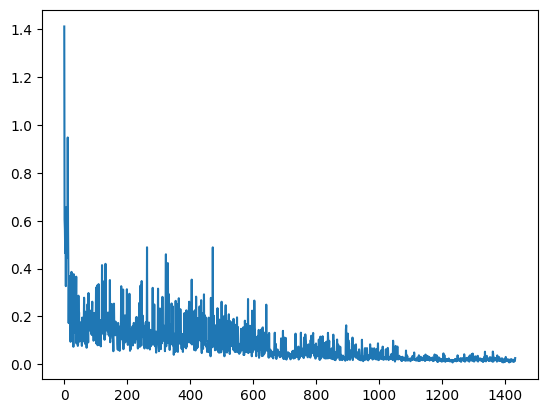

In [10]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in critic_loss])

Agent loaded from folder agent_state
[1.42496536e+02 1.43715393e+02 1.44698868e+02 1.45488998e+02
 1.47358994e+02 1.51562195e+02 1.87692604e+01 1.87692604e+01
 1.87692604e+01 1.87692604e+01 1.87692604e+01 0.00000000e+00
 1.28241135e-02 1.28241135e-02 1.28241135e-02 1.28241135e-02
 1.28241135e-02 1.28241135e-02]
Bolus injection!
[2. 2. 2.]
93.84630281899341
[7.82052523 0.5825495  0.        ]
Episode finished after 188 timesteps


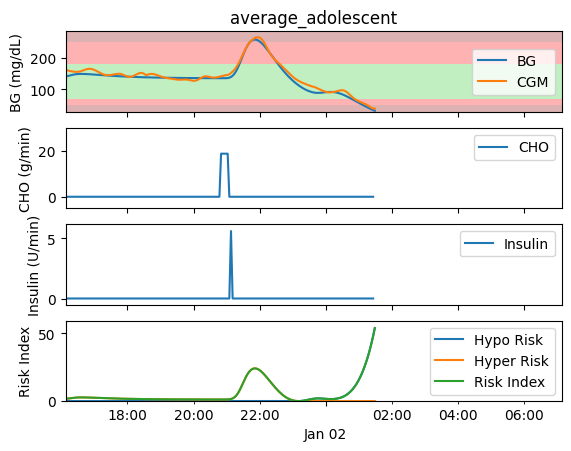

In [14]:
agent.load_agent()

observation, info = env.reset()
last_meal = 0
for t in range(1000):
    env.render(mode='human')
    if last_meal > observation[11]:
        print(observation)
        action = agent.select_action(observation)
        print('Bolus injection!')
        print(action)
    else:
        action = [0, 0, 0]
    last_meal = observation[11]
    observation, reward, done, _, info = env.step(action)  
    # print('info  ', info)     
    # print('CHO   ', observation[11])
    print(f'Still alive {t}', end='\r')
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))

        break